<a href="https://colab.research.google.com/github/sshcecilia/supermarket_customer_segmentation/blob/main/Customer_Segmentation_using_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# Load Data

In [ ]:
files = [
    ['aisles.csv', 'https://drive.google.com/file/d/1o4IG9y5C_pxi-pY5FcSqdTdSU2B5F9UJ/view?usp=drive_link']
    , ['departments.csv', 'https://drive.google.com/file/d/1stMu6xE4w0-9Z60VO2jeU3J8L26MoPt4/view?usp=drive_link']
    , ['order_products__prior.csv', 'https://drive.google.com/file/d/1XL5O-hgwjFq8j0UVbp28R7P3bmVeKieQ/view?usp=drive_link']
    , ['order_products__train.csv', 'https://drive.google.com/file/d/1Ux-mH_t5LCnbpiTXld3lJmVKQrAyxe-J/view?usp=drive_link']
    , ['orders.csv', 'https://drive.google.com/file/d/12-Imqn-f7qnjRKbYCHWwK1LuSvX2c9cf/view?usp=drive_link']
    , ['products.csv', 'https://drive.google.com/file/d/1zfEVroXVByALZka7tEghJBo1QLMHZcQk/view?usp=drive_link']
    , ['user_mix_df_prior.csv', 'https://drive.google.com/file/d/1-_JS53dBzTPTHTeTq8CyqaI0qRGJ-smI/view?usp=sharing']
    , ['user_mix_cluster.csv', 'https://drive.google.com/file/d/1-3hVZ3deNBbtjElkMz2BhAQPOjaCR7F1/view?usp=sharing']
    , ['user_timecat_mix_df_prior.csv', 'https://drive.google.com/file/d/1-fJY66b0MdfwzqSmczX8o8H0UoPgvxrv/view?usp=sharing']
    , ['user_timecat_mix_cluster.csv', 'https://drive.google.com/file/d/1-4hU9c7_7iq2k1TmYfM6k43didwiC0B3/view?usp=drive_link']
    , ['user_tow_deptname_mix_df.csv', 'https://drive.google.com/file/d/1-mMqAVtsjeStN6mGx-nSlO7FMoS_ox9T/view?usp=sharing']
    , ['user_tow_deptname_mix_pivot_cluster.csv', 'https://drive.google.com/file/d/1-IjVrlF4WjdFvztclVQIonqIIHZQ00Fa/view?usp=sharing']
]

In [ ]:
for i in files:
  link = i[1]
  fluff, id = link.split('/d/')
  id, fluff = id.split('/')
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile(i[0])

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

ValueError: mount failed

# Preparing Data in the Required Format

## Installing PySpark

In [ ]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.
!pip install pyspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [773 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,898 kB]
Get:13 http://archive.ubuntu.com/ubuntu j

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

import findspark
findspark.init()

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("Clustering")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

## Read Data into RDD

Products table needs to read into pandas dataframe before converting to RDD as one of the product name has ',' in it, resulting in wrong values extracted for aisle_id and department_id when read directly into RDD. order_products_prior will be used as the training dataset while order_products_train_rdd will be used as the test dataset

In [ ]:
aisles_rdd = spark.read.csv('aisles.csv', header=True).rdd
departments_rdd = spark.read.csv('departments.csv', header=True).rdd
order_products_prior_rdd = spark.read.csv('order_products__prior.csv', header=True).rdd
order_products_train_rdd = spark.read.csv('order_products__train.csv', header=True).rdd
orders_rdd = spark.read.csv('orders.csv', header=True).rdd
products_rdd = spark.read.csv('products.csv', header=True).rdd

In [ ]:
products = pd.read_csv('products.csv')
productsDF = spark.createDataFrame(products)
products_rdd = productsDF.rdd

In [ ]:
aisles_rdd.take(5)

[Row(aisle_id='1', aisle='prepared soups salads'),
 Row(aisle_id='2', aisle='specialty cheeses'),
 Row(aisle_id='3', aisle='energy granola bars'),
 Row(aisle_id='4', aisle='instant foods'),
 Row(aisle_id='5', aisle='marinades meat preparation')]

In [ ]:
departments_rdd.take(5)

[Row(department_id='1', department='frozen'),
 Row(department_id='2', department='other'),
 Row(department_id='3', department='bakery'),
 Row(department_id='4', department='produce'),
 Row(department_id='5', department='alcohol')]

In [ ]:
order_products_prior_rdd.take(5)

[Row(order_id='2', product_id='33120', add_to_cart_order='1', reordered='1'),
 Row(order_id='2', product_id='28985', add_to_cart_order='2', reordered='1'),
 Row(order_id='2', product_id='9327', add_to_cart_order='3', reordered='0'),
 Row(order_id='2', product_id='45918', add_to_cart_order='4', reordered='1'),
 Row(order_id='2', product_id='30035', add_to_cart_order='5', reordered='0')]

In [ ]:
order_products_prior_rdd = order_products_prior_rdd.repartition(16)

In [ ]:
order_products_train_rdd.take(5)

[Row(order_id='1', product_id='49302', add_to_cart_order='1', reordered='1'),
 Row(order_id='1', product_id='11109', add_to_cart_order='2', reordered='1'),
 Row(order_id='1', product_id='10246', add_to_cart_order='3', reordered='0'),
 Row(order_id='1', product_id='49683', add_to_cart_order='4', reordered='0'),
 Row(order_id='1', product_id='43633', add_to_cart_order='5', reordered='1')]

In [ ]:
order_products_train_rdd = order_products_train_rdd.repartition(16)

In [ ]:
orders_rdd.take(5)

[Row(order_id='2539329', user_id='1', eval_set='prior', order_number='1', order_dow='2', order_hour_of_day='08', days_since_prior_order=None),
 Row(order_id='2398795', user_id='1', eval_set='prior', order_number='2', order_dow='3', order_hour_of_day='07', days_since_prior_order='15.0'),
 Row(order_id='473747', user_id='1', eval_set='prior', order_number='3', order_dow='3', order_hour_of_day='12', days_since_prior_order='21.0'),
 Row(order_id='2254736', user_id='1', eval_set='prior', order_number='4', order_dow='4', order_hour_of_day='07', days_since_prior_order='29.0'),
 Row(order_id='431534', user_id='1', eval_set='prior', order_number='5', order_dow='4', order_hour_of_day='15', days_since_prior_order='28.0')]

In [ ]:
products_rdd.take(5)

[Row(product_id=1, product_name='Chocolate Sandwich Cookies', aisle_id=61, department_id=19),
 Row(product_id=2, product_name='All-Seasons Salt', aisle_id=104, department_id=13),
 Row(product_id=3, product_name='Robust Golden Unsweetened Oolong Tea', aisle_id=94, department_id=7),
 Row(product_id=4, product_name='Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce', aisle_id=38, department_id=1),
 Row(product_id=5, product_name='Green Chile Anytime Sauce', aisle_id=5, department_id=13)]

## Preparing Data for Customer Segmentation using the Proportion of Purchase from each Department

In [ ]:
order_products_prior_rdd = order_products_prior_rdd.map(lambda x: (int(x['product_id']), (x['order_id'], 1)))
order_products_prior_rdd.take(5)

[(33120, ('2', 1)),
 (28985, ('2', 1)),
 (9327, ('2', 1)),
 (45918, ('2', 1)),
 (30035, ('2', 1))]

In [ ]:
products_dept = products_rdd.map(lambda x: (x['product_id'], x['department_id']))
products_dept.take(5)

[(1, 19), (2, 13), (3, 7), (4, 1), (5, 13)]

In [ ]:
order_product_dept = order_products_prior_rdd.join(products_dept)
order_product_dept.take(5)

[(17668, (('3', 1), 16)),
 (17668, (('3317', 1), 16)),
 (17668, (('7309', 1), 16)),
 (17668, (('9124', 1), 16)),
 (17668, (('10478', 1), 16))]

In [ ]:
order_dept = order_product_dept.map(lambda x: ((x[1][0][0], x[1][1]), x[1][0][1]))
order_dept = order_dept.reduceByKey(lambda x,y: x+y)
order_dept.take(5)

[(('2234343', 21), 4),
 (('2360125', 21), 2),
 (('2568614', 21), 1),
 (('2653524', 21), 1),
 (('76385', 9), 1)]

Split orders_rdd to 'train' and 'prior' so that 'train' is used as test set while 'prior' is used as training set.

In [ ]:
orders_prior_rdd = orders_rdd.filter(lambda x: x['eval_set'] == 'prior')
orders_prior_rdd.take(5)

[Row(order_id='2539329', user_id='1', eval_set='prior', order_number='1', order_dow='2', order_hour_of_day='08', days_since_prior_order=None),
 Row(order_id='2398795', user_id='1', eval_set='prior', order_number='2', order_dow='3', order_hour_of_day='07', days_since_prior_order='15.0'),
 Row(order_id='473747', user_id='1', eval_set='prior', order_number='3', order_dow='3', order_hour_of_day='12', days_since_prior_order='21.0'),
 Row(order_id='2254736', user_id='1', eval_set='prior', order_number='4', order_dow='4', order_hour_of_day='07', days_since_prior_order='29.0'),
 Row(order_id='431534', user_id='1', eval_set='prior', order_number='5', order_dow='4', order_hour_of_day='15', days_since_prior_order='28.0')]

In [ ]:
orders_train_rdd = orders_rdd.filter(lambda x: x['eval_set'] == 'train')
orders_train_rdd.take(5)

[Row(order_id='1187899', user_id='1', eval_set='train', order_number='11', order_dow='4', order_hour_of_day='08', days_since_prior_order='14.0'),
 Row(order_id='1492625', user_id='2', eval_set='train', order_number='15', order_dow='1', order_hour_of_day='11', days_since_prior_order='30.0'),
 Row(order_id='2196797', user_id='5', eval_set='train', order_number='5', order_dow='0', order_hour_of_day='11', days_since_prior_order='6.0'),
 Row(order_id='525192', user_id='7', eval_set='train', order_number='21', order_dow='2', order_hour_of_day='11', days_since_prior_order='6.0'),
 Row(order_id='880375', user_id='8', eval_set='train', order_number='4', order_dow='1', order_hour_of_day='14', days_since_prior_order='10.0')]

In [ ]:
orders_prior_rdd = orders_prior_rdd.map(lambda x: (x['order_id'] , (x['user_id'], x['order_dow'], x['order_hour_of_day'])))
orders_user = order_dept.map(lambda x: (x[0][0], (x[0][1], x[1]))).join(orders_prior_rdd)
orders_user.take(5)

[('3123388', ((4, 4), ('61065', '1', '12'))),
 ('3123388', ((11, 1), ('61065', '1', '12'))),
 ('3123388', ((9, 1), ('61065', '1', '12'))),
 ('3123388', ((13, 3), ('61065', '1', '12'))),
 ('264409', ((12, 1), ('50661', '4', '10')))]

In [ ]:
user_dept = orders_user.map(lambda x: ((x[1][1][0], x[1][0][0]), x[1][0][1])).reduceByKey(lambda x, y: x+y)
user_dept.take(5)

[(('105463', 7), 71),
 (('120620', 14), 15),
 (('145805', 4), 124),
 (('120531', 3), 18),
 (('71380', 19), 32)]

In [ ]:
user_totalqty = user_dept.map(lambda x: (x[0][0], x[1])).reduceByKey(lambda x,y: x+y)
user_totalqty.take(5)

[('105463', 791), ('71380', 180), ('192275', 75), ('4569', 266), ('8046', 433)]

In [ ]:
user_mix = user_dept.map(lambda x: (x[0][0], (x[0][1], x[1]))).join(user_totalqty).map(lambda x: (x[0], x[1][0][0], x[1][0][1]/x[1][1]))
user_mix.take(5)

[('105463', 7, 0.0897597977243995),
 ('105463', 6, 0.0316055625790139),
 ('105463', 12, 0.04677623261694058),
 ('105463', 9, 0.039190897597977246),
 ('105463', 8, 0.008849557522123894)]

In [ ]:
departments_rdd = departments_rdd.map(lambda x: (int(x['department_id']), x['department']))
user_mix_deptname = user_mix.map(lambda x: (x[1], (x[0], x[2]))).join(departments_rdd).map(lambda x: (x[1][0][0], x[0], x[1][1], x[1][0][1]))
user_mix_deptname.take(5)

[('105463', 19, 'snacks', 0.13147914032869784),
 ('4569', 19, 'snacks', 0.04887218045112782),
 ('8046', 19, 'snacks', 0.09699769053117784),
 ('68266', 19, 'snacks', 0.04122990915443746),
 ('142900', 19, 'snacks', 0.05434782608695652)]

In [ ]:
user_mix_df = user_mix_deptname.toDF().toPandas()
user_mix_df.head()

_1  _2      _3        _4
0    6626   1  frozen  0.063406
1   61643   1  frozen  0.101010
2  125419   1  frozen  0.024719
3  155430   1  frozen  0.068277
4   41300   1  frozen  0.069001

In [ ]:
user_mix_df = user_mix_df.rename(columns={'_1': 'user_id', '_2': 'department_id', '_3':'department', '_4':'mix'})
user_mix_df.head()

user_id  department_id department       mix
0    6626              1     frozen  0.063406
1   61643              1     frozen  0.101010
2  125419              1     frozen  0.024719
3  155430              1     frozen  0.068277
4   41300              1     frozen  0.069001

In [ ]:
user_mix_df.head()

user_id  department_id department       mix
0     6626              1     frozen  0.063406
1    61643              1     frozen  0.101010
2   125419              1     frozen  0.024719
3   155430              1     frozen  0.068277
4    41300              1     frozen  0.069001

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
user_mix_df.to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_mix_df_prior.csv', index=False)

## Preparing Data for Customer Segmentation based on Day of Week and Time of Purchase

In [ ]:
orders_prior_rdd.take(5)

[('2539329', ('1', '2', '08')),
 ('2398795', ('1', '3', '07')),
 ('473747', ('1', '3', '12')),
 ('2254736', ('1', '4', '07')),
 ('431534', ('1', '4', '15'))]

In [ ]:
user_dow_time = orders_prior_rdd.map(lambda x: ((x[1][0], int(x[1][1]), int(x[1][2])), 1))
user_dow_time.take(5)

[(('1', 2, 8), 1),
 (('1', 3, 7), 1),
 (('1', 3, 12), 1),
 (('1', 4, 7), 1),
 (('1', 4, 15), 1)]

Categorising Day of Week to Weekdays or Weekends and Time of Purchase to Morning, Afternoon, Evening and Night

In [ ]:
user_timecat = user_dow_time.map(lambda x: ((x[0][0], 'Weekday' if x[0][1] <= 5 else 'Weekend', 'Morning' if 5 <= x[0][2] < 12 else 'Afternoon' if 12 <= x[0][2] < 17 else 'Evening' if 17 <= x[0][2] < 21 else 'Night'), x[1]))
user_timecat.take(5)

[(('1', 'Weekday', 'Morning'), 1),
 (('1', 'Weekday', 'Morning'), 1),
 (('1', 'Weekday', 'Afternoon'), 1),
 (('1', 'Weekday', 'Morning'), 1),
 (('1', 'Weekday', 'Afternoon'), 1)]

In [ ]:
user_timecat_tc = user_timecat.reduceByKey(lambda x, y: x+y)
user_timecat_tc.take(5)

[(('1', 'Weekday', 'Morning'), 6),
 (('1', 'Weekday', 'Afternoon'), 4),
 (('4', 'Weekday', 'Morning'), 1),
 (('4', 'Weekday', 'Afternoon'), 3),
 (('7', 'Weekend', 'Morning'), 1)]

In [ ]:
user_tc = user_timecat_tc.map(lambda x: (x[0][0], x[1])).reduceByKey(lambda x,y: x+y)
user_tc.take(5)

[('1', 10), ('4', 5), ('8', 3), ('9', 3), ('10', 5)]

Obtain the proportion of Purchase from different Day of Week and Time of Purchase Combination

In [ ]:
user_timecat_mix = user_timecat_tc.map(lambda x: (x[0][0], (x[0][1], x[0][2], x[1]))).join(user_tc).map(lambda x: (x[0], x[1][0][0], x[1][0][1],x[1][0][2]/x[1][1] ))
user_timecat_mix.take(5)

[('4', 'Weekday', 'Morning', 0.2),
 ('4', 'Weekday', 'Afternoon', 0.6),
 ('4', 'Weekend', 'Morning', 0.2),
 ('10', 'Weekday', 'Afternoon', 0.6),
 ('10', 'Weekday', 'Evening', 0.4)]

In [ ]:
user_timecat_mix_df = user_timecat_mix.toDF().toPandas()
user_timecat_mix_df.head()

_1       _2         _3   _4
0   4  Weekday    Morning  0.2
1   4  Weekday  Afternoon  0.6
2   4  Weekend    Morning  0.2
3  10  Weekday  Afternoon  0.6
4  10  Weekday    Evening  0.4

In [ ]:
user_timecat_mix_df = user_timecat_mix_df.rename(columns={'_1': 'user_id', '_2': 'dow', '_3':'tod', '_4':'mix'})
user_timecat_mix_df.head()

user_id      dow        tod  mix
0       4  Weekday    Morning  0.2
1       4  Weekday  Afternoon  0.6
2       4  Weekend    Morning  0.2
3      10  Weekday  Afternoon  0.6
4      10  Weekday    Evening  0.4

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
user_timecat_mix_df.to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_timecat_mix_df_prior.csv', index = False)

## Combining Data on the Time of Purchase and Department Purchase Proportion

In [ ]:
order_product_dept.map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1]))).take(5)

[('326', (19, 1)),
 ('4500', (19, 1)),
 ('4983', (19, 1)),
 ('5995', (19, 1)),
 ('6034', (19, 1))]

In [ ]:
order_prior_tow_rdd = orders_prior_rdd.map(lambda x: (x[0], (x[1][0], 'Weekday' if int(x[1][1]) <= 5 else 'Weekend', 'Morning' if 5 <= int(x[1][2]) < 12 else 'Afternoon' if 12 <= int(x[1][2]) < 17 else 'Evening' if 17 <= int(x[1][2]) < 21 else 'Night')))
order_prior_tow_rdd.take(5)

[('2539329', ('1', 'Weekday', 'Morning')),
 ('2398795', ('1', 'Weekday', 'Morning')),
 ('473747', ('1', 'Weekday', 'Afternoon')),
 ('2254736', ('1', 'Weekday', 'Morning')),
 ('431534', ('1', 'Weekday', 'Afternoon'))]

In [ ]:
order_dept_tow = order_product_dept.map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1]))).join(order_prior_tow_rdd)
order_dept_tow.take(5)

[('3171361', ((16, 1), ('79695', 'Weekday', 'Afternoon'))),
 ('3171361', ((20, 1), ('79695', 'Weekday', 'Afternoon'))),
 ('3171361', ((16, 1), ('79695', 'Weekday', 'Afternoon'))),
 ('3171361', ((4, 1), ('79695', 'Weekday', 'Afternoon'))),
 ('3171361', ((16, 1), ('79695', 'Weekday', 'Afternoon')))]

In [ ]:
user_tow_dept_qty = order_dept_tow.map(lambda x: ((x[1][1][0], x[1][1][1], x[1][1][2], x[1][0][0]), x[1][0][1])).reduceByKey(lambda x, y: x+y)
user_tow_dept_qty.take(5)

[(('42193', 'Weekday', 'Evening', 4), 28),
 (('194853', 'Weekday', 'Evening', 4), 44),
 (('4999', 'Weekday', 'Morning', 14), 1),
 (('110456', 'Weekday', 'Morning', 3), 21),
 (('24283', 'Weekday', 'Afternoon', 3), 28)]

In [ ]:
user_tow_dept_ttlqty = user_tow_dept_qty.map(lambda x: (x[0][0], x[1])).reduceByKey(lambda x,y: x+y)
user_tow_dept_ttlqty.take(5)

[('4999', 100),
 ('172977', 457),
 ('138399', 708),
 ('1070', 39),
 ('169266', 1097)]

In [ ]:
user_tow_dept_mix = user_tow_dept_qty.map(lambda x: (x[0][0], (x[0][1], x[0][2], x[0][3], x[1]))).join(user_tow_dept_ttlqty)
user_tow_dept_mix = user_tow_dept_mix.map(lambda x: (x[1][0][2], (x[0], x[1][0][0], x[1][0][1], x[1][0][3]/x[1][1])))
user_tow_dept_mix.take(5)

[(14, ('4999', 'Weekday', 'Morning', 0.01)),
 (13, ('4999', 'Weekday', 'Afternoon', 0.03)),
 (4, ('4999', 'Weekday', 'Evening', 0.13)),
 (16, ('4999', 'Weekday', 'Evening', 0.04)),
 (19, ('4999', 'Weekday', 'Afternoon', 0.01))]

In [ ]:
user_tow_deptname_mix = user_tow_dept_mix.join(departments_rdd).map(lambda x: (x[1][0][0], x[0], x[1][1], x[1][0][1], x[1][0][2], x[1][0][3]))
user_tow_deptname_mix.take(5)

[('4999', 19, 'snacks', 'Weekday', 'Afternoon', 0.01),
 ('4999', 19, 'snacks', 'Weekday', 'Morning', 0.02),
 ('172977', 19, 'snacks', 'Weekday', 'Evening', 0.0262582056892779),
 ('172977', 19, 'snacks', 'Weekday', 'Afternoon', 0.0175054704595186),
 ('172977', 19, 'snacks', 'Weekend', 'Afternoon', 0.006564551422319475)]

In [ ]:
user_tow_deptname_mix.map(lambda x: x[1]).distinct().collect()

[19, 1, 20, 21, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

Unable to fit into memory. Hence, split into multiple files

In [ ]:
user_tow_deptname_mix_7 = user_tow_deptname_mix.filter(lambda x: 1 <= x[1] < 8)
user_tow_deptname_mix7_df = user_tow_deptname_mix_7.toDF().toPandas()
user_tow_deptname_mix7_df.head()

_1  _2      _3       _4         _5        _6
0    4999   1  frozen  Weekday  Afternoon  0.010000
1  172977   1  frozen  Weekday    Morning  0.002188
2  172977   1  frozen  Weekday    Evening  0.010941
3  172977   1  frozen  Weekday  Afternoon  0.008753
4  172977   1  frozen  Weekend    Morning  0.002188

In [ ]:
user_tow_deptname_mix_14 = user_tow_deptname_mix.filter(lambda x: 8 <= x[1] < 15)
user_tow_deptname_mix14_df = user_tow_deptname_mix_14.toDF().toPandas()
user_tow_deptname_mix14_df.head()

_1  _2    _3       _4         _5        _6
0  105463   8  pets  Weekday  Afternoon  0.005057
1  105463   8  pets  Weekday    Evening  0.002528
2  105463   8  pets  Weekday    Morning  0.001264
3   59962   8  pets  Weekday    Evening  0.017857
4   81615   8  pets  Weekday  Afternoon  0.087087

In [ ]:
user_tow_deptname_mix_21 = user_tow_deptname_mix.filter(lambda x: x[1] >= 15)
user_tow_deptname_mix21_df = user_tow_deptname_mix_21.toDF().toPandas()
user_tow_deptname_mix21_df.head()

_1  _2      _3       _4         _5        _6
0    4999  19  snacks  Weekday  Afternoon  0.010000
1    4999  19  snacks  Weekday    Morning  0.020000
2  172977  19  snacks  Weekday    Evening  0.026258
3  172977  19  snacks  Weekday  Afternoon  0.017505
4  172977  19  snacks  Weekend  Afternoon  0.006565

In [ ]:
user_tow_deptname_mix7_df = user_tow_deptname_mix7_df.rename(columns={'_1': 'user_id', '_2': 'department_id', '_3':'department', '_4':'dow', '_5':'tod', '_6': 'mix'})
user_tow_deptname_mix14_df = user_tow_deptname_mix14_df.rename(columns={'_1': 'user_id', '_2': 'department_id', '_3':'department', '_4':'dow', '_5':'tod', '_6': 'mix'})
user_tow_deptname_mix21_df = user_tow_deptname_mix21_df.rename(columns={'_1': 'user_id', '_2': 'department_id', '_3':'department', '_4':'dow', '_5':'tod', '_6': 'mix'})

In [ ]:
user_tow_deptname_mix7_df.head()

user_id  department_id department      dow        tod       mix
0    4999              1     frozen  Weekday  Afternoon  0.010000
1  172977              1     frozen  Weekday    Morning  0.002188
2  172977              1     frozen  Weekday    Evening  0.010941
3  172977              1     frozen  Weekday  Afternoon  0.008753
4  172977              1     frozen  Weekend    Morning  0.002188

In [ ]:
user_tow_deptname_mix_df = user_tow_deptname_mix7_df.append(user_tow_deptname_mix14_df, ignore_index=True)
user_tow_deptname_mix_df = user_tow_deptname_mix_df.append(user_tow_deptname_mix21_df, ignore_index=True)
user_tow_deptname_mix_df.head()

user_id  department_id department      dow        tod       mix
0    4999              1     frozen  Weekday  Afternoon  0.010000
1  172977              1     frozen  Weekday    Morning  0.002188
2  172977              1     frozen  Weekday    Evening  0.010941
3  172977              1     frozen  Weekday  Afternoon  0.008753
4  172977              1     frozen  Weekend    Morning  0.002188

In [ ]:
user_tow_deptname_mix7_df.to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_tow_deptname_mix7_df.csv', index = False)
user_tow_deptname_mix14_df.to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_tow_deptname_mix14_df.csv', index = False)
user_tow_deptname_mix21_df.to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_tow_deptname_mix21_df.csv', index = False)

In [ ]:
user_tow_deptname_mix_df.to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_tow_deptname_mix_df.csv', index = False)

# Clustering

## Implement KMeans to Categorise Customers based on Proportion of Purchase from each Department

In [ ]:
user_mix_df = pd.read_csv('user_mix_df_prior.csv')

In [ ]:
user_mix_df.head()

user_id  department_id department       mix
0     6626              1     frozen  0.063406
1    61643              1     frozen  0.101010
2   125419              1     frozen  0.024719
3   155430              1     frozen  0.068277
4    41300              1     frozen  0.069001

In [ ]:
user_mix_pivot = user_mix_df.pivot(index = 'user_id', columns = ['department_id', 'department'], values = 'mix').fillna(0)
user_mix_df.head()

user_id  department_id department       mix
0     6626              1     frozen  0.063406
1    61643              1     frozen  0.101010
2   125419              1     frozen  0.024719
3   155430              1     frozen  0.068277
4    41300              1     frozen  0.069001

On average, a higher proportion of the purchases were from the produce department followed by the dairy eggs department. Customers might be purchasing such items through Instacart to have them delivered home, reducing the hassle.

There exists the presence of 'Missing' and 'Others' department in the data. The proportion of purchase from these categories are low on average as well. We shall remove these 2 departments from the clustering data as they might not be helpful in understanding the customers.

<Axes: xlabel='department', ylabel='mix'>

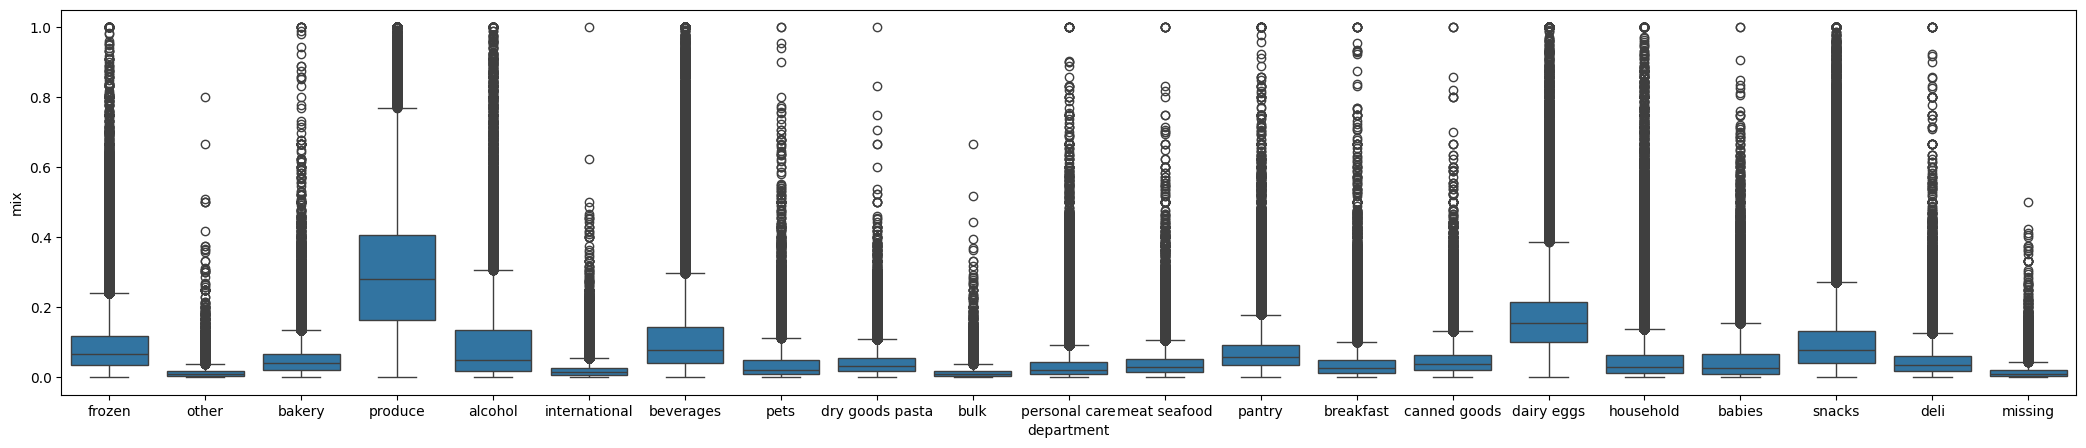

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(26,5))
sns.boxplot(x='department', y='mix', data=user_mix_df)

In [ ]:
user_mix_pivot = user_mix_pivot.drop([2, 21], axis = 1)
user_mix_pivot.head()

department_id        1         3         4         5             6         7   \
department       frozen    bakery   produce   alcohol international beverages   
user_id                                                                         
1              0.000000  0.000000  0.084746  0.000000      0.000000  0.220339   
2              0.087179  0.010256  0.184615  0.000000      0.015385  0.046154   
3              0.068182  0.000000  0.431818  0.000000      0.000000  0.034091   
4              0.166667  0.111111  0.111111  0.111111      0.000000  0.166667   
5              0.054054  0.000000  0.513514  0.000000      0.054054  0.000000   

department_id   8               9    10            11           12        13  \
department    pets dry goods pasta bulk personal care meat seafood    pantry   
user_id                                                                        
1              0.0        0.000000  0.0      0.000000     0.000000  0.016949   
2              0.0        0.000000  0.0      0.005128     0.005128  0.056410   
3              0.0        0.045455  0.0      0.000000     0.000000  0.045455   
4              0.0        0.000000  0.0      0.000000     0.000000  0.000000   
5              0.0        0.027027  0.0      0.000000     0.000000  0.054054   

department_id        14           15         16        17     18        19  \
department    breakfast canned goods dairy eggs household babies    snacks   
user_id                                                                      
1              0.050847     0.000000   0.220339  0.033898    0.0  0.372881   
2              0.015385     0.005128   0.246154  0.000000    0.0  0.215385   
3              0.000000     0.000000   0.238636  0.011364    0.0  0.102273   
4              0.000000     0.055556   0.000000  0.111111    0.0  0.055556   
5              0.000000     0.027027   0.216216  0.000000    0.0  0.027027   

department_id        20  
department         deli  
user_id                  
1              0.000000  
2              0.107692  
3              0.022727  
4              0.111111  
5              0.027027

Performing KMeans on different values of k

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np

user_mix_np = user_mix_pivot.to_numpy()
user_mix_np_norm = preprocessing.normalize(user_mix_np)

score = []
k = []
for i in range(2,50):
  print(i)
  user_cluster_model = KMeans(n_clusters=i, init='k-means++').fit(user_mix_np_norm)
  k.append(i)
  score.append(user_cluster_model.inertia_)

The first chart below contains the elbow curve which shows the within cluster sum of squared errors for the various cluster number. The second chart shows the change in the within cluster sum of squared errors as k increases.

Both chart indicates that at k = 12, the decline in within cluster sum of squared errors starts to slow down and thus we will be running k means at k = 12.

Text(0.5, 1.0, 'Elbow curve')

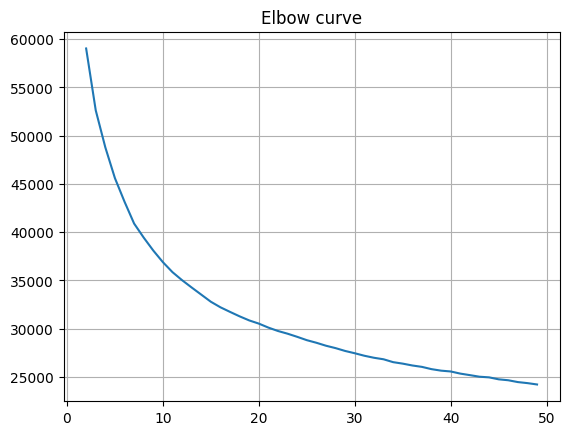

In [ ]:
from matplotlib import pyplot as plt

plt.plot(k, score)
plt.grid(True)
plt.title('Elbow curve')

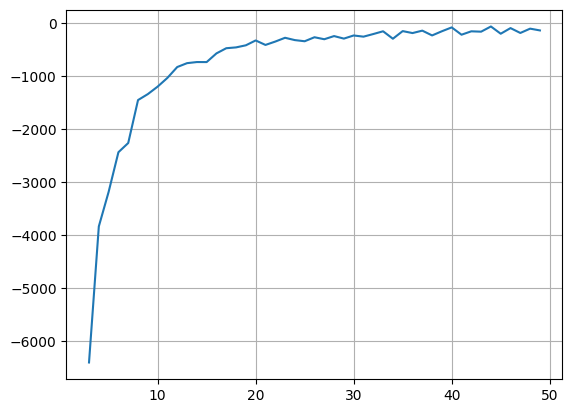

In [ ]:
diff = []
for i in range(len(score)-1):
  diff.append(score[i+1] - score[i])

plt.plot(k[1:], diff)
plt.grid(True)

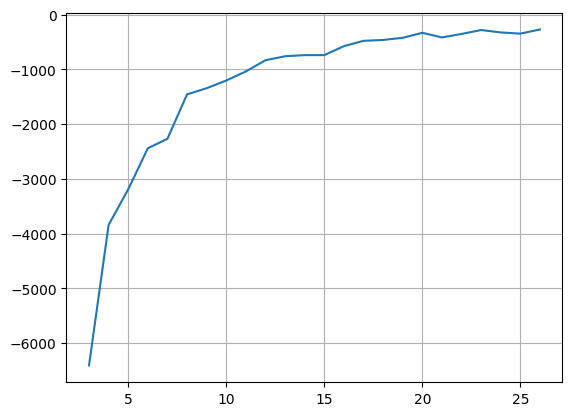

In [ ]:
plt.plot(k[1:25], diff[:24])
plt.grid(True)

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np

user_mix_np = user_mix_pivot.to_numpy()
user_mix_np_norm = preprocessing.normalize(user_mix_np)

user_k = 12
user_cluster_kmeans = KMeans(n_clusters=user_k, init='k-means++').fit(user_mix_np_norm)
user_results_kmeans = user_cluster_kmeans.labels_
user_mix_pivot['cluster_kmeans'] = user_results_kmeans

In [ ]:
user_mix_pivot.head()

department_id         1         3         4         5             6         7  \
department       frozen    bakery   produce   alcohol international beverages   
user_id                                                                         
1              0.000000  0.000000  0.084746  0.000000      0.000000  0.220339   
2              0.087179  0.010256  0.184615  0.000000      0.015385  0.046154   
3              0.068182  0.000000  0.431818  0.000000      0.000000  0.034091   
4              0.166667  0.111111  0.111111  0.111111      0.000000  0.166667   
5              0.054054  0.000000  0.513514  0.000000      0.054054  0.000000   

department_id    8               9   10            11           12        13  \
department    pets dry goods pasta bulk personal care meat seafood    pantry   
user_id                                                                        
1              0.0        0.000000  0.0      0.000000     0.000000  0.016949   
2              0.0        0.000000  0.0      0.005128     0.005128  0.056410   
3              0.0        0.045455  0.0      0.000000     0.000000  0.045455   
4              0.0        0.000000  0.0      0.000000     0.000000  0.000000   
5              0.0        0.027027  0.0      0.000000     0.000000  0.054054   

department_id        14           15         16        17     18        19  \
department    breakfast canned goods dairy eggs household babies    snacks   
user_id                                                                      
1              0.050847     0.000000   0.220339  0.033898    0.0  0.372881   
2              0.015385     0.005128   0.246154  0.000000    0.0  0.215385   
3              0.000000     0.000000   0.238636  0.011364    0.0  0.102273   
4              0.000000     0.055556   0.000000  0.111111    0.0  0.055556   
5              0.000000     0.027027   0.216216  0.000000    0.0  0.027027   

department_id        20 cluster_kmeans  
department         deli                 
user_id                                 
1              0.000000             10  
2              0.107692              3  
3              0.022727              6  
4              0.111111              4  
5              0.027027              6

In [ ]:
user_mix_pivot.reset_index(drop = False).to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_mix_cluster.csv', index = False)

In [ ]:
user_mix_pivot = pd.read_csv('user_mix_cluster.csv', header = [0,1])

In [ ]:
user_mix_pivot.rename(columns={"Unnamed: 19_level_1": "cluster_kmeans"}, inplace=True)
user_mix_pivot.head()

department_id         1         3         4         5             6         7  \
department       frozen    bakery   produce   alcohol international beverages   
user_id                                                                         
1              0.000000  0.000000  0.084746  0.000000      0.000000  0.220339   
2              0.087179  0.010256  0.184615  0.000000      0.015385  0.046154   
3              0.068182  0.000000  0.431818  0.000000      0.000000  0.034091   
4              0.166667  0.111111  0.111111  0.111111      0.000000  0.166667   
5              0.054054  0.000000  0.513514  0.000000      0.054054  0.000000   

department_id    8               9   10            11           12        13  \
department    pets dry goods pasta bulk personal care meat seafood    pantry   
user_id                                                                        
1              0.0        0.000000  0.0      0.000000     0.000000  0.016949   
2              0.0        0.000000  0.0      0.005128     0.005128  0.056410   
3              0.0        0.045455  0.0      0.000000     0.000000  0.045455   
4              0.0        0.000000  0.0      0.000000     0.000000  0.000000   
5              0.0        0.027027  0.0      0.000000     0.000000  0.054054   

department_id        14           15         16        17     18        19  \
department    breakfast canned goods dairy eggs household babies    snacks   
user_id                                                                      
1              0.050847     0.000000   0.220339  0.033898    0.0  0.372881   
2              0.015385     0.005128   0.246154  0.000000    0.0  0.215385   
3              0.000000     0.000000   0.238636  0.011364    0.0  0.102273   
4              0.000000     0.055556   0.000000  0.111111    0.0  0.055556   
5              0.000000     0.027027   0.216216  0.000000    0.0  0.027027   

department_id        20 cluster_kmeans  
department         deli                 
user_id                                 
1              0.000000             10  
2              0.107692              3  
3              0.022727              6  
4              0.111111              4  
5              0.027027              6

From the table below, Cluster 6 has the highest proportion of customers followed by Cluster 7. Cluster 0 has the lowest proportion.

In [ ]:
user_mix_pivot['user_id'] = user_mix_pivot.index
num_users = user_mix_pivot.groupby(['cluster_kmeans'])['user_id'].count()
prop_users = round(100 * num_users/user_mix_pivot.shape[0],1)
user_count = pd.concat([num_users, prop_users], axis=1)
user_count.columns = ['Number of Users', 'Proportion of Users (%)']
user_count

Number of Users  Proportion of Users (%)
cluster_kmeans                                          
0                          2544                      1.2
1                         16172                      7.8
2                         10269                      5.0
3                         17627                      8.5
4                         14372                      7.0
5                         25158                     12.2
6                         40677                     19.7
7                         35733                     17.3
8                         11213                      5.4
9                         15714                      7.6
10                        10799                      5.2
11                         5931                      2.9

In [ ]:
avg_mix = user_mix_pivot.groupby(['cluster_kmeans']).mean()
avg_mix.drop('user_id', axis = 1, inplace = True)
avg_mix

department_id          1         3         4         5             6  \
department        frozen    bakery   produce   alcohol international   
cluster_kmeans                                                         
0               0.042547  0.026355  0.086174  0.410929      0.005287   
1               0.058518  0.032847  0.260509  0.004984      0.008006   
2               0.062364  0.051160  0.138700  0.007000      0.013910   
3               0.074009  0.038934  0.264803  0.002752      0.008242   
4               0.270387  0.040026  0.116852  0.004846      0.008630   
5               0.062880  0.043111  0.261402  0.002488      0.007871   
6               0.058994  0.033506  0.383204  0.001772      0.009240   
7               0.044055  0.022403  0.548801  0.002078      0.007645   
8               0.045203  0.024780  0.066515  0.008406      0.004804   
9               0.061964  0.048546  0.094893  0.004826      0.006549   
10              0.049072  0.030474  0.085656  0.005990      0.005453   
11              0.040696  0.024202  0.065272  0.006765      0.005948   

department_id          7         8               9        10            11  \
department     beverages      pets dry goods pasta      bulk personal care   
cluster_kmeans                                                               
0               0.105152  0.004950        0.012554  0.000087      0.014003   
1               0.202951  0.003608        0.022791  0.000774      0.018270   
2               0.066412  0.005422        0.041926  0.000556      0.021880   
3               0.060075  0.002128        0.026964  0.001100      0.013565   
4               0.084452  0.006264        0.031721  0.000429      0.020806   
5               0.051586  0.001960        0.030253  0.000832      0.010341   
6               0.044684  0.001234        0.029241  0.001135      0.009069   
7               0.047516  0.000959        0.019462  0.001458      0.008935   
8               0.455899  0.005267        0.011662  0.000625      0.024162   
9               0.096413  0.004218        0.025391  0.000495      0.018804   
10              0.128656  0.002951        0.013428  0.001850      0.019423   
11              0.106456  0.021550        0.017628  0.000073      0.116218   

department_id            12        13        14           15         16  \
department     meat seafood    pantry breakfast canned goods dairy eggs   
cluster_kmeans                                                            
0                  0.013427  0.041021  0.011095     0.017075   0.072233   
1                  0.021799  0.054260  0.018538     0.029791   0.123702   
2                  0.034456  0.191267  0.026843     0.062493   0.130877   
3                  0.021207  0.054502  0.025814     0.030518   0.126158   
4                  0.021728  0.053768  0.025792     0.033852   0.119593   
5                  0.024560  0.054273  0.022553     0.032325   0.266773   
6                  0.026468  0.060299  0.016925     0.039026   0.177217   
7                  0.023899  0.051634  0.011713     0.033060   0.082189   
8                  0.011408  0.041873  0.021871     0.015621   0.091409   
9                  0.019375  0.054230  0.034405     0.025554   0.339542   
10                 0.010491  0.046173  0.036860     0.015804   0.100052   
11                 0.012147  0.059098  0.028498     0.021135   0.077955   

department_id         17        18        19        20  
department     household    babies    snacks      deli  
cluster_kmeans                                          
0               0.038133  0.003515  0.067558  0.020762  
1               0.028342  0.006580  0.068923  0.031343  
2               0.038759  0.006938  0.066372  0.028891  
3               0.018689  0.009978  0.175779  0.041312  
4               0.028012  0.007537  0.085651  0.034669  
5               0.016222  0.015155  0.057750  0.034463  
6               0.013317  0.009927  0.049057  0.032558  
7               0.013365  0.003713  0.047944  0.0259

From the boxplot below, we observed some characteristics about the clusters:

- Cluster 1, 3 and 5 might consist of customers who purchase items mainly for cooking as they tend to purchase more produce (e.g. vegetables), canned goods, dry goods, meat and seafood and they tend to buy in bulk. Furthermore, they seldom buy household items or personal care items. It might be possible that customers in these clusters tend to cook more.
- Cluster 2 is similar to Cluster 1, 3 and 5 however, customers in Cluster 2 purchase more pantry items and canned goods. Given that they tend to buy more pantry items, it is possible that Cluster 2 purchase for restaurants as they tend to consume pantry items at a faster rate.
- Cluster 0 might be alcohol lovers as they tend to purchase more alcohol. They also form the minority of the customers based on observation above.
- Cluster 11 customers are more likely to have pets and/or babies at home as they tend to purchase more pets and babies items. They also purchase more household items compared to other clusters.
- Cluster 10 purchase more from the bulk department on average than customers from other clusters. They also do buy more from the breakfast and snacks department. They might consists of customers who purchase for bigger consumption (e.g. businesses or bigger family) or they might consists of value driven customers.
- Cluster 4 might prefer convenience as they tend to purchase more frozen items, dry pasta goods and canned goods.
- Cluster 9 customers might be breakfast and bakery lovers. Their purchases consist mainly from the eggs, bakery, and breakfast department.
- Cluster 8 customers purchase more beverages. On average more than 40% of their purchases are from the beverages department.
- Cluster 6 and 7 are the average customers. They purchase more from the produce department and they form the largest proportion of Instacart's customers. Hence, it is important to ensure that their needs are met by providing more variety of goods in the produce department.

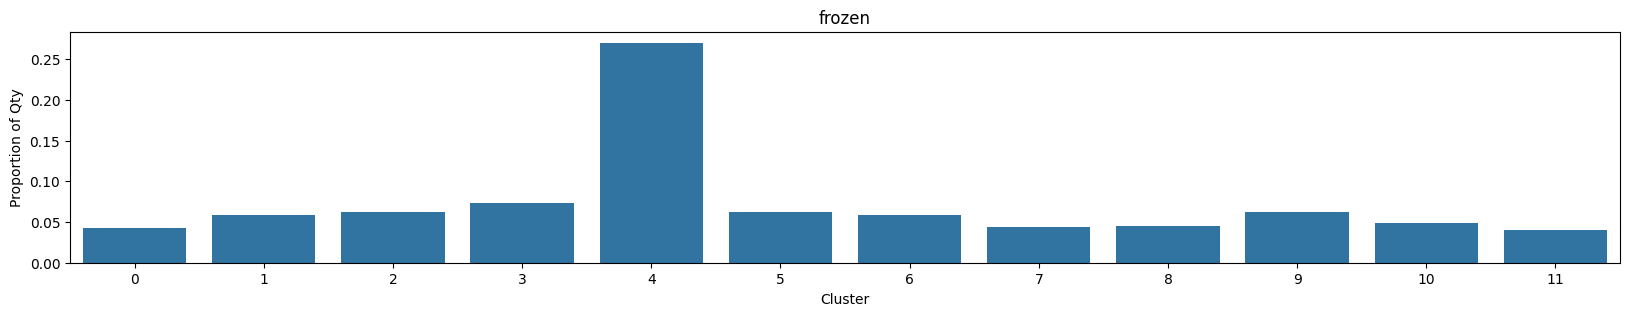

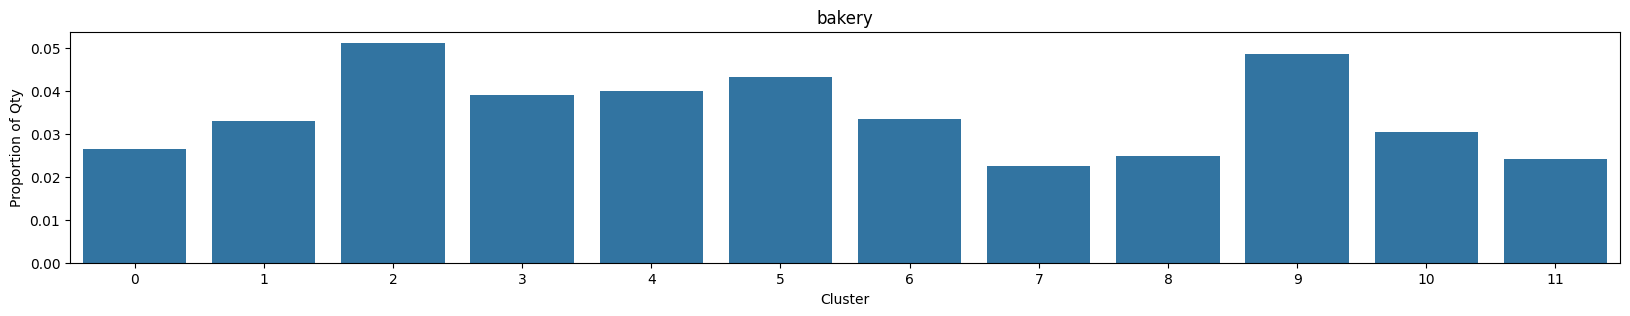

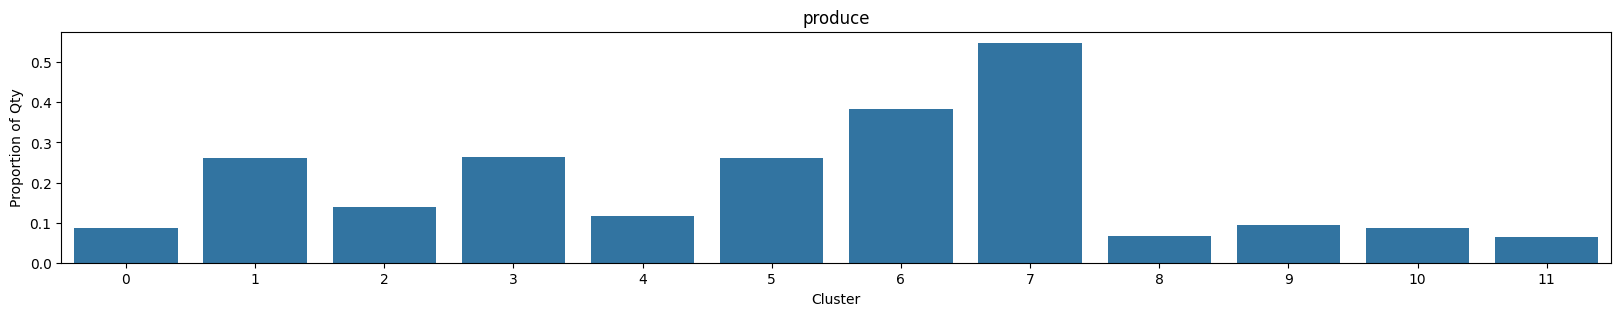

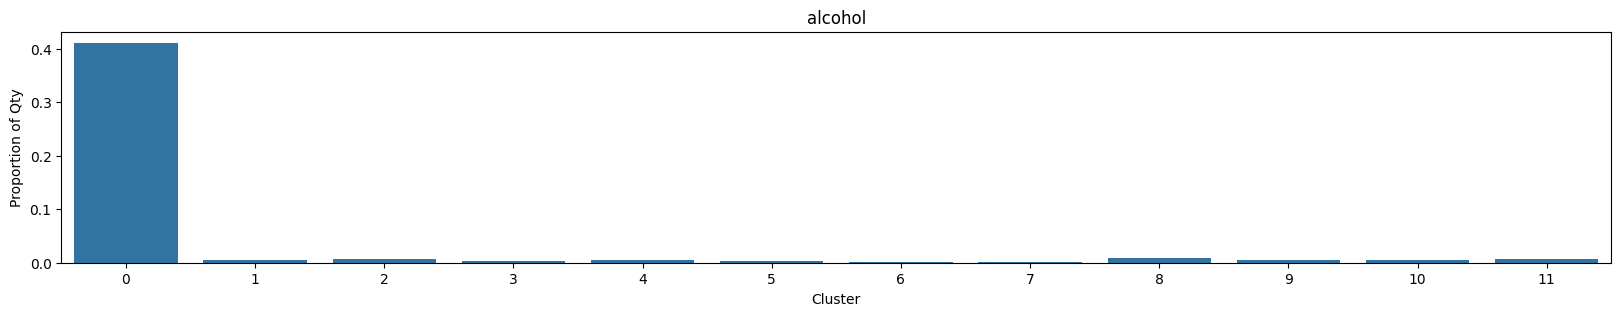

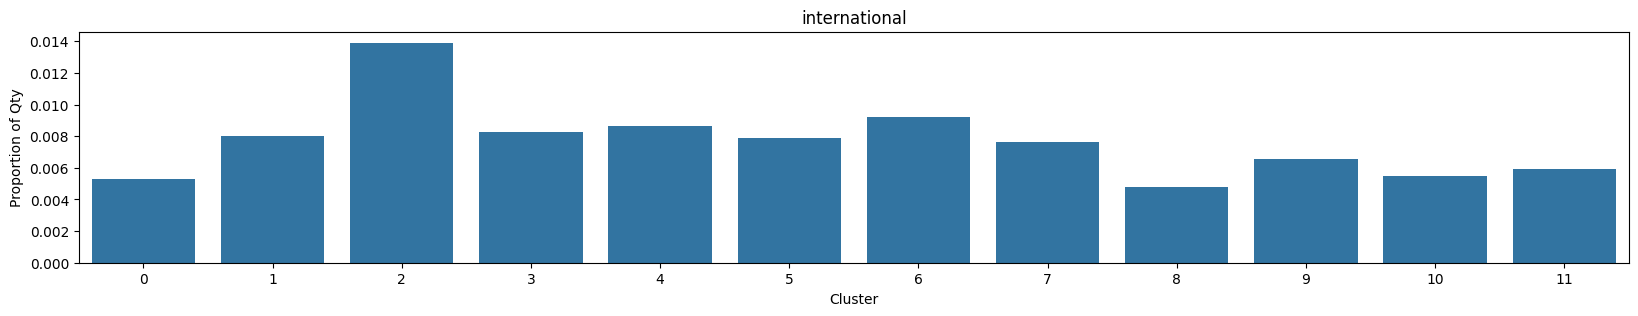

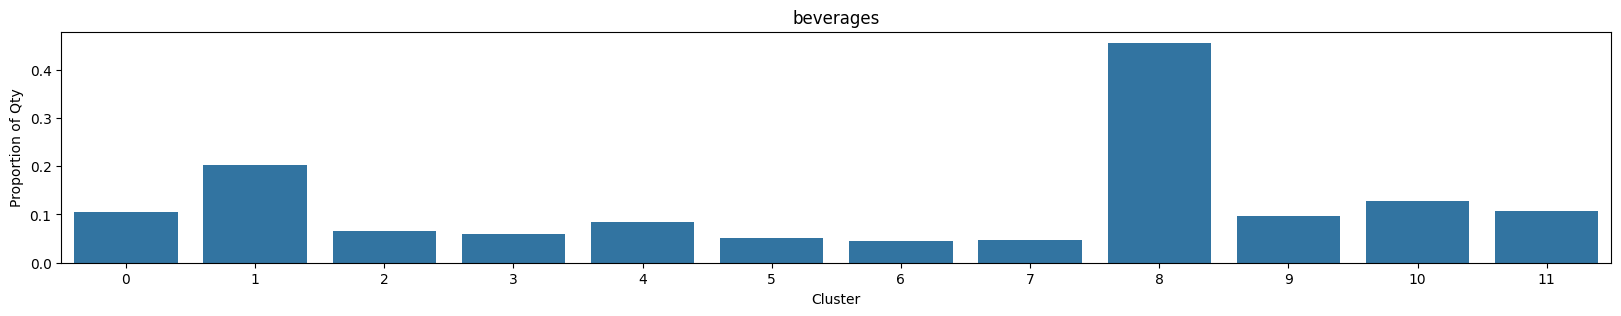

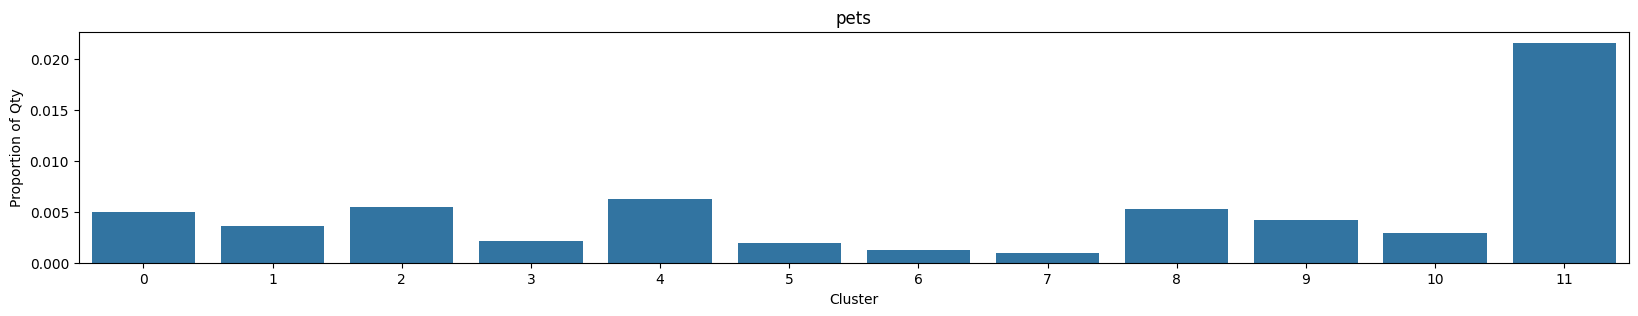

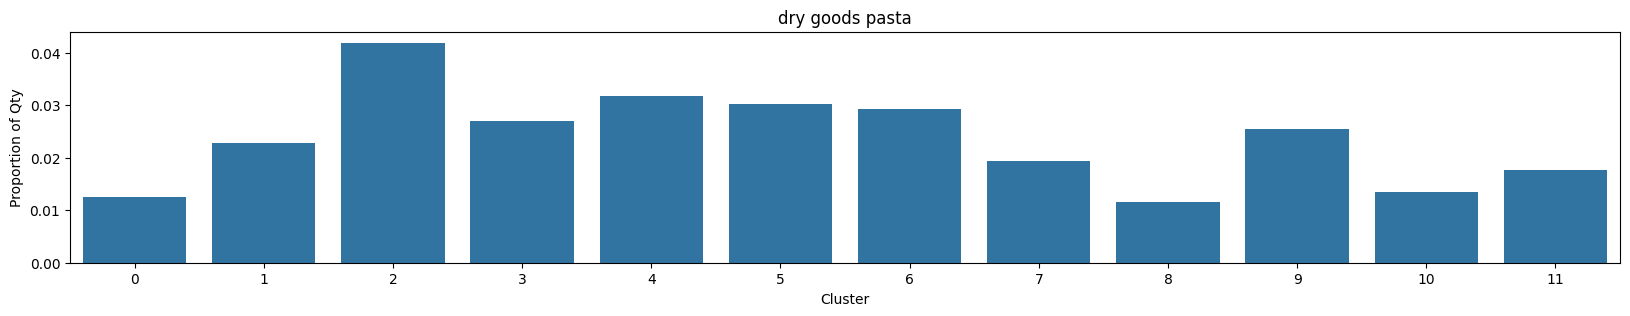

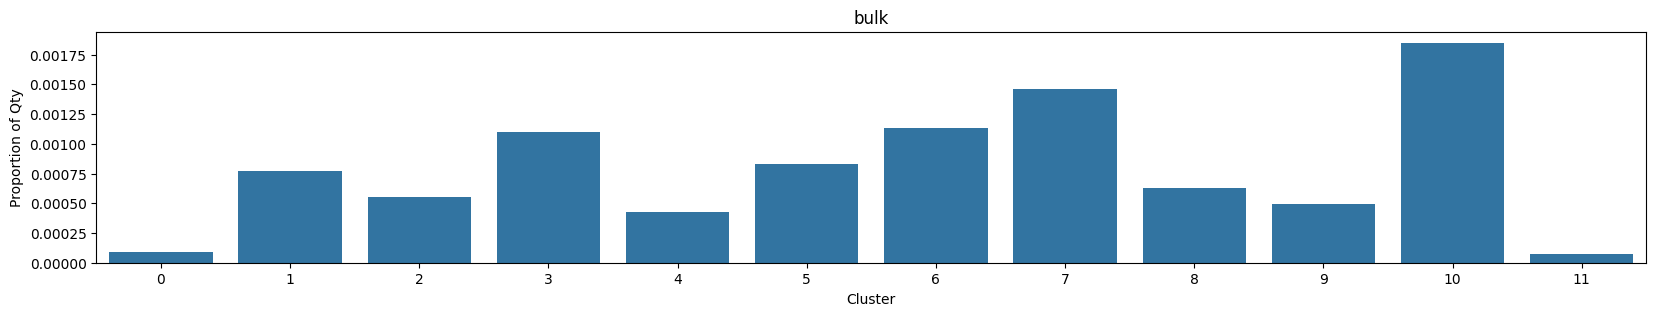

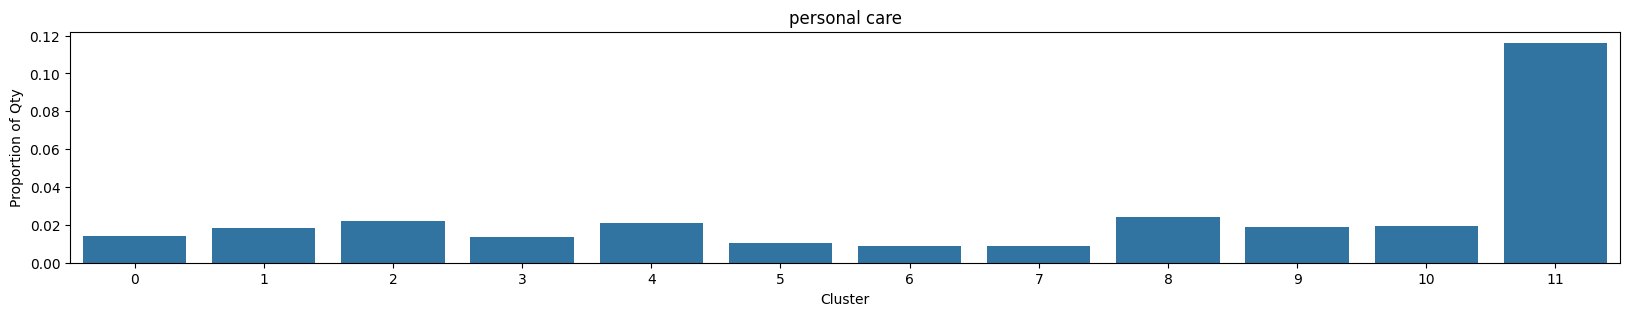

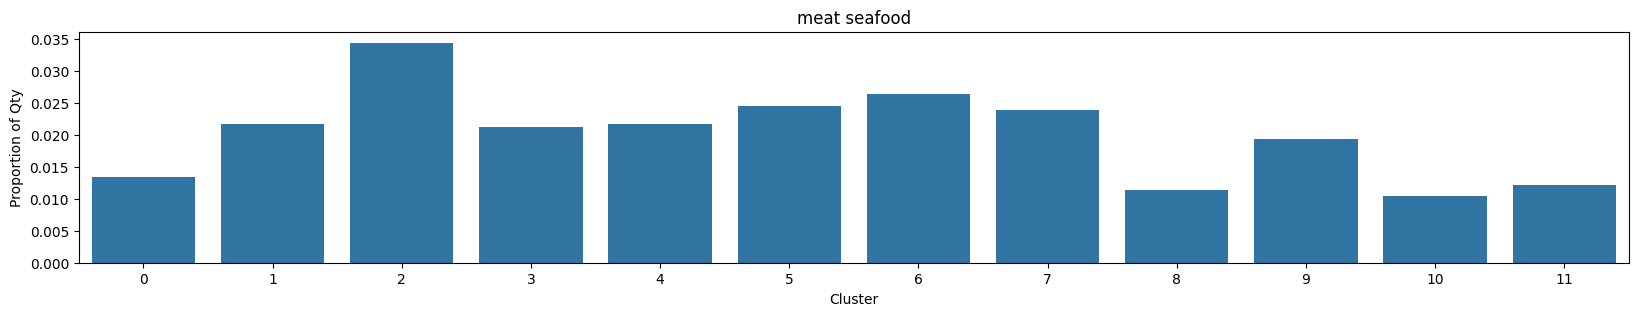

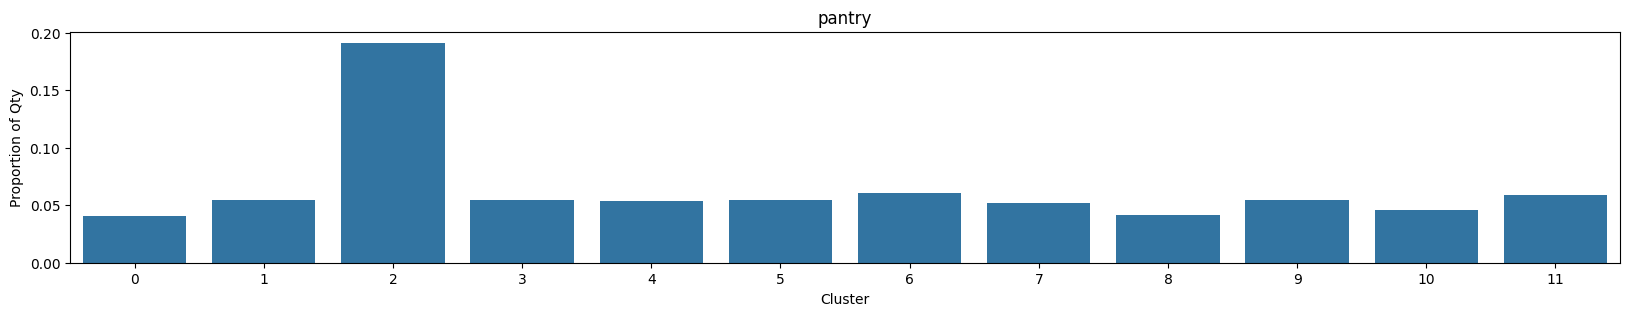

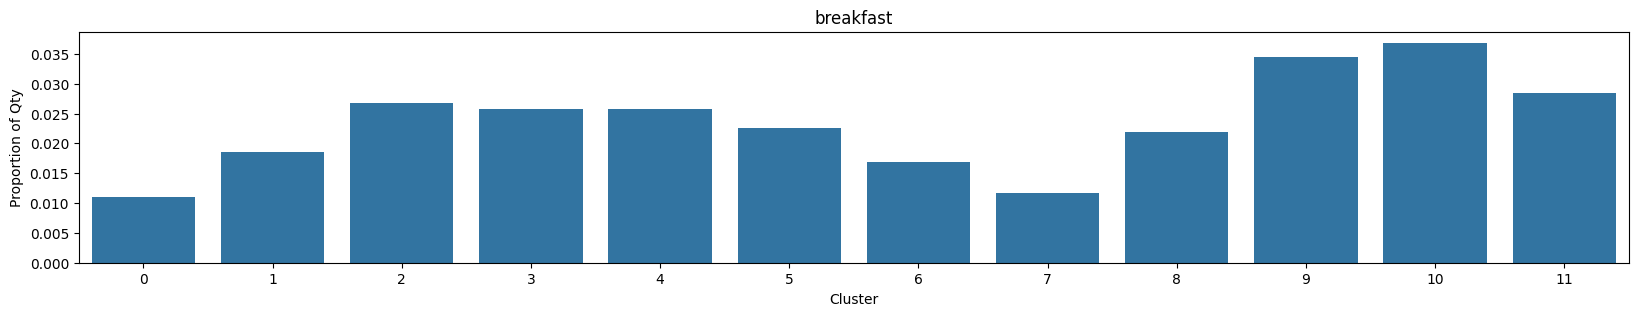

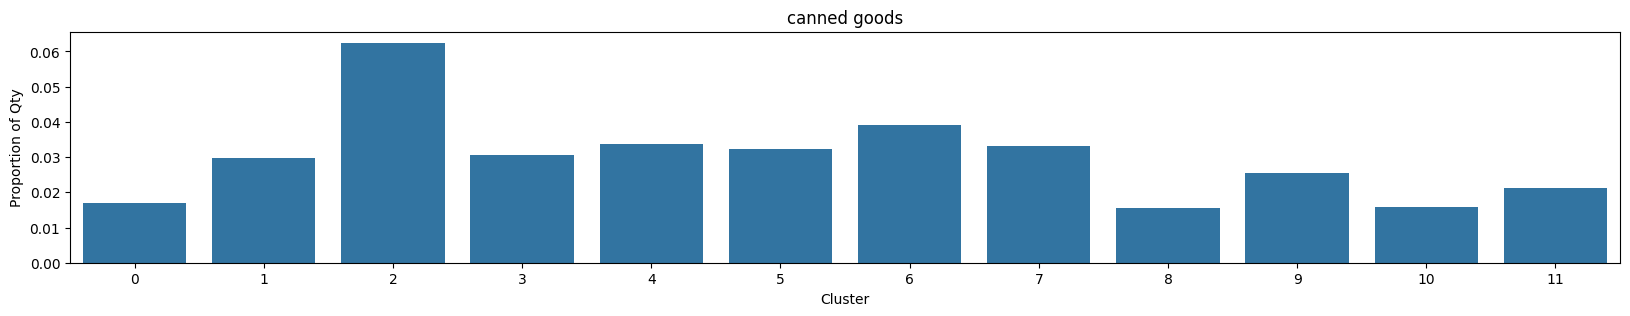

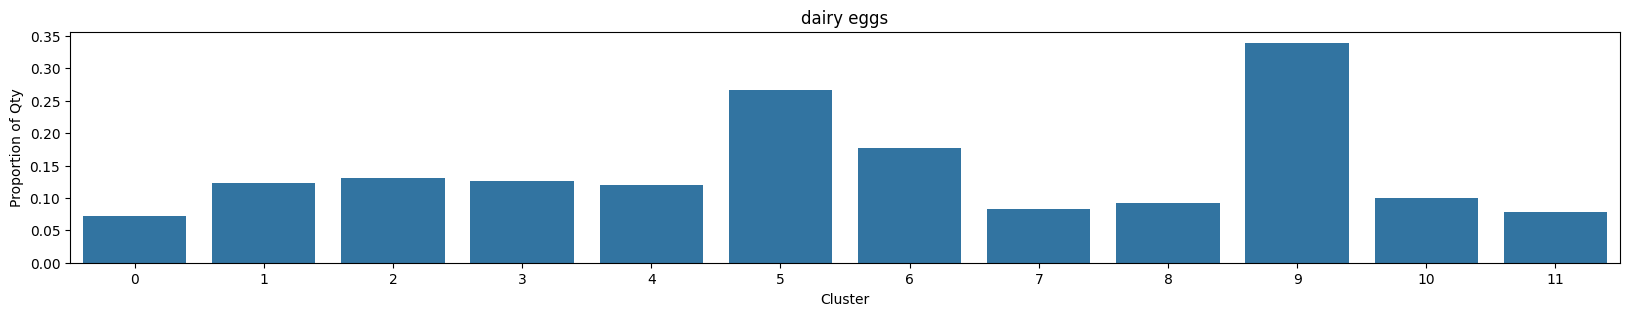

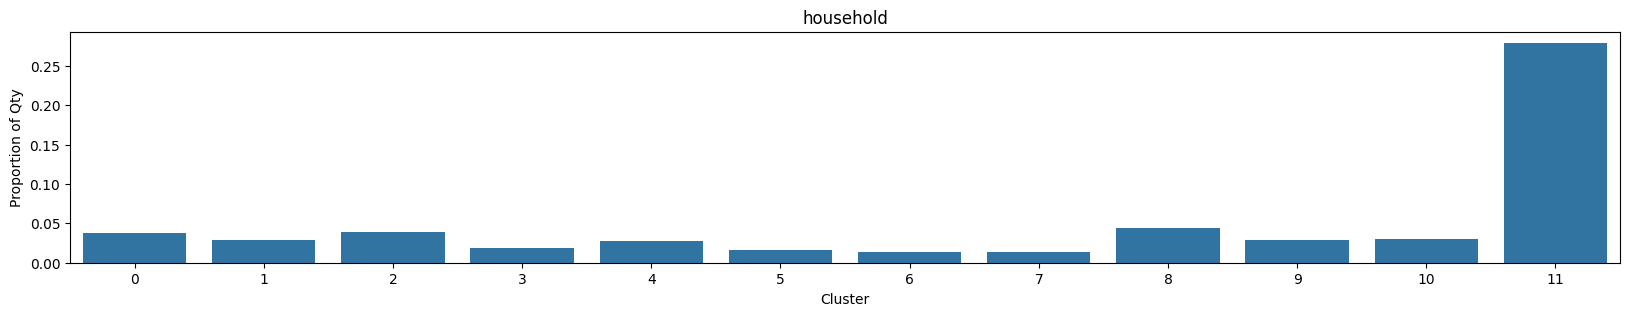

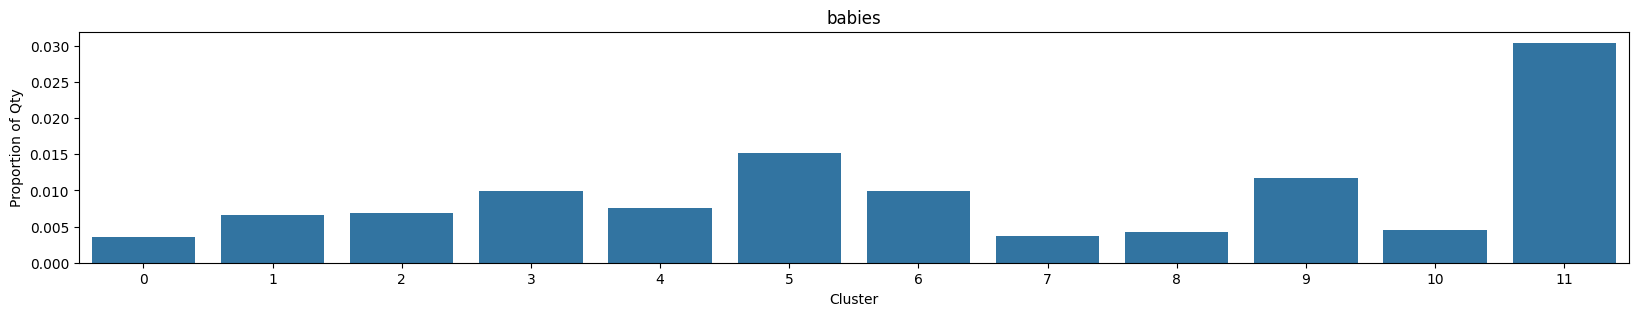

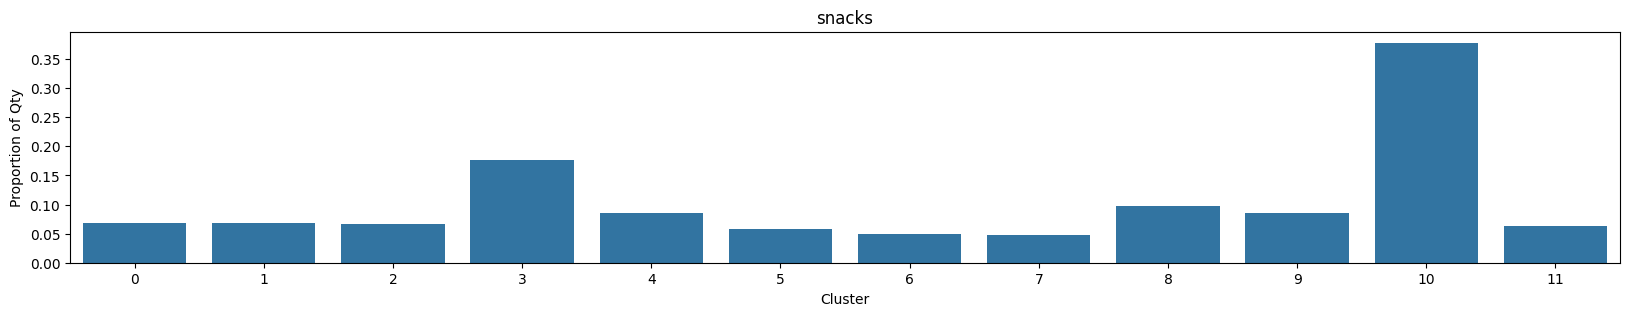

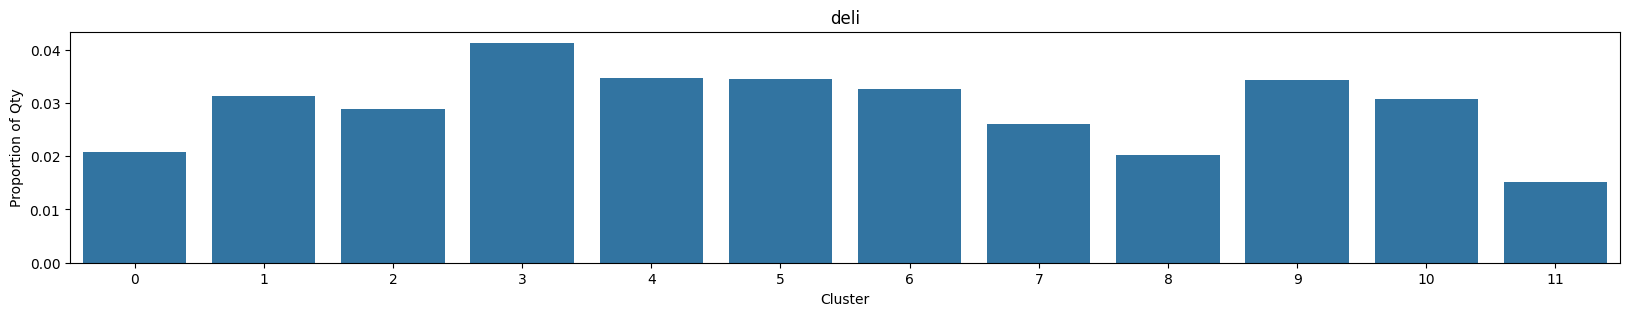

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

for i in avg_mix.columns:
  plt.figure(figsize=(20,3))
  sns.barplot(x='cluster_kmeans', y=avg_mix[i], data=avg_mix)
  plt.title(i[1])
  plt.xlabel("Cluster")
  plt.ylabel("Proportion of Qty")
  plt.show()

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Customer Segmentation based on Time of Purchase

In [ ]:
user_timecat_mix_df = pd.read_csv('user_timecat_mix_df_prior.csv')

In [ ]:
user_timecat_mix_df['time_of_purchase'] = user_timecat_mix_df['dow'] + "; " + user_timecat_mix_df['tod']

Higher proportion of the transactions were performed on a weekday morning and afternoon followed by weekday evening while a smaller proportion was done on weekends. This suggests that more customers might be coming in on a weekday and hence marketing events can be held on a weekday to maximise the effectiveness.


<Axes: xlabel='time_of_purchase', ylabel='mix'>

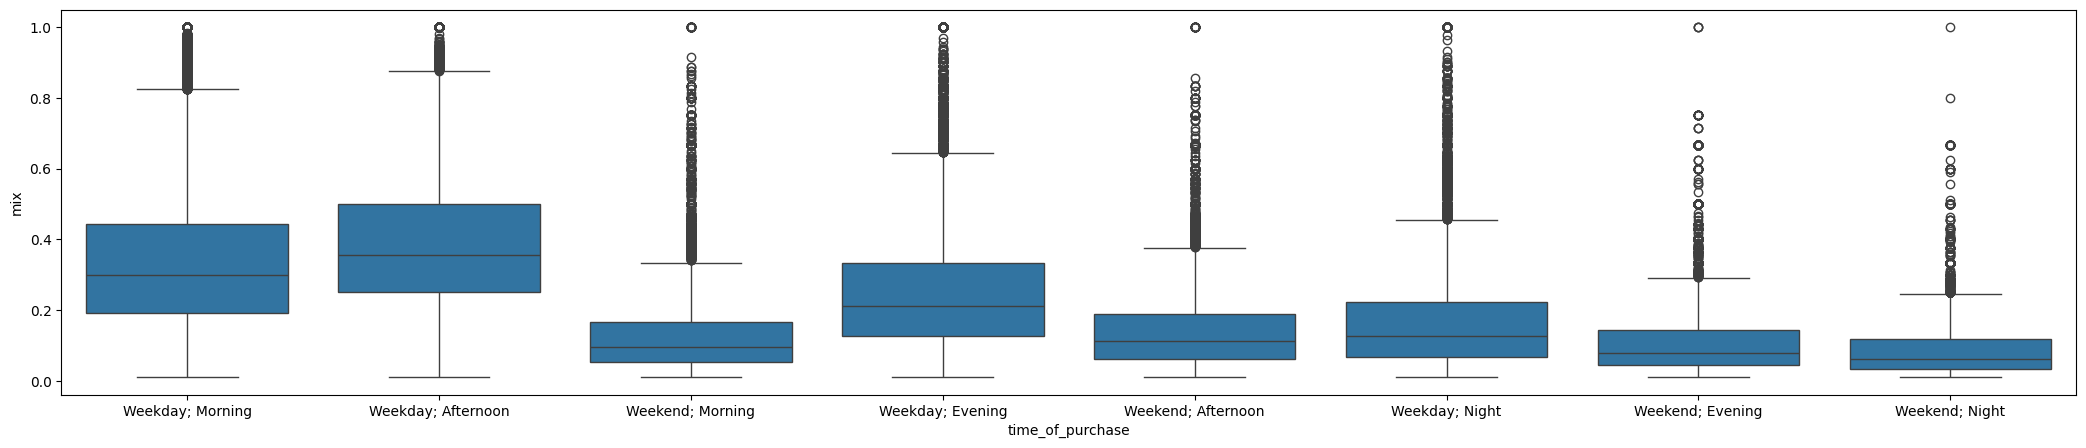

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(26,5))
sns.boxplot(x='time_of_purchase', y='mix', data=user_timecat_mix_df)

In [ ]:
user_timecat_mix_pivot = user_timecat_mix_df.pivot(index = 'user_id', columns = ['time_of_purchase'], values = 'mix').fillna(0)
user_timecat_mix_pivot.head()

time_of_purchase  Weekday; Afternoon  Weekday; Evening  Weekday; Morning  \
user_id                                                                    
1                           0.400000          0.000000          0.600000   
2                           0.142857          0.000000          0.857143   
3                           0.583333          0.416667          0.000000   
4                           0.600000          0.000000          0.200000   
5                           0.500000          0.500000          0.000000   

time_of_purchase  Weekday; Night  Weekend; Afternoon  Weekend; Evening  \
user_id                                                                  
1                            0.0                 0.0               0.0   
2                            0.0                 0.0               0.0   
3                            0.0                 0.0               0.0   
4                            0.0                 0.0               0.0   
5                            0.0                 0.0               0.0   

time_of_purchase  Weekend; Morning  Weekend; Night  
user_id                                             
1                              0.0             0.0  
2                              0.0             0.0  
3                              0.0             0.0  
4                              0.2             0.0  
5                              0.0             0.0

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np

user_timecat_mix_np = user_timecat_mix_pivot.to_numpy()
user_timecat_mix_np_norm = preprocessing.normalize(user_timecat_mix_np)

score = []
k = []
for i in tqdm(range(2,30)):
  print(i)
  user_timecat_cluster_model = KMeans(n_clusters=i, init='k-means++').fit(user_timecat_mix_np_norm)
  k.append(i)
  score.append(user_timecat_cluster_model.inertia_)

  0%|          | 0/28 [00:00<?, ?it/s]

2


  4%|▎         | 1/28 [00:03<01:34,  3.51s/it]

3


  7%|▋         | 2/28 [00:05<01:00,  2.35s/it]

4


 11%|█         | 3/28 [00:08<01:10,  2.81s/it]

5


 14%|█▍        | 4/28 [00:12<01:15,  3.15s/it]

6


 18%|█▊        | 5/28 [00:18<01:37,  4.22s/it]

7


 21%|██▏       | 6/28 [00:22<01:35,  4.32s/it]

8


 25%|██▌       | 7/28 [00:25<01:20,  3.83s/it]

9


 29%|██▊       | 8/28 [00:31<01:27,  4.39s/it]

10


 32%|███▏      | 9/28 [00:40<01:50,  5.80s/it]

11


 36%|███▌      | 10/28 [00:43<01:33,  5.17s/it]

12


 39%|███▉      | 11/28 [00:47<01:20,  4.72s/it]

13


 43%|████▎     | 12/28 [00:57<01:43,  6.48s/it]

14


 46%|████▋     | 13/28 [01:02<01:29,  5.94s/it]

15


 50%|█████     | 14/28 [01:07<01:18,  5.58s/it]

16


 54%|█████▎    | 15/28 [01:18<01:33,  7.16s/it]

17


 57%|█████▋    | 16/28 [01:24<01:21,  6.78s/it]

18


 61%|██████    | 17/28 [01:32<01:20,  7.36s/it]

19


 64%|██████▍   | 18/28 [01:40<01:13,  7.38s/it]

20


 68%|██████▊   | 19/28 [01:46<01:02,  6.98s/it]

21


 71%|███████▏  | 20/28 [01:58<01:07,  8.47s/it]

22


 75%|███████▌  | 21/28 [02:05<00:56,  8.13s/it]

23


 79%|███████▊  | 22/28 [02:18<00:58,  9.70s/it]

24


 82%|████████▏ | 23/28 [02:27<00:46,  9.39s/it]

25


 86%|████████▌ | 24/28 [02:40<00:41, 10.31s/it]

26


 89%|████████▉ | 25/28 [02:56<00:36, 12.18s/it]

27


 93%|█████████▎| 26/28 [03:07<00:23, 11.69s/it]

28


 96%|█████████▋| 27/28 [03:20<00:12, 12.06s/it]

29


100%|██████████| 28/28 [03:47<00:00,  8.13s/it]


The first chart below contains the elbow curve which shows the within cluster sum of squared errors for the various cluster number. The second chart shows the change in the within cluster sum of squared errors as k increases.

Both chart indicates that at k = 11, the decline in within cluster sum of squared errors starts to slow down and thus we will be running k means at k = 11.

Text(0.5, 1.0, 'Elbow curve')

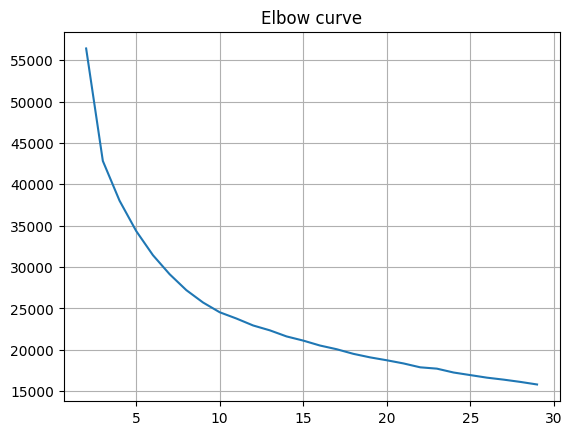

In [ ]:
from matplotlib import pyplot as plt

plt.plot(k, score)
plt.grid(True)
plt.title('Elbow curve')

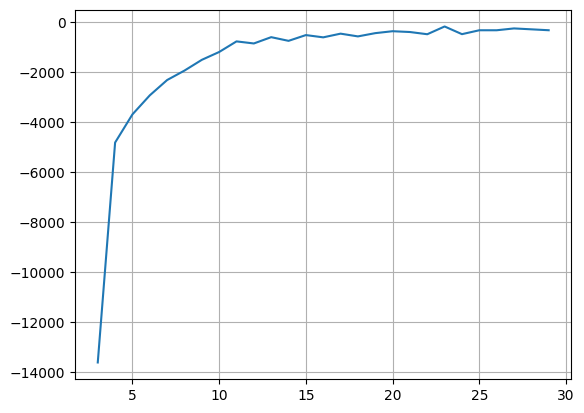

In [ ]:
diff = []
for i in range(len(score)-1):
  diff.append(score[i+1] - score[i])

plt.plot(k[1:], diff)
plt.grid(True)

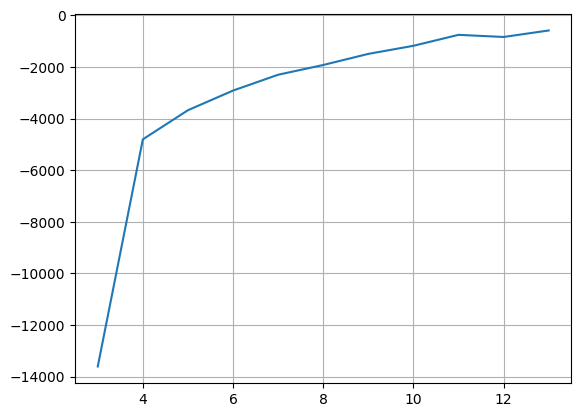

In [ ]:
plt.plot(k[1:12], diff[:11])
plt.grid(True)

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

user_timecat_mix_np = user_timecat_mix_pivot.to_numpy()
user_timecat_mix_np_norm = preprocessing.normalize(user_timecat_mix_np)
user_timecat_k = 11
user_timecat_cluster_kmeans = KMeans(n_clusters=user_timecat_k, init='k-means++').fit(user_timecat_mix_np_norm)
user_timecat_results_kmeans = user_timecat_cluster_kmeans.labels_
user_timecat_mix_pivot['cluster_kmeans'] = user_timecat_results_kmeans

In [ ]:
user_timecat_mix_pivot.reset_index(drop = False).to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_timecat_mix_cluster.csv', index = False)

In [ ]:
user_timecat_mix_pivot = pd.read_csv('user_timecat_mix_cluster.csv')

Cluster 6 have the highest proportion of customers followed by Cluster 1. Cluster 4 and 7 are the minority.

In [ ]:
user_timecat_mix_pivot['user_id'] = user_timecat_mix_pivot.index
num_users = user_timecat_mix_pivot.groupby(['cluster_kmeans'])['user_id'].count()
prop_users = round(100 * num_users/user_timecat_mix_pivot.shape[0],1)
user_count = pd.concat([num_users, prop_users], axis=1)
user_count.columns = ['Number of Users', 'Proportion of Users (%)']
user_count

Number of Users  Proportion of Users (%)
cluster_kmeans                                          
0                         19978                      9.7
1                         30046                     14.6
2                         23233                     11.3
3                         26168                     12.7
4                          7409                      3.6
5                         21906                     10.6
6                         30974                     15.0
7                          7131                      3.5
8                         10796                      5.2
9                          9216                      4.5
10                        19352                      9.4

In [ ]:
avg_mix_timecat = user_timecat_mix_pivot.groupby(['cluster_kmeans']).mean()
avg_mix_timecat.drop('user_id', axis = 1, inplace = True)
avg_mix_timecat

time_of_purchase  Weekday; Afternoon  Weekday; Evening  Weekday; Morning  \
cluster_kmeans                                                             
0                           0.169362          0.560851          0.084376   
1                           0.351459          0.053123          0.486284   
2                           0.719225          0.074724          0.060973   
3                           0.444109          0.308827          0.100773   
4                           0.097876          0.158338          0.143331   
5                           0.115817          0.067488          0.688018   
6                           0.536408          0.069281          0.285232   
7                           0.164407          0.099032          0.225689   
8                           0.333860          0.141457          0.157202   
9                           0.244950          0.122080          0.131522   
10                          0.225975          0.275559          0.334049   

time_of_purchase  Weekday; Night  Weekend; Afternoon  Weekend; Evening  \
cluster_kmeans                                                           
0                       0.047866            0.052433          0.045978   
1                       0.028043            0.030881          0.014613   
2                       0.030249            0.057738          0.023961   
3                       0.025798            0.048154          0.035167   
4                       0.448849            0.049031          0.034470   
5                       0.039099            0.031454          0.014514   
6                       0.021326            0.040004          0.014295   
7                       0.035330            0.090654          0.036090   
8                       0.253173            0.037239          0.026864   
9                       0.030310            0.345064          0.058559   
10                      0.046684            0.043467          0.029369   

time_of_purchase  Weekend; Morning  Weekend; Night  
cluster_kmeans                                      
0                         0.029124        0.010011  
1                         0.029574        0.006025  
2                         0.026770        0.006361  
3                         0.029460        0.007711  
4                         0.031461        0.036644  
5                         0.036446        0.007164  
6                         0.028178        0.005276  
7                         0.333466        0.015332  
8                         0.027536        0.022669  
9                         0.050731        0.016784  
10                        0.034723        0.010174

From the boxplot below, we observed some characteristics about the clusters:

- Cluster 0 tend to perform more transactions on evenings compared to other clusters. They could consists of customers who are working and thus are more available after work to check out the groceries.
- Cluster 1 and 6 perform more transactions on weekday morning and afternoon. They form the majority of the customers, and thus marketing and promotional events can be held during this period of time to target majority of the customers.
- Cluster 2 customers on average had 70% of their transactions done on a weekday afternoon. Cluster 5 customers preferred to have their groceries purchased on a weekday morning.
- Cluster 3 perform more transactions on a weekday afternoon and evening which constitute 70% of their transactions on average
- Cluster 4 and 8 performed more purchases at night compared to other clusters for both weekdays and weekends. They might be customers who worked late and thus have more time to consider their purchases at night or they might be night owls. The customers in these clusters form the minority.
- Cluster 7 on average perform more transactions than other clusters on a weekend morning.
- Cluster 9 customers prefer to do their groceries shopping on Instacart on a weekend, specifically in the afternoon and evening.
- Cluster 10 customers perform more transactions on Instacart on a weekday.

Personalised promotion for customers can be promoted during the period they are most likely to make their purchases, thereby increasing the possible effectiveness of the promotional tactics.

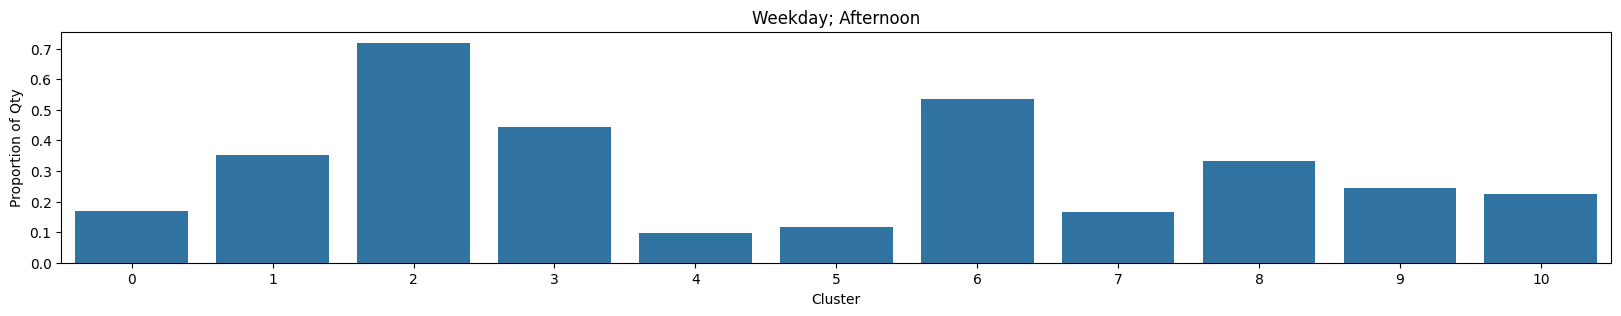

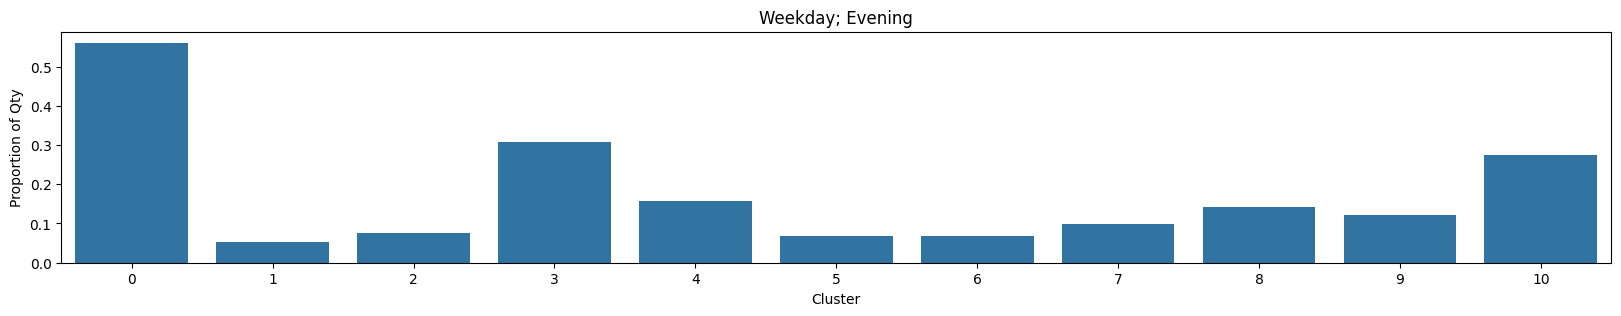

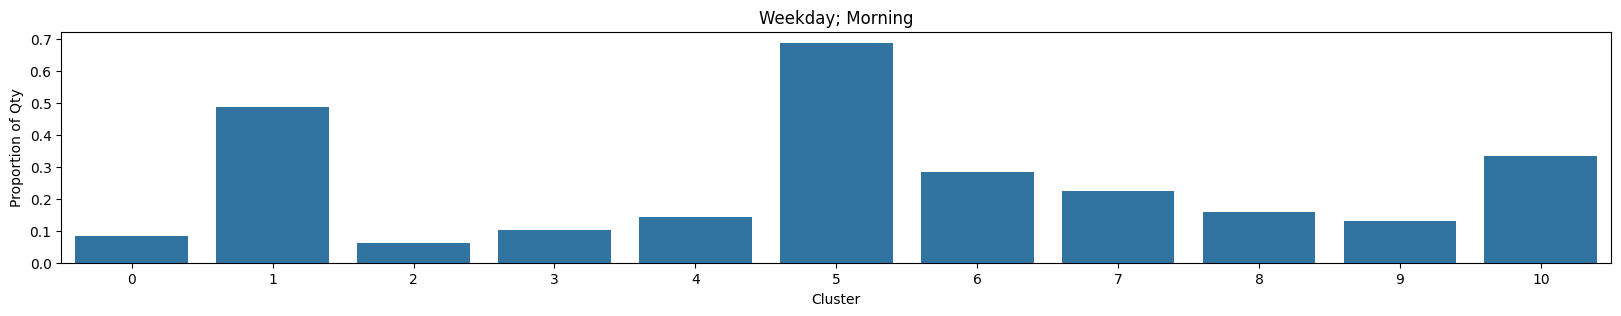

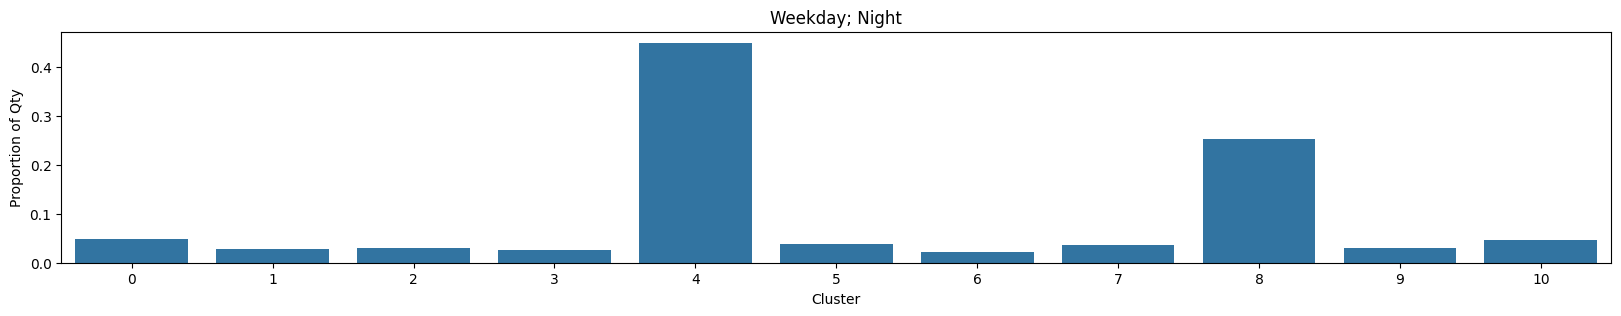

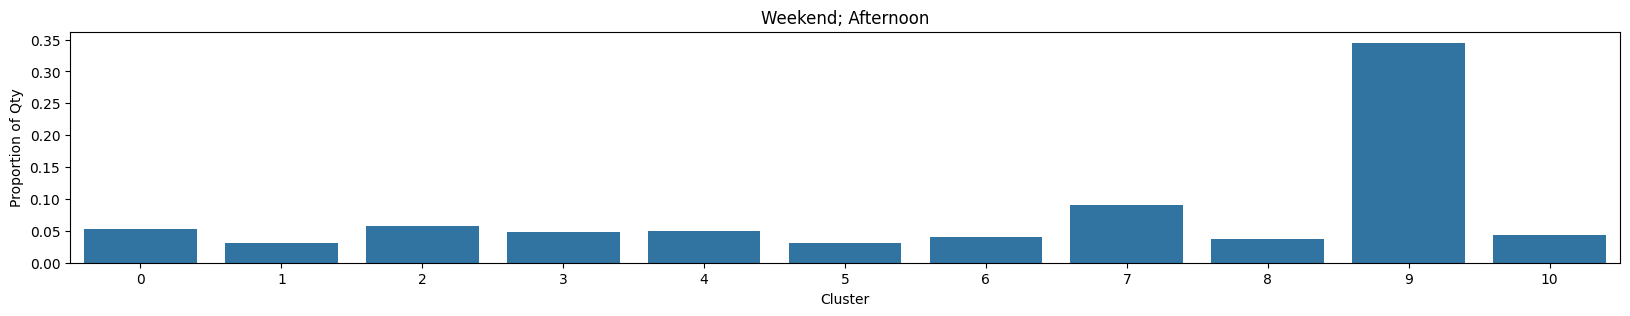

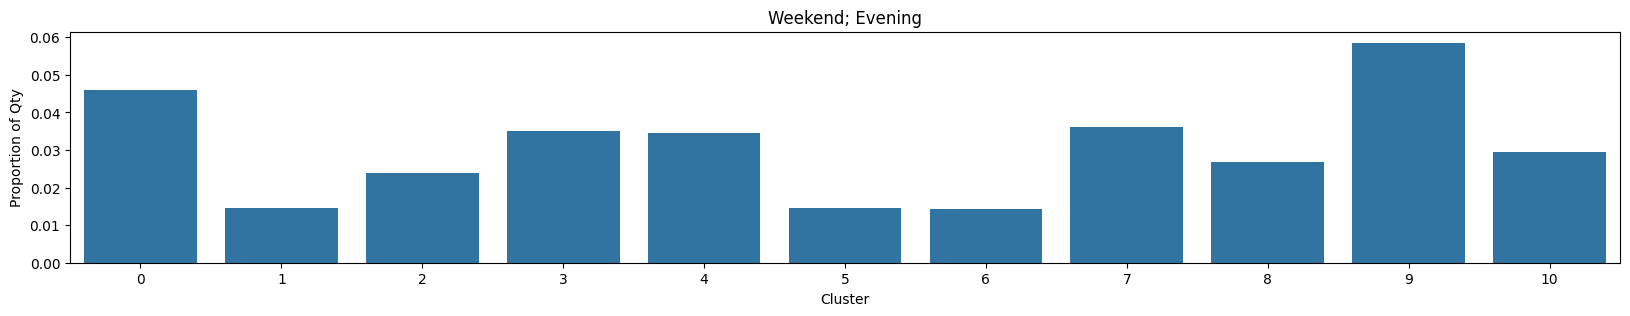

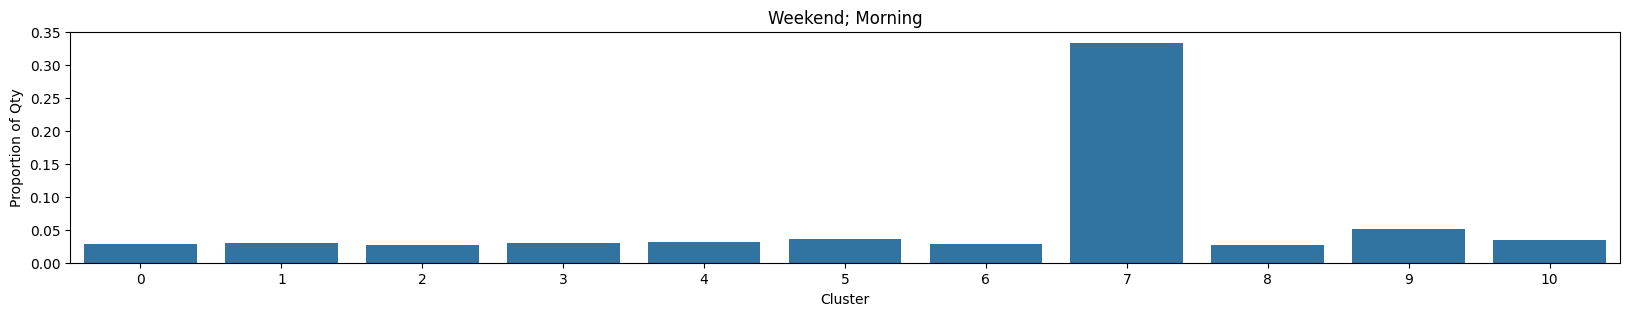

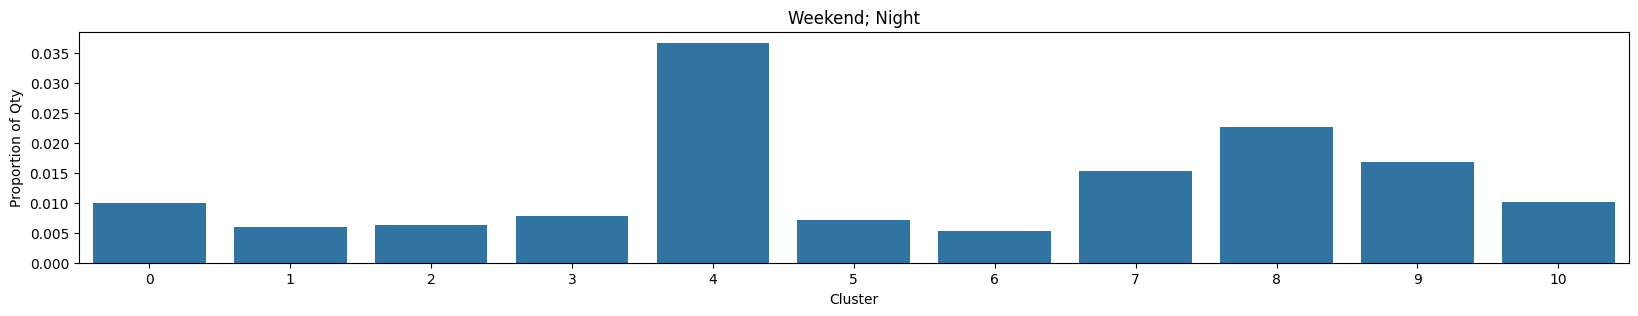

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

for i in avg_mix_timecat.columns:
  plt.figure(figsize=(20,3))
  sns.barplot(x='cluster_kmeans', y=avg_mix_timecat[i], data=avg_mix_timecat)
  plt.title(i)
  plt.xlabel("Cluster")
  plt.ylabel("Proportion of Qty")
  plt.show()

## Clustering using Historical Purchase & Time of Purchase

In [ ]:
user_tow_deptname_mix_df = pd.read_csv('user_tow_deptname_mix_df.csv')

In [ ]:
len(user_tow_deptname_mix_df.user_id.unique())

206209

In [ ]:
user_tow_deptname_mix_df.head()

user_id  department_id department      dow        tod       mix
0     4999              1     frozen  Weekday  Afternoon  0.010000
1   172977              1     frozen  Weekday    Morning  0.002188
2   172977              1     frozen  Weekday    Evening  0.010941
3   172977              1     frozen  Weekday  Afternoon  0.008753
4   172977              1     frozen  Weekend    Morning  0.002188

In [ ]:
user_tow_deptname_mix_df['dept_purchase_time'] = user_tow_deptname_mix_df['dow'] + "; " + user_tow_deptname_mix_df['tod'] + "; " + user_tow_deptname_mix_df['department']
user_tow_deptname_mix_df['time_of_purchase'] = user_tow_deptname_mix_df['dow'] + "; " + user_tow_deptname_mix_df['tod']
user_tow_deptname_mix_df.head()

user_id  department_id department      dow        tod       mix  \
0     4999              1     frozen  Weekday  Afternoon  0.010000   
1   172977              1     frozen  Weekday    Morning  0.002188   
2   172977              1     frozen  Weekday    Evening  0.010941   
3   172977              1     frozen  Weekday  Afternoon  0.008753   
4   172977              1     frozen  Weekend    Morning  0.002188   

           dept_purchase_time    time_of_purchase  
0  Weekday; Afternoon; frozen  Weekday; Afternoon  
1    Weekday; Morning; frozen    Weekday; Morning  
2    Weekday; Evening; frozen    Weekday; Evening  
3  Weekday; Afternoon; frozen  Weekday; Afternoon  
4    Weekend; Morning; frozen    Weekend; Morning

In general across all department, items are bought mostly during weekdays and less on weekends. Customers are coming in more on a weekday and hence marketing events can be held on a weekday to maximise the effectiveness.


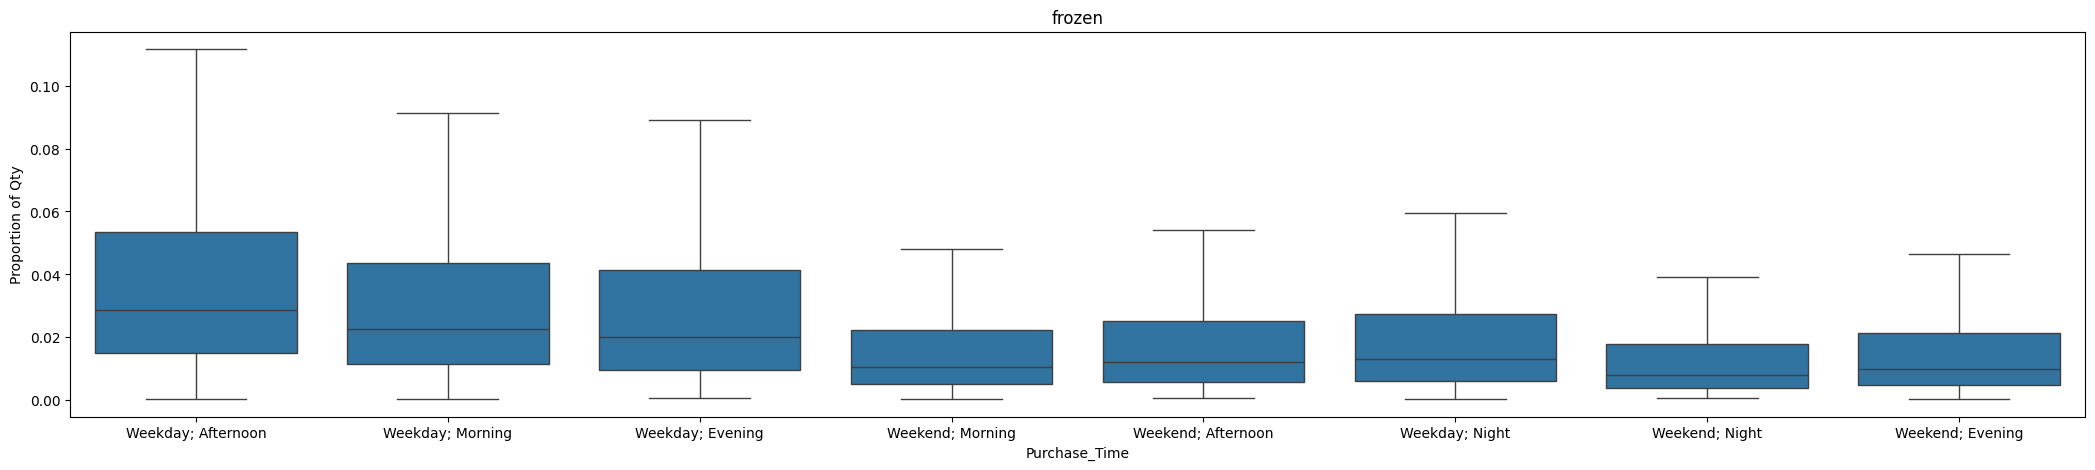

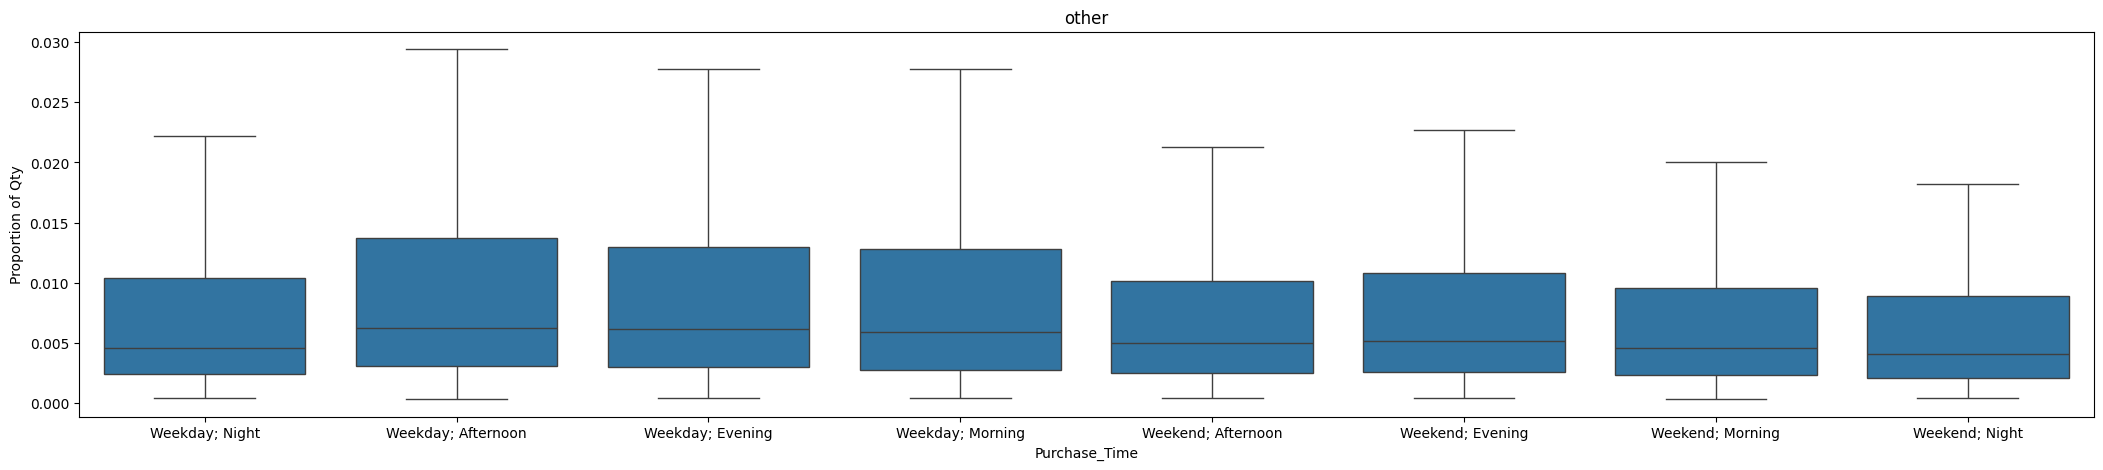

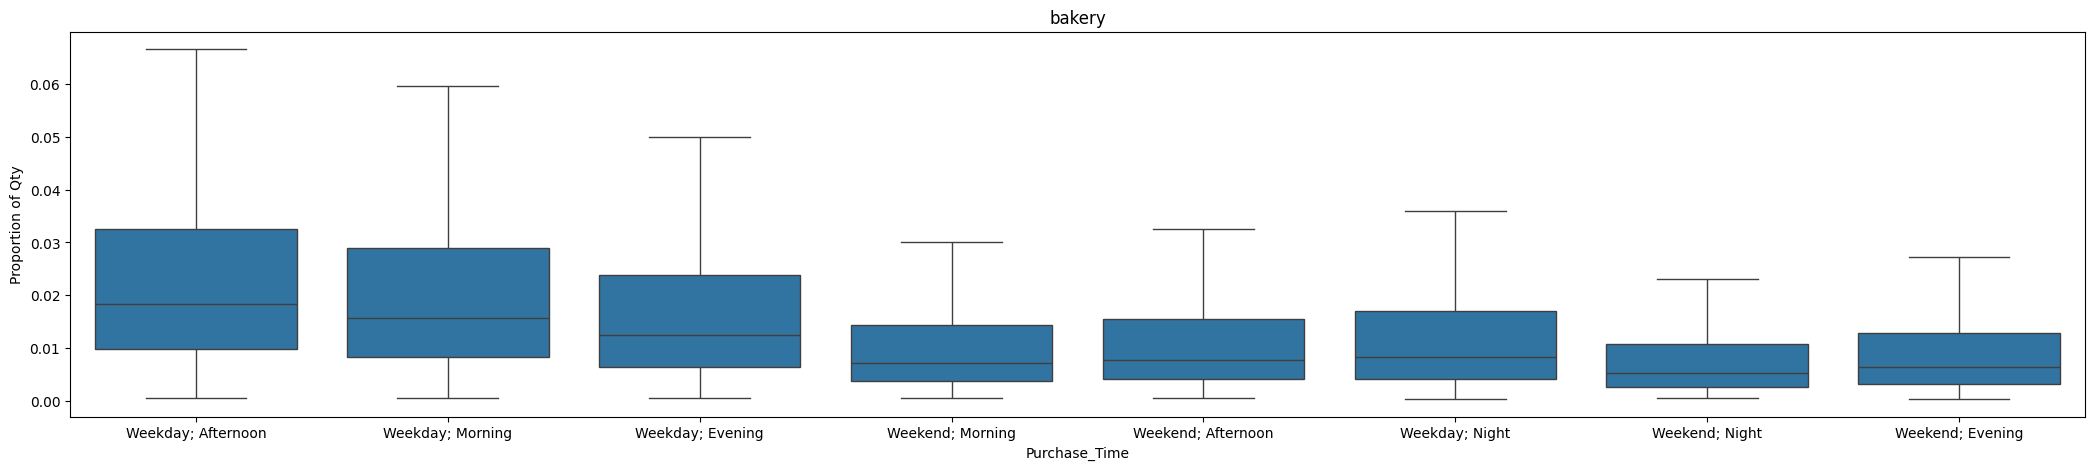

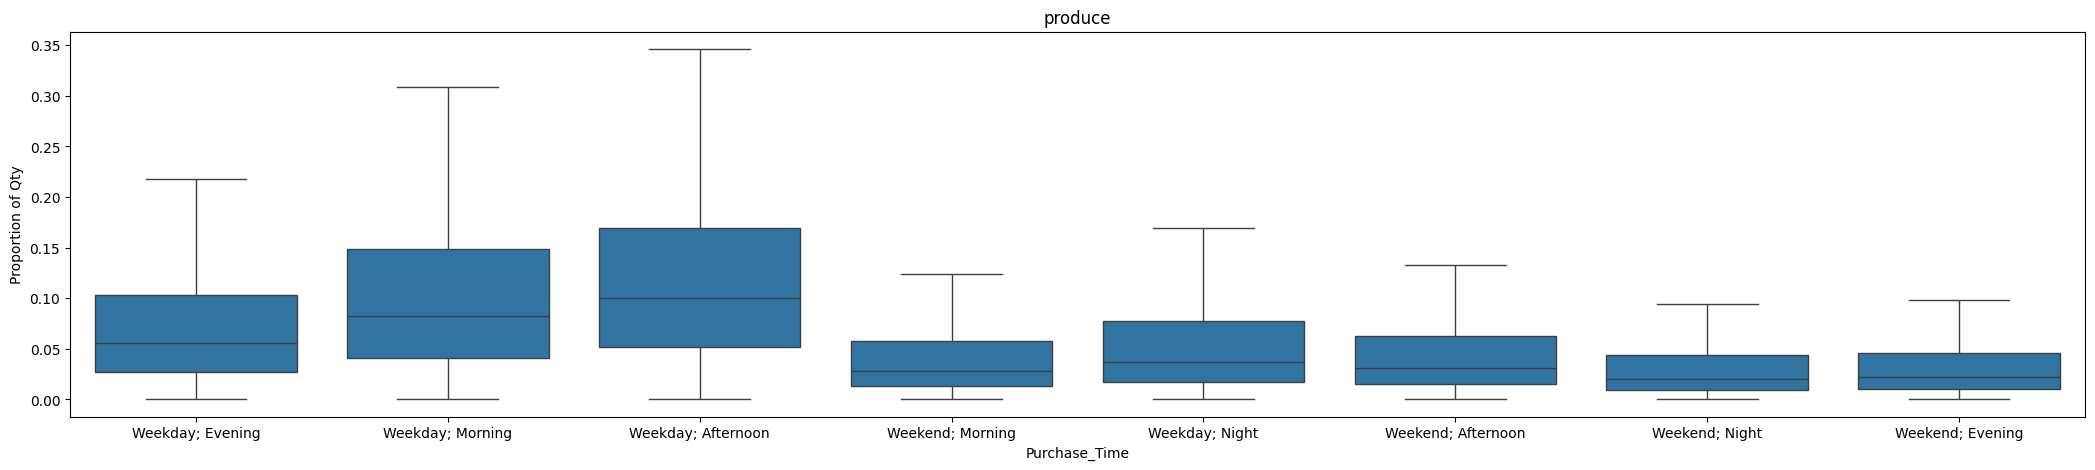

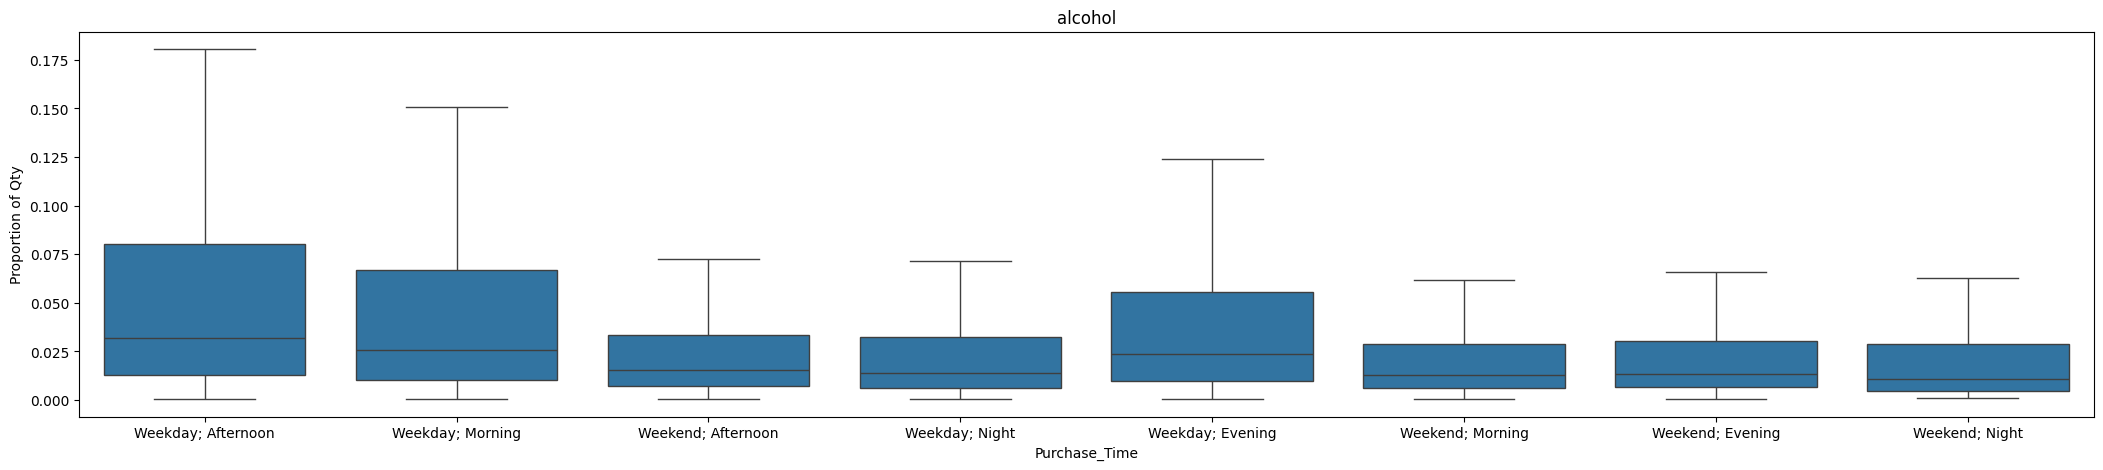

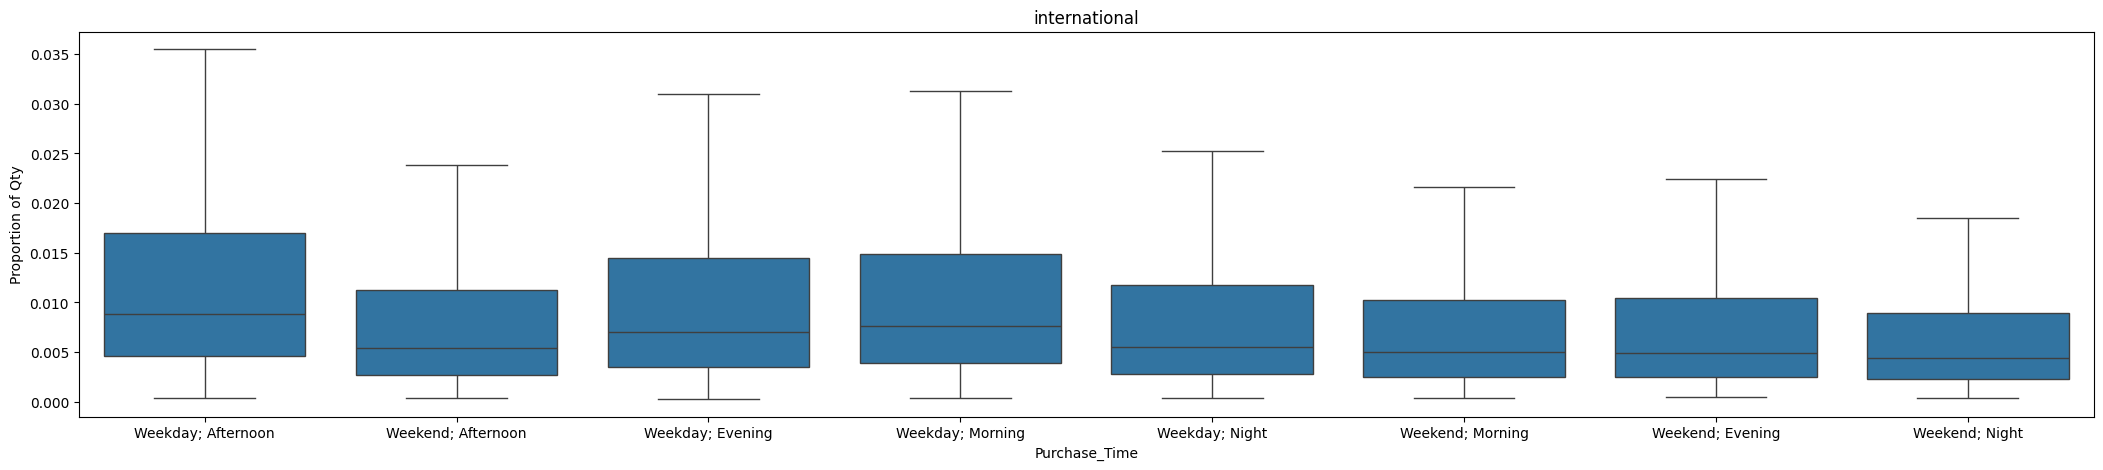

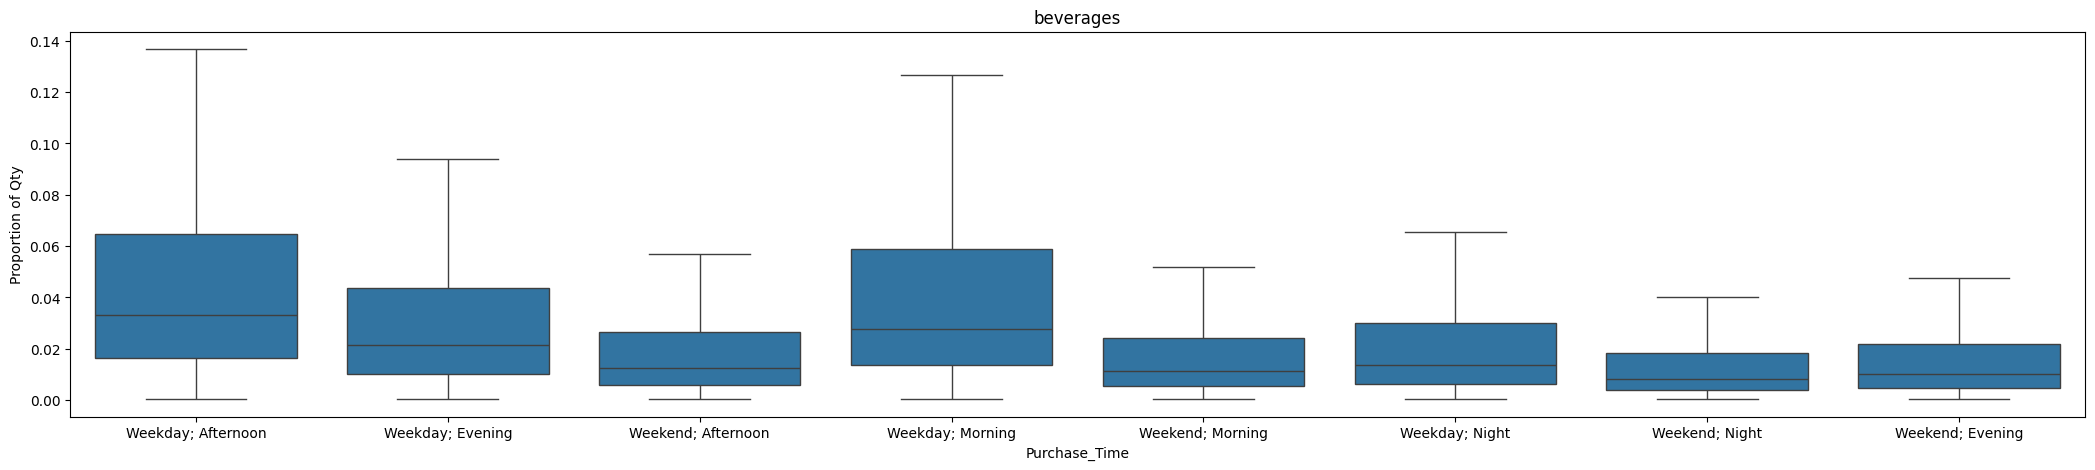

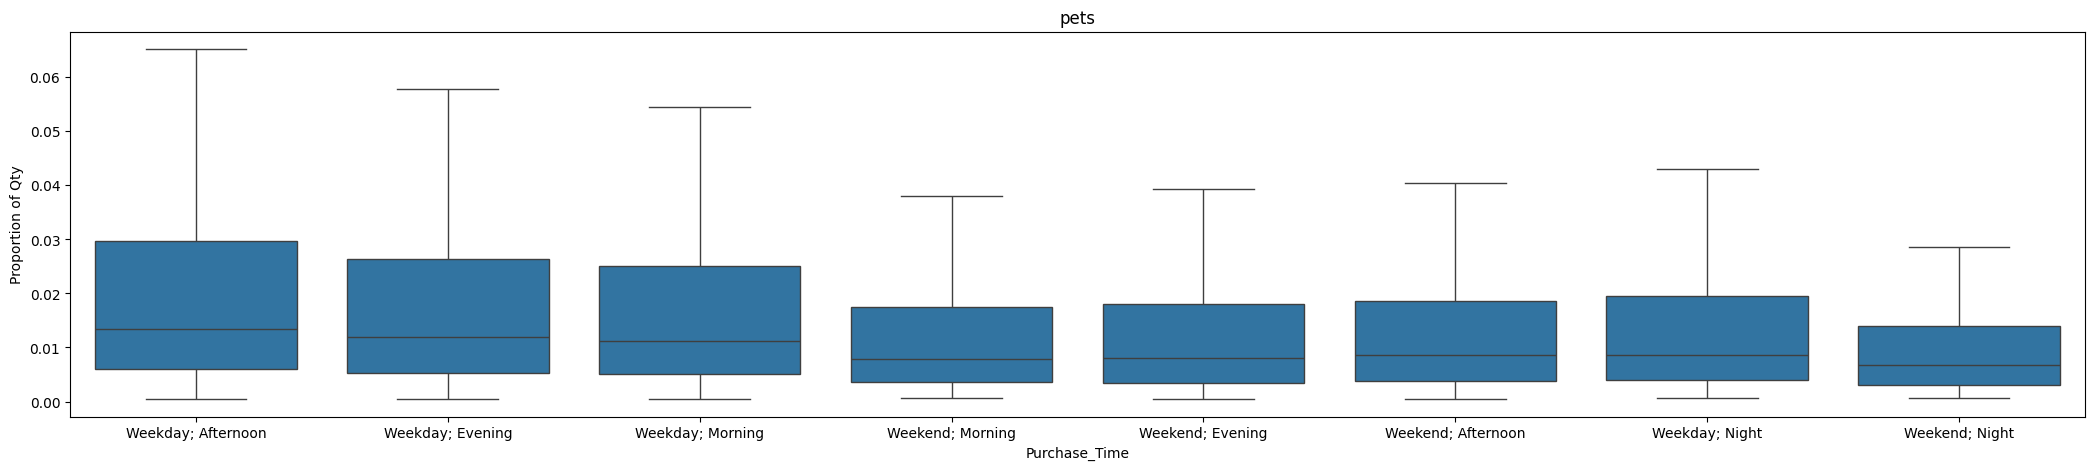

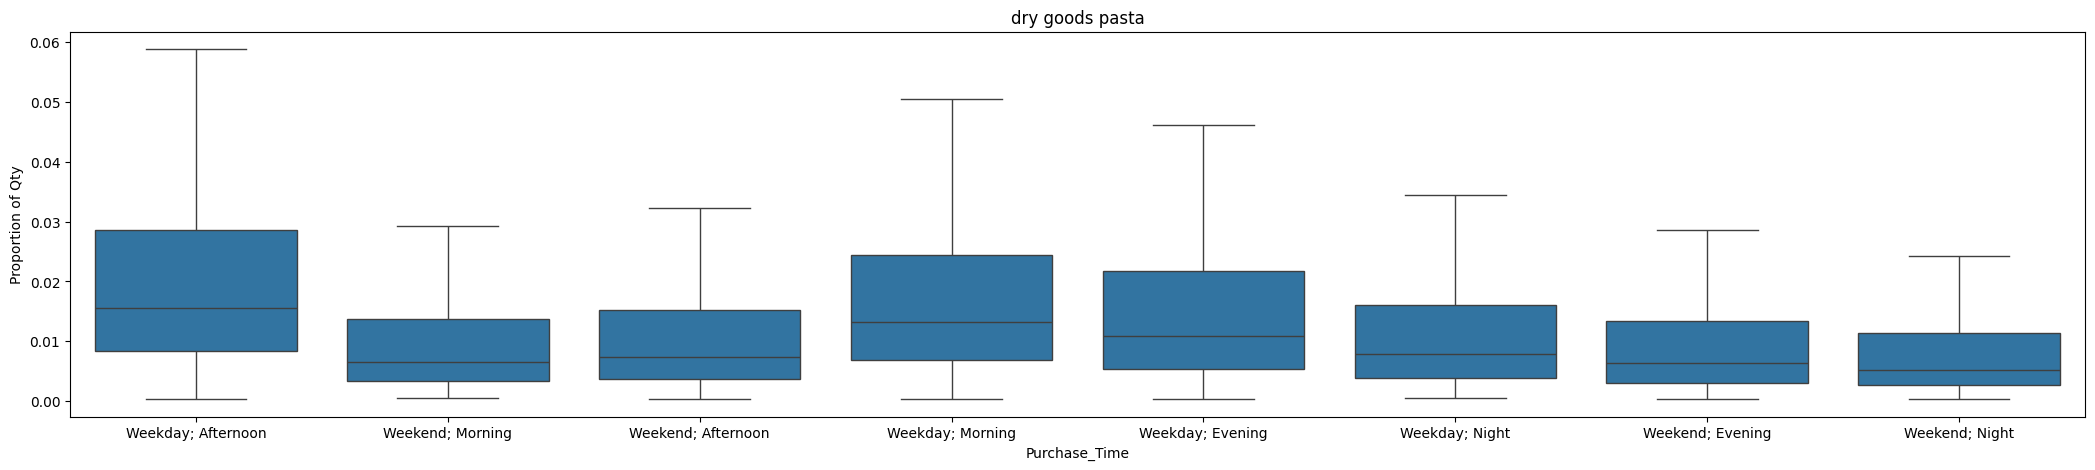

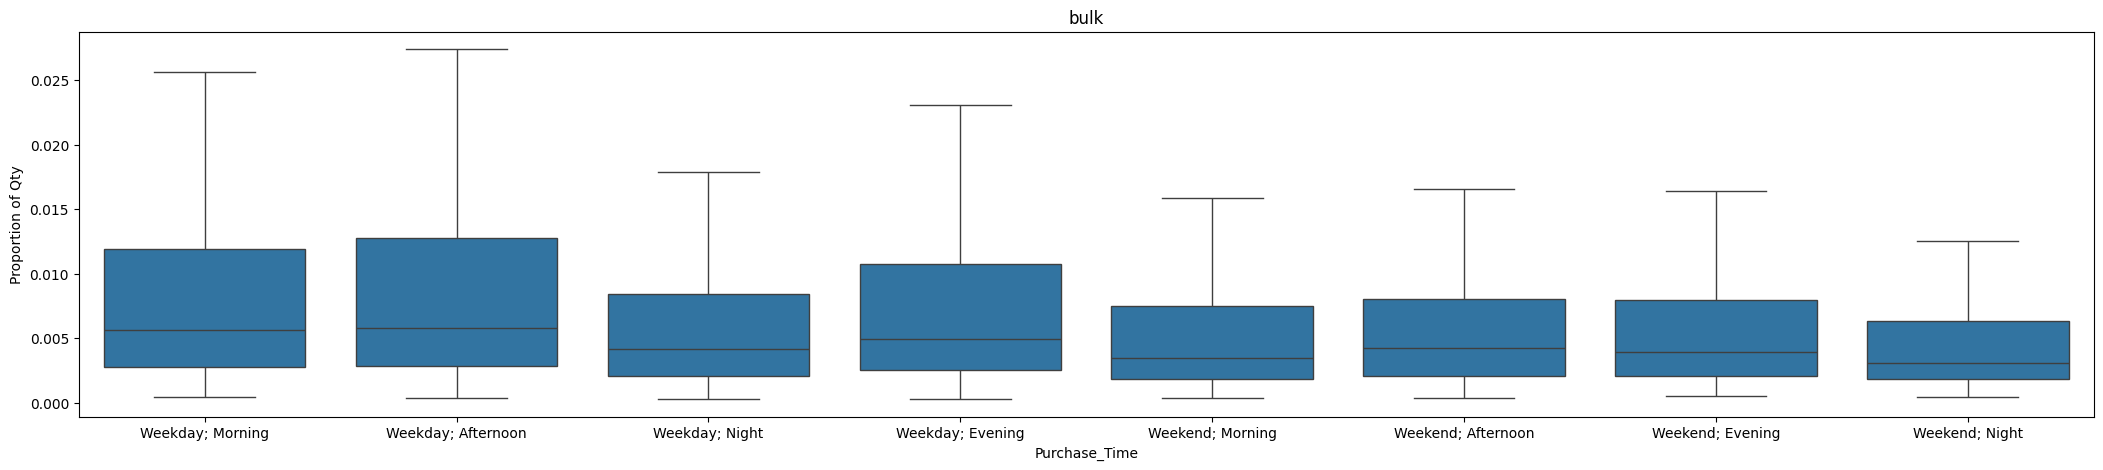

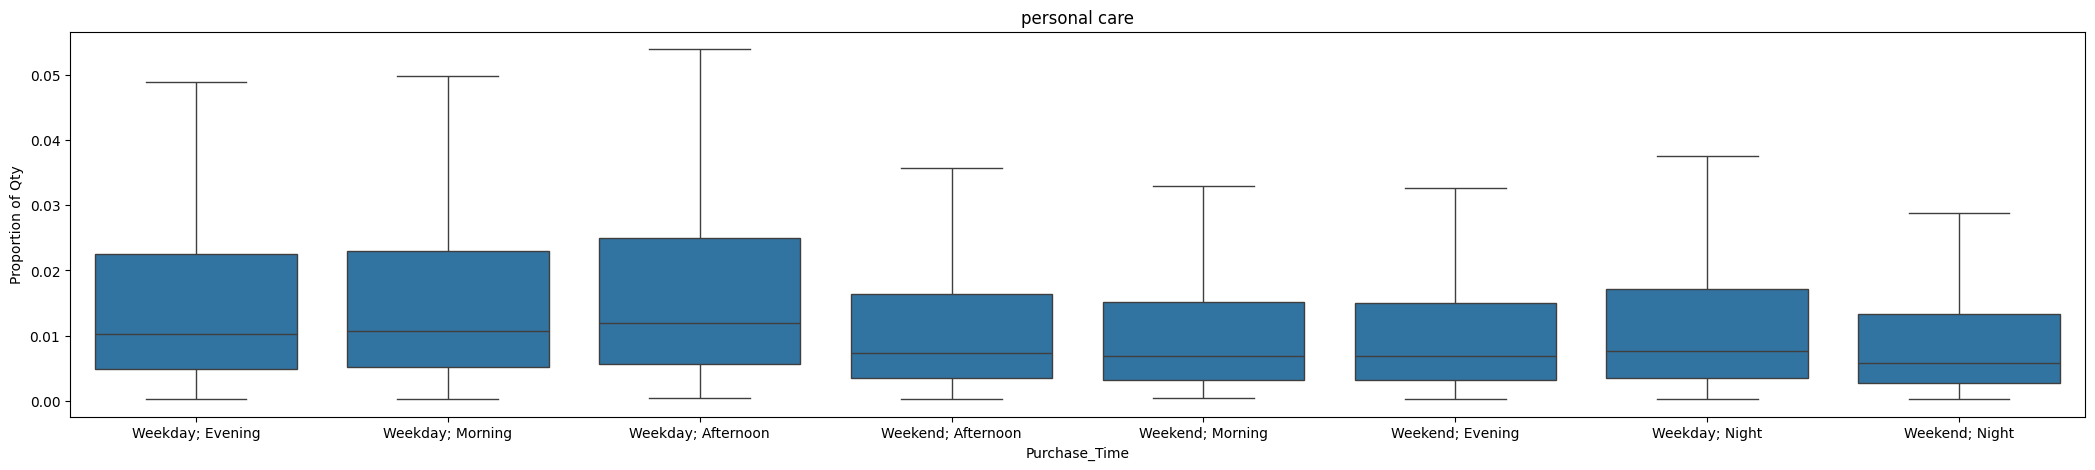

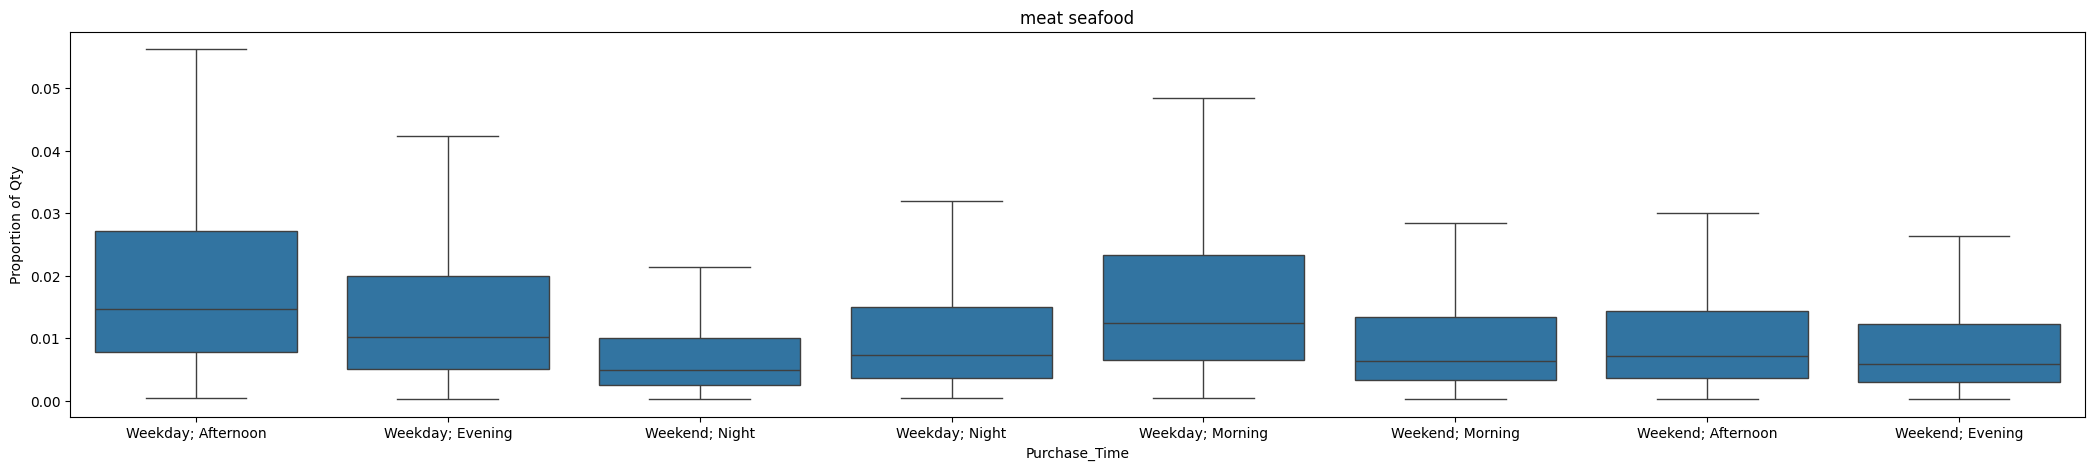

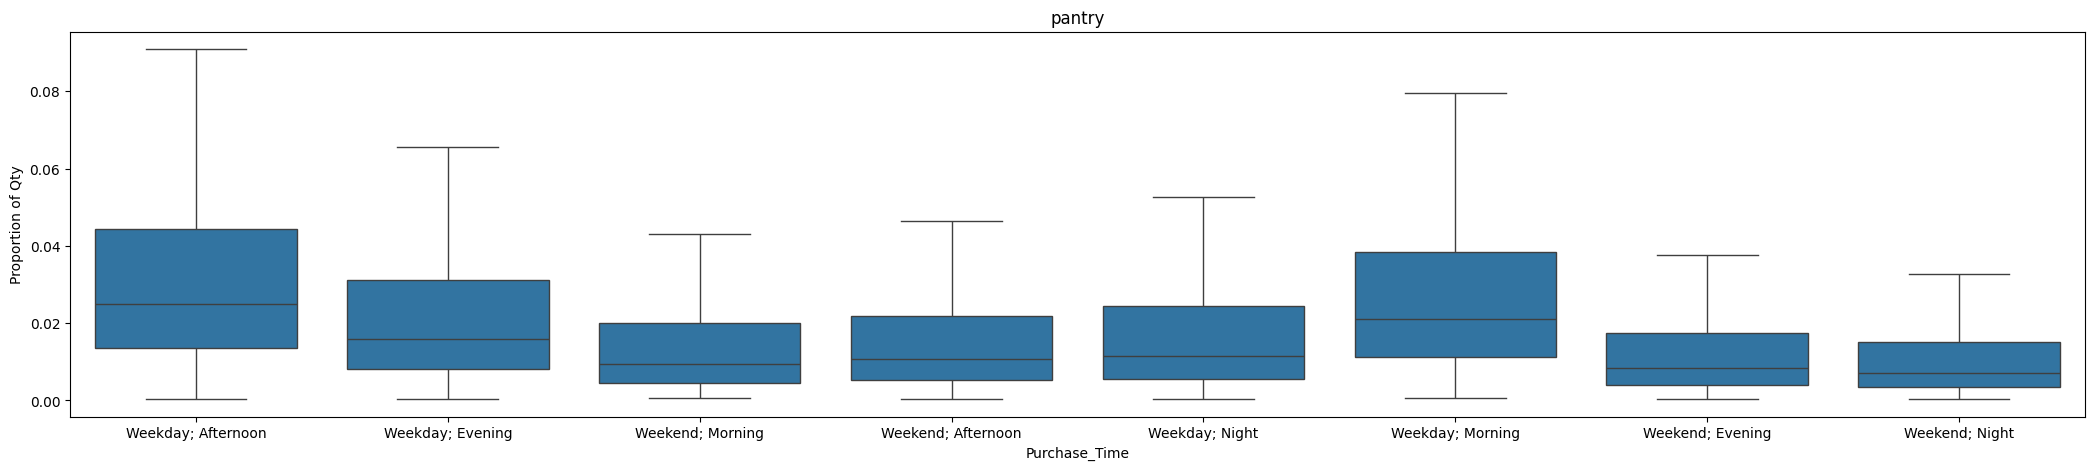

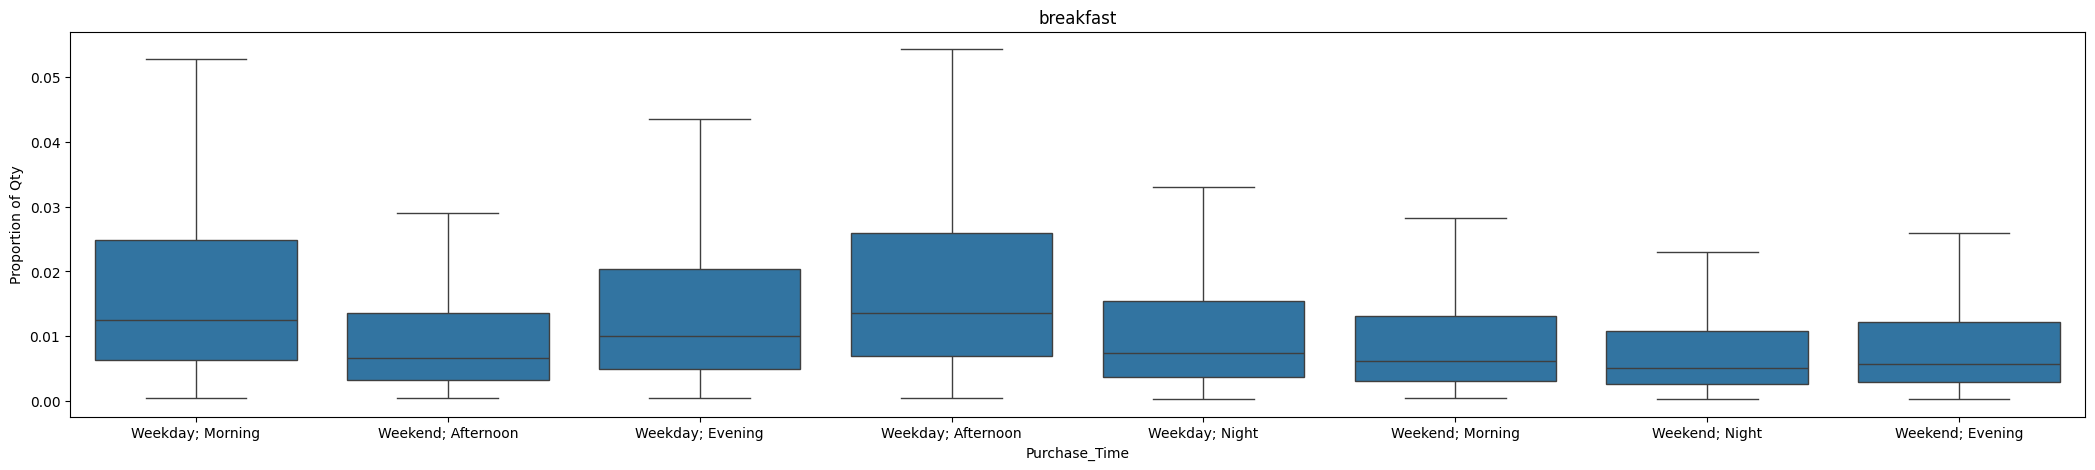

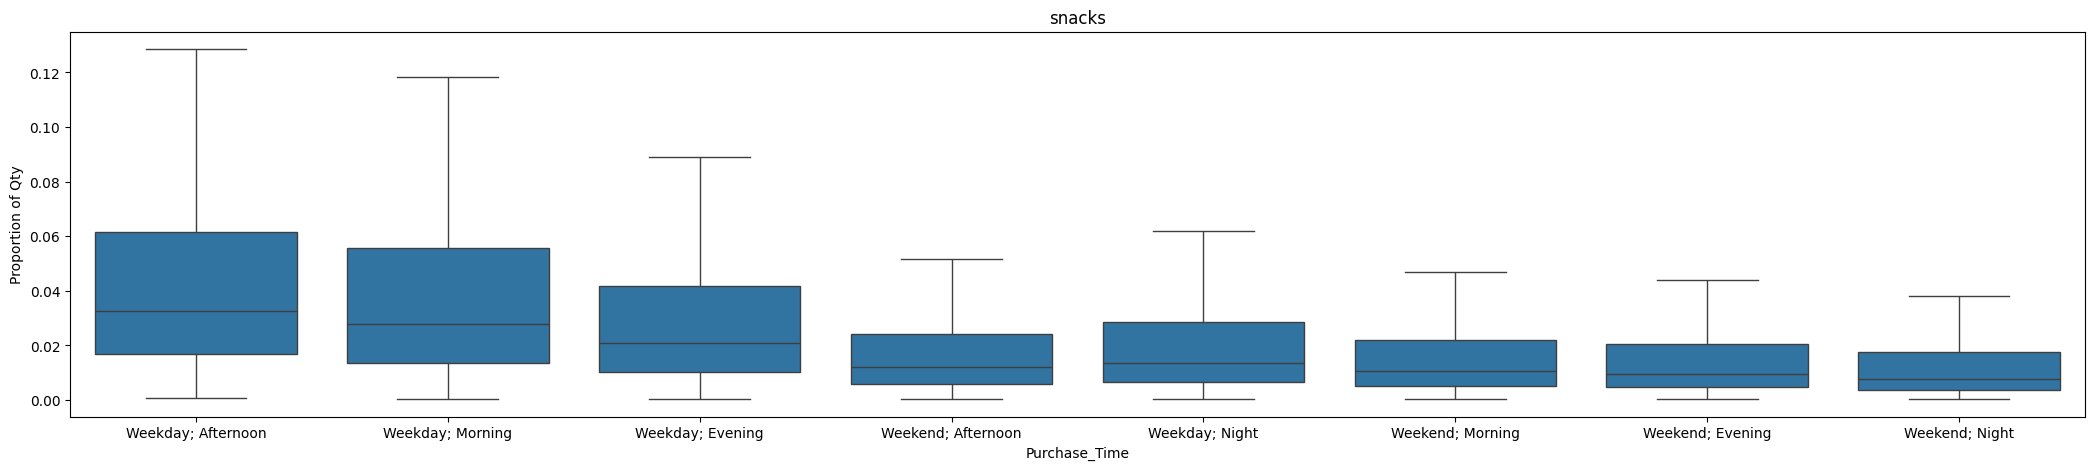

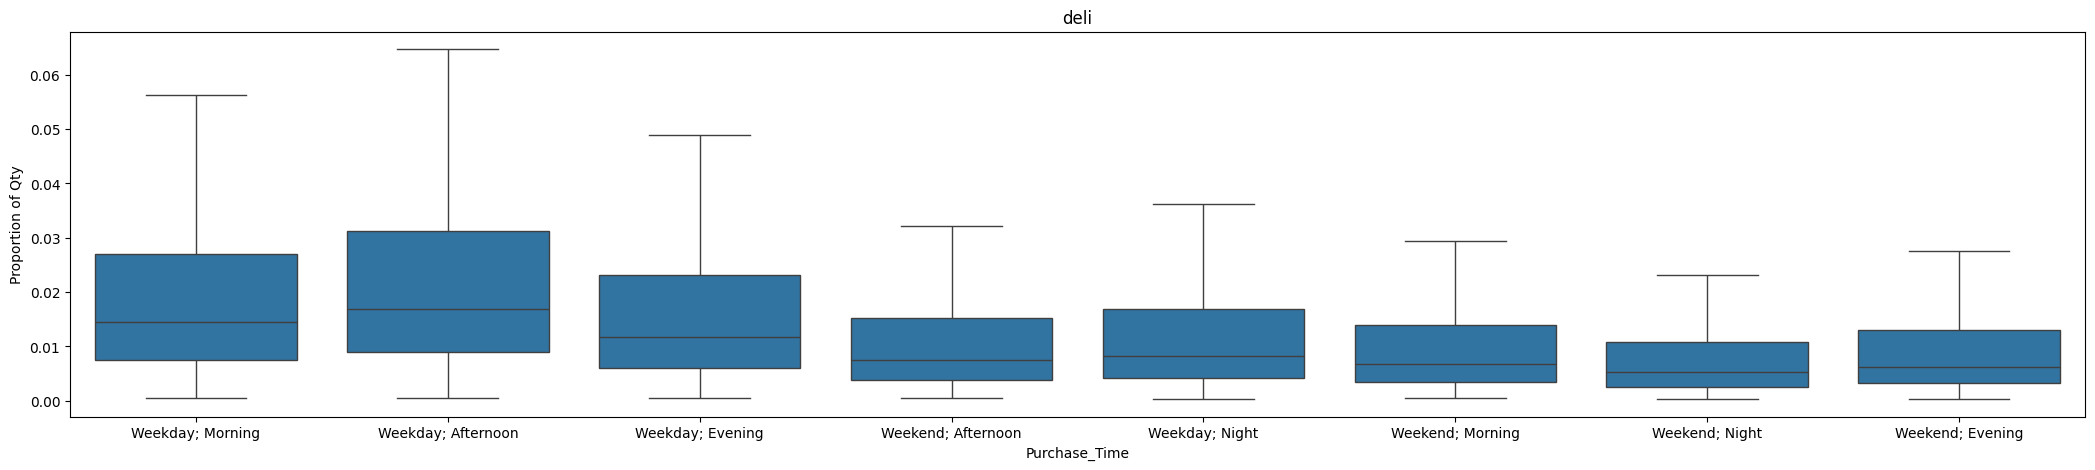

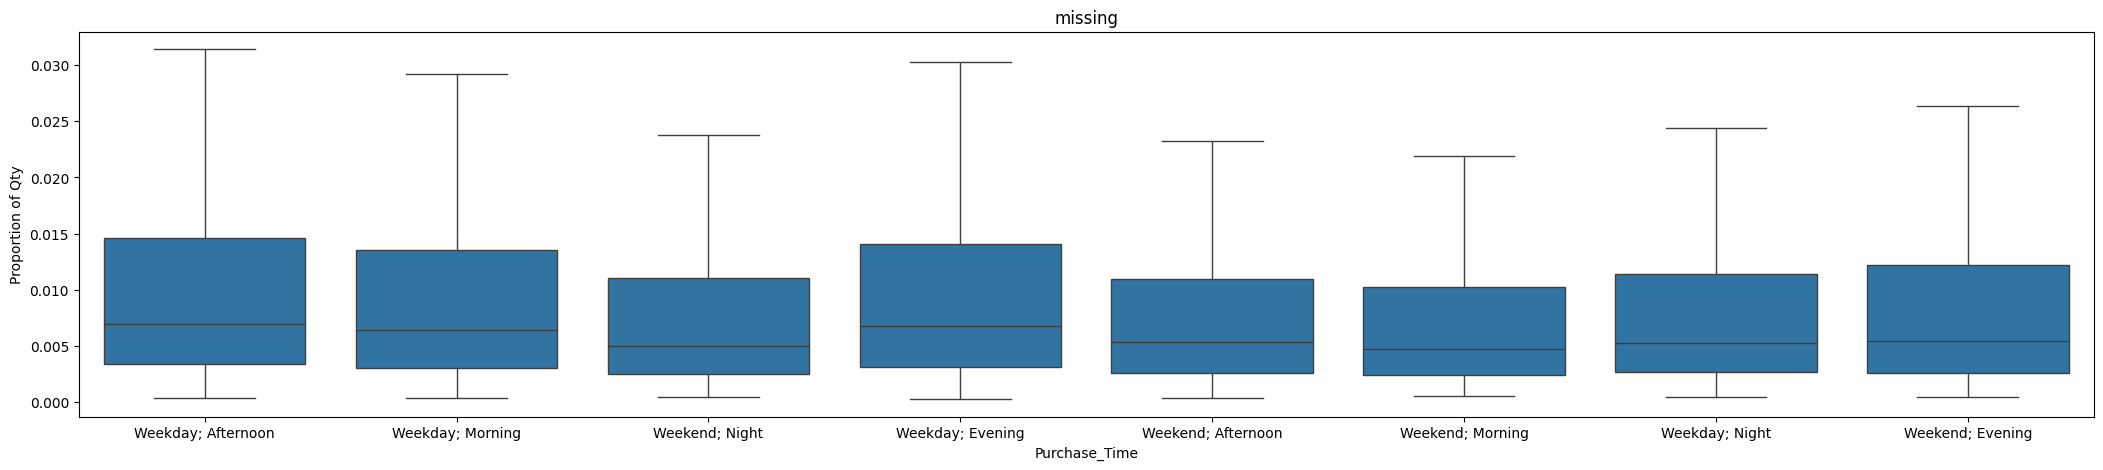

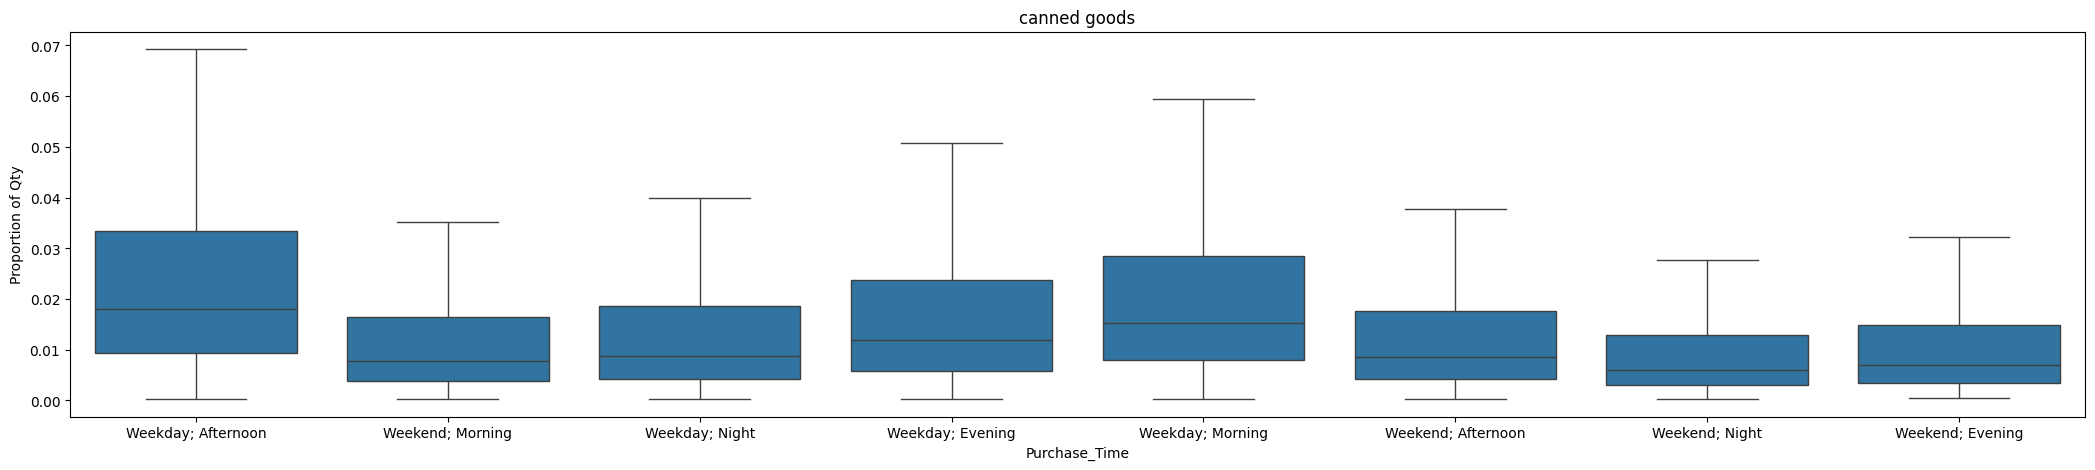

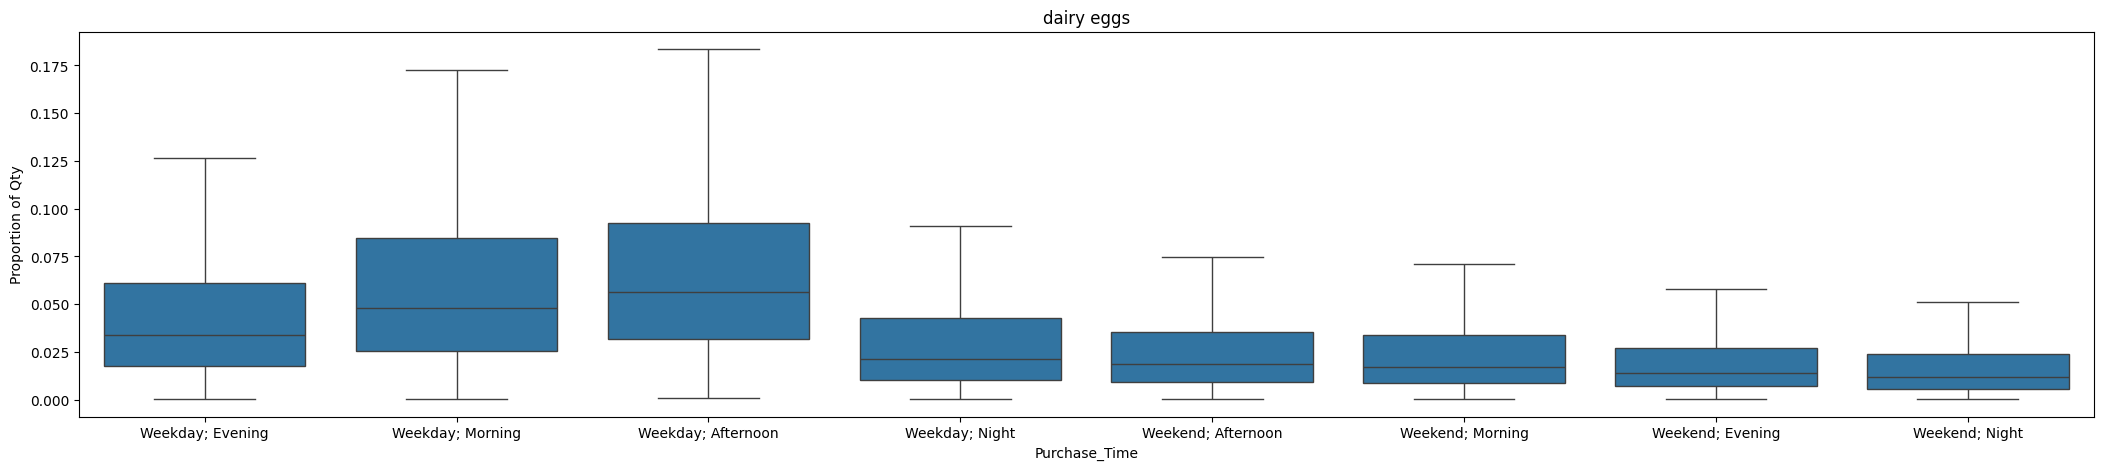

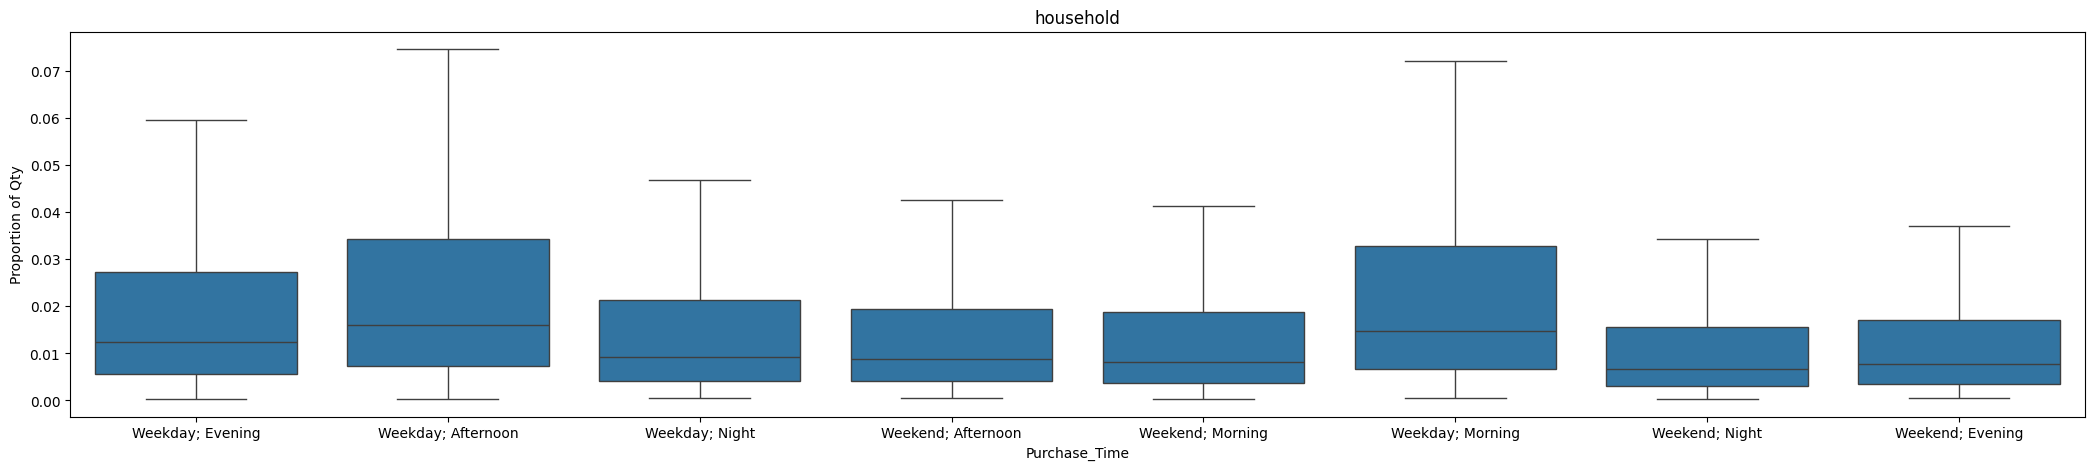

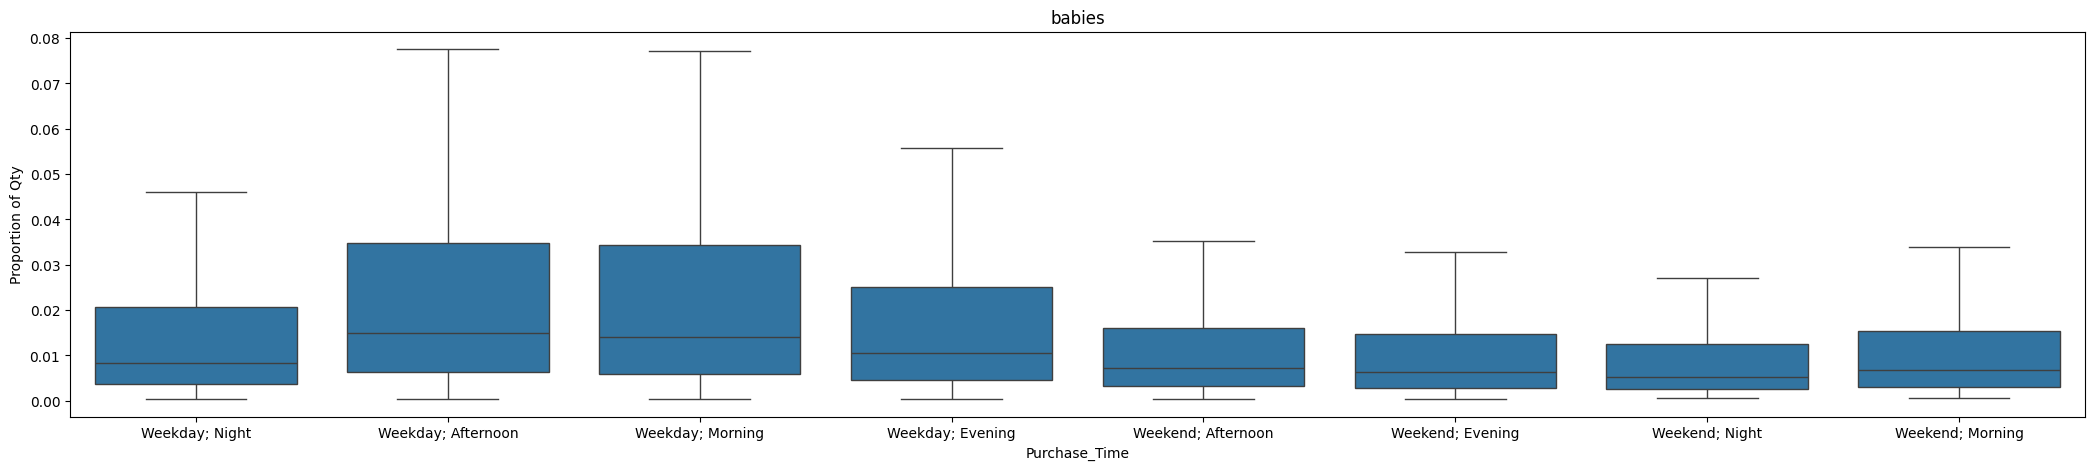

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

for i in user_tow_deptname_mix_df['department'].unique():
  plt.figure(figsize=(26,5))
  sns.boxplot(x='time_of_purchase', y='mix', data=user_tow_deptname_mix_df.loc[user_tow_deptname_mix_df['department'] == i], showfliers = False)
  plt.title(i)
  plt.xlabel("Purchase_Time")
  plt.ylabel("Proportion of Qty")
  plt.show()

Consistent across the different time of purchase, on average, a higher proportion of the purchases were from the produce department followed by the dairy eggs department. Customers might be purchasing such items through Instacart to have them delivered home, reducing the hassle.

There exists the presence of 'Missing' and 'Others' department in the data. The proportion of purchase from these categories are low on average as well. We shall remove these 2 departments from the clustering data as they might not be helpful in understanding the customers.

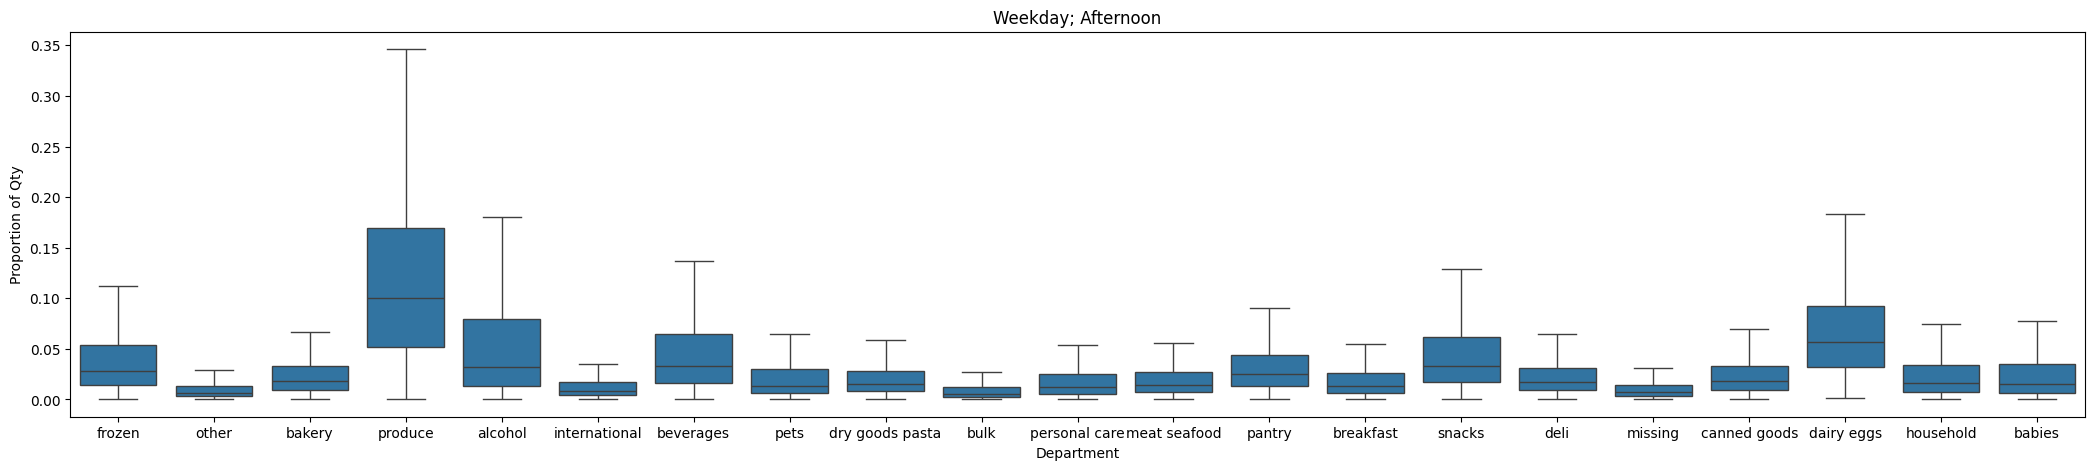

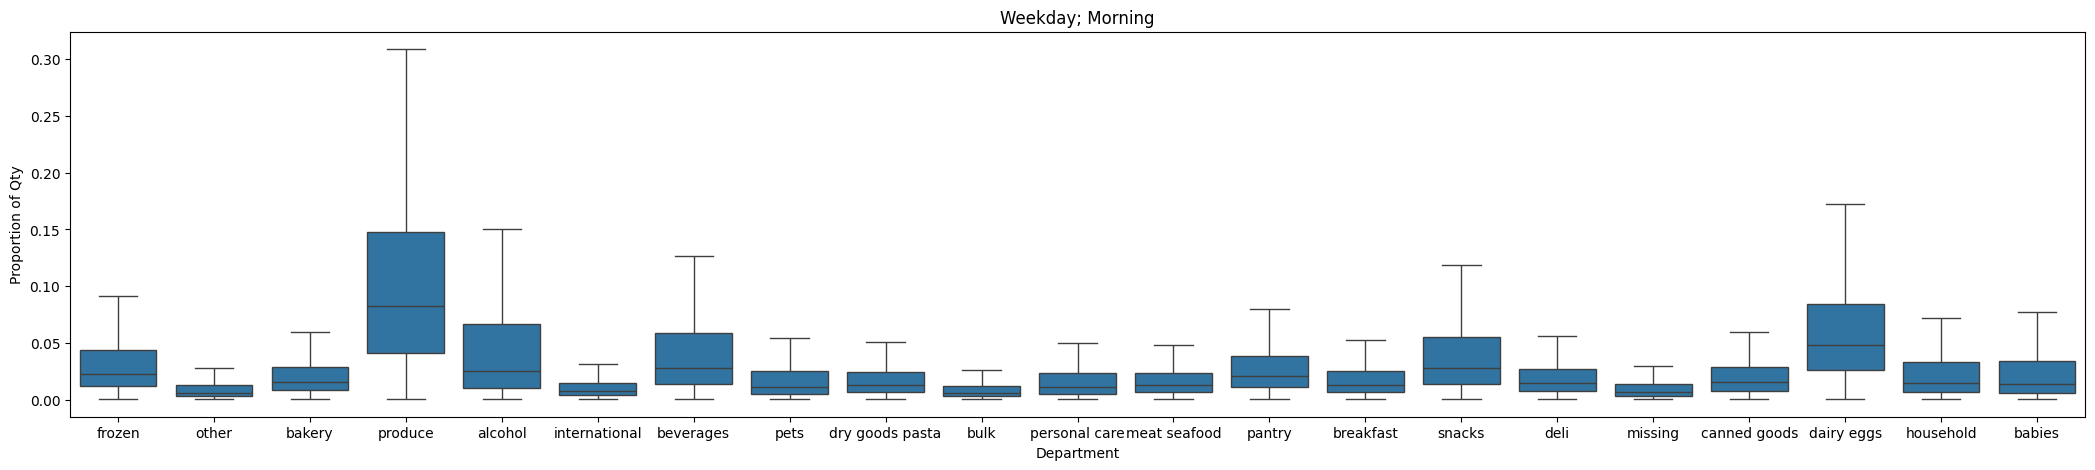

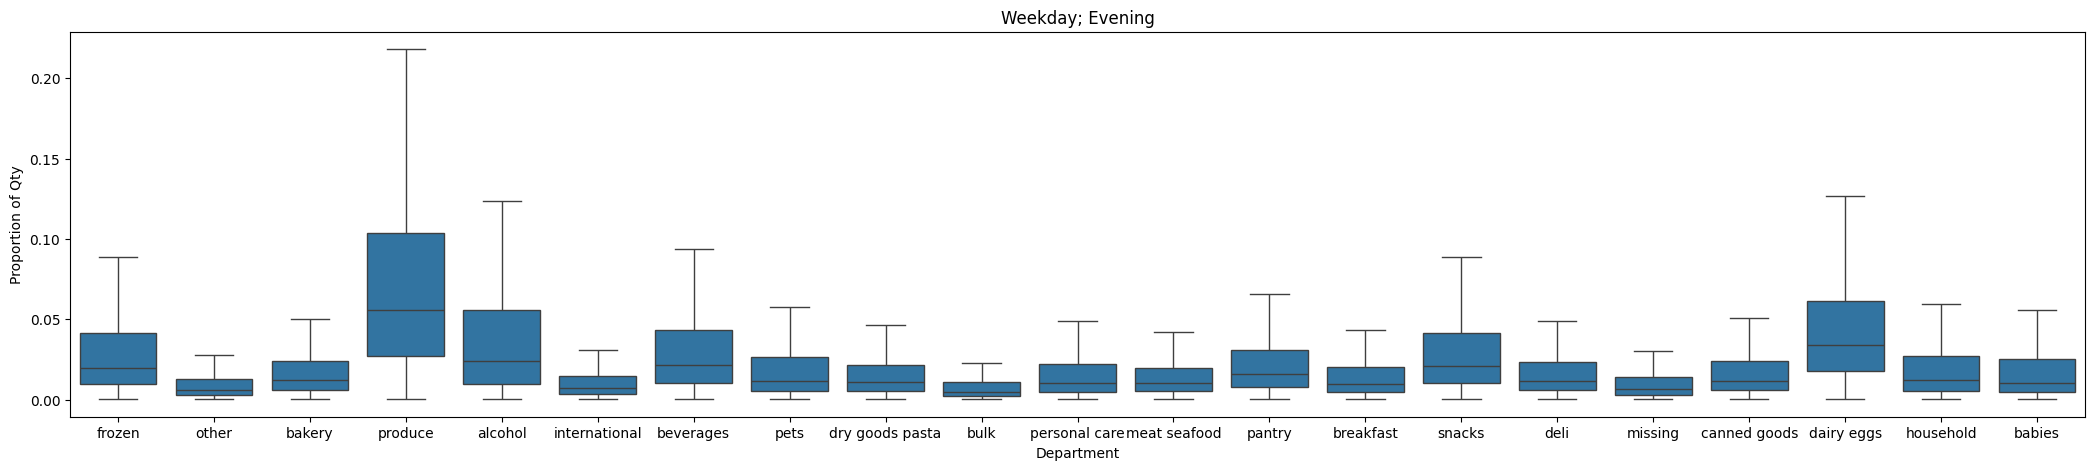

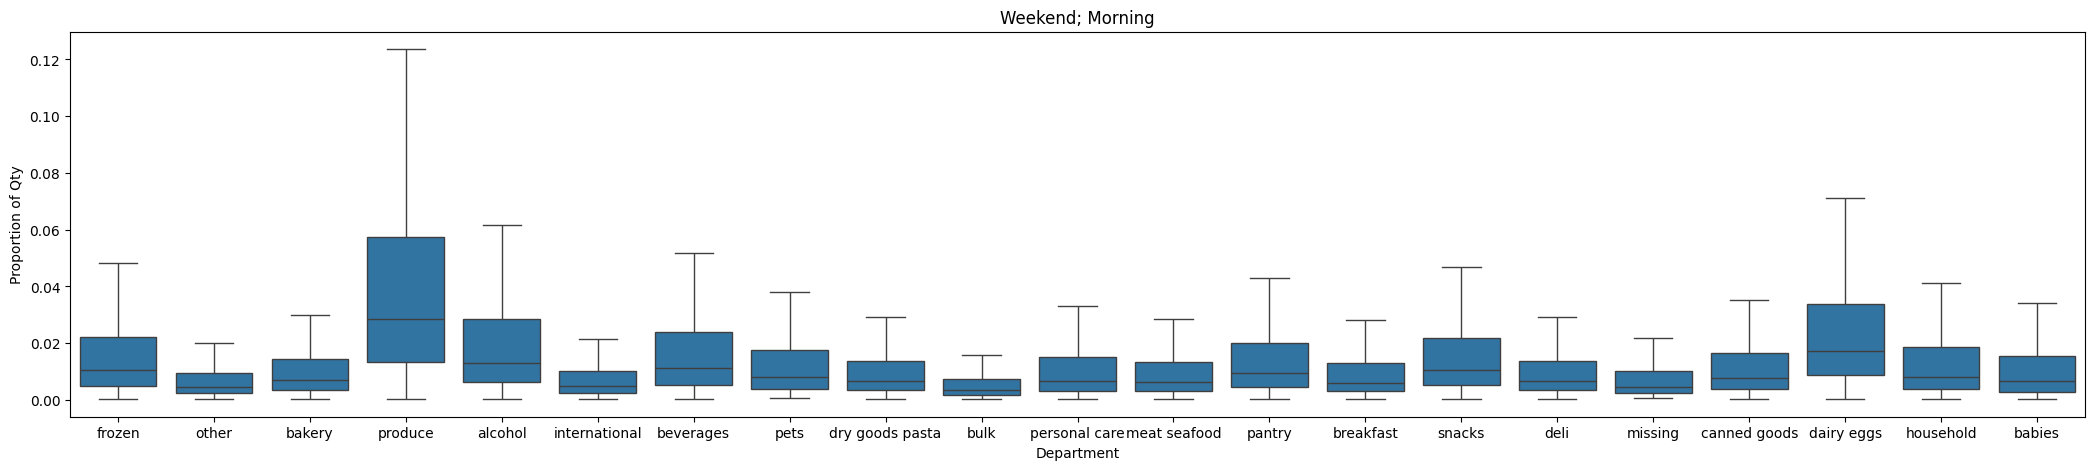

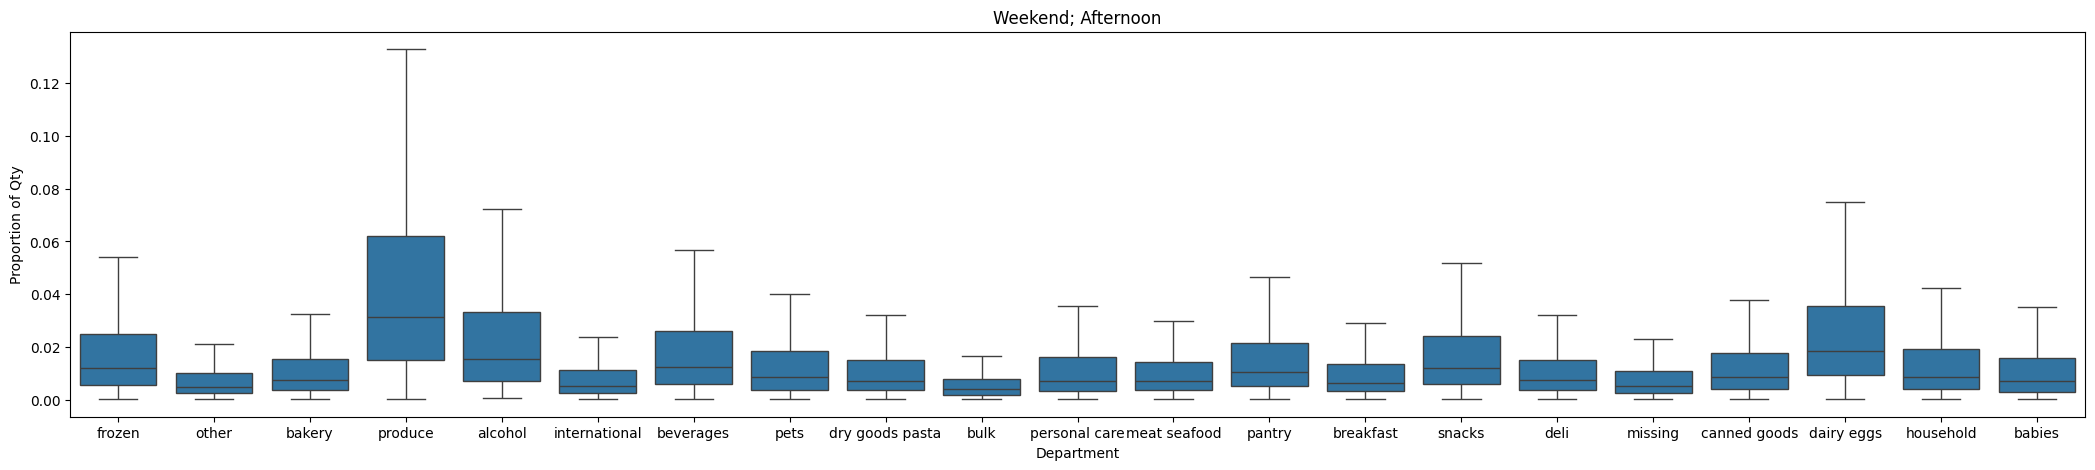

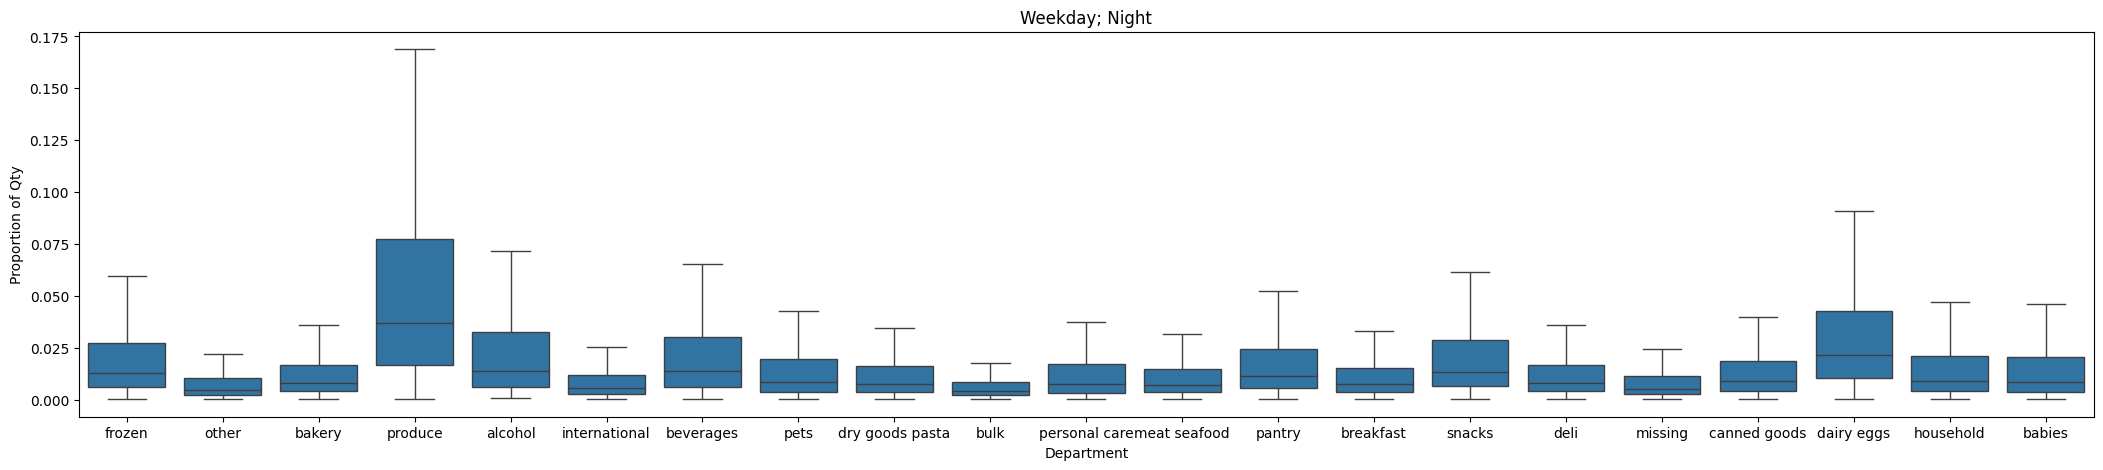

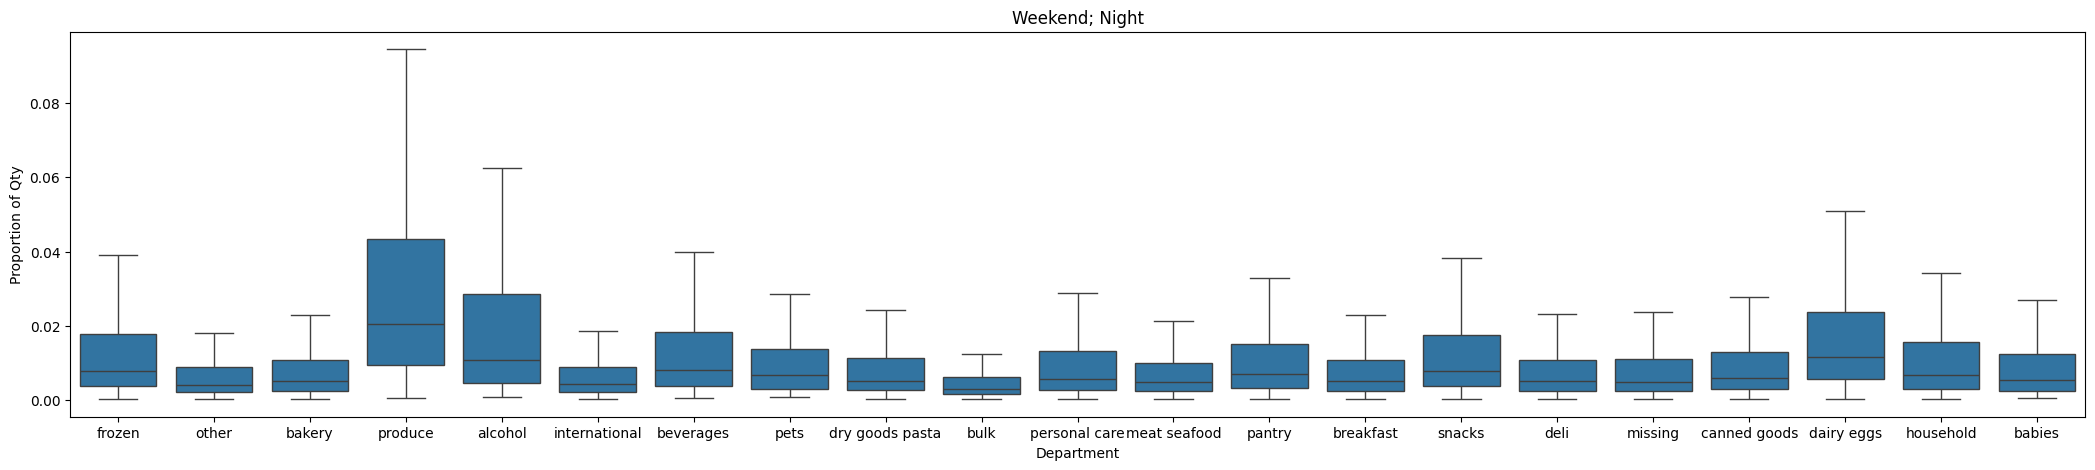

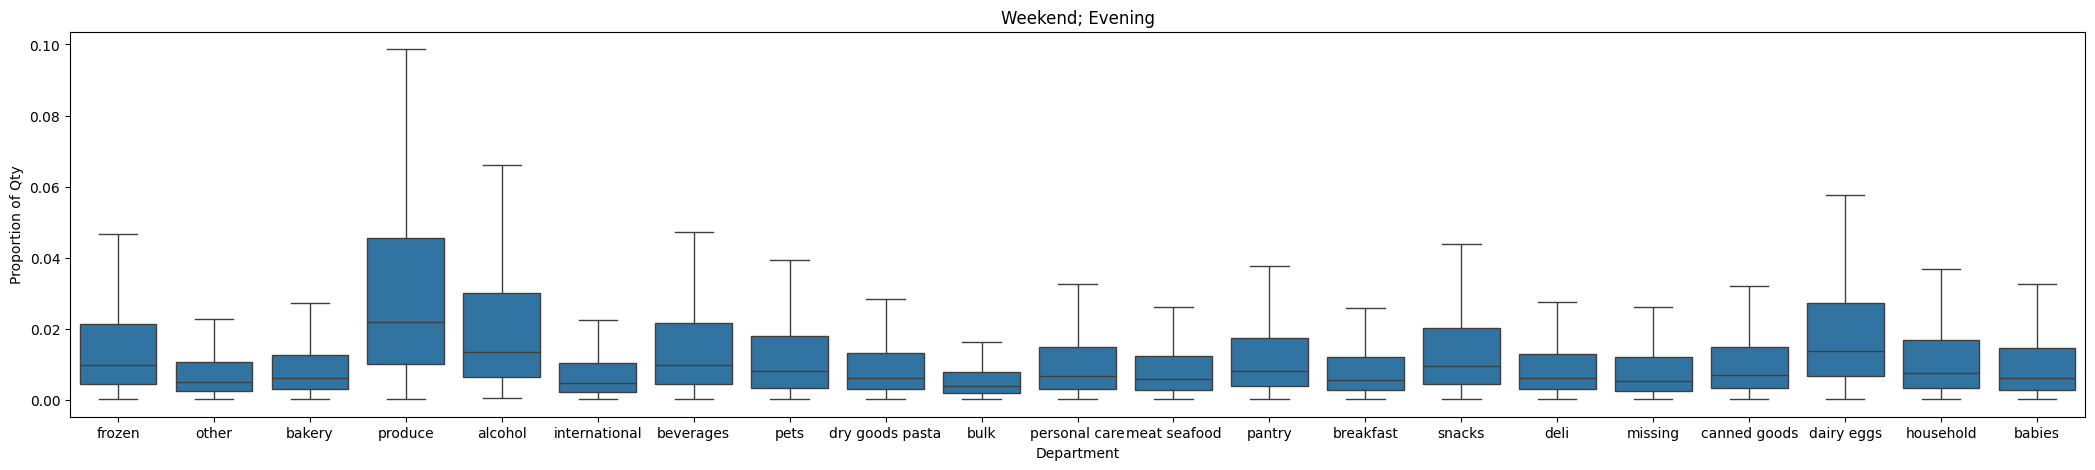

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

for i in user_tow_deptname_mix_df['time_of_purchase'].unique():
  plt.figure(figsize=(26,5))
  sns.boxplot(x='department', y='mix', data=user_tow_deptname_mix_df.loc[user_tow_deptname_mix_df['time_of_purchase'] == i], showfliers = False)
  plt.title(i)
  plt.xlabel("Department")
  plt.ylabel("Proportion of Qty")
  plt.show()

In [ ]:
user_tow_deptname_mix_df = user_tow_deptname_mix_df[(user_tow_deptname_mix_df['department'] != 'missing') & (user_tow_deptname_mix_df['department'] != 'other')]
user_tow_deptname_mix_pivot = user_tow_deptname_mix_df.pivot(index = 'user_id', columns = ['dept_purchase_time'], values = 'mix').fillna(0)
user_tow_deptname_mix_pivot.head()

dept_purchase_time  Weekday; Afternoon; alcohol  Weekday; Afternoon; babies  \
user_id                                                                       
1                                      0.000000                         0.0   
2                                      0.000000                         0.0   
3                                      0.000000                         0.0   
4                                      0.055556                         0.0   
5                                      0.000000                         0.0   

dept_purchase_time  Weekday; Afternoon; bakery  Weekday; Afternoon; beverages  \
user_id                                                                         
1                                     0.000000                       0.101695   
2                                     0.000000                       0.015385   
3                                     0.000000                       0.022727   
4                                     0.055556                       0.111111   
5                                     0.000000                       0.000000   

dept_purchase_time  Weekday; Afternoon; breakfast  Weekday; Afternoon; bulk  \
user_id                                                                       
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

dept_purchase_time  Weekday; Afternoon; canned goods  \
user_id                                                
1                                           0.000000   
2                                           0.000000   
3                                           0.000000   
4                                           0.055556   
5                                           0.000000   

dept_purchase_time  Weekday; Afternoon; dairy eggs  Weekday; Afternoon; deli  \
user_id                                                                        
1                                         0.101695                  0.000000   
2                                         0.030769                  0.010256   
3                                         0.113636                  0.011364   
4                                         0.000000                  0.111111   
5                                         0.108108                  0.000000   

dept_purchase_time  Weekday; Afternoon; dry goods pasta  ...  \
user_id                                                  ...   
1                                              0.000000  ...   
2                                              0.000000  ...   
3                                              0.034091  ...   
4                                              0.000000  ...   
5                                              0.027027  ...   

dept_purchase_time  Weekend; Night; dry goods pasta  Weekend; Night; frozen  \
user_id                                                                       
1                                               0.0                     0.0   
2                                               0.0                     0.0   
3                                               0.0                     0.0   
4                                               0.0                     0.0   
5                                               0.0                     0.0   

dept_purchase_time  Weekend; Night; household  Weekend; Night; international  \
user_id                                                                        
1                                         0.0                            0.0   
2                                         0.0                            0.0   
3                                         0.0  

Perform KMeans for different values of k.

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np

user_tow_deptname_mix_np = user_tow_deptname_mix_pivot.to_numpy()
user_tow_deptname_mix_np_norm = preprocessing.normalize(user_tow_deptname_mix_np)

score = []
k = []
for i in tqdm(range(2,30)):
  print(i)
  user_tow_deptname_cluster_model = KMeans(n_clusters=i, init='k-means++').fit(user_tow_deptname_mix_np_norm)
  k.append(i)
  score.append(user_tow_deptname_cluster_model.inertia_)

  0%|          | 0/28 [00:00<?, ?it/s]

2


  4%|▎         | 1/28 [00:40<18:18, 40.70s/it]

3


  7%|▋         | 2/28 [01:05<13:36, 31.42s/it]

4


 11%|█         | 3/28 [01:30<11:54, 28.60s/it]

5


 14%|█▍        | 4/28 [02:35<17:07, 42.82s/it]

6


 18%|█▊        | 5/28 [04:22<25:20, 66.10s/it]

7


 21%|██▏       | 6/28 [05:50<26:51, 73.26s/it]

8


 25%|██▌       | 7/28 [07:10<26:29, 75.69s/it]

9


 29%|██▊       | 8/28 [08:35<26:09, 78.46s/it]

10


 32%|███▏      | 9/28 [09:50<24:32, 77.50s/it]

11


 36%|███▌      | 10/28 [11:45<26:43, 89.08s/it]

12


 39%|███▉      | 11/28 [13:23<26:02, 91.93s/it]

13


 43%|████▎     | 12/28 [15:09<25:36, 96.03s/it]

14


 46%|████▋     | 13/28 [16:45<24:02, 96.16s/it]

15


 50%|█████     | 14/28 [18:41<23:49, 102.13s/it]

16


 54%|█████▎    | 15/28 [20:16<21:39, 99.97s/it] 

17


 57%|█████▋    | 16/28 [22:12<20:56, 104.69s/it]

18


 61%|██████    | 17/28 [24:08<19:51, 108.27s/it]

19


 64%|██████▍   | 18/28 [26:13<18:52, 113.27s/it]

20


 68%|██████▊   | 19/28 [28:08<17:02, 113.63s/it]

21


 71%|███████▏  | 20/28 [30:33<16:23, 122.99s/it]

22


 75%|███████▌  | 21/28 [33:02<15:15, 130.79s/it]

23


 79%|███████▊  | 22/28 [35:26<13:30, 135.04s/it]

24


 82%|████████▏ | 23/28 [38:09<11:57, 143.40s/it]

25


 86%|████████▌ | 24/28 [41:10<10:18, 154.69s/it]

26


 89%|████████▉ | 25/28 [44:14<08:09, 163.28s/it]

27


 93%|█████████▎| 26/28 [47:04<05:30, 165.44s/it]

28


 96%|█████████▋| 27/28 [50:47<03:02, 182.65s/it]

29


100%|██████████| 28/28 [54:39<00:00, 117.13s/it]


The first chart below contains the elbow curve which shows the within cluster sum of squared errors for the various cluster number. The second chart shows the change in the within cluster sum of squared errors as k increases.

Both chart indicates that at k = 20, the decline in within cluster sum of squared errors starts to slow down and thus we will be running k means at k = 20.

Text(0.5, 1.0, 'Elbow curve')

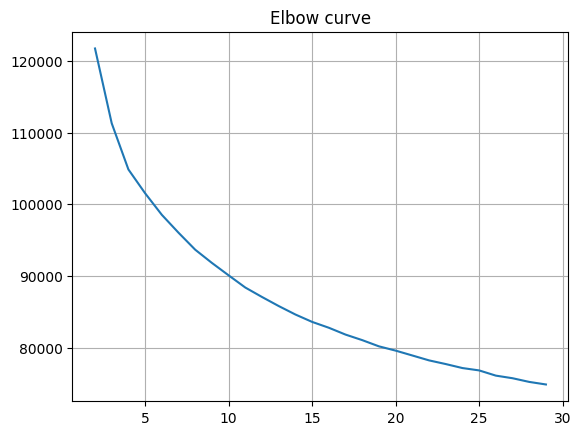

In [ ]:
from matplotlib import pyplot as plt

plt.plot(k, score)
plt.grid(True)
plt.title('Elbow curve')

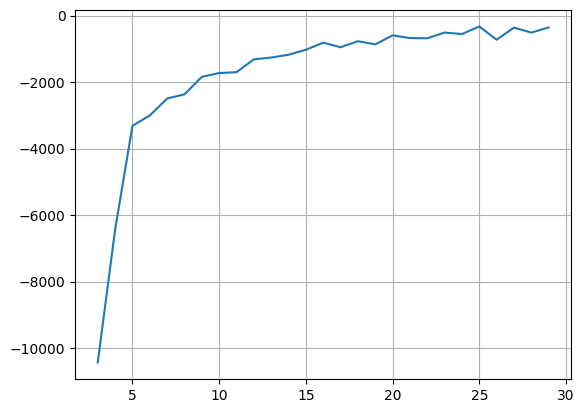

In [ ]:
diff = []
for i in range(len(score)-1):
  diff.append(score[i+1] - score[i])

plt.plot(k[1:], diff)
plt.grid(True)

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

user_tow_deptname_mix_np = user_tow_deptname_mix_pivot
user_tow_deptname_mix_np_norm = preprocessing.normalize(user_tow_deptname_mix_pivot)
user_tow_deptname_k = 20
user_tow_deptname_cluster_kmeans = KMeans(n_clusters=user_tow_deptname_k, init='k-means++').fit(user_tow_deptname_mix_np_norm)
user_tow_deptname_results_kmeans = user_tow_deptname_cluster_kmeans.labels_
user_tow_deptname_mix_pivot['cluster_kmeans'] = user_tow_deptname_results_kmeans

In [ ]:
user_tow_deptname_mix_pivot.reset_index(drop = False).to_csv('/content/drive/MyDrive/CS5344_checkpoint/user_tow_deptname_mix_pivot_cluster.csv', index = False)

In [ ]:
user_tow_deptname_mix_pivot = pd.read_csv('user_tow_deptname_mix_pivot_cluster.csv')

In [ ]:
user_tow_deptname_mix_pivot.head()

dept_purchase_time  Weekday; Afternoon; alcohol  Weekday; Afternoon; babies  \
user_id                                                                       
1                                      0.000000                         0.0   
2                                      0.000000                         0.0   
3                                      0.000000                         0.0   
4                                      0.055556                         0.0   
5                                      0.000000                         0.0   

dept_purchase_time  Weekday; Afternoon; bakery  Weekday; Afternoon; beverages  \
user_id                                                                         
1                                     0.000000                       0.101695   
2                                     0.000000                       0.015385   
3                                     0.000000                       0.022727   
4                                     0.055556                       0.111111   
5                                     0.000000                       0.000000   

dept_purchase_time  Weekday; Afternoon; breakfast  Weekday; Afternoon; bulk  \
user_id                                                                       
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

dept_purchase_time  Weekday; Afternoon; canned goods  \
user_id                                                
1                                           0.000000   
2                                           0.000000   
3                                           0.000000   
4                                           0.055556   
5                                           0.000000   

dept_purchase_time  Weekday; Afternoon; dairy eggs  Weekday; Afternoon; deli  \
user_id                                                                        
1                                         0.101695                  0.000000   
2                                         0.030769                  0.010256   
3                                         0.113636                  0.011364   
4                                         0.000000                  0.111111   
5                                         0.108108                  0.000000   

dept_purchase_time  Weekday; Afternoon; dry goods pasta  ...  \
user_id                                                  ...   
1                                              0.000000  ...   
2                                              0.000000  ...   
3                                              0.034091  ...   
4                                              0.000000  ...   
5                                              0.027027  ...   

dept_purchase_time  Weekend; Night; frozen  Weekend; Night; household  \
user_id                                                                 
1                                      0.0                        0.0   
2                                      0.0                        0.0   
3                                      0.0                        0.0   
4                                      0.0                        0.0   
5                                      0.0                        0.0   

dept_purchase_time  Weekend; Night; international  \
user_id                                             
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
5                                             0.0   

dept_purchase_time  Weekend; Night; m

Cluster 12 has the highest proportion of customers, while Cluster 6, 13 and 19 have the least.

In [ ]:
user_tow_deptname_mix_pivot['user_id'] = user_tow_deptname_mix_pivot.index
num_users = user_tow_deptname_mix_pivot.groupby(['cluster_kmeans'])['user_id'].count()
prop_users = round(100 * num_users/user_tow_deptname_mix_pivot.shape[0],1)
user_count = pd.concat([num_users, prop_users], axis=1)
user_count.columns = ['Number of Users', 'Proportion of Users (%)']
user_count

Number of Users  Proportion of Users (%)
cluster_kmeans                                          
0                         12993                      6.3
1                         15795                      7.7
2                          9779                      4.7
3                         16112                      7.8
4                          9093                      4.4
5                         14754                      7.2
6                          5444                      2.6
7                          7317                      3.5
8                          7199                      3.5
9                          7850                      3.8
10                         6587                      3.2
11                         9493                      4.6
12                        21163                     10.3
13                         5776                      2.8
14                         8213                      4.0
15                         7093                      3.4
16                        18421                      8.9
17                        11032                      5.3
18                         6137                      3.0
19                         5958                      2.9

In [ ]:
avg_mix_tow_deptname = user_tow_deptname_mix_pivot.groupby(['cluster_kmeans']).mean()
avg_mix_tow_deptname = avg_mix_tow_deptname.drop('user_id', axis = 1)
avg_mix_tow_deptname

Weekday; Afternoon; alcohol  Weekday; Afternoon; babies  \
cluster_kmeans                                                            
0                                  0.003455                    0.006340   
1                                  0.000781                    0.002352   
2                                  0.001534                    0.002419   
3                                  0.001129                    0.005813   
4                                  0.001438                    0.002595   
5                                  0.000951                    0.002451   
6                                  0.002575                    0.000746   
7                                  0.003659                    0.003178   
8                                  0.008682                    0.002144   
9                                  0.002075                    0.001152   
10                                 0.006477                    0.002731   
11                                 0.000547                    0.001739   
12                                 0.002247                    0.004170   
13                                 0.000929                    0.001258   
14                                 0.040436                    0.009200   
15                                 0.001363                    0.001302   
16                                 0.000644                    0.001361   
17                                 0.000752                    0.000832   
18                                 0.003774                    0.000898   
19                                 0.001785                    0.002104   

                Weekday; Afternoon; bakery  Weekday; Afternoon; beverages  \
cluster_kmeans                                                              
0                                 0.029102                       0.042912   
1                                 0.009934                       0.019897   
2                                 0.009011                       0.018387   
3                                 0.016548                       0.026986   
4                                 0.011078                       0.018948   
5                                 0.012757                       0.024783   
6                                 0.006950                       0.032363   
7                                 0.022124                       0.044301   
8                                 0.015324                       0.224570   
9                                 0.006663                       0.028836   
10                                0.018842                       0.062101   
11                                0.005730                       0.012197   
12                                0.019612                       0.035555   
13                                0.005623                       0.011237   
14                                0.010115                       0.025887   
15                                0.007550                       0.015174   
16                                0.005205                       0.010531   
17                                0.004826                       0.010556   
18                                0.005916                       0.099901   
19                                0.009691                       0.018147   

                Weekday; Afternoon; breakfast  Weekday; Afternoon; bulk  \
cluster_kmeans                                                            
0                                    0.016257                  0.000403   
1                                    0.004962                  0.000528   
2                                    0.006131                  0.000139   
3                                    0.008578                  0.000302   
4                                    0.006339                  0.000158   
5                                    0.006379                  0.000479   
6                                    0.009286                  0.00062

In [ ]:
avg_mix_unpivot = pd.melt(avg_mix_tow_deptname.reset_index(drop= False), id_vars = 'cluster_kmeans')
avg_mix_unpivot['time_of_purchase'] = avg_mix_unpivot['variable'].map(lambda x: str(x.split(';')[0]) + ';' + str(x.split(';')[1]))
avg_mix_unpivot['department'] = avg_mix_unpivot['variable'].map(lambda x: str(x.split(';')[2]))
avg_mix_unpivot

cluster_kmeans                     variable     value  \
0                  0  Weekday; Afternoon; alcohol  0.003455   
1                  1  Weekday; Afternoon; alcohol  0.000781   
2                  2  Weekday; Afternoon; alcohol  0.001534   
3                  3  Weekday; Afternoon; alcohol  0.001129   
4                  4  Weekday; Afternoon; alcohol  0.001438   
...              ...                          ...       ...   
3035              15       Weekend; Night; snacks  0.001202   
3036              16       Weekend; Night; snacks  0.000578   
3037              17       Weekend; Night; snacks  0.000732   
3038              18       Weekend; Night; snacks  0.000408   
3039              19       Weekend; Night; snacks  0.000808   

        time_of_purchase department  
0     Weekday; Afternoon    alcohol  
1     Weekday; Afternoon    alcohol  
2     Weekday; Afternoon    alcohol  
3     Weekday; Afternoon    alcohol  
4     Weekday; Afternoon    alcohol  
...                  ...        ...  
3035      Weekend; Night     snacks  
3036      Weekend; Night     snacks  
3037      Weekend; Night     snacks  
3038      Weekend; Night     snacks  
3039      Weekend; Night     snacks  

[3040 rows x 5 columns]

- Cluster 14 customers might be parents or pet owners as they purchase more from the babies and pets department compared to other clusters. They also purchase more from the household and personal care department. However, it is interesting to note that they also puchase more from the alcohol department compared to other clusters. They are also more likely to make their purchases on weekends evening and night as compared to the other clusters.
- Cluster 0 make their purchases more on a weekday afternoon and buy more from the eggs department. Cluster 2 also performed more purchases from the dairy eggs department but performed more transactions on average on a weekday morning (more than 60%).
- Cluster 1 buy from produce department with more than 40% of the proportion of purchase coming fro the produce department. A higher proportion of their purchases are also done on a weekday morning and afternoon.
- Cluster 4 tend to perform more transactions on evenings compared to other clusters. They could consists of customers who are working and thus are more available after work to check out the groceries.
- Cluster 6 purchases more in bulk, breakfast, snacks on a weekday morning and less from canned goods, frozen, meat and seafood department.
- Cluster 7 purchases more frozen, dry goods pasta and more on a weekday afternoon.
- CLuster 8 and 18 both purchases more beverages. However, cluster 8 made more purchases on a weekday afternoon while 18 more on a weekday morning.
- Cluster 11 customers performed more purchases at night compared to other clusters for both weekdays and weekends. They might be customers who worked late and thus have more time to consider their purchases at night or they might be night owls.
- Cluster 19 bought more from the frozen, dry goods, bakery and canned food department which might suggests that customers in this cluster prefer convenience.
- Cluster 15 customers prefer to do their groceries shopping on Instacart on a weekend, specifically in the afternoon and evening.

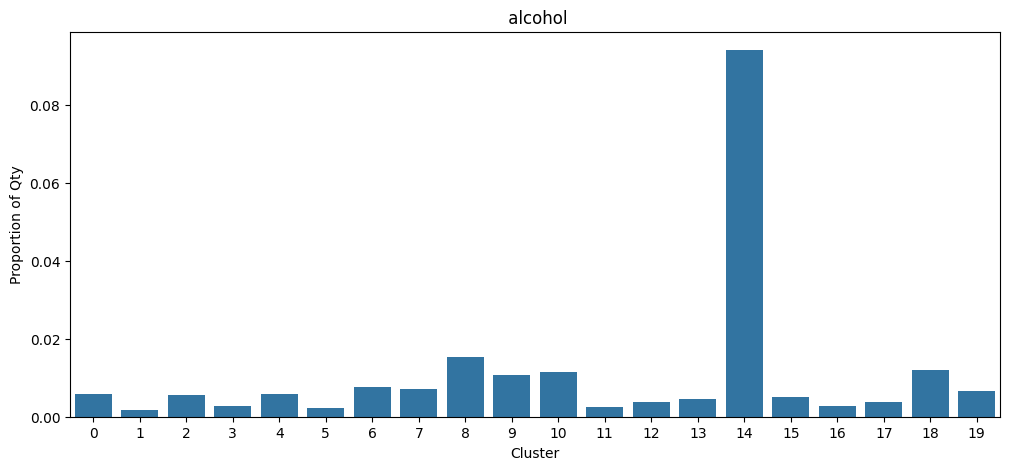

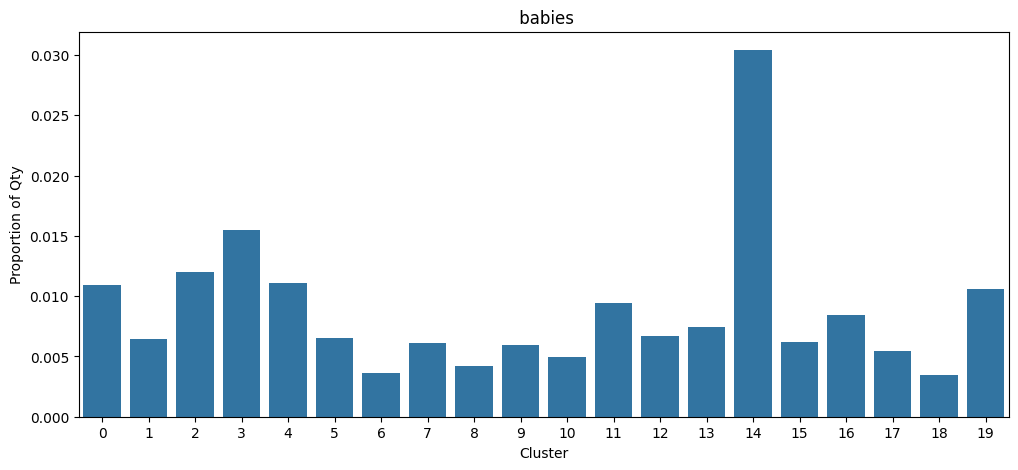

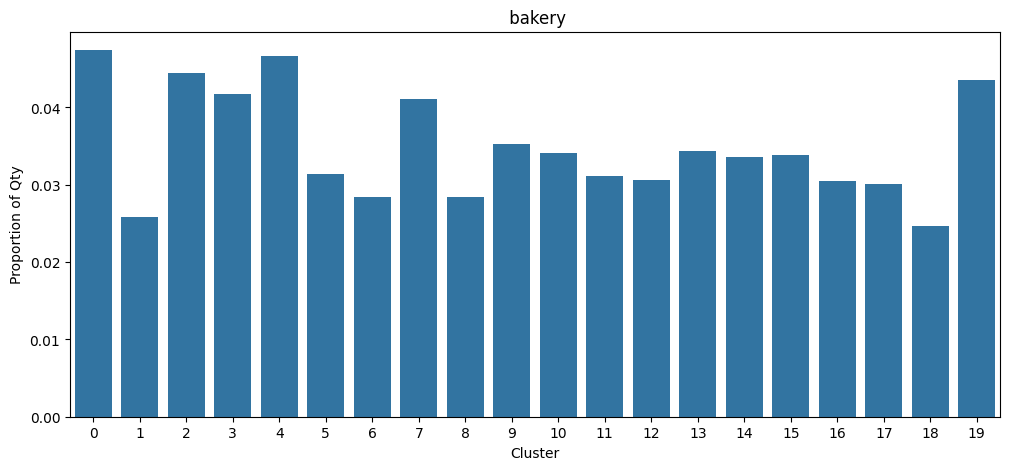

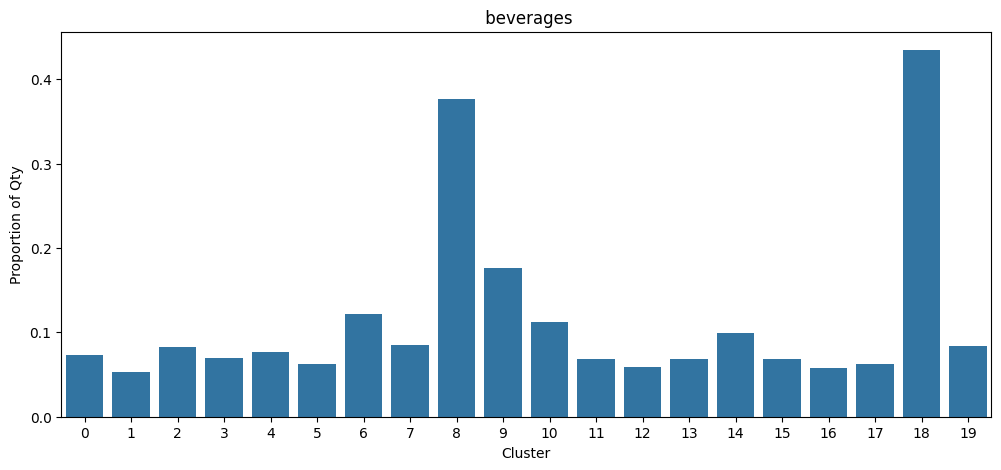

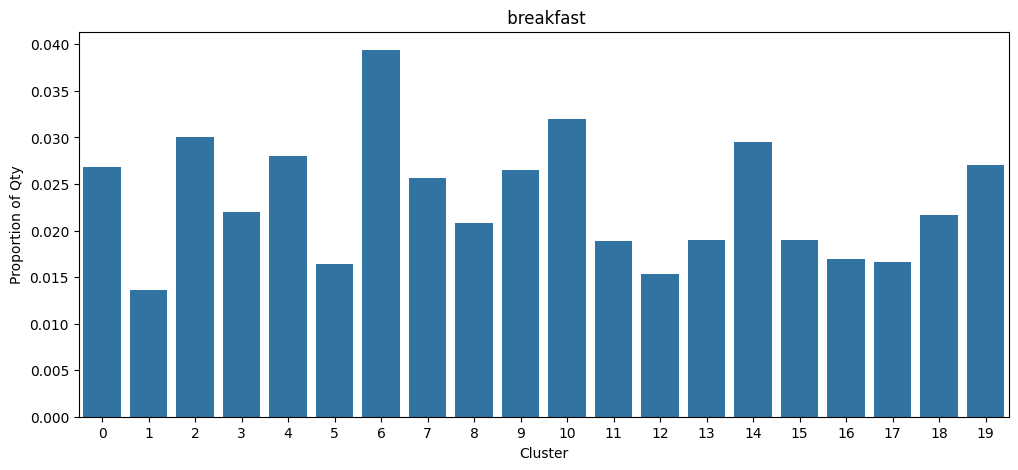

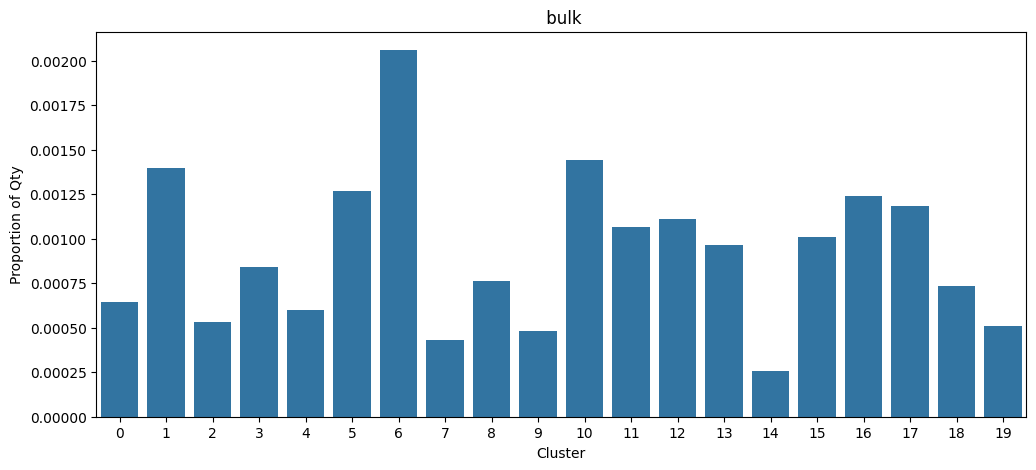

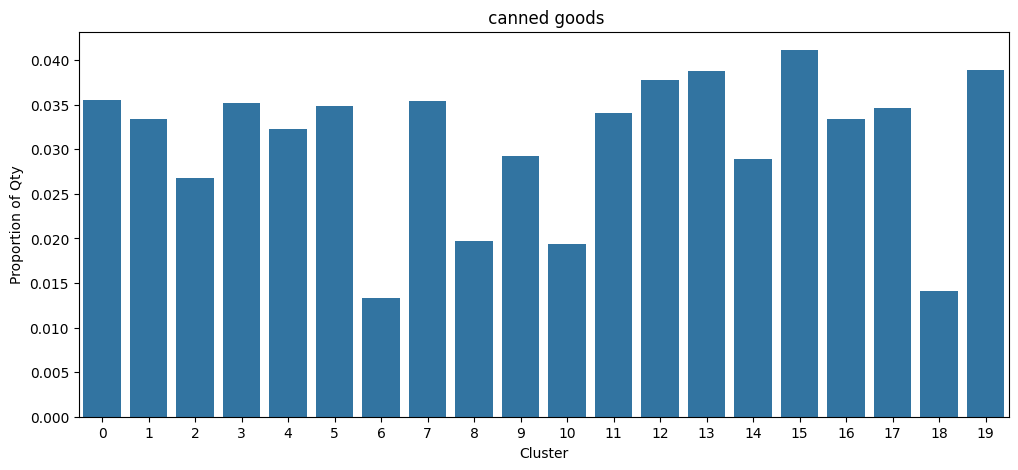

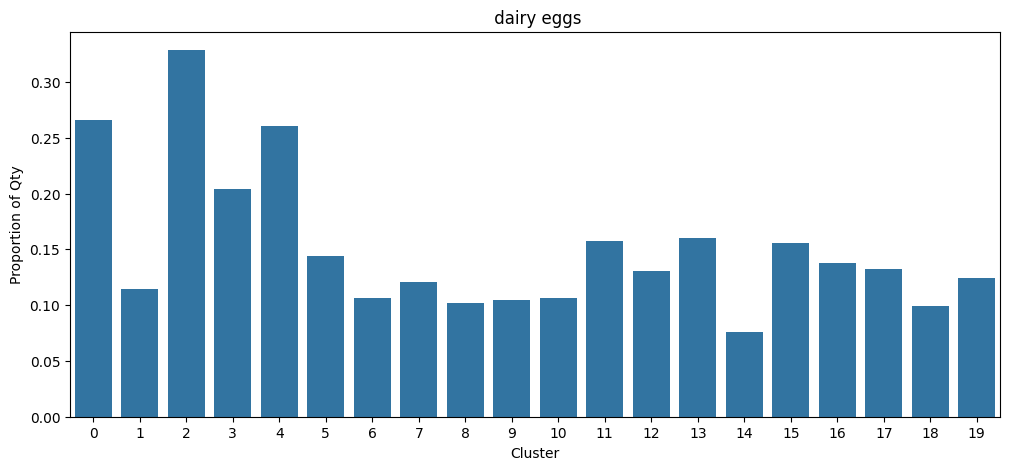

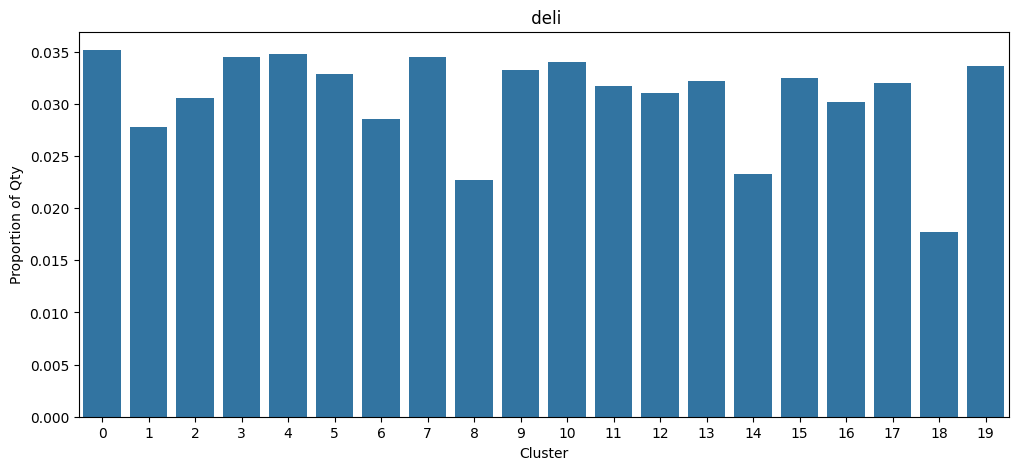

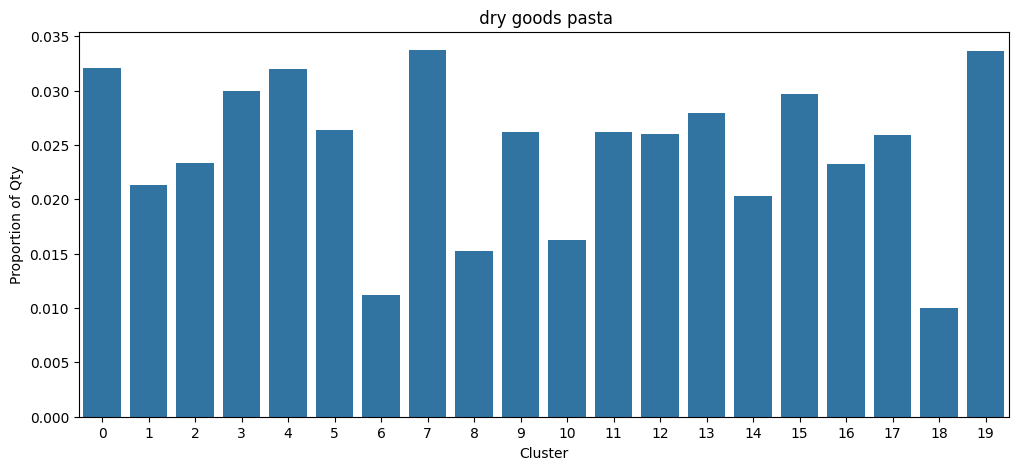

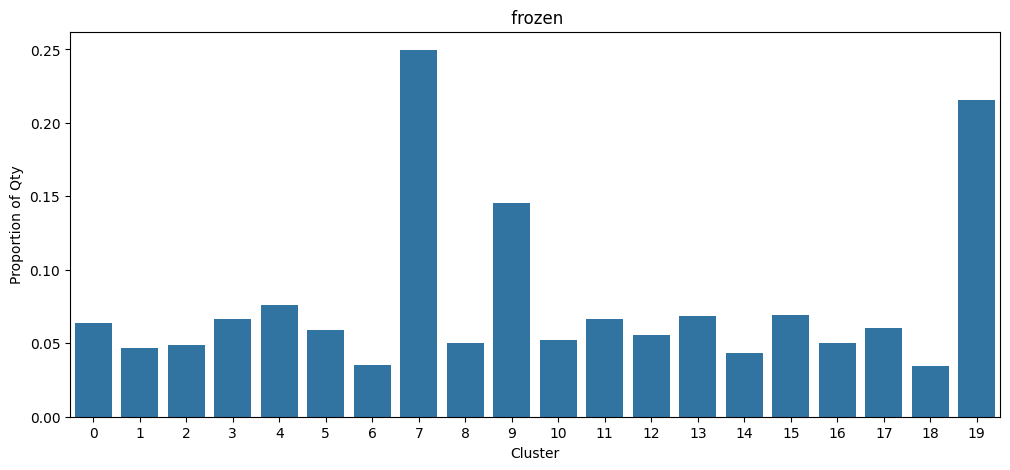

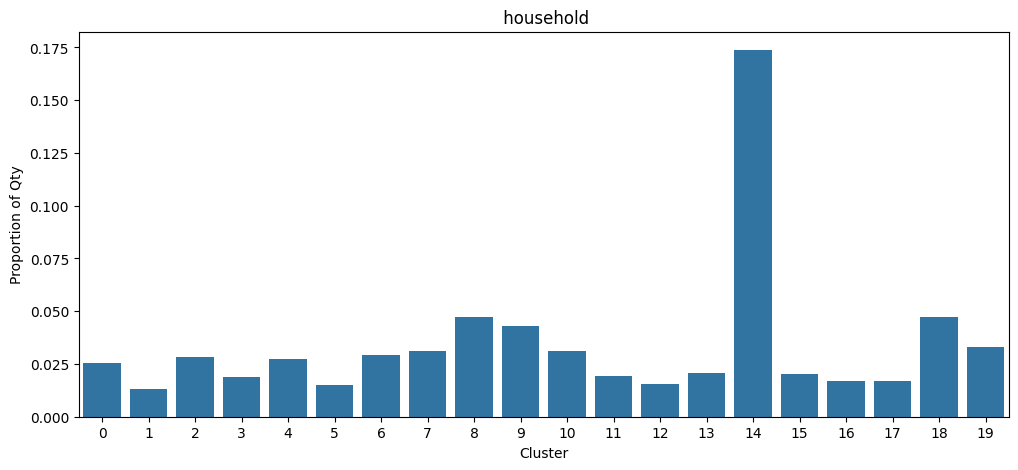

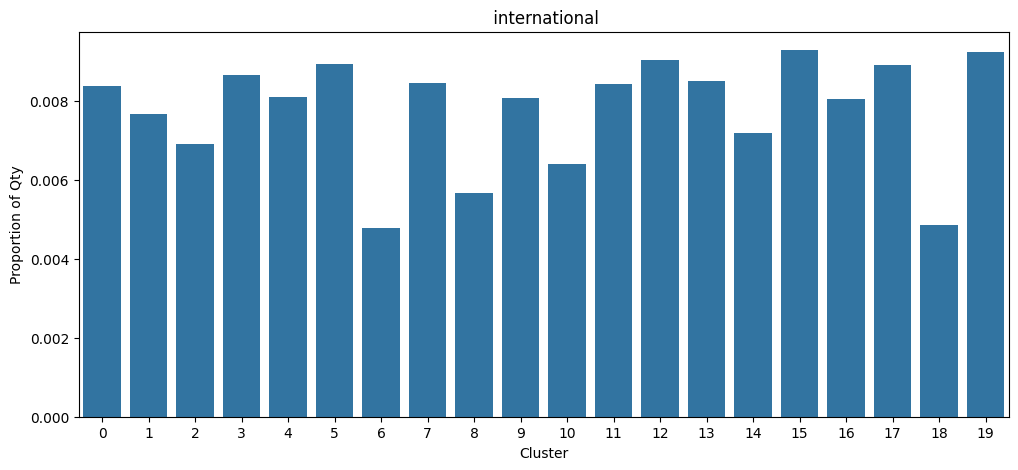

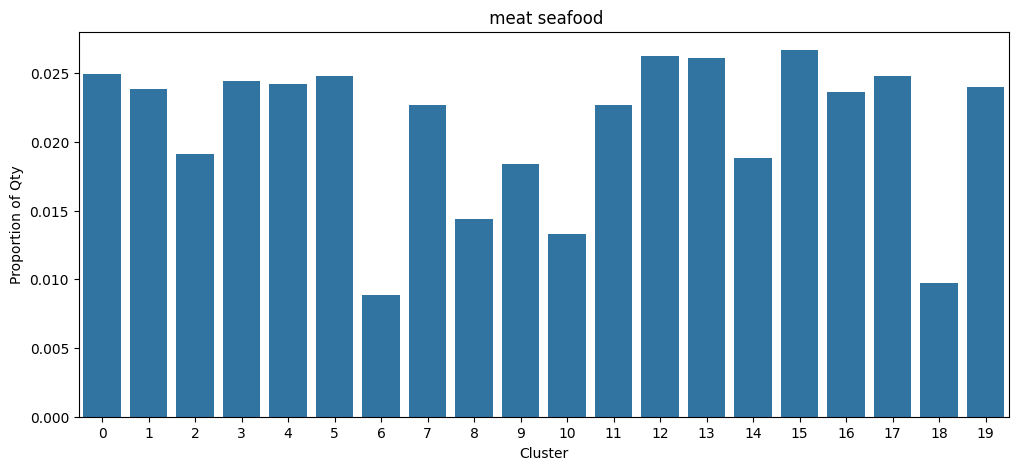

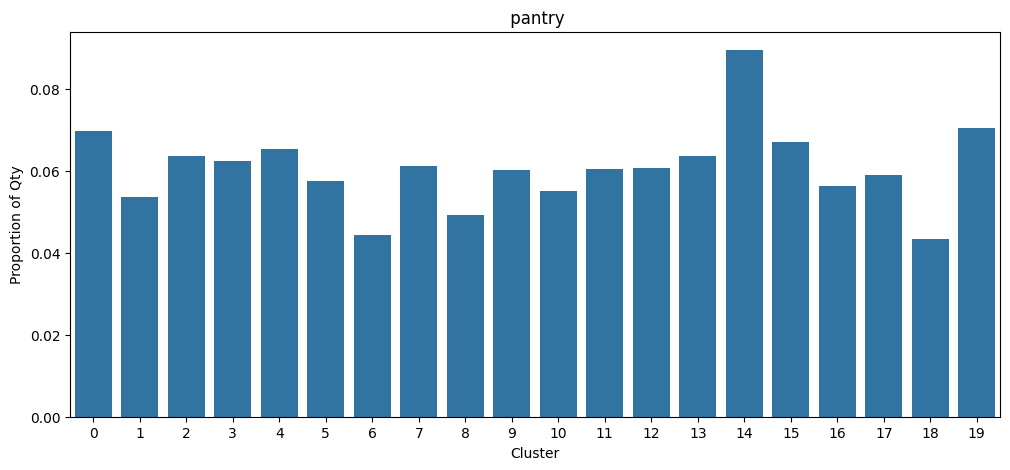

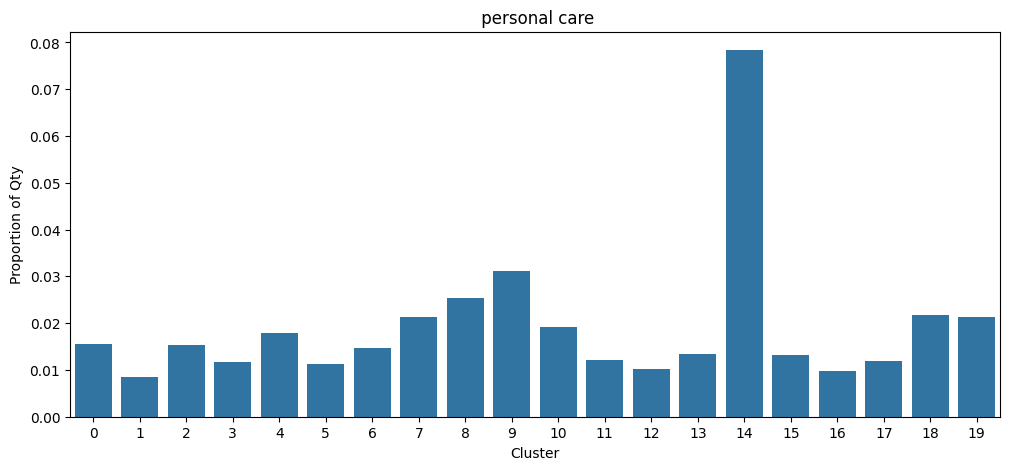

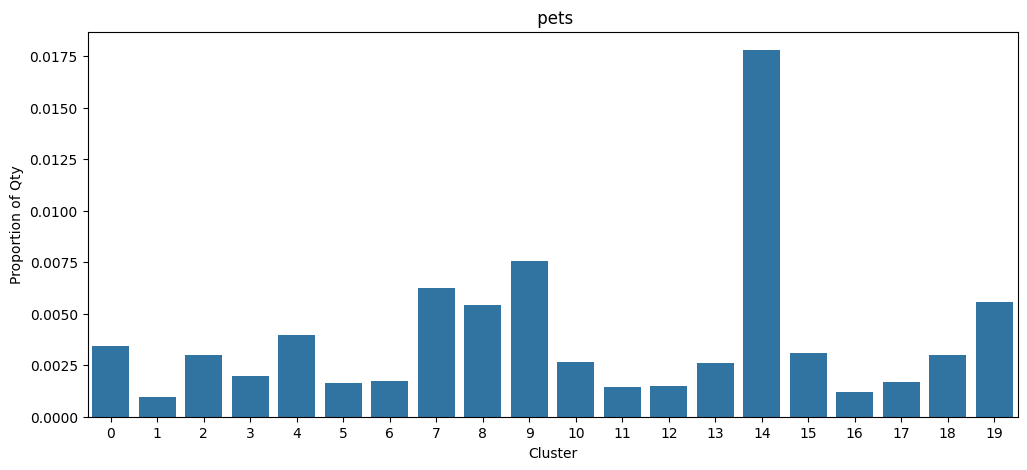

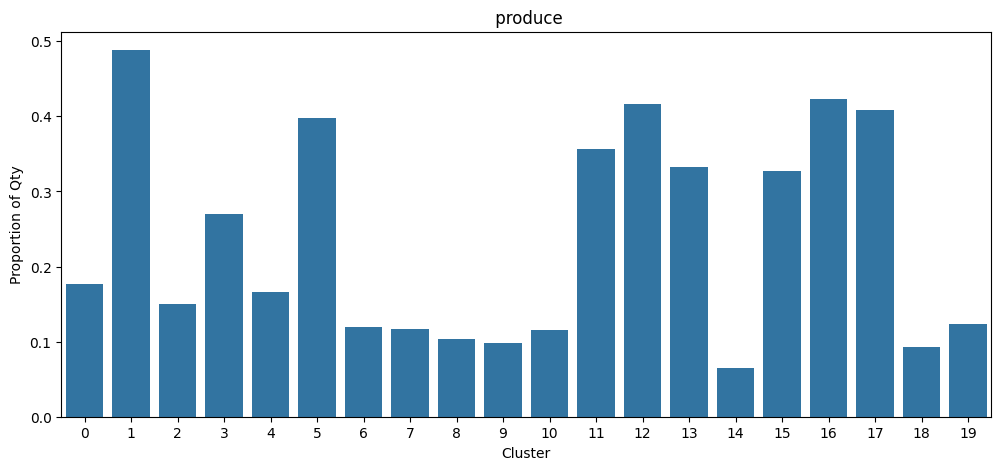

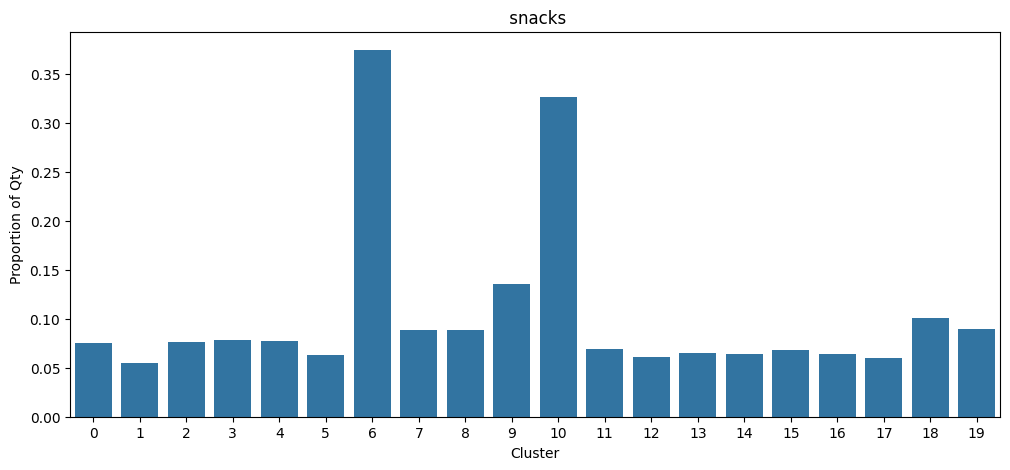

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

dept_avg = avg_mix_unpivot[['cluster_kmeans', 'department', 'value']].groupby(['cluster_kmeans', 'department']).sum().reset_index(drop = False).pivot(index = 'cluster_kmeans', columns = 'department').fillna(0)
for i in dept_avg.columns:
  plt.figure(figsize=(12,5))
  sns.barplot(x='cluster_kmeans', y=i, data=dept_avg)
  plt.title(i[1])
  plt.xlabel("Cluster")
  plt.ylabel("Proportion of Qty")
  plt.show()

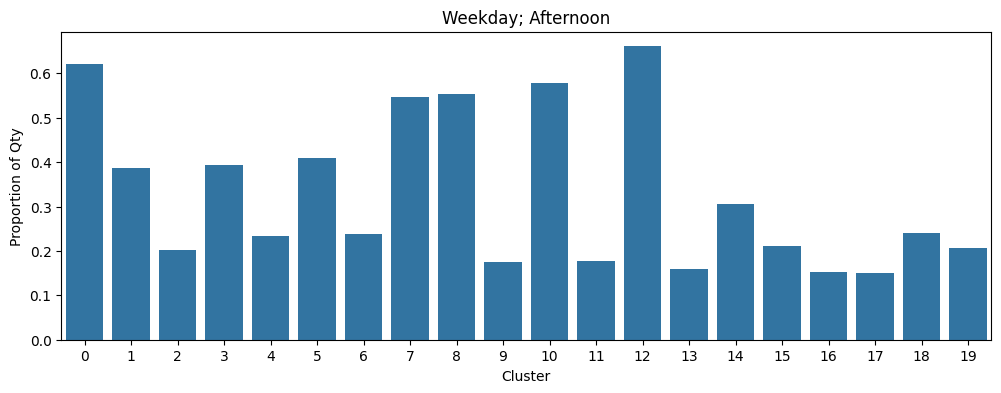

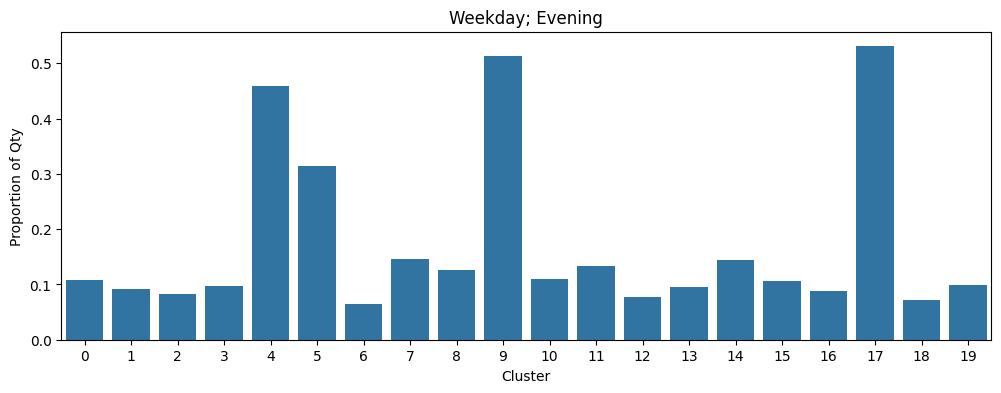

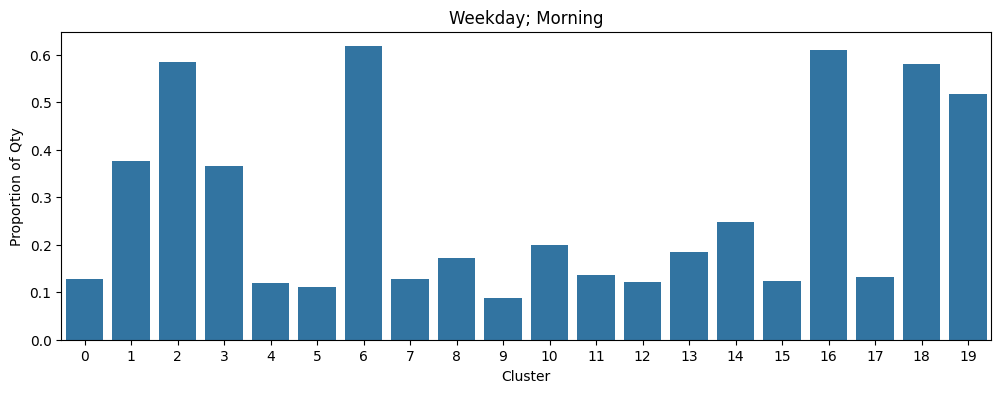

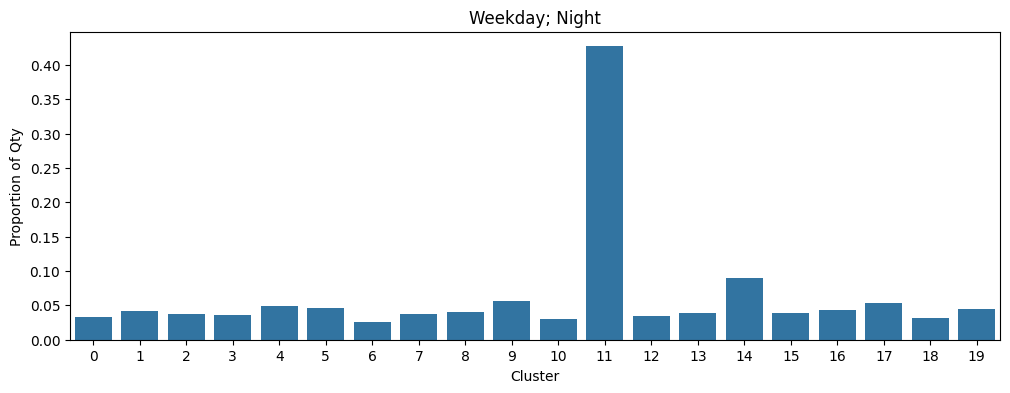

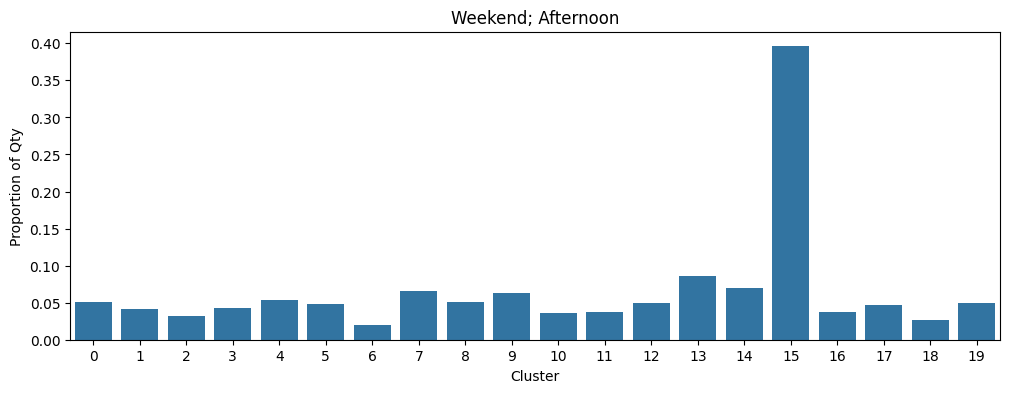

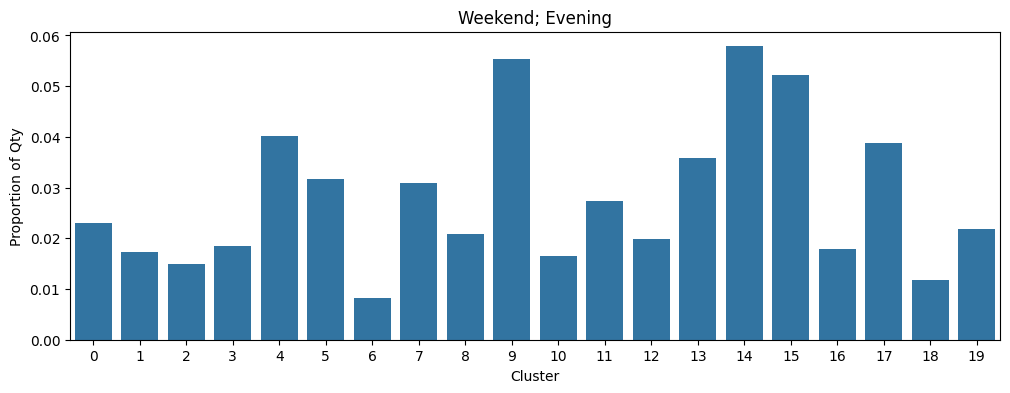

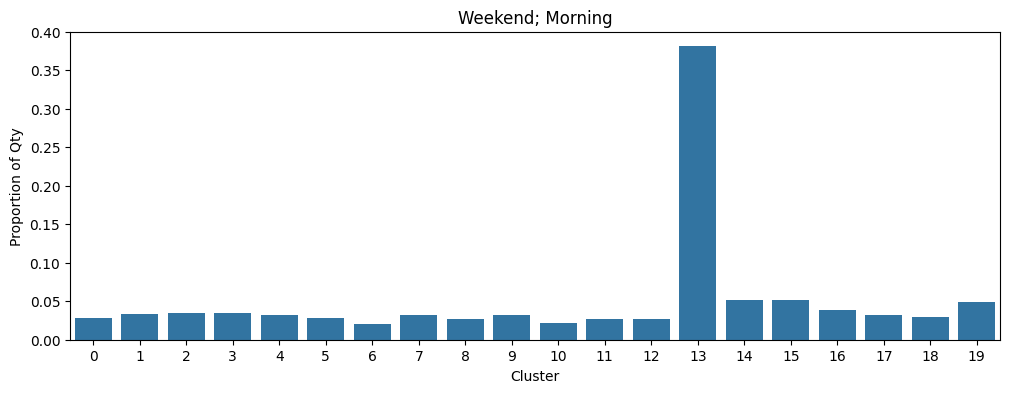

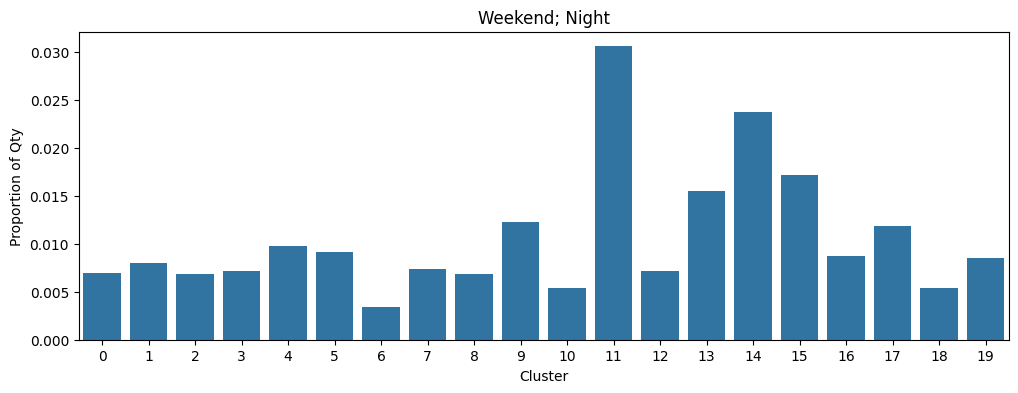

In [ ]:
top_avg = avg_mix_unpivot[['cluster_kmeans', 'time_of_purchase', 'value']].groupby(['cluster_kmeans', 'time_of_purchase']).sum().reset_index(drop = False).pivot(index = 'cluster_kmeans', columns = 'time_of_purchase').fillna(0)
for i in top_avg.columns:
  plt.figure(figsize=(12,4))
  sns.barplot(x='cluster_kmeans', y=i, data=top_avg)
  plt.title(i[1])
  plt.xlabel("Cluster")
  plt.ylabel("Proportion of Qty")
  plt.show()

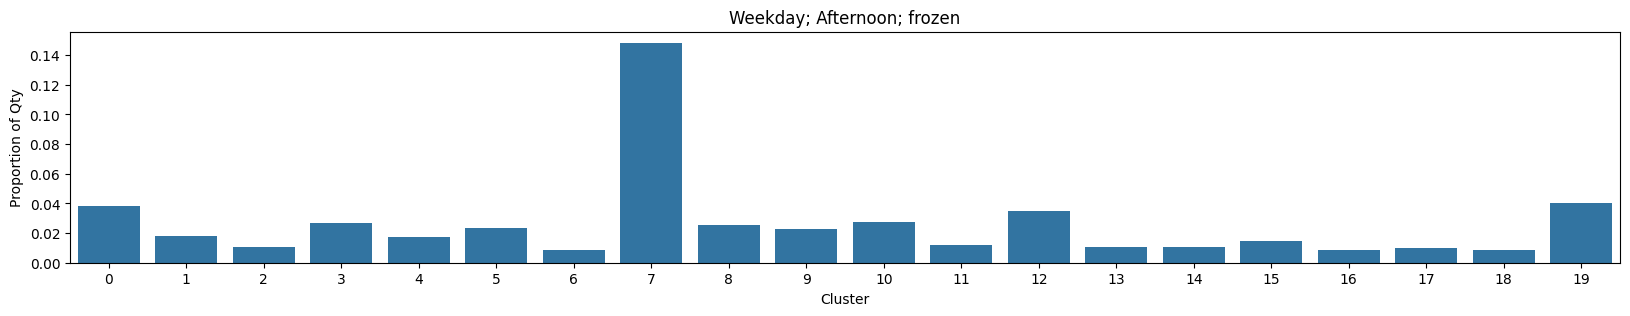

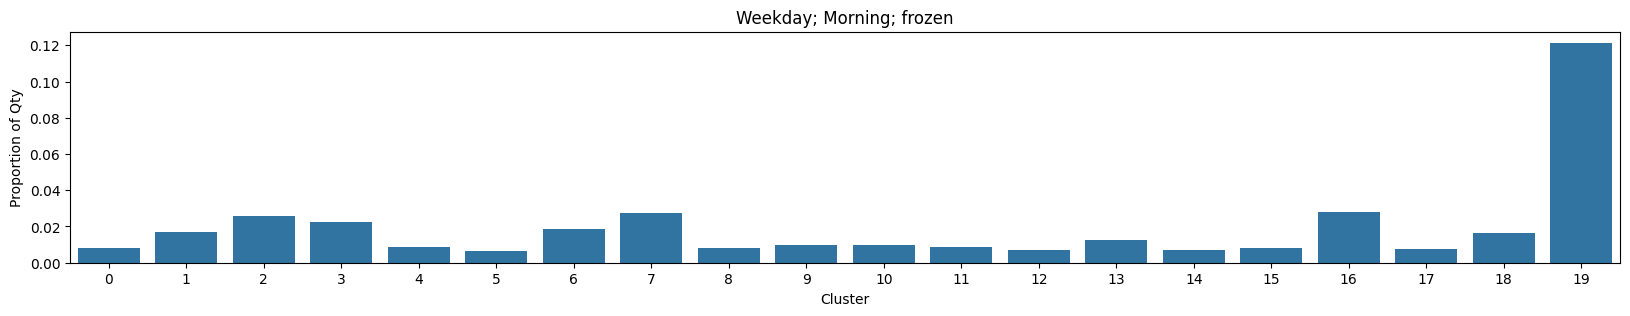

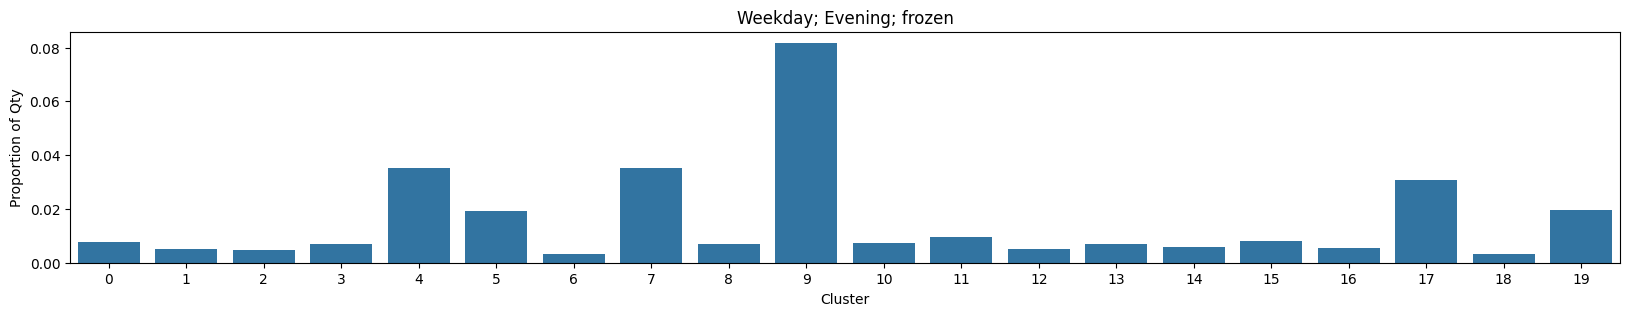

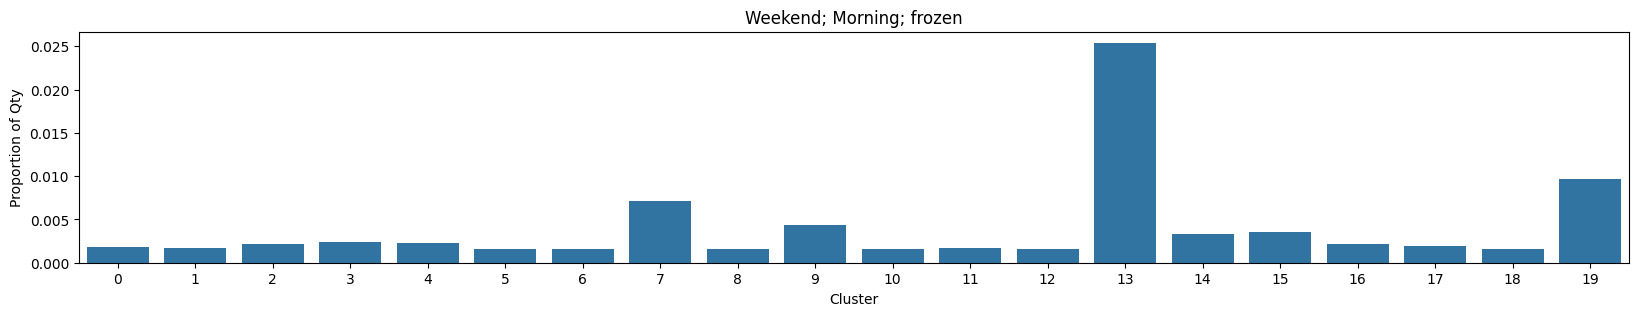

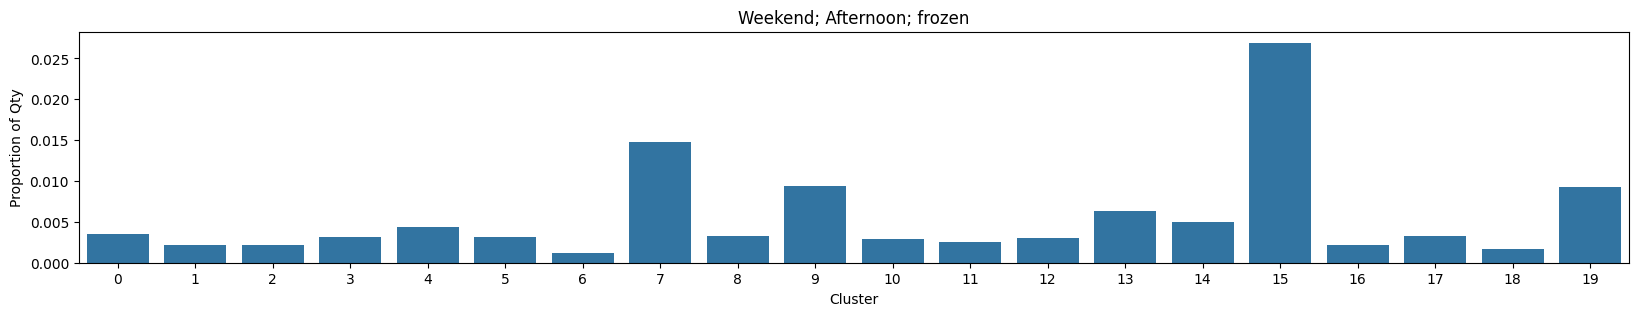

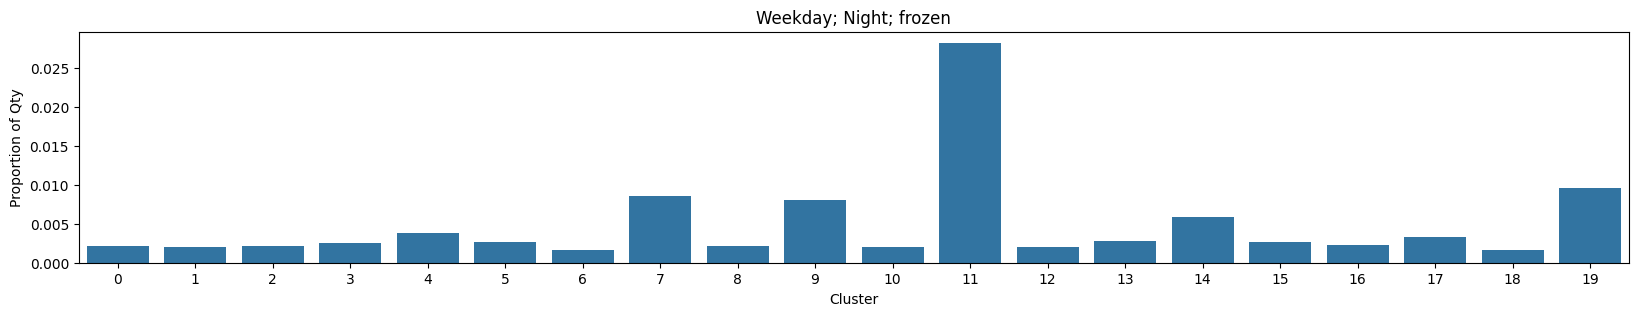

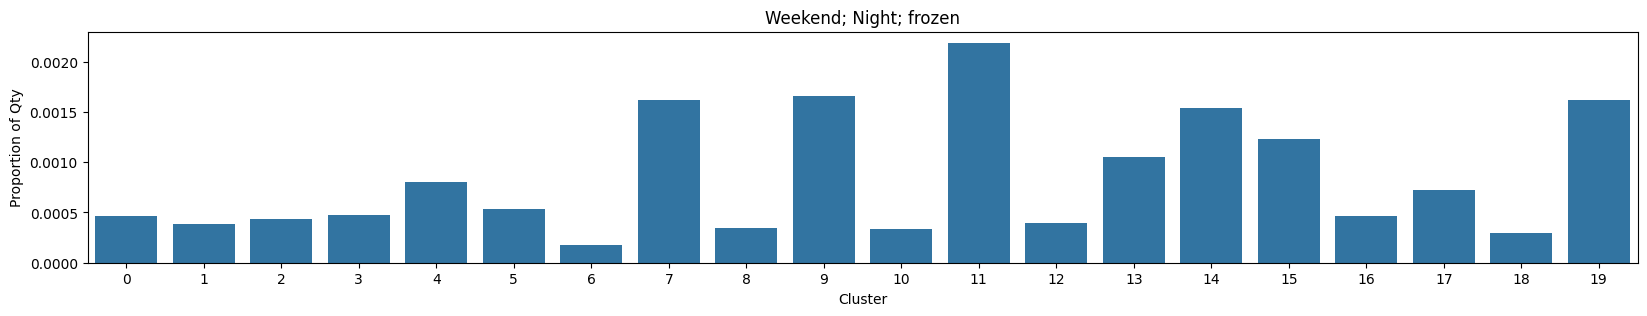

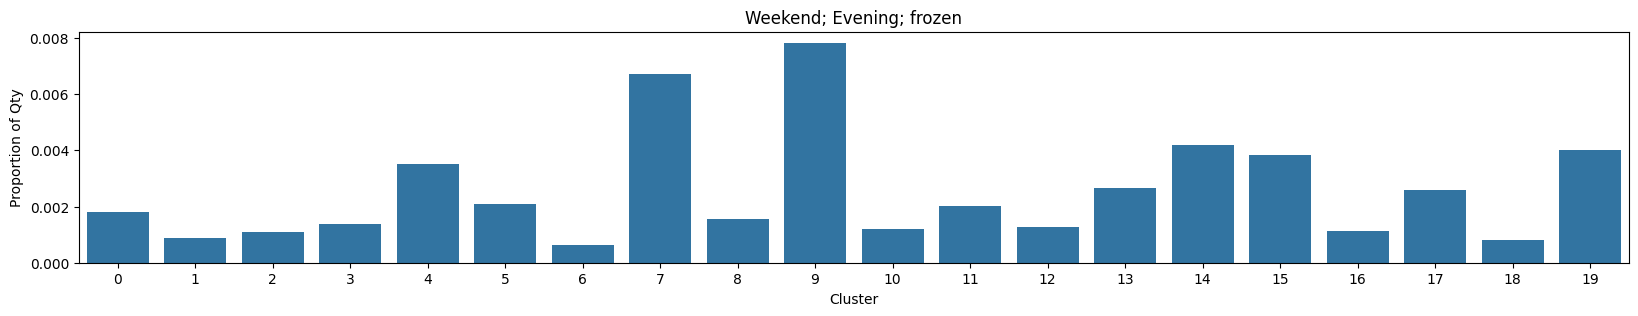

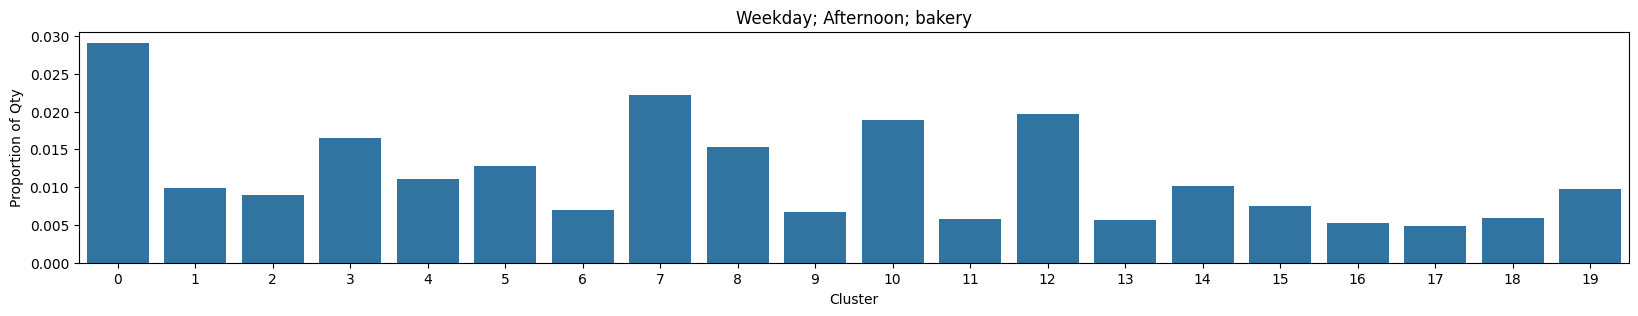

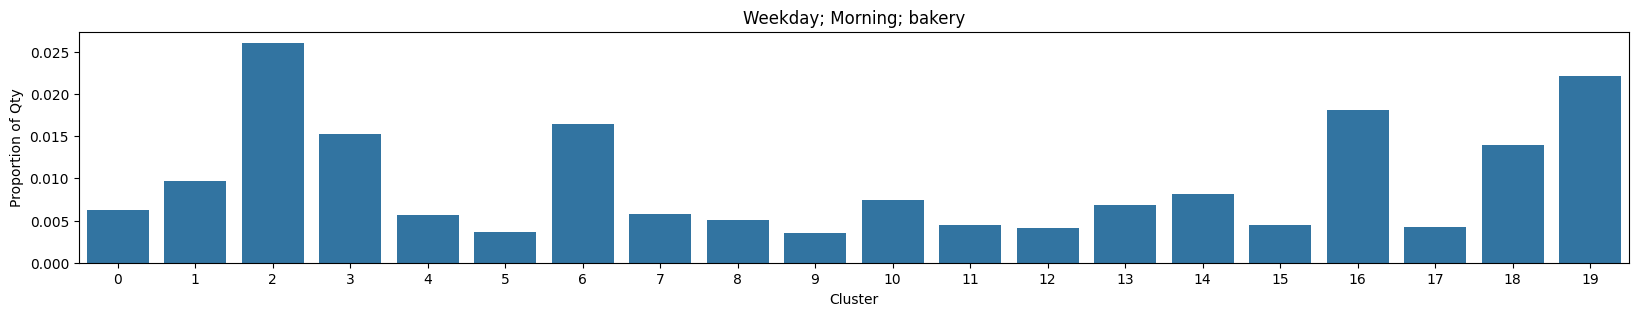

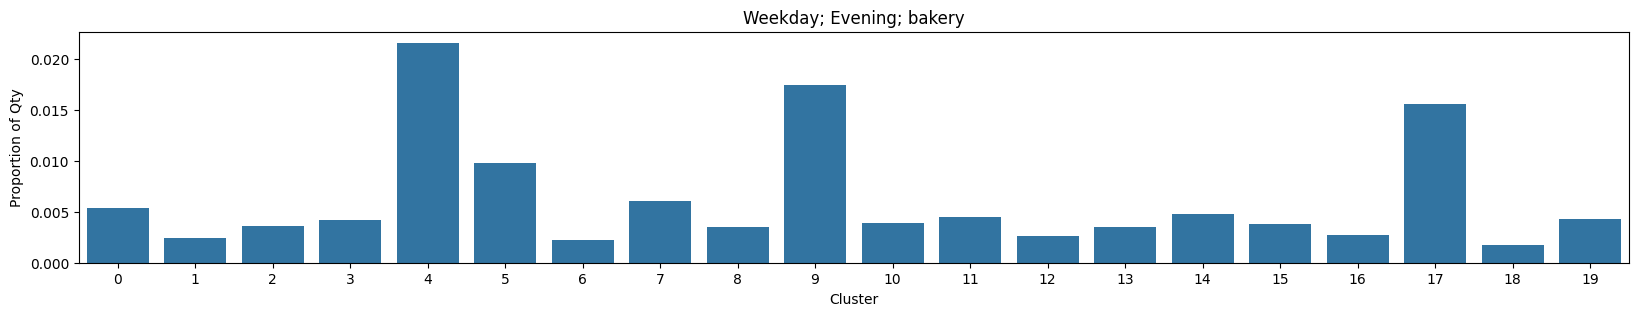

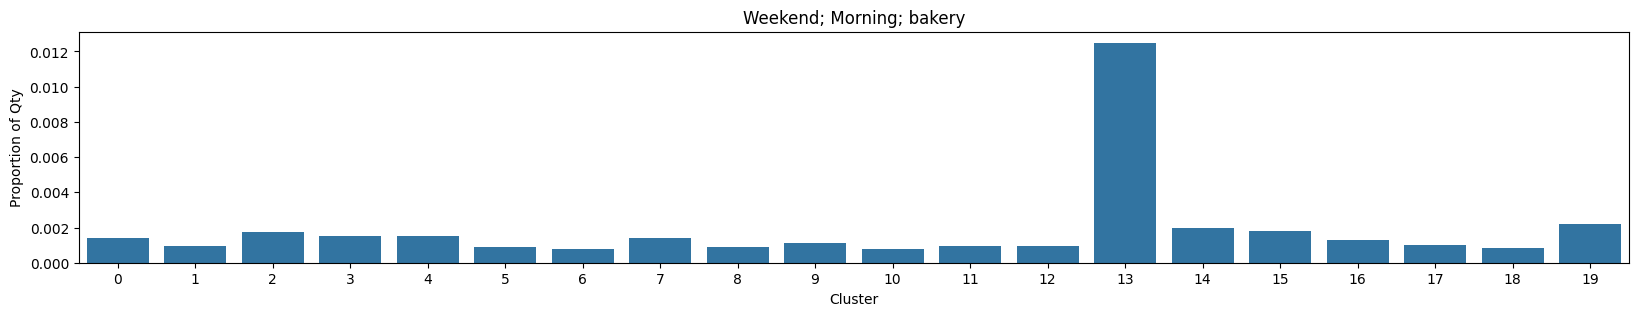

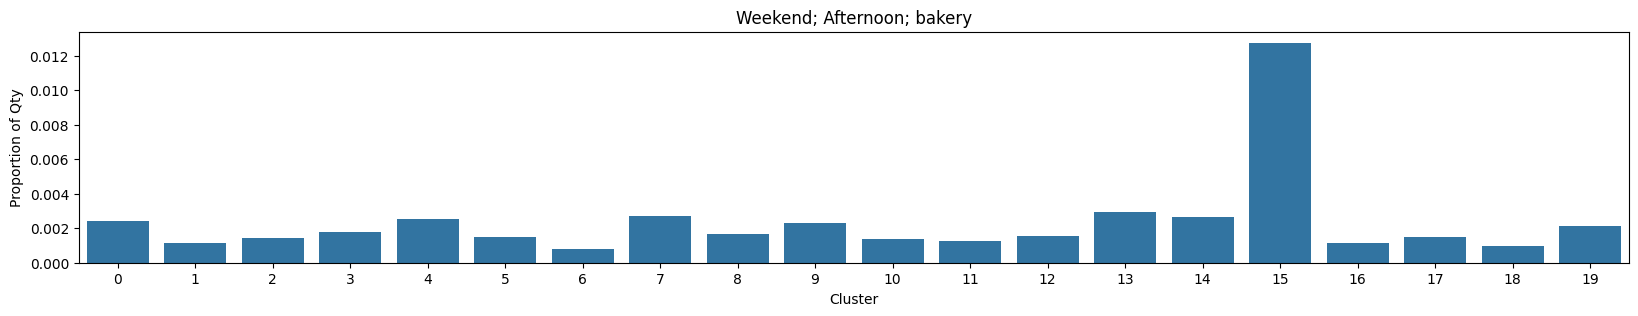

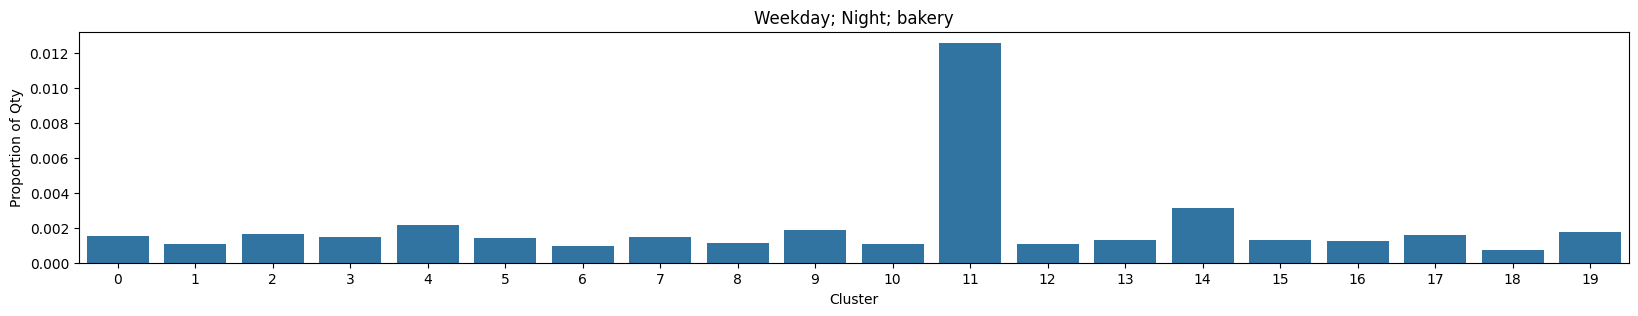

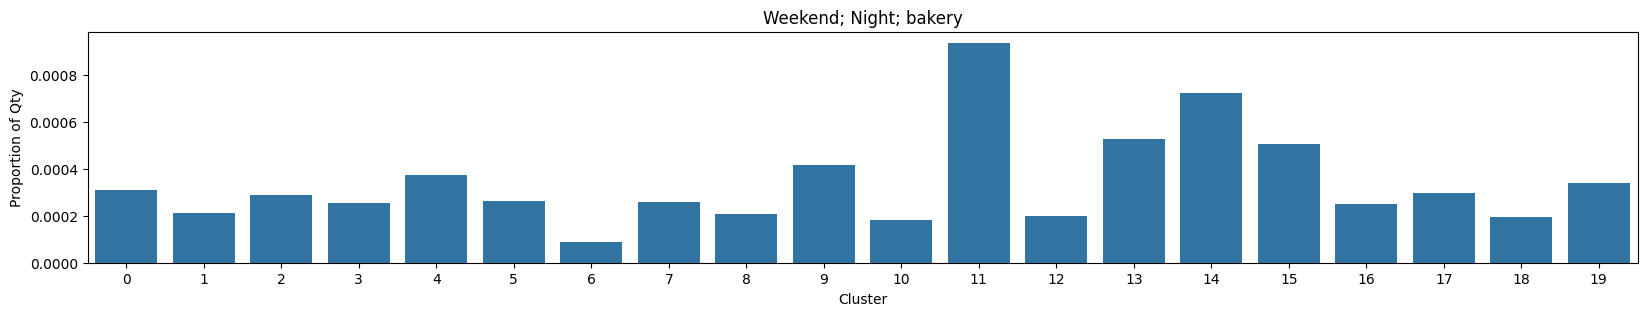

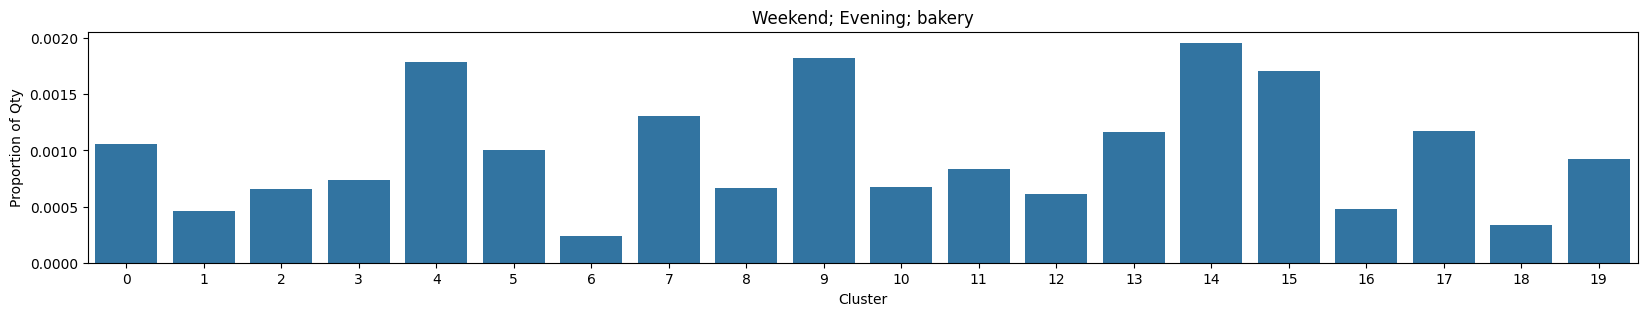

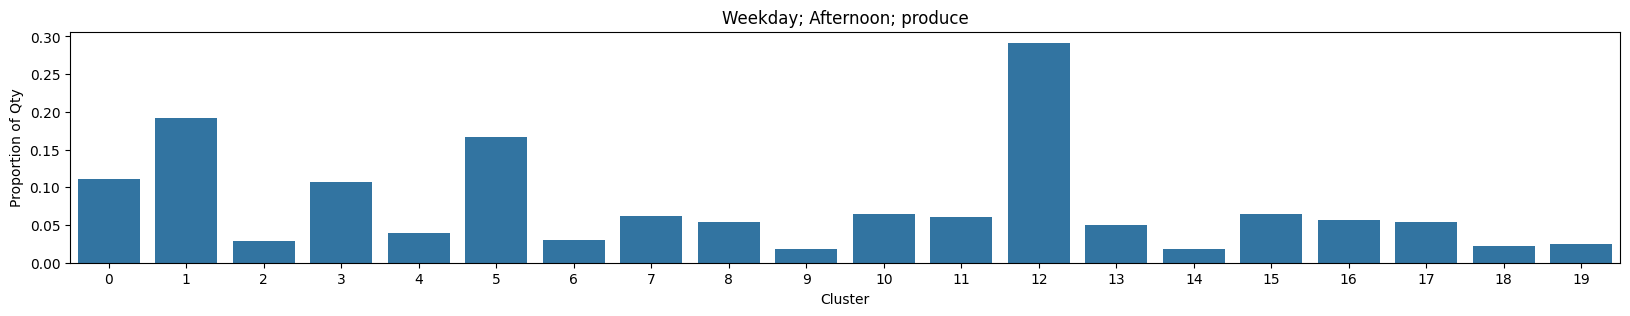

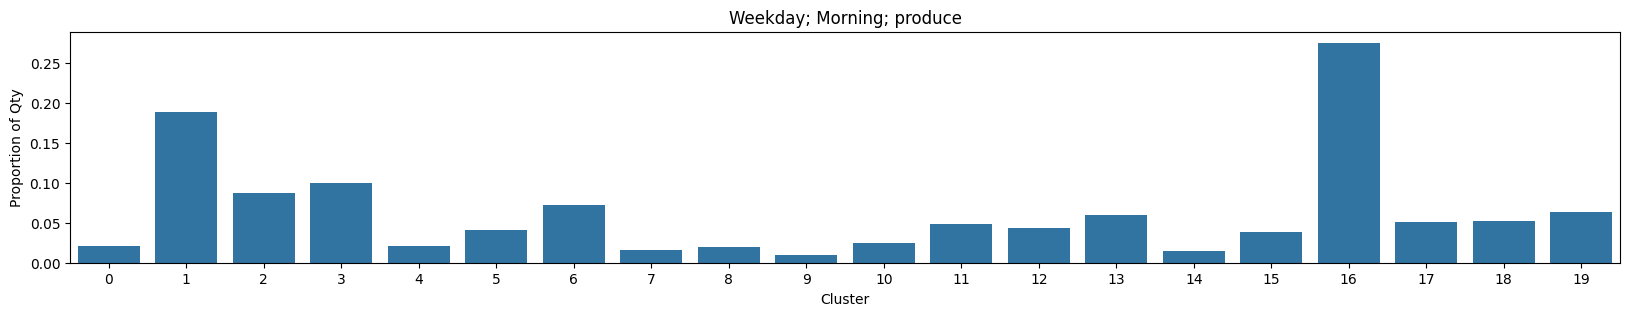

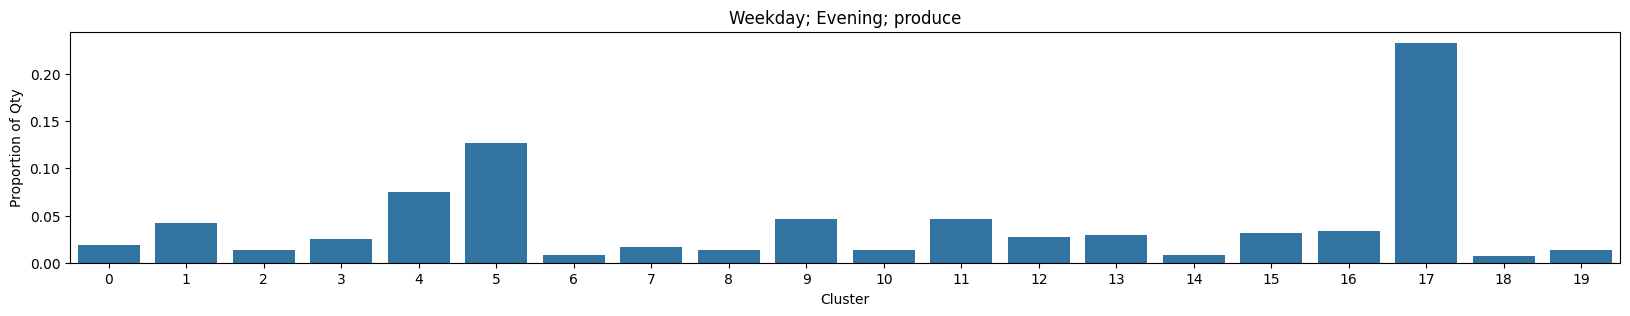

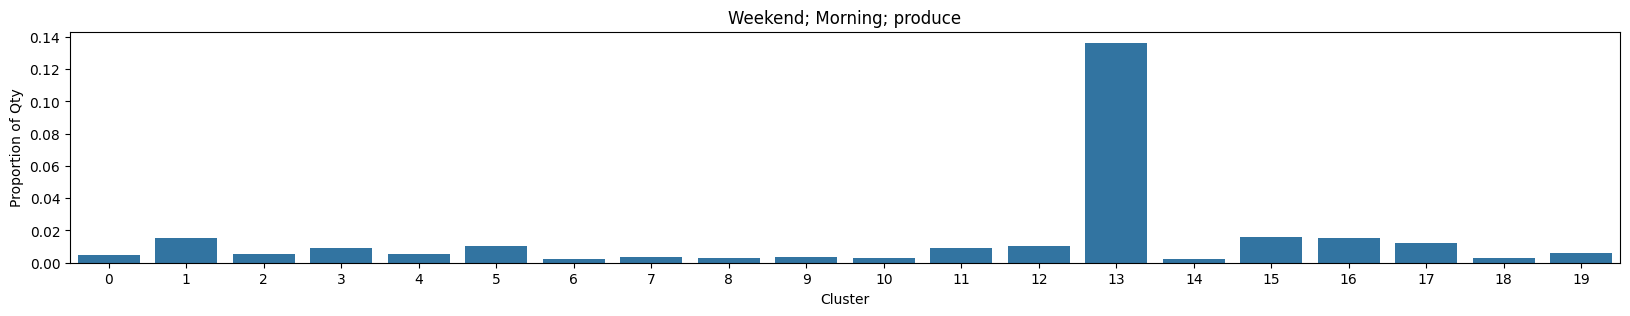

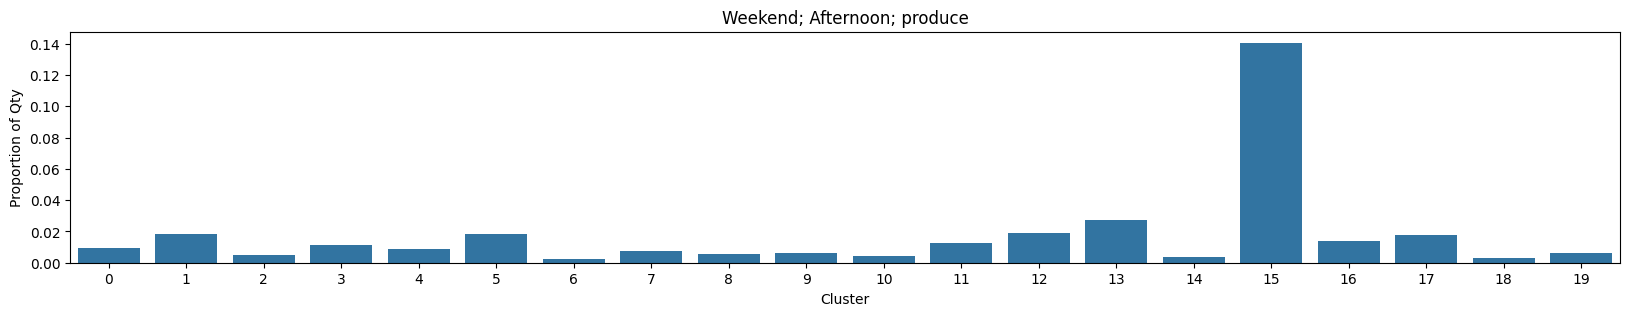

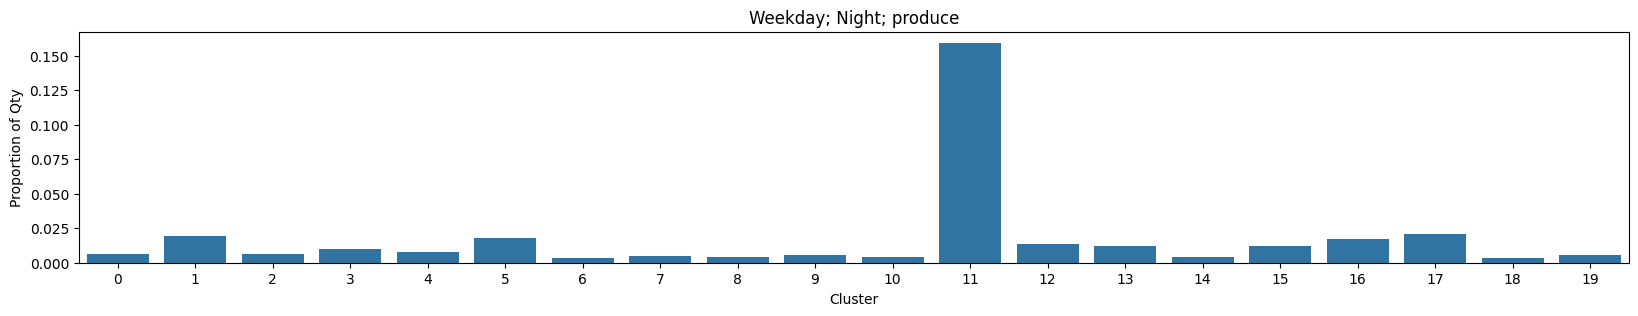

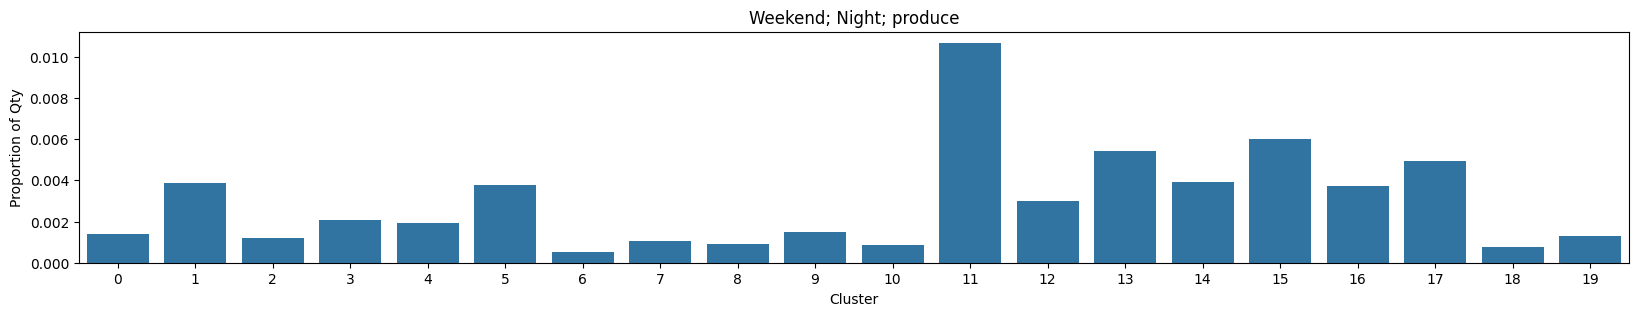

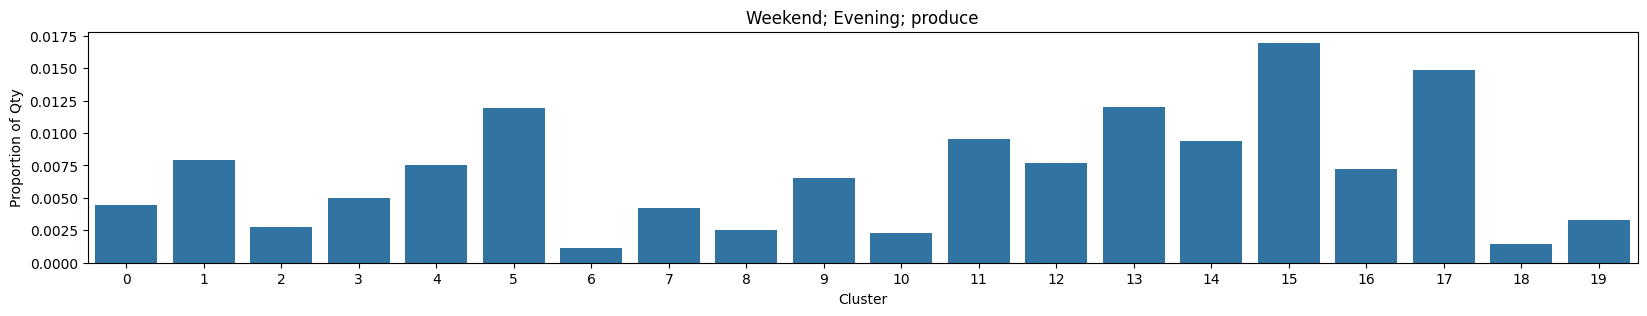

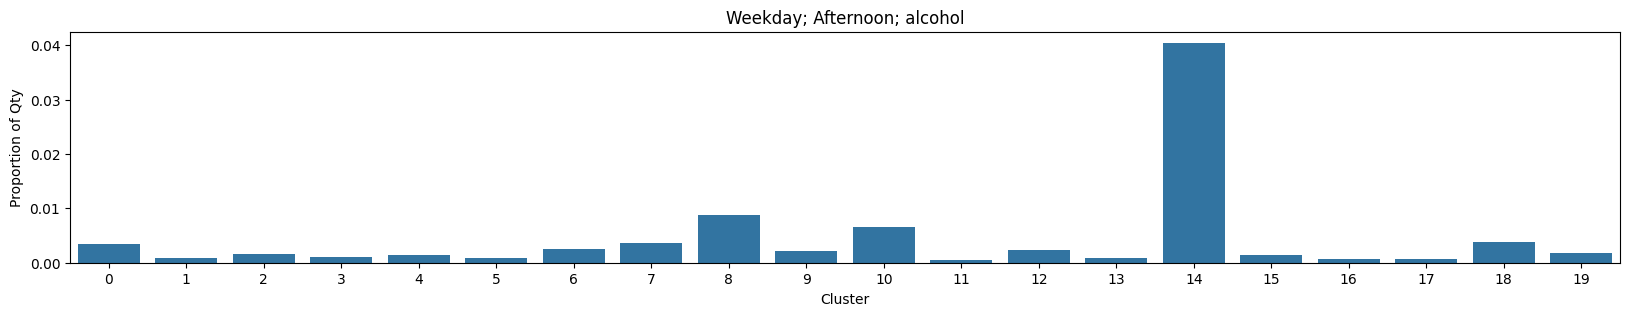

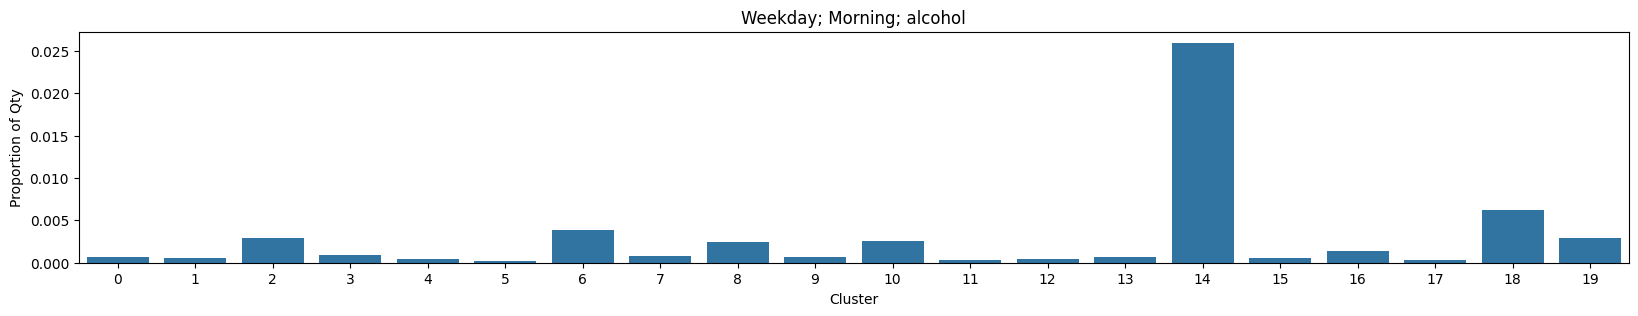

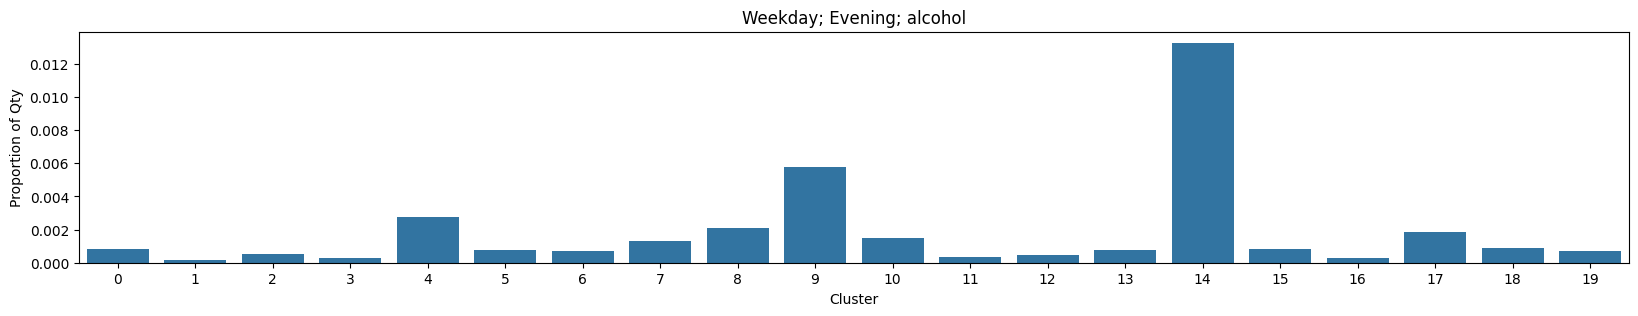

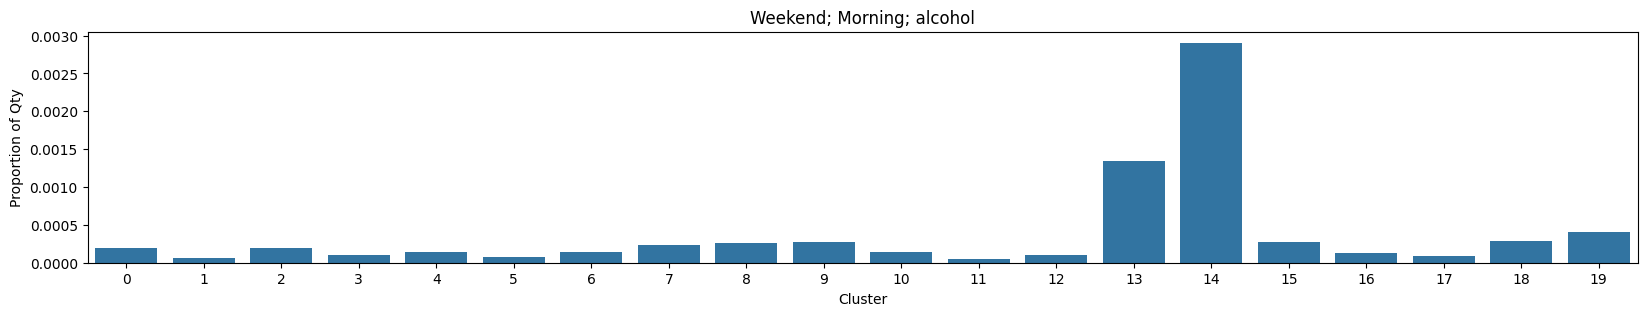

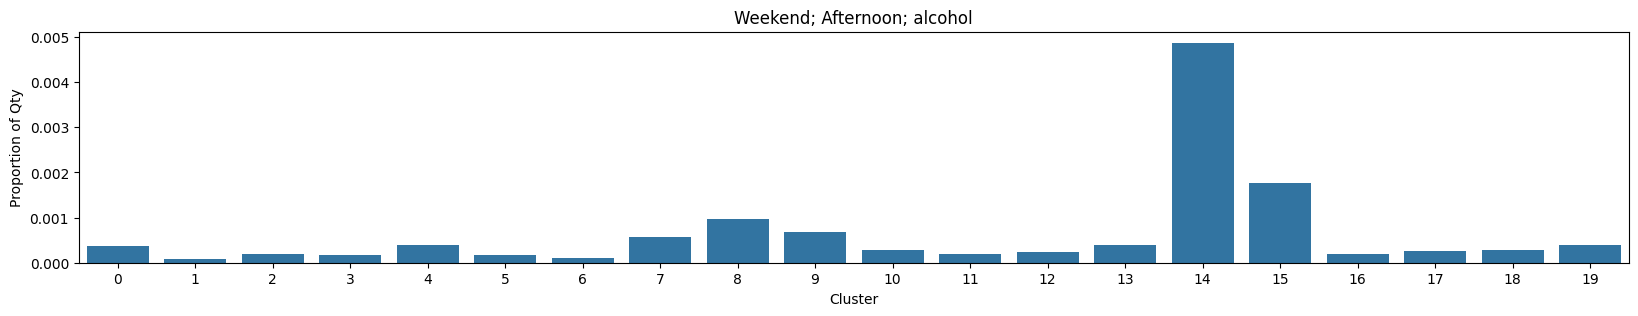

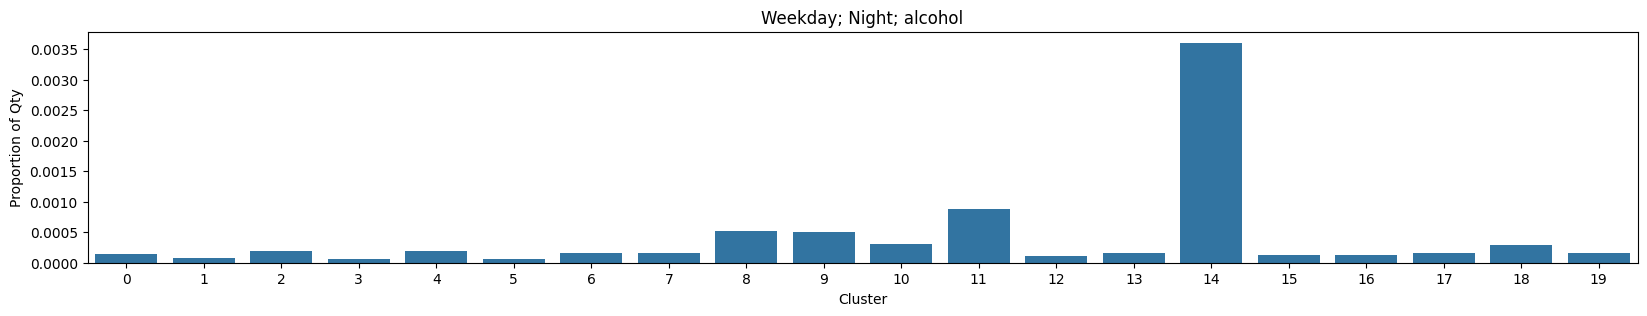

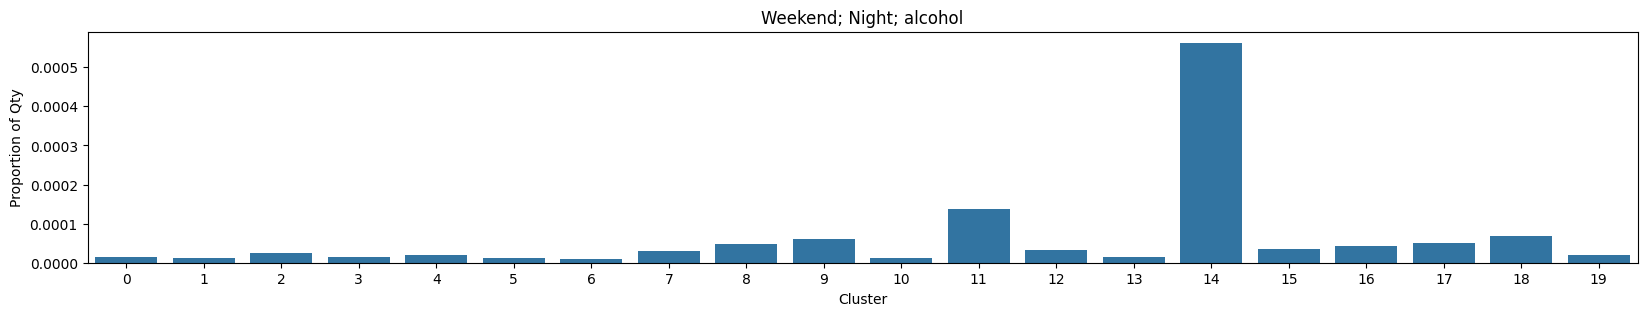

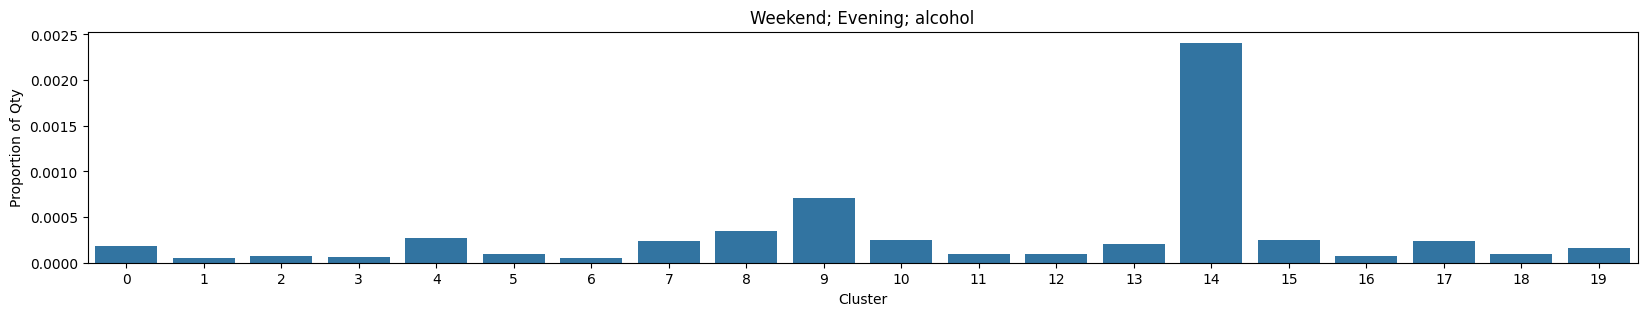

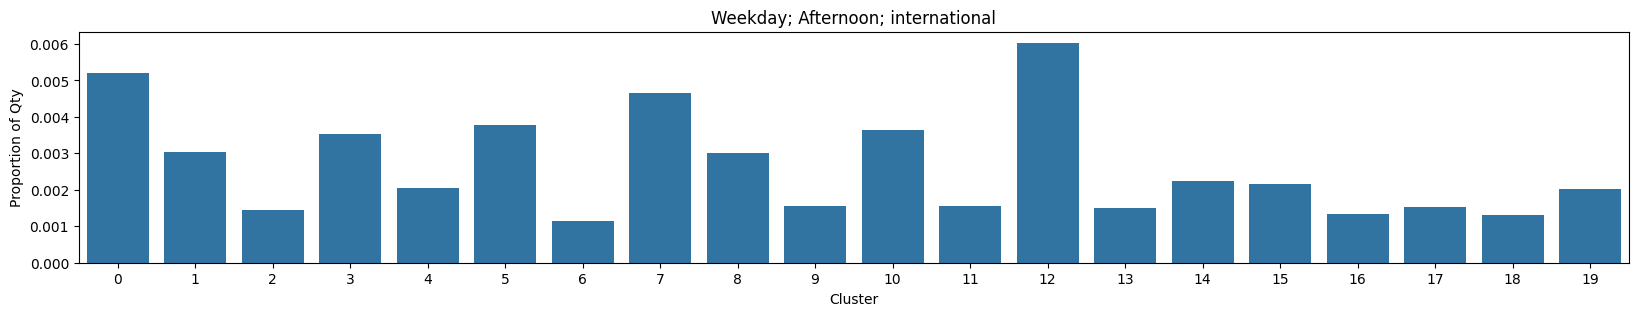

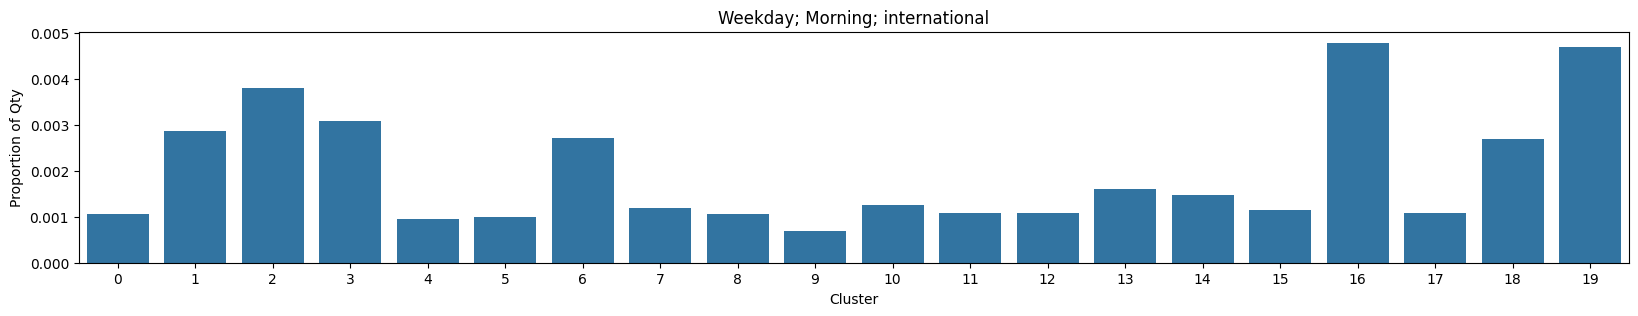

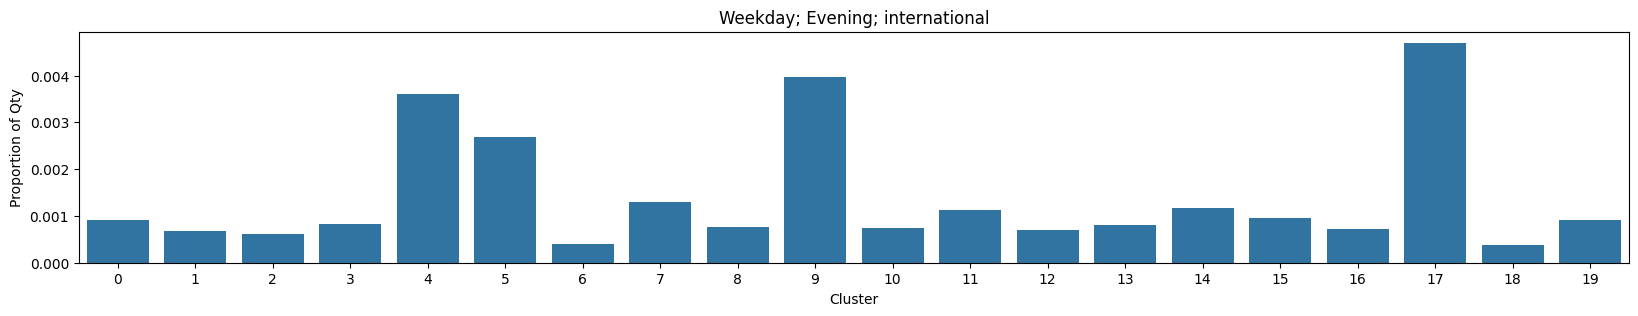

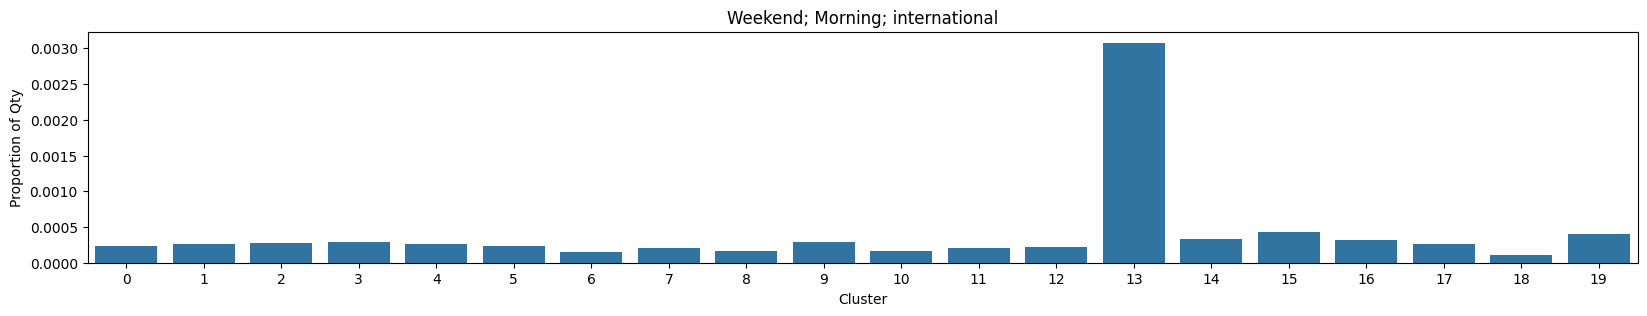

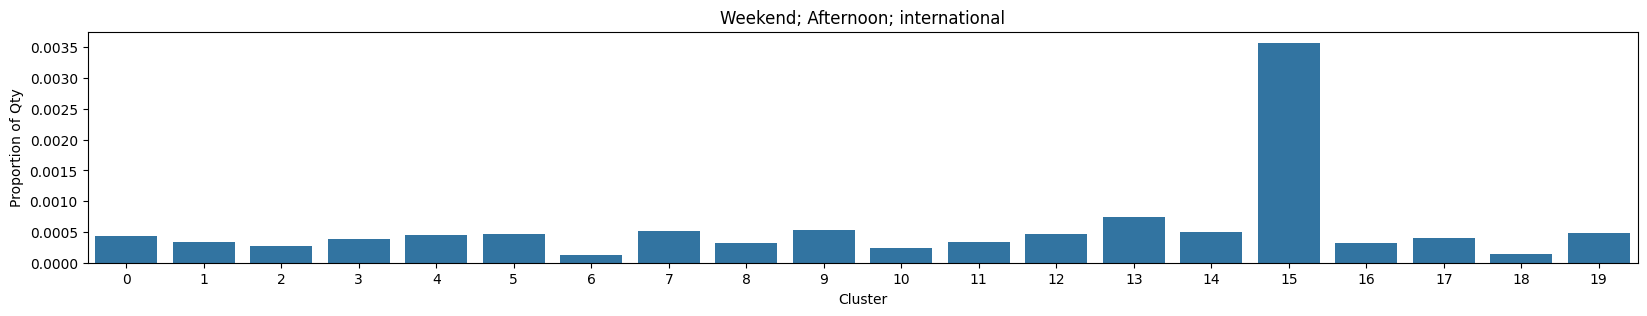

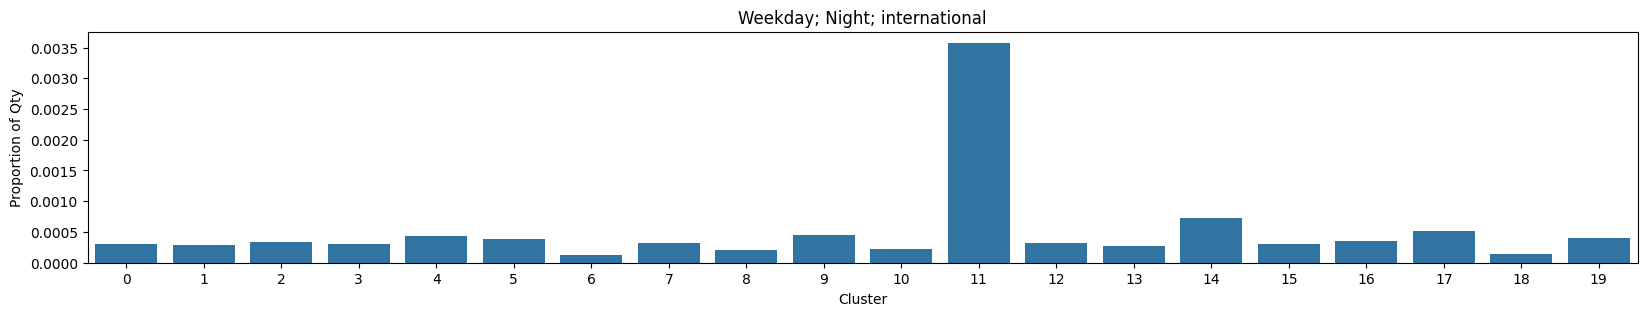

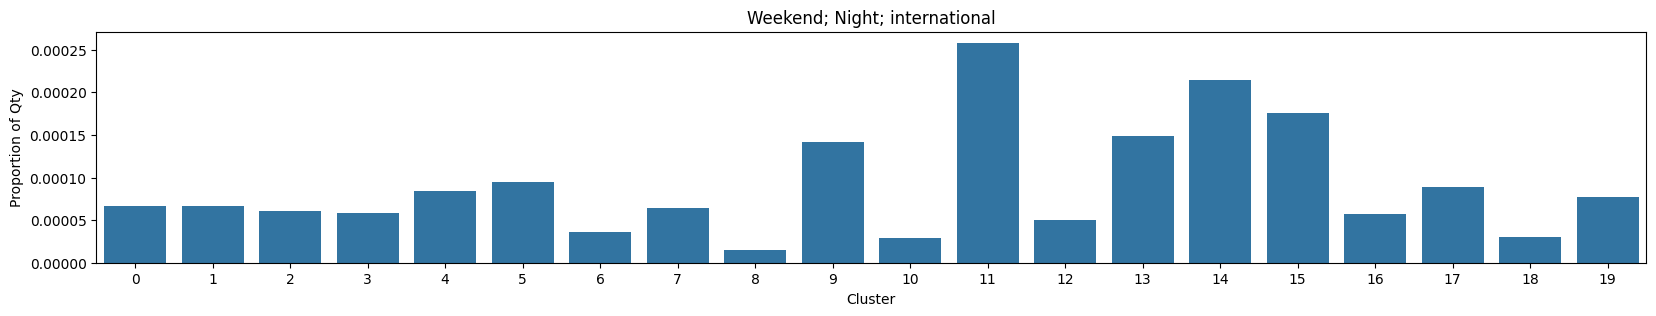

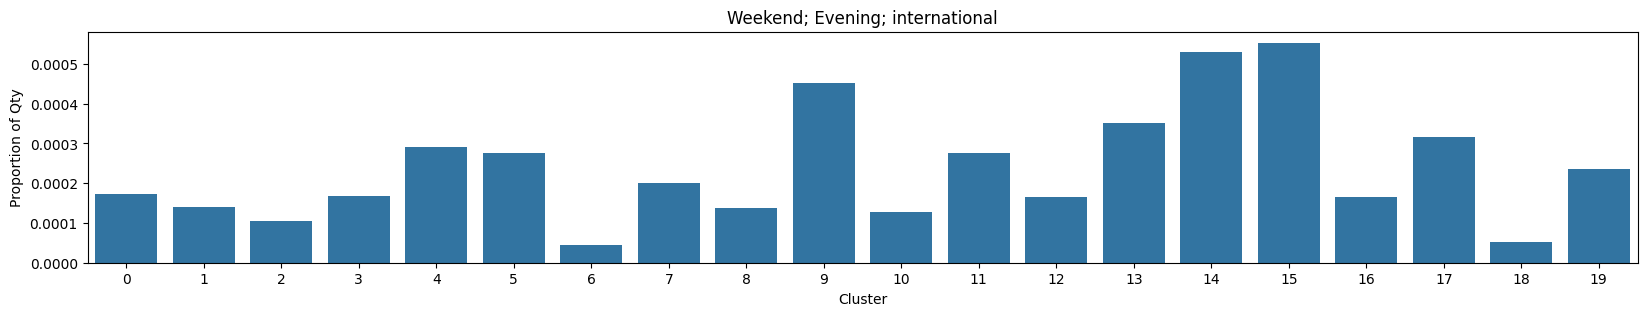

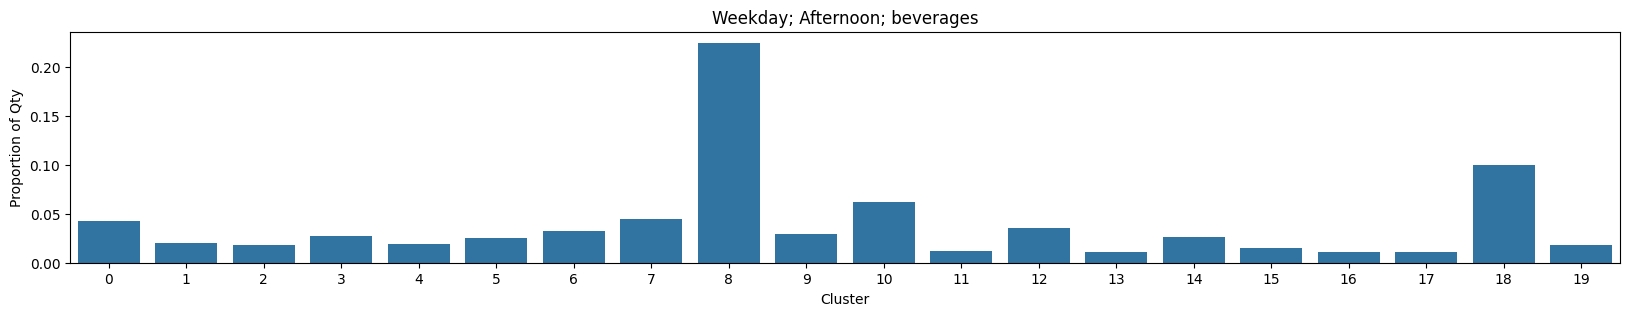

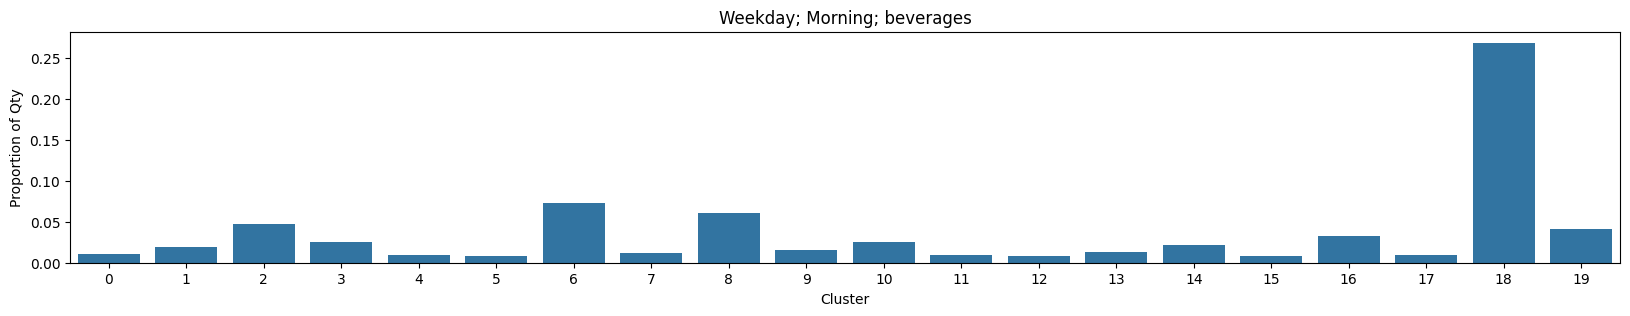

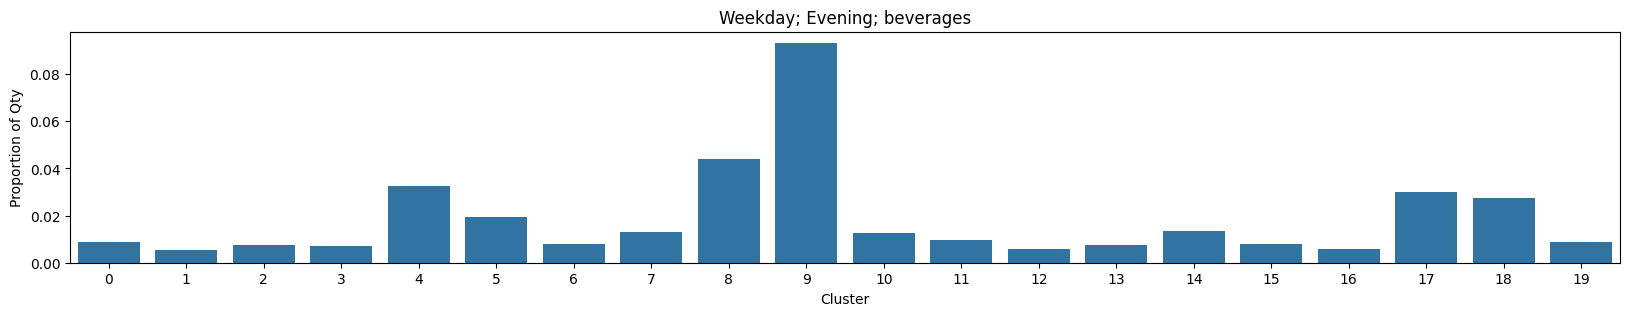

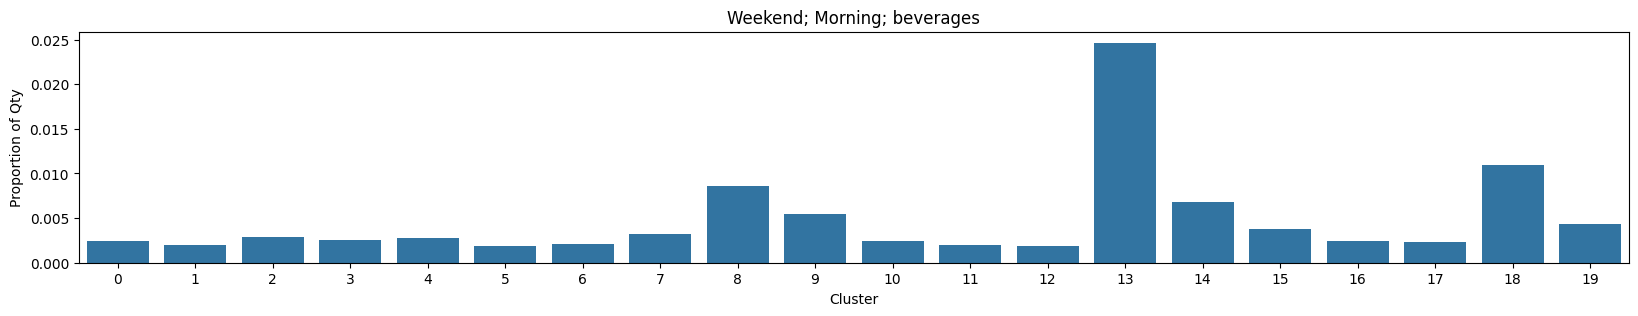

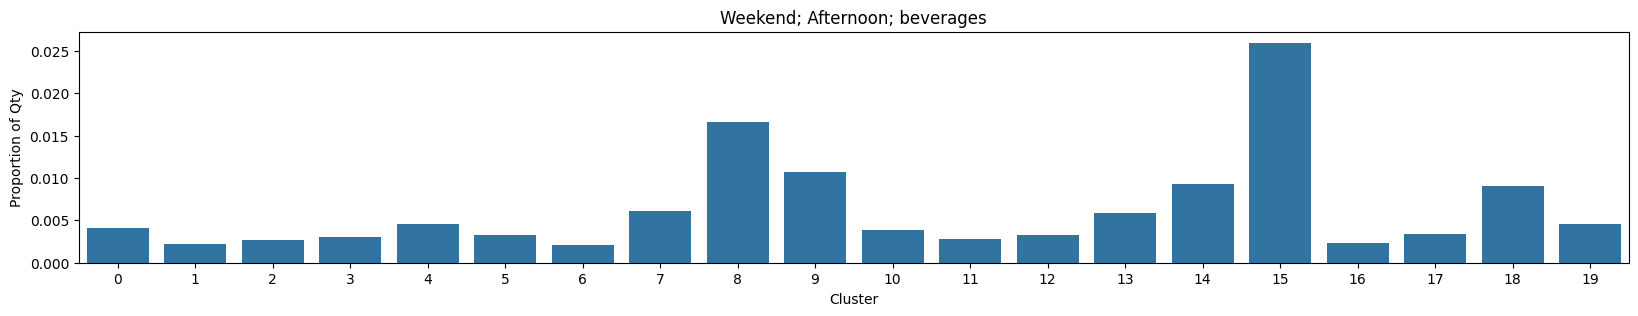

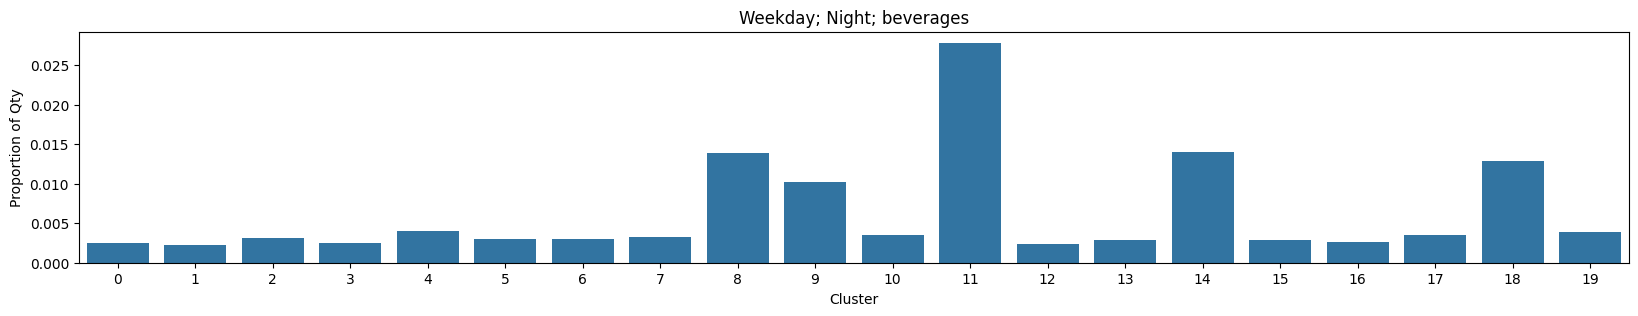

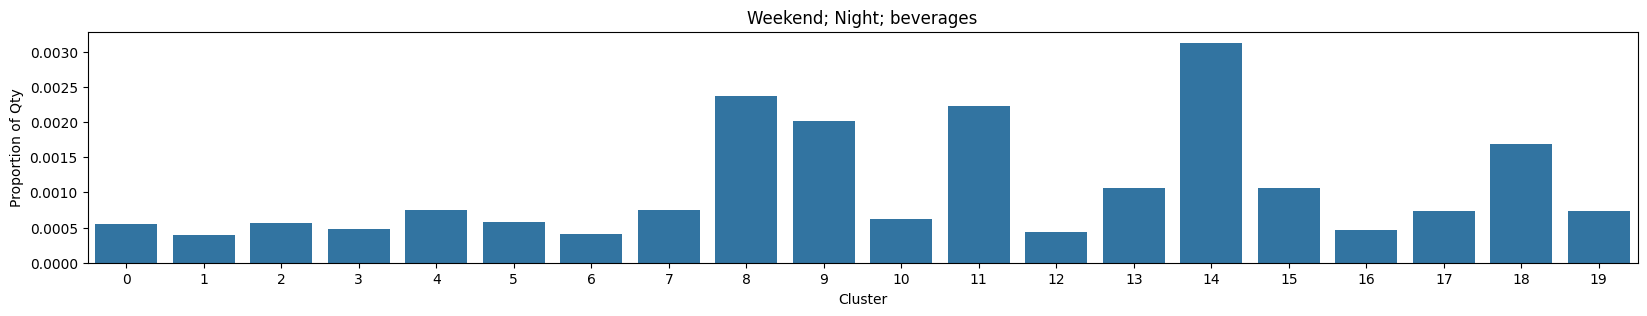

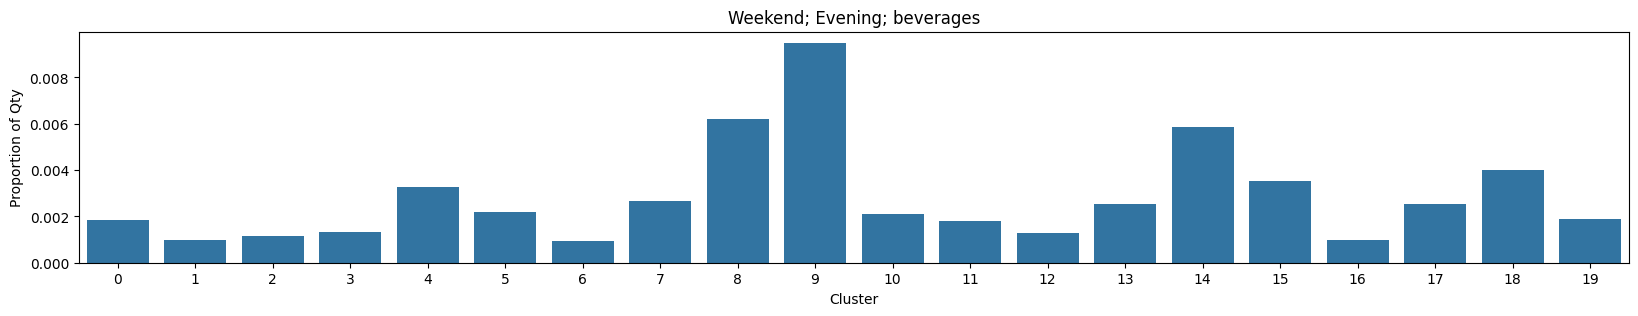

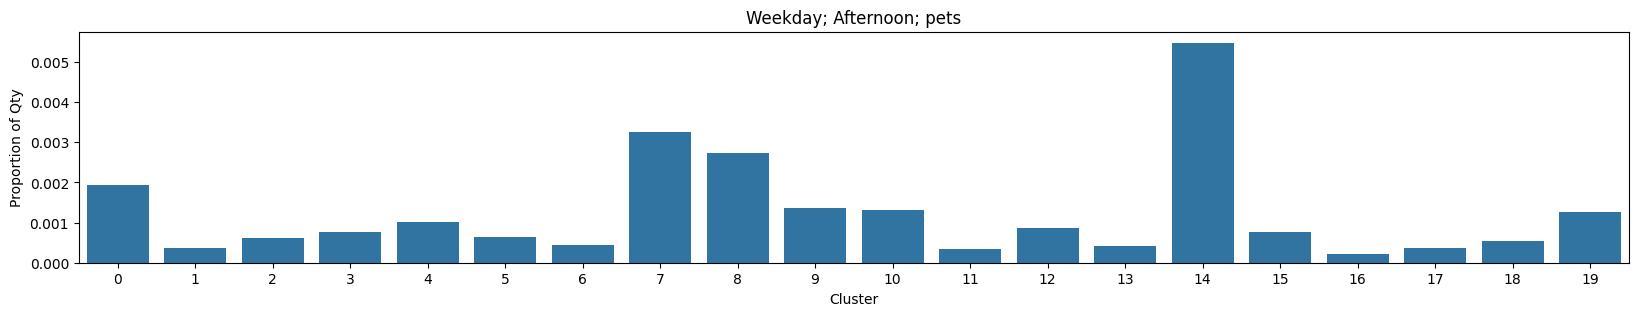

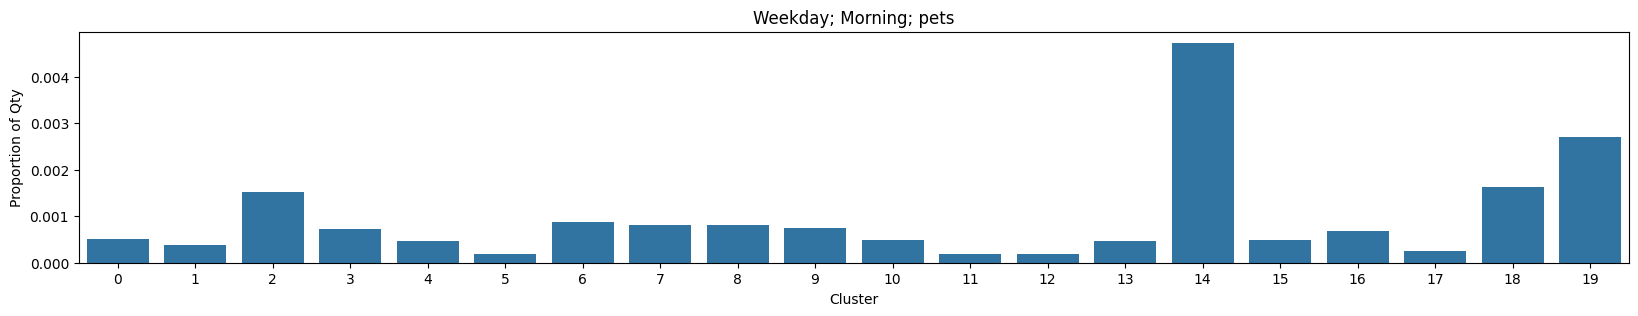

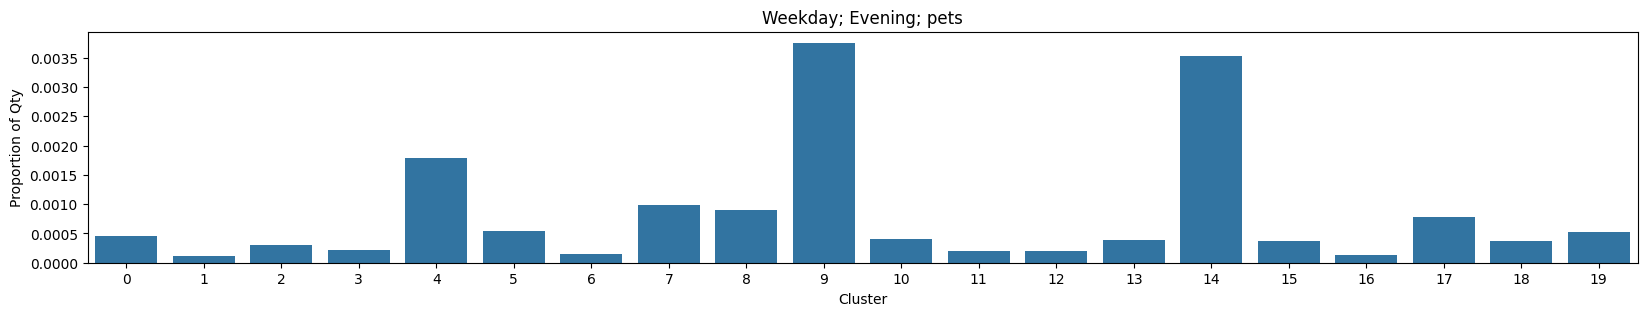

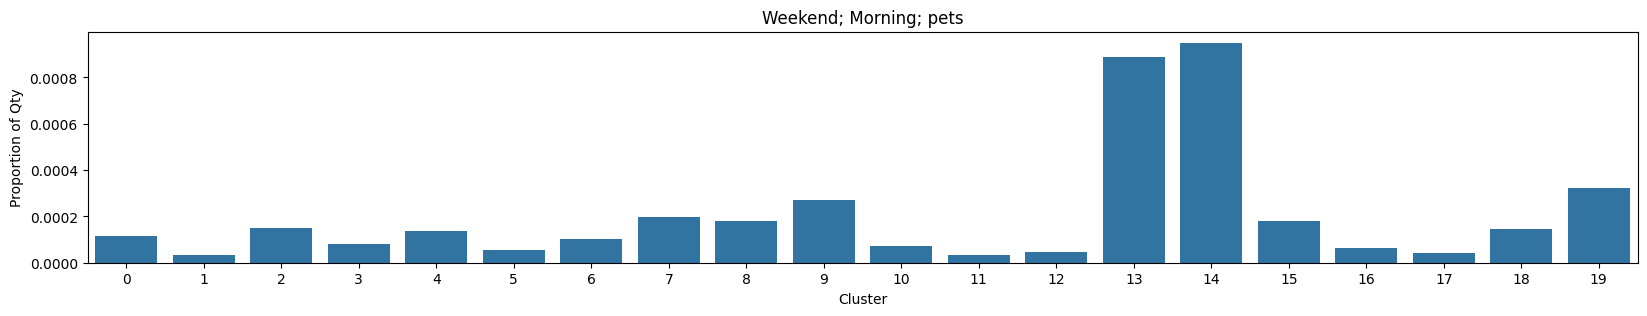

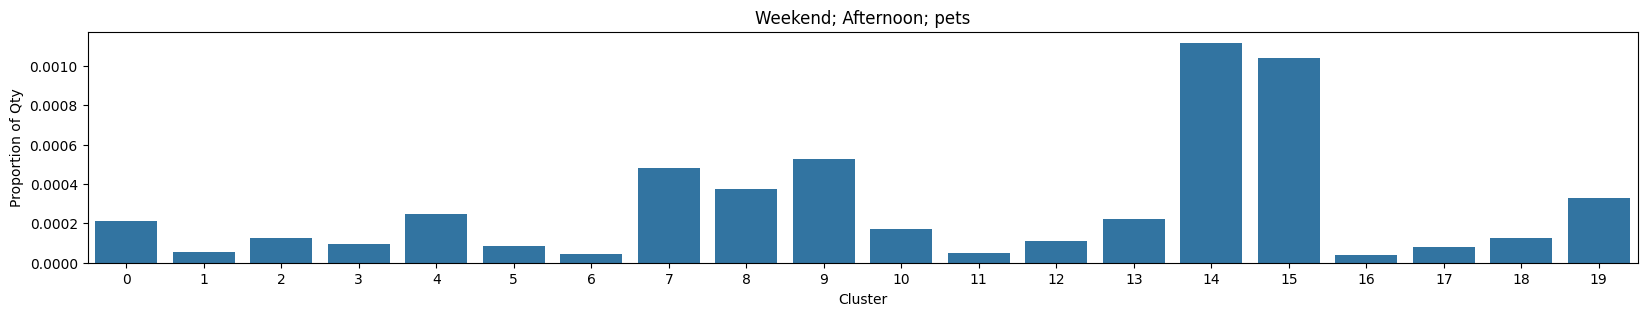

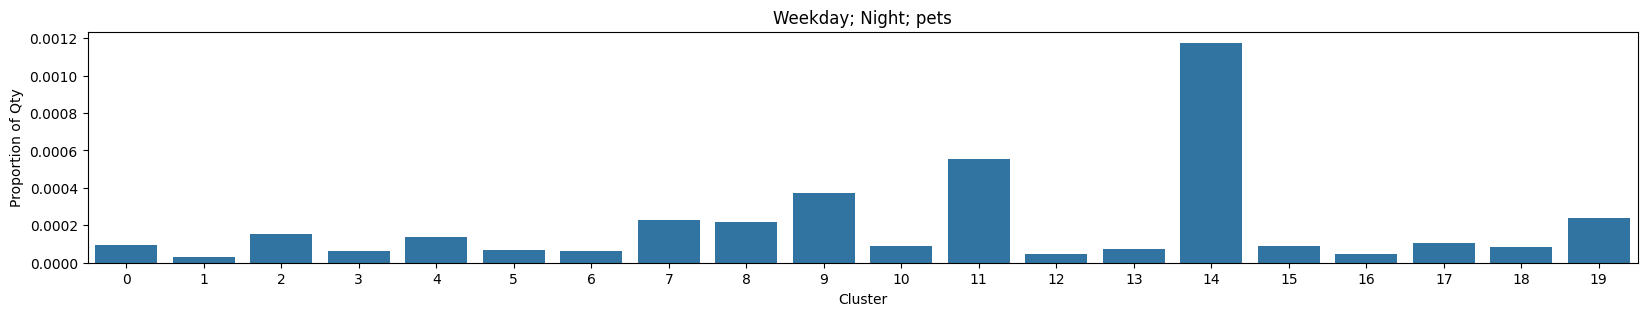

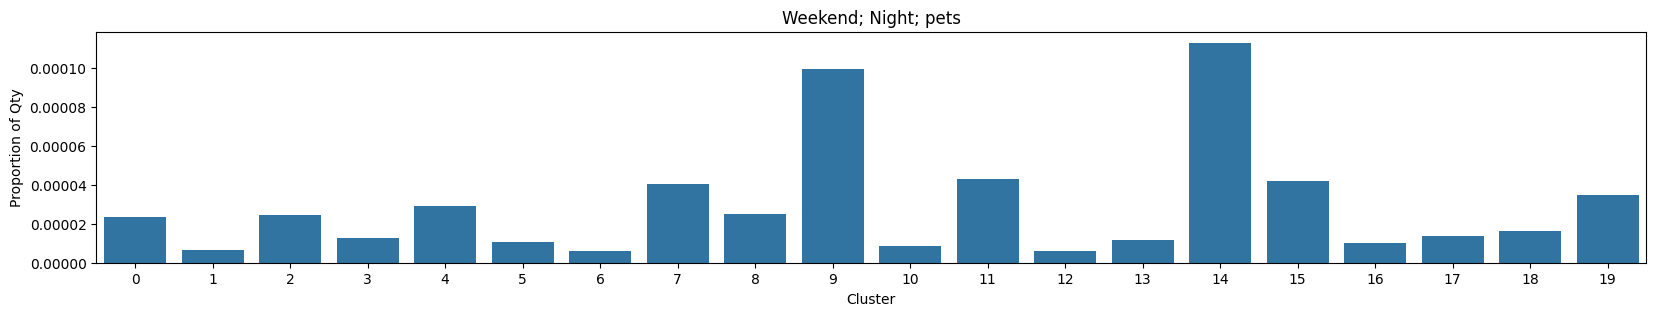

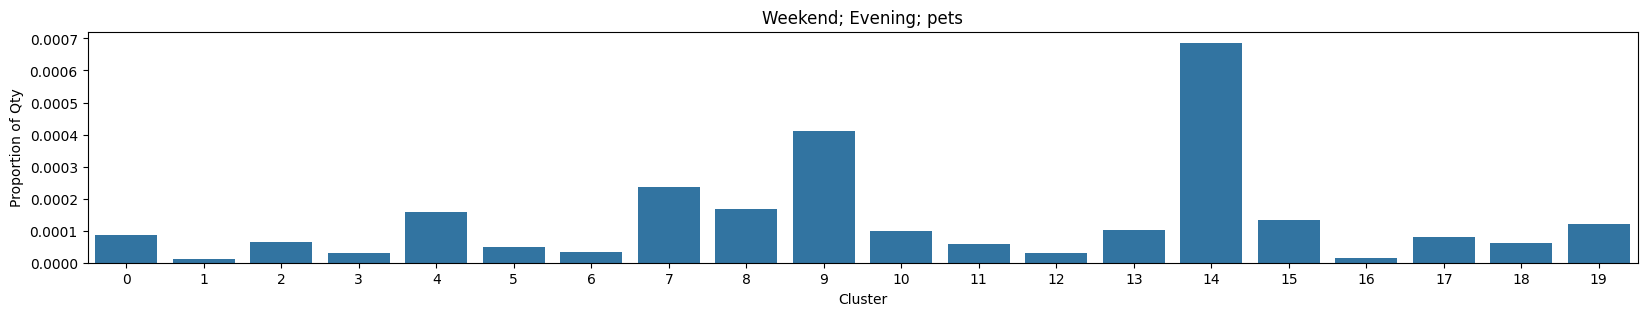

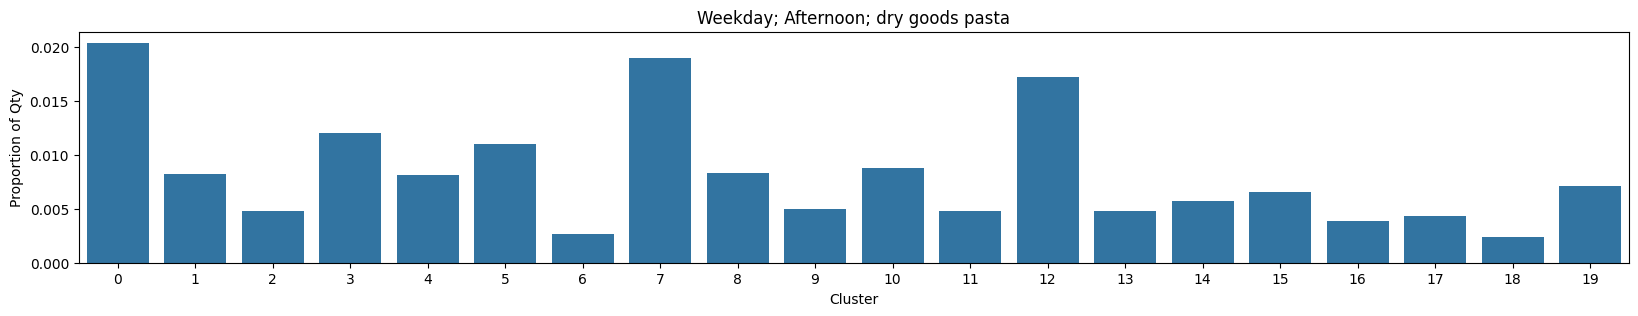

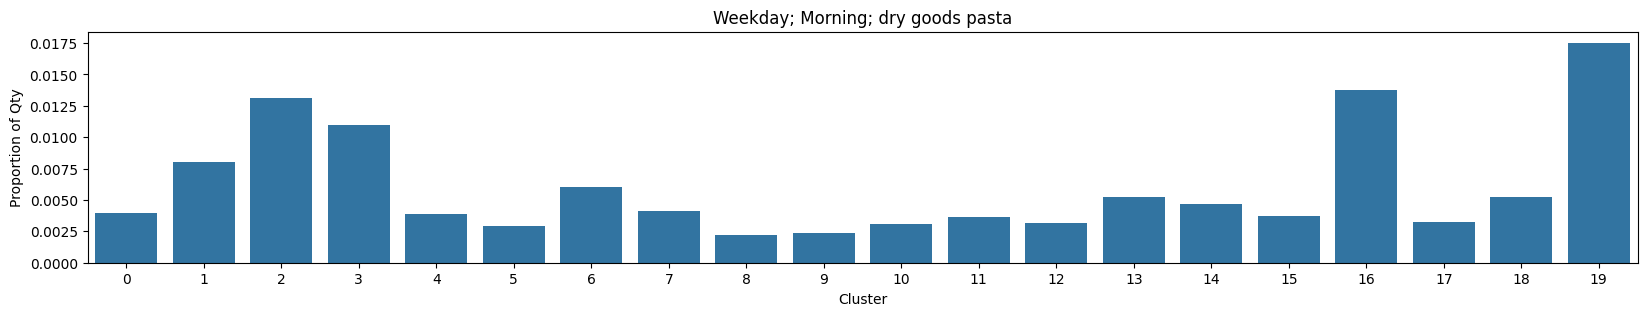

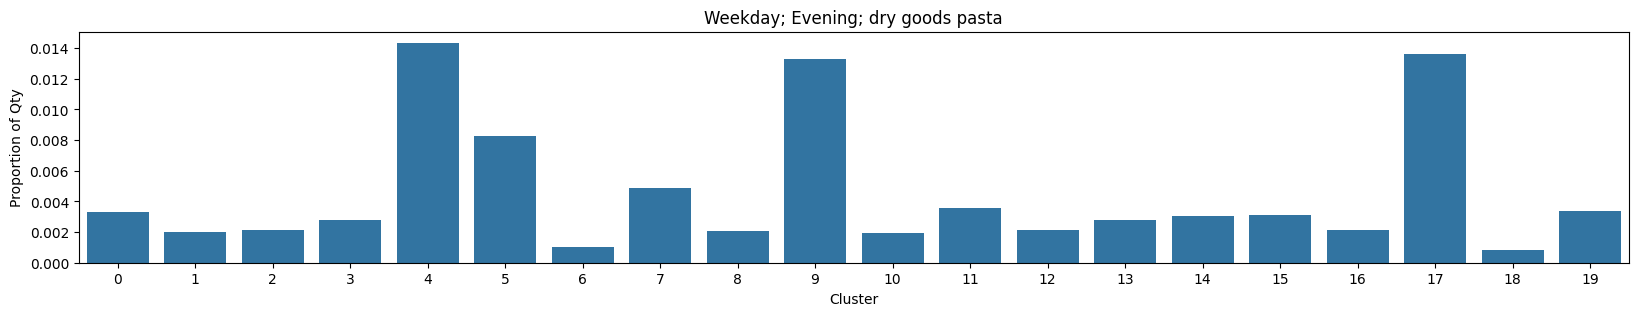

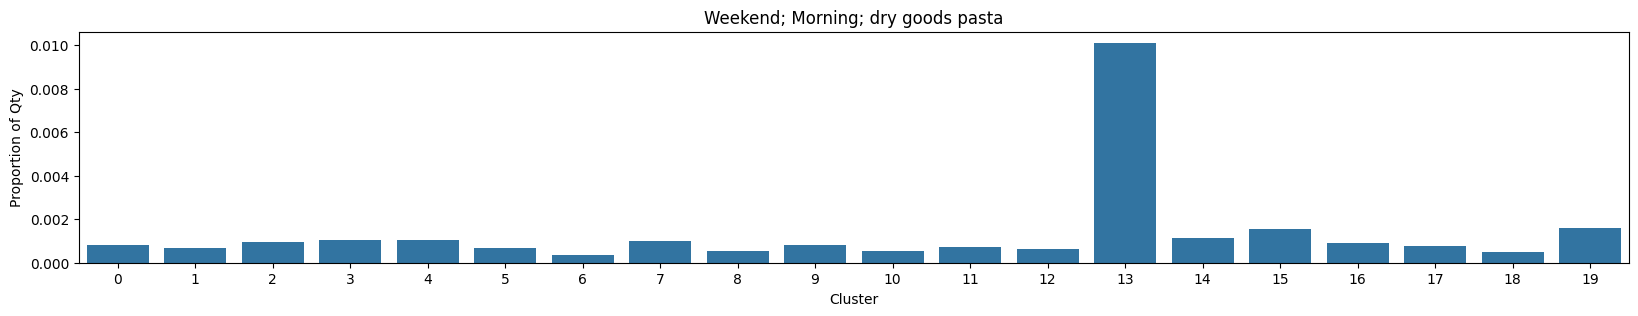

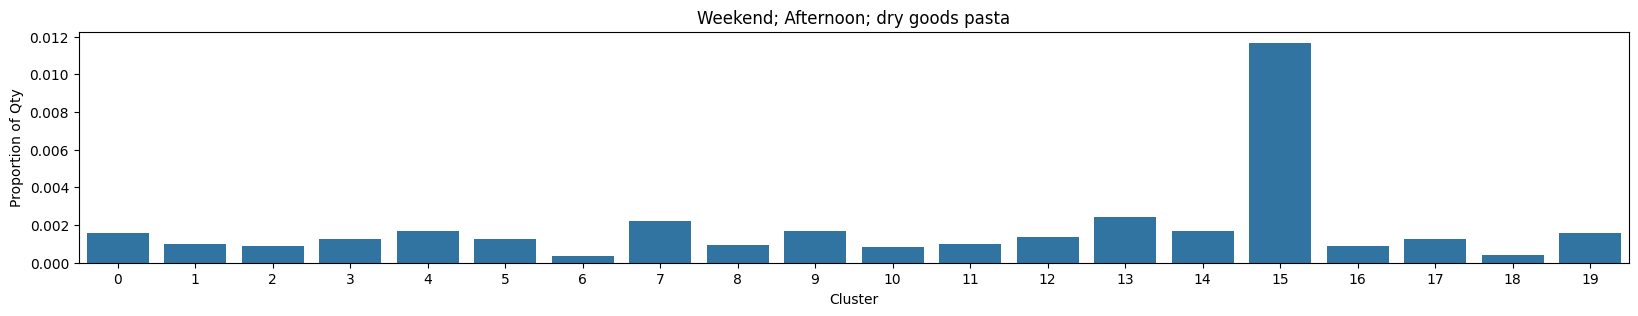

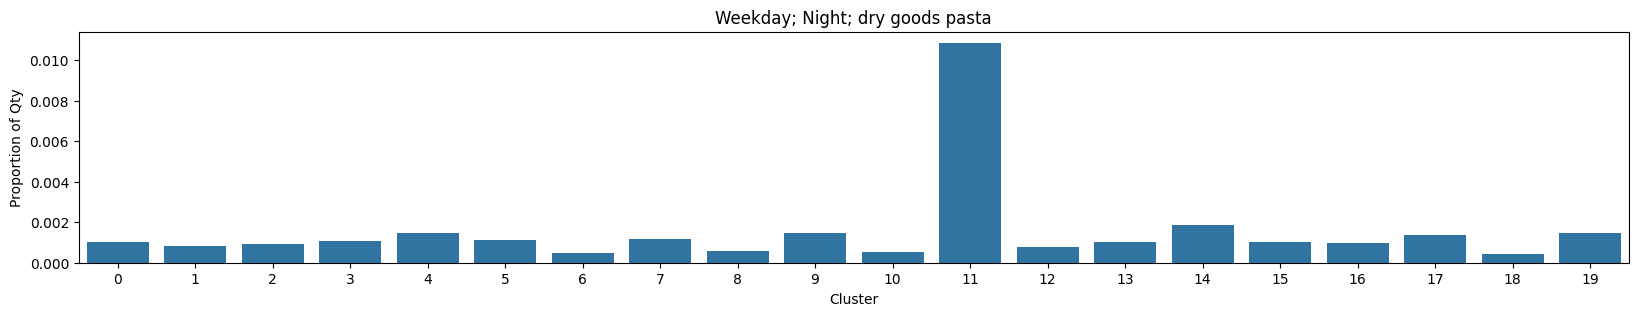

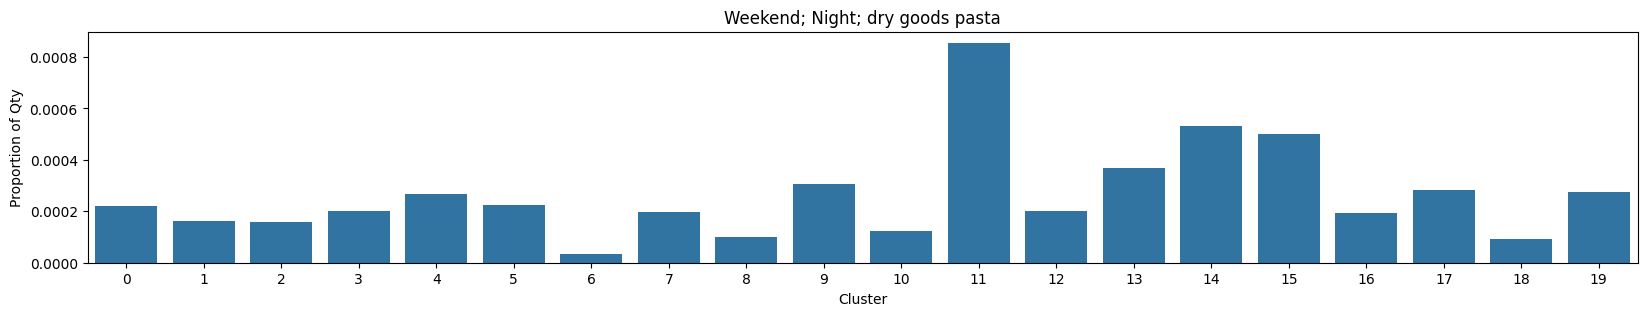

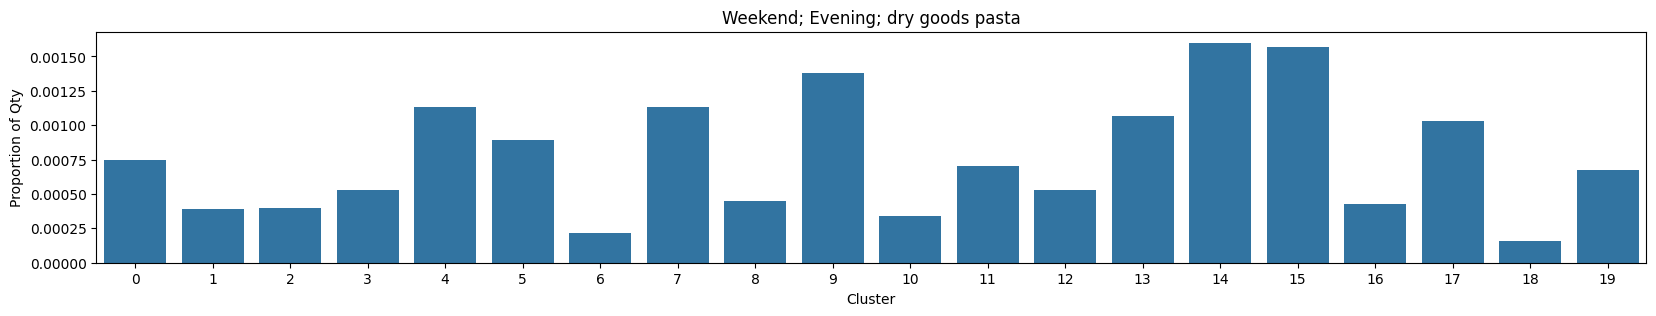

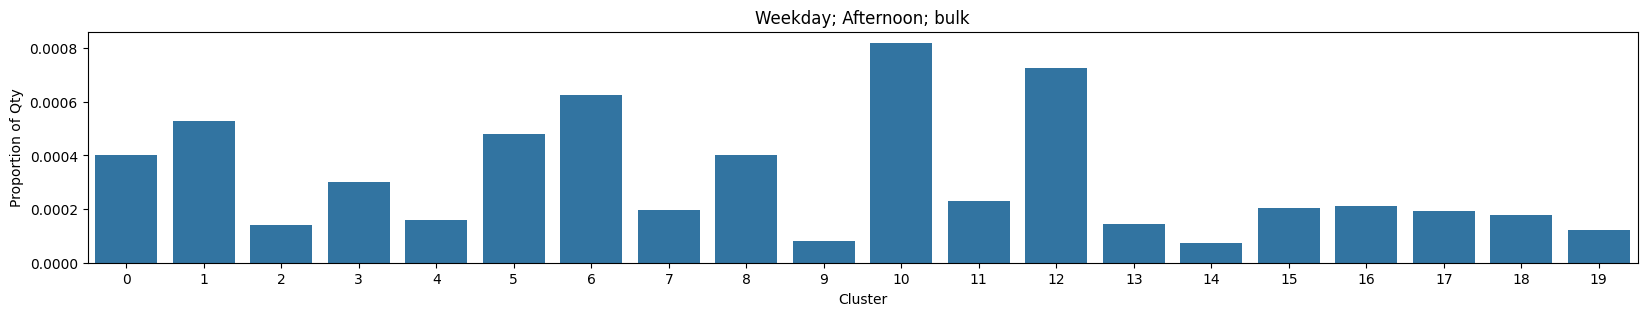

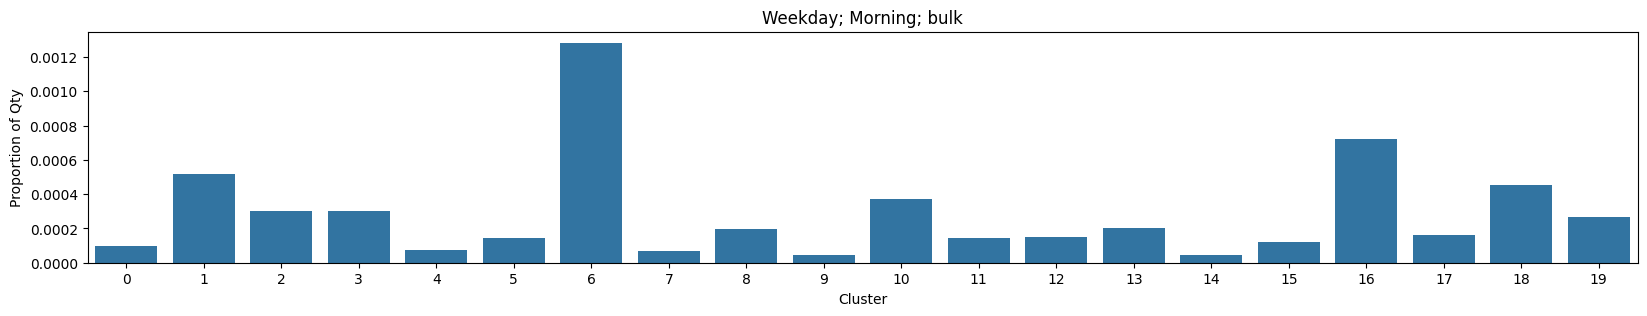

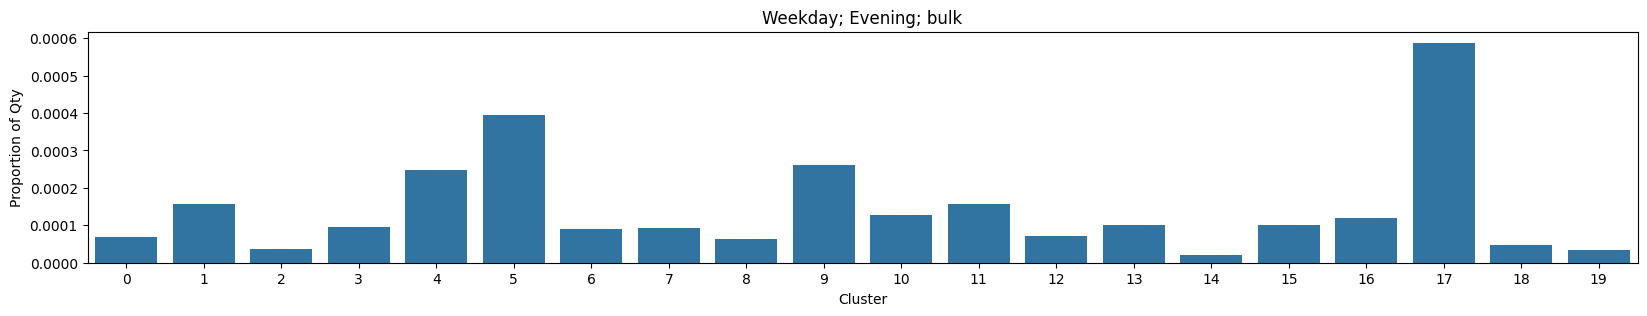

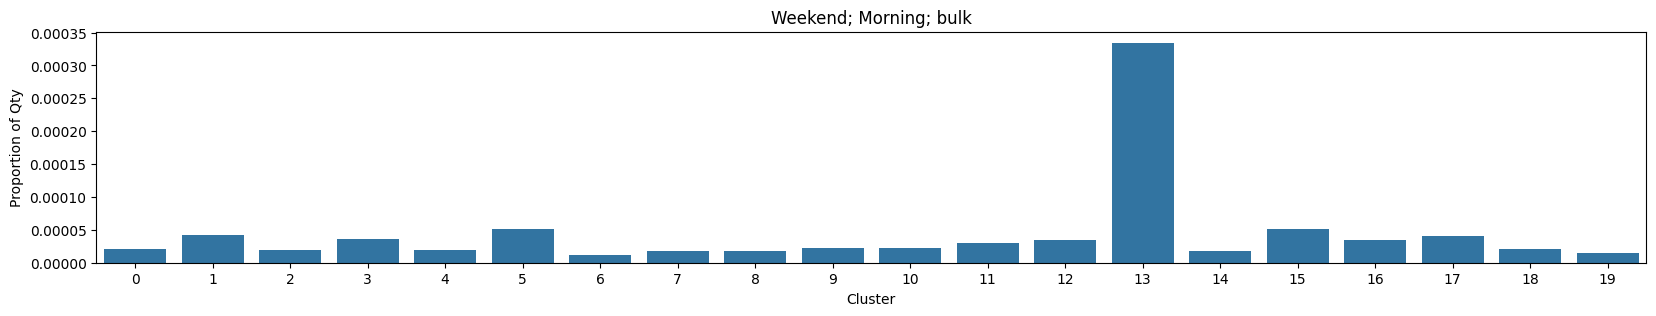

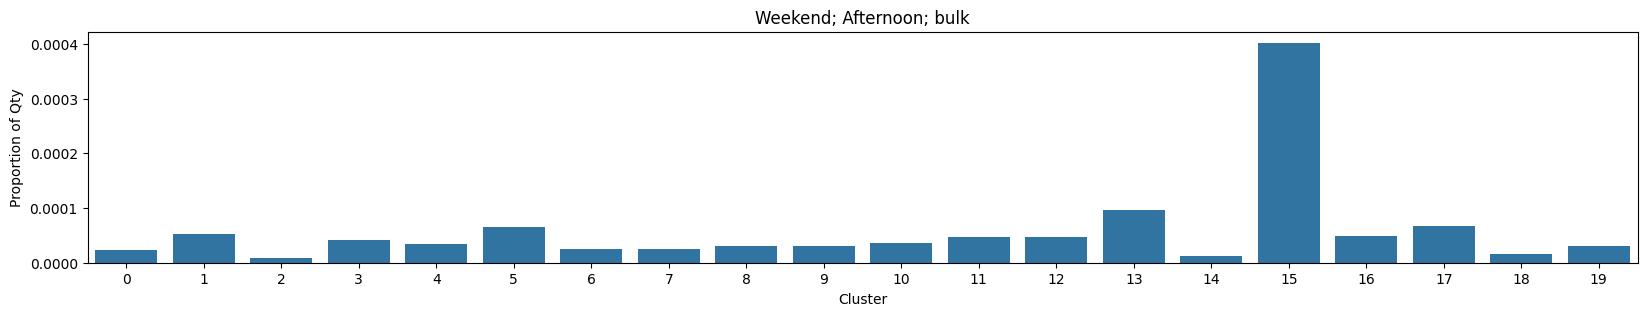

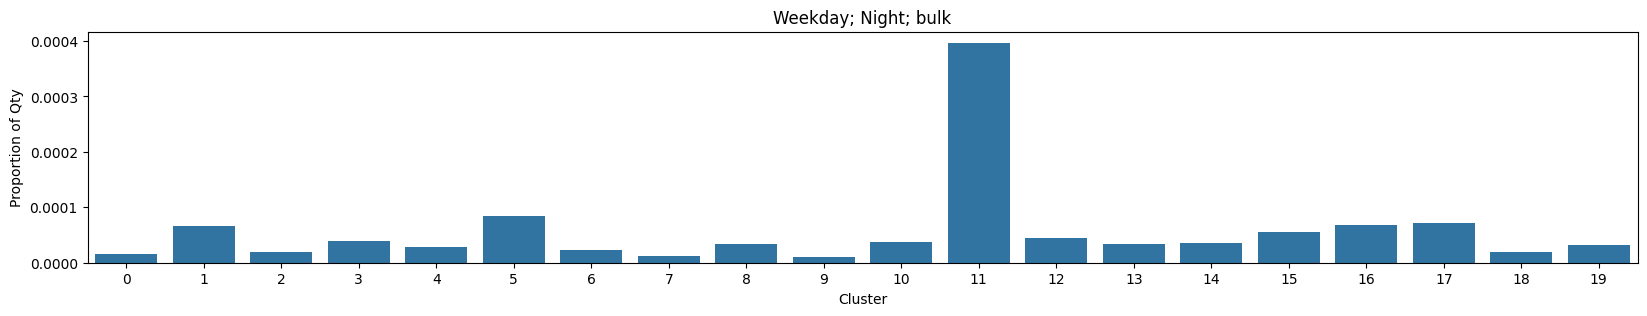

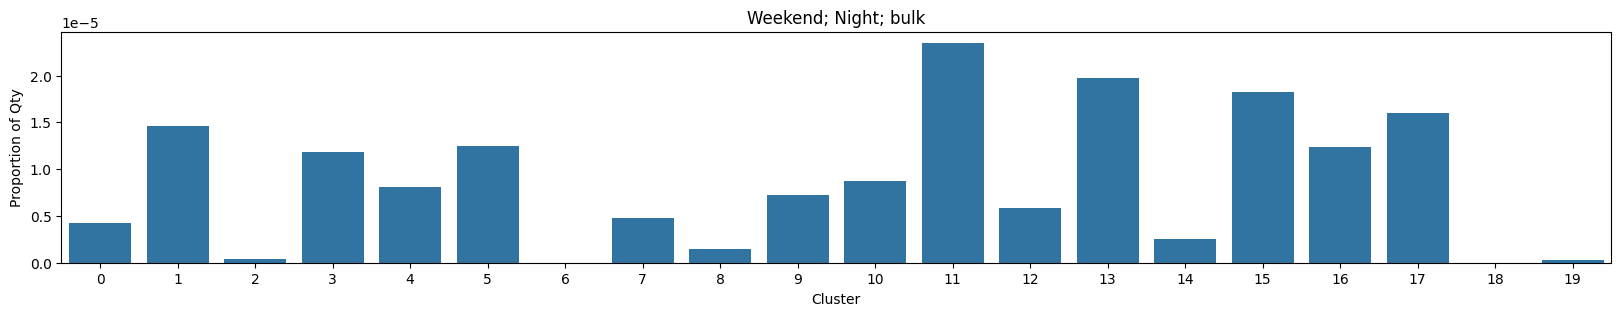

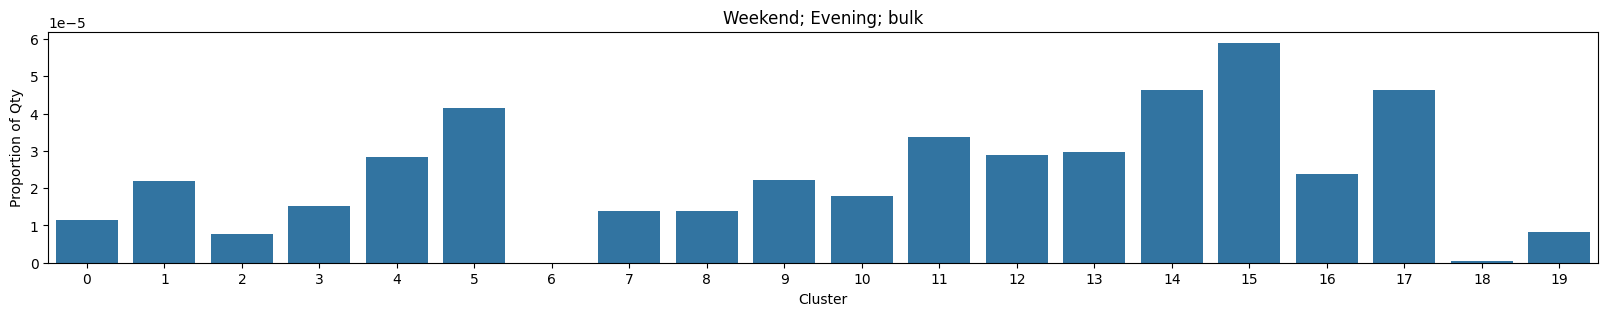

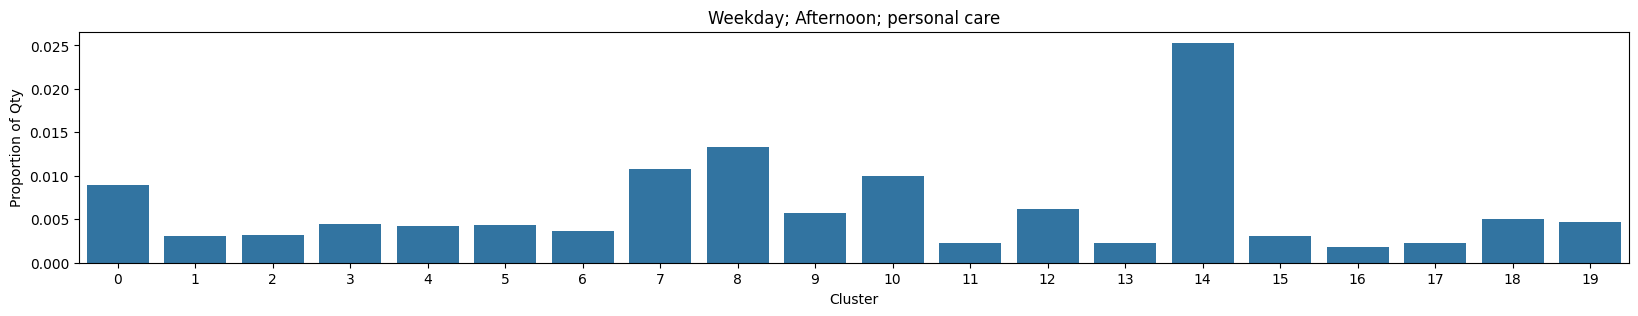

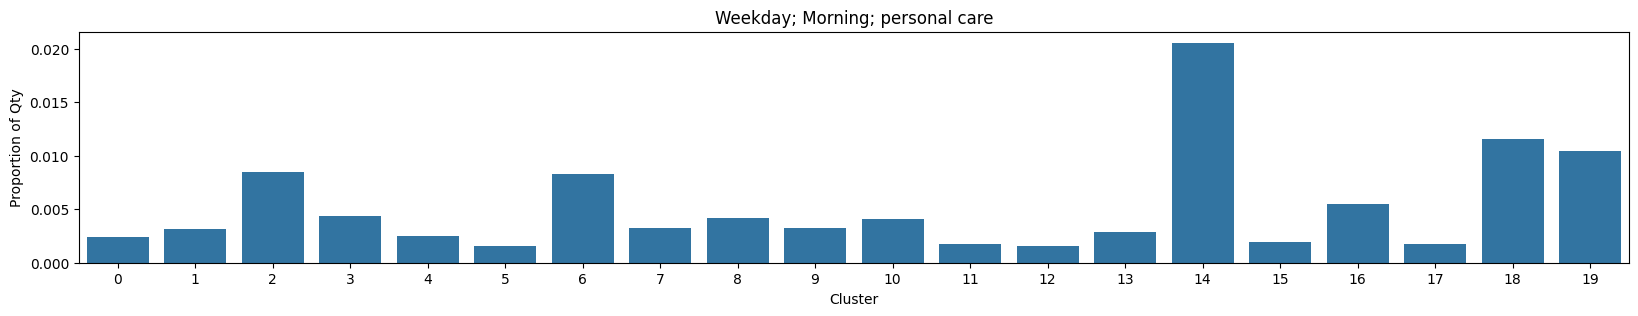

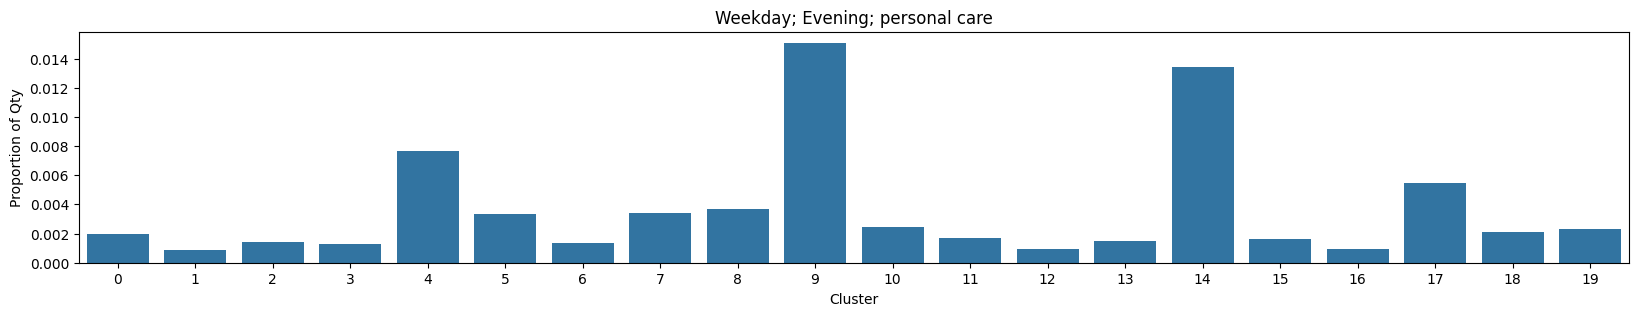

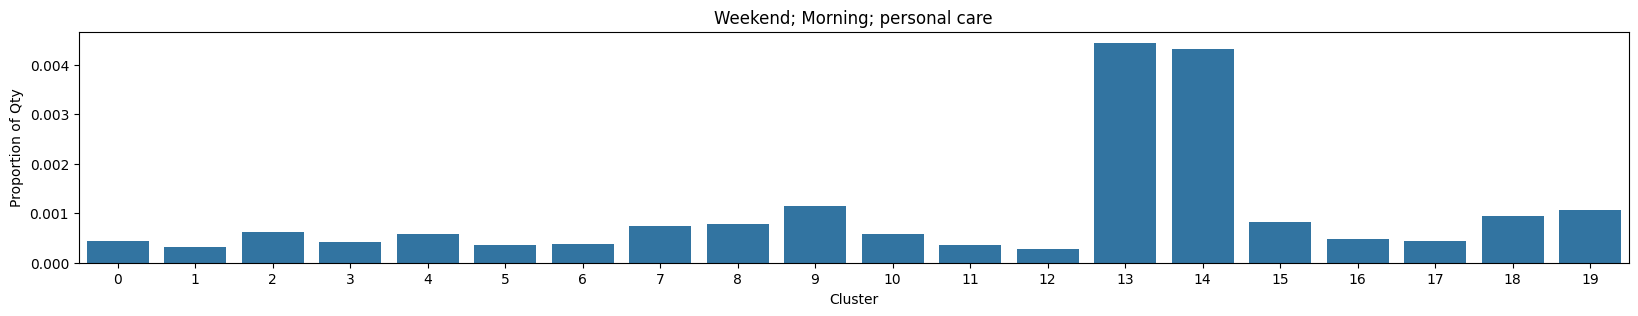

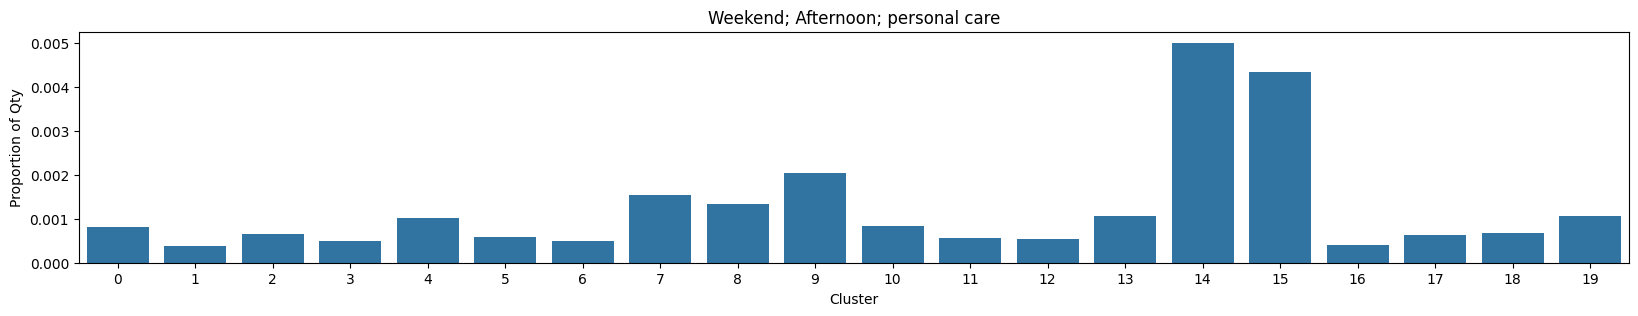

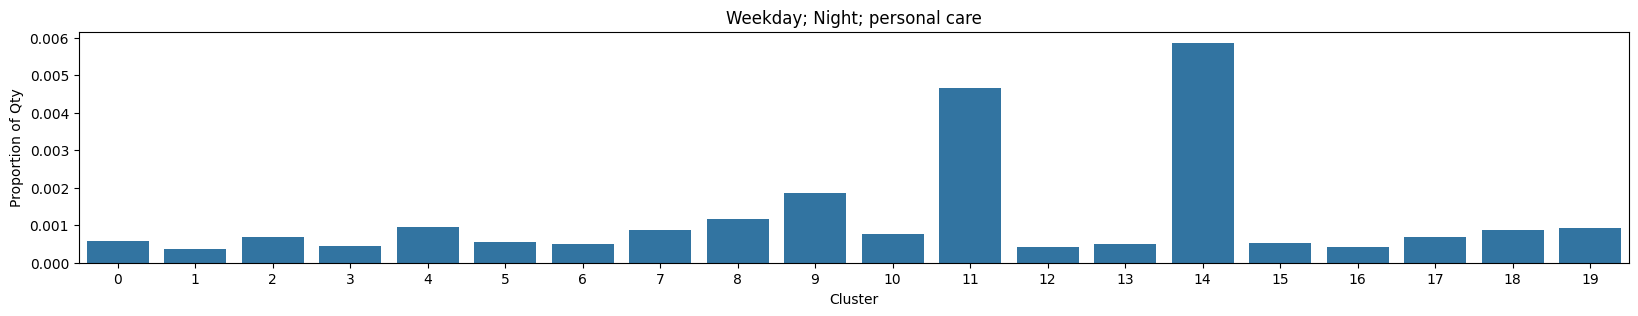

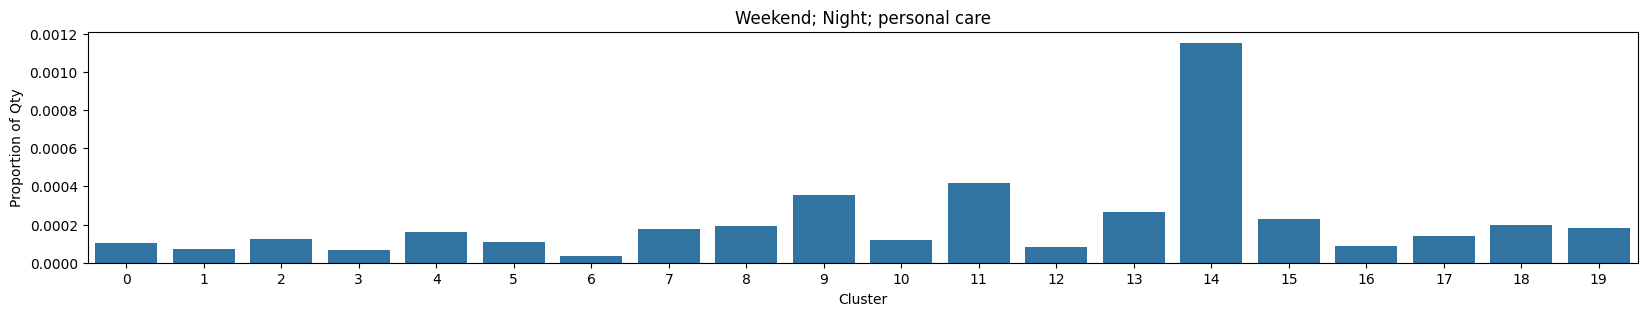

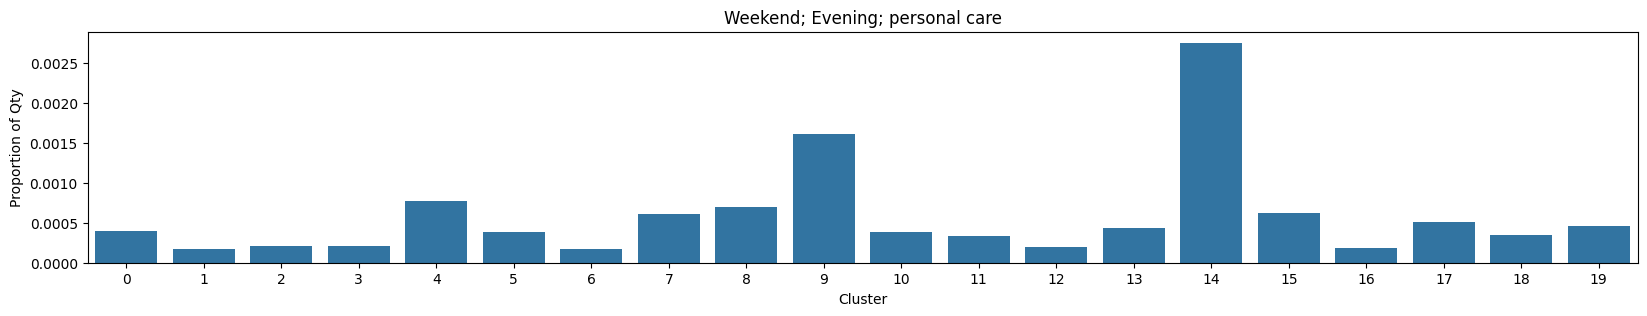

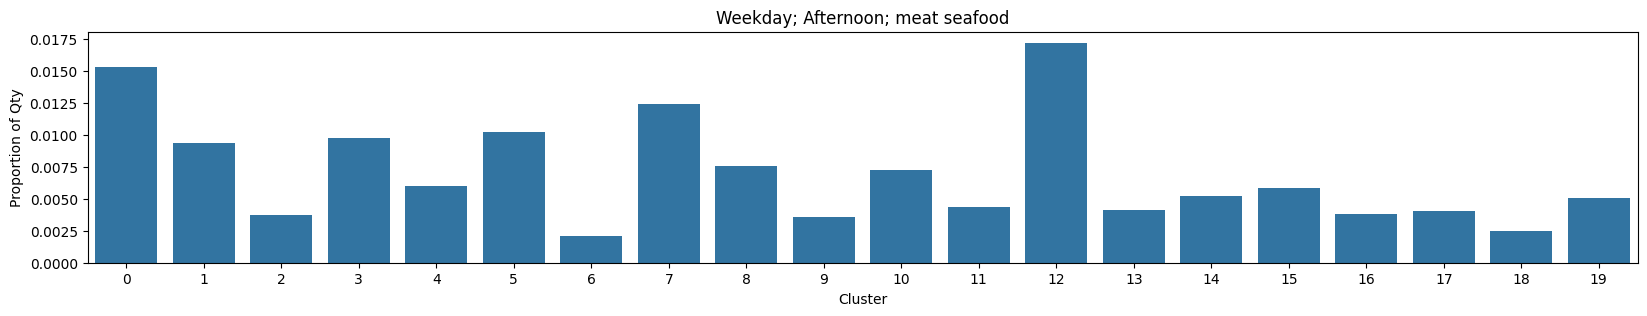

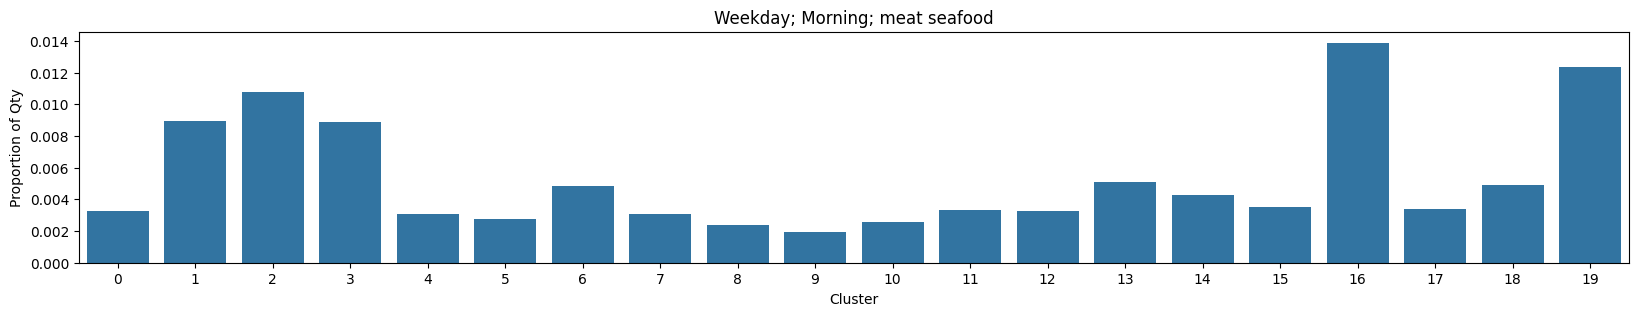

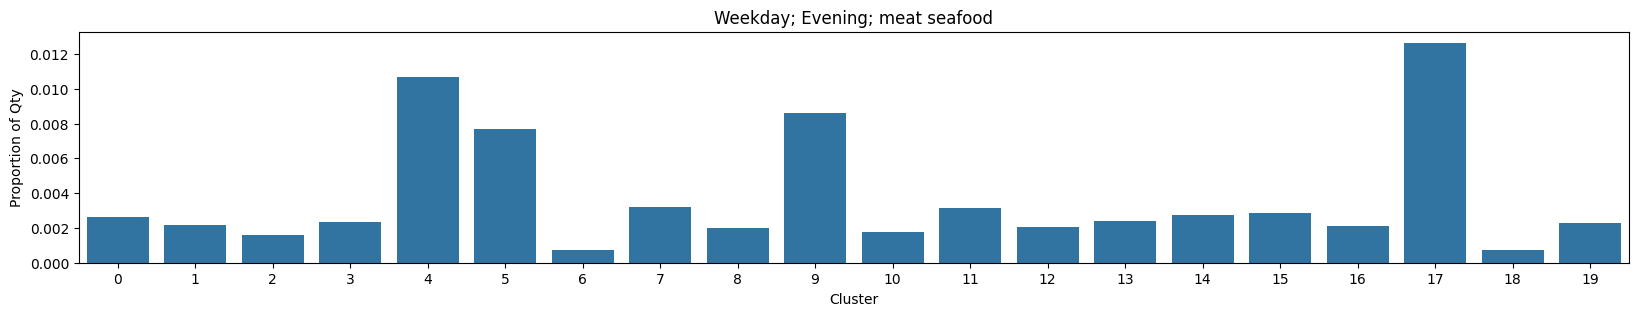

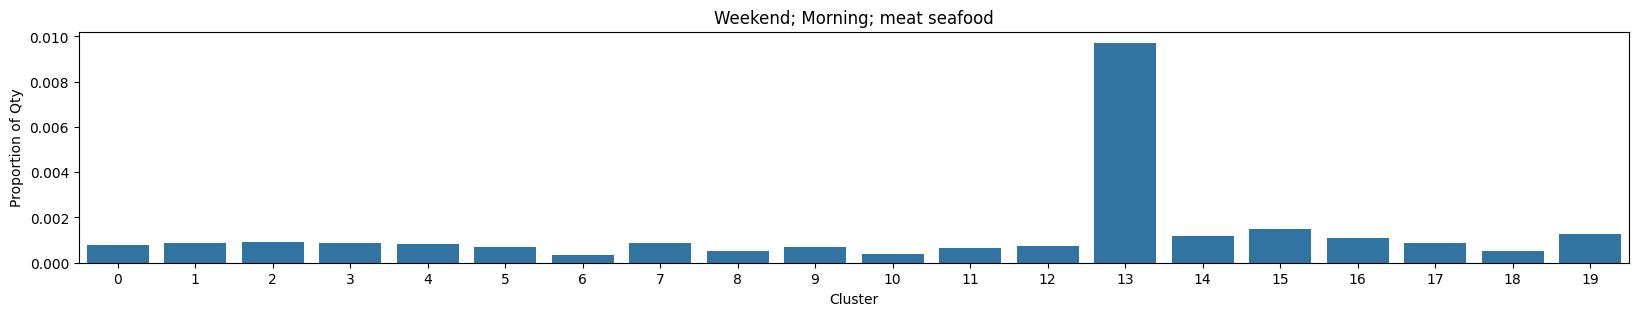

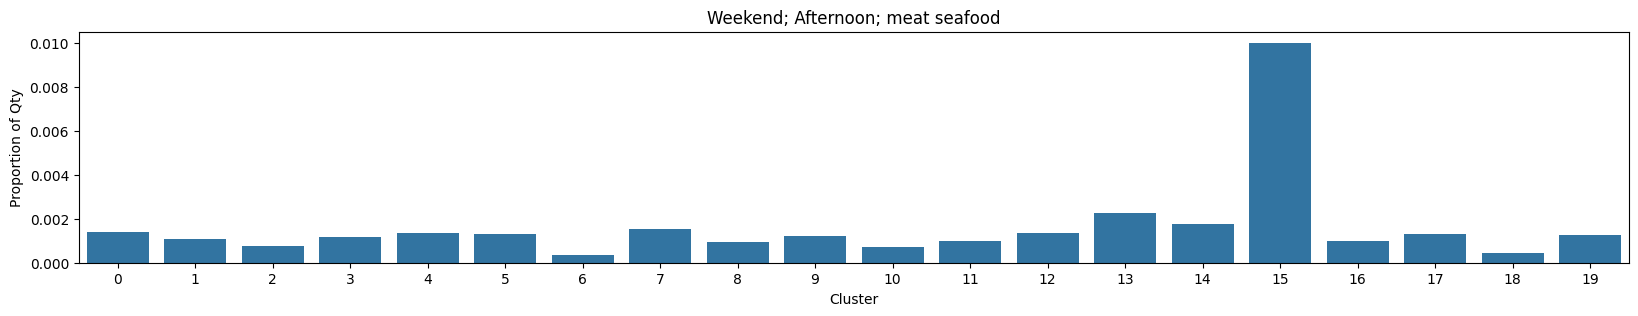

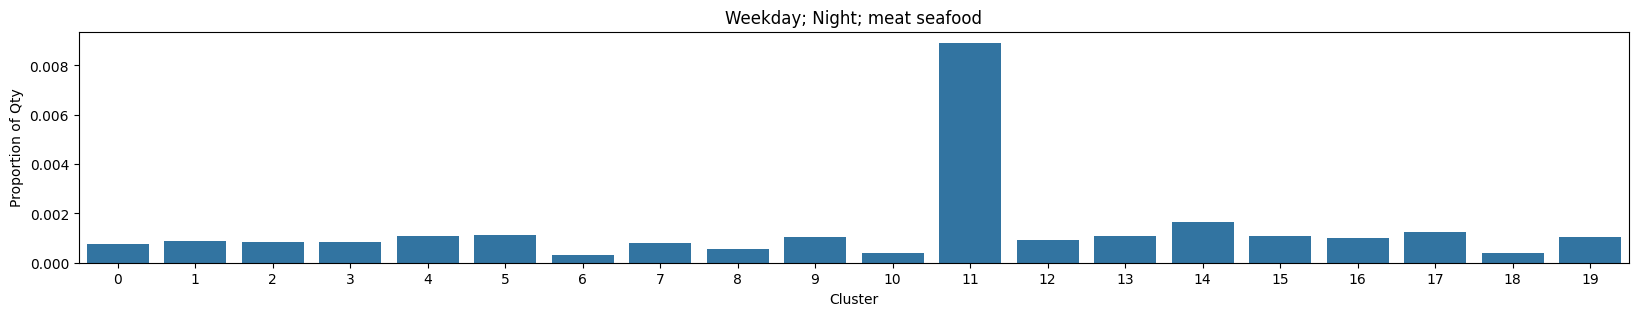

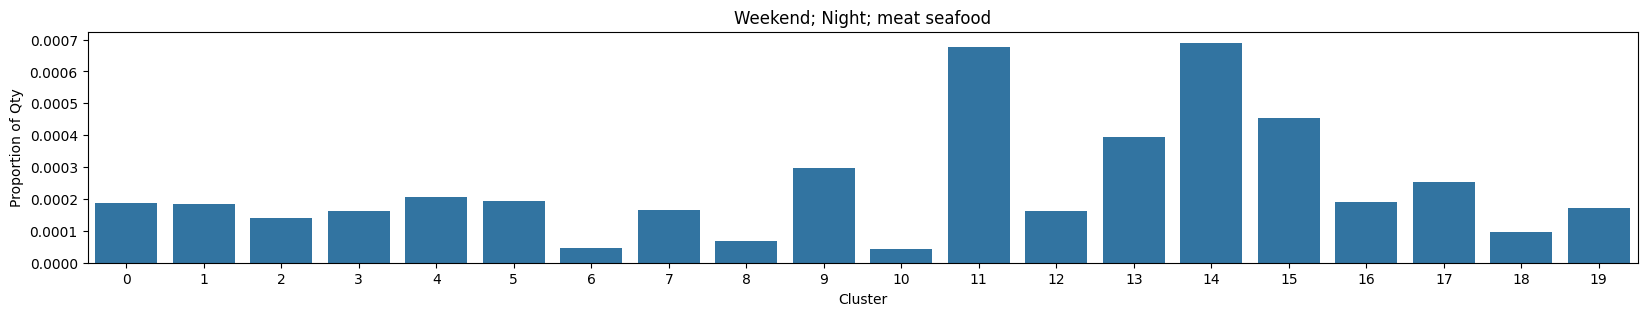

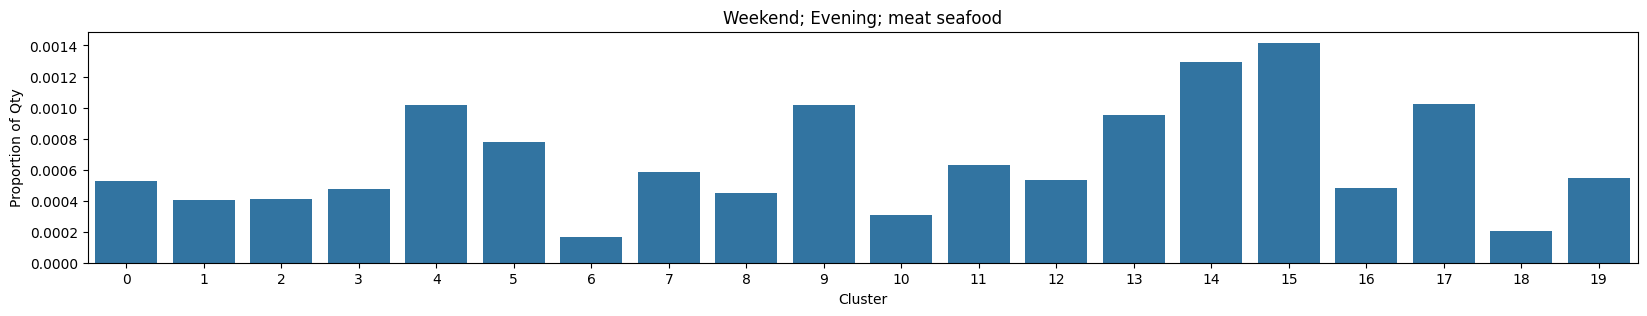

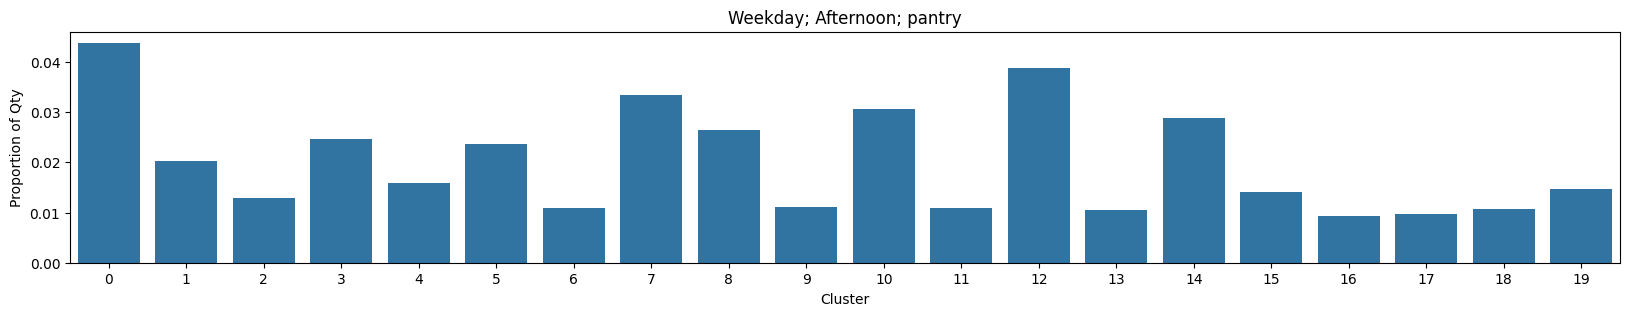

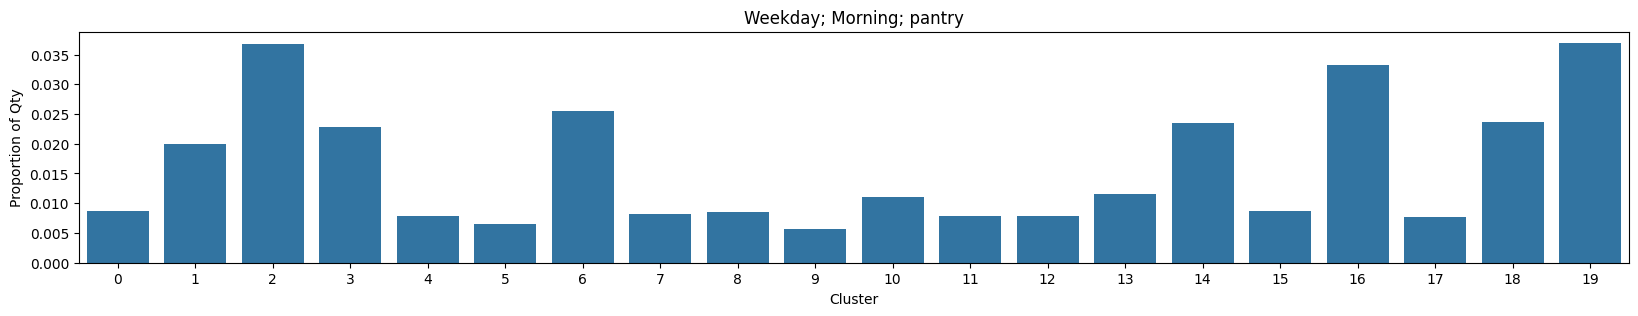

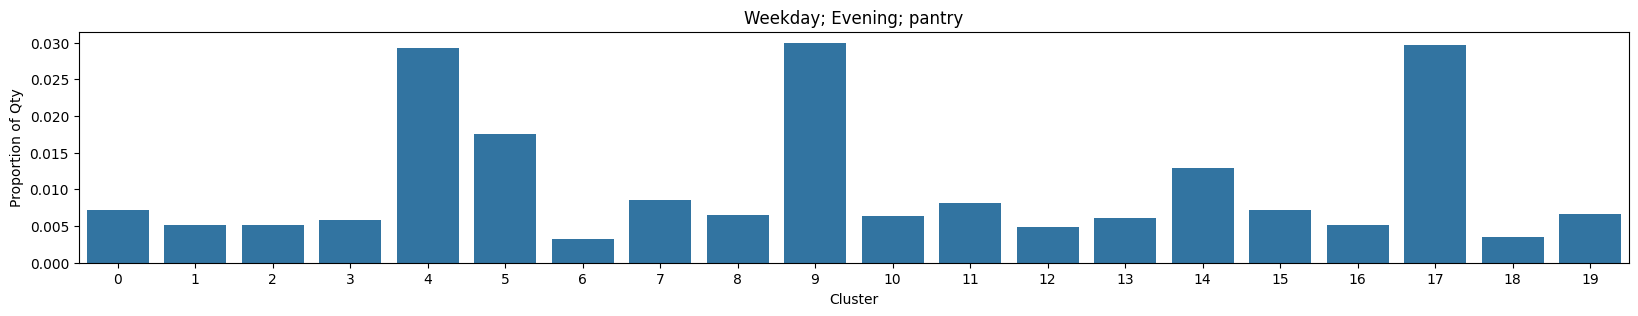

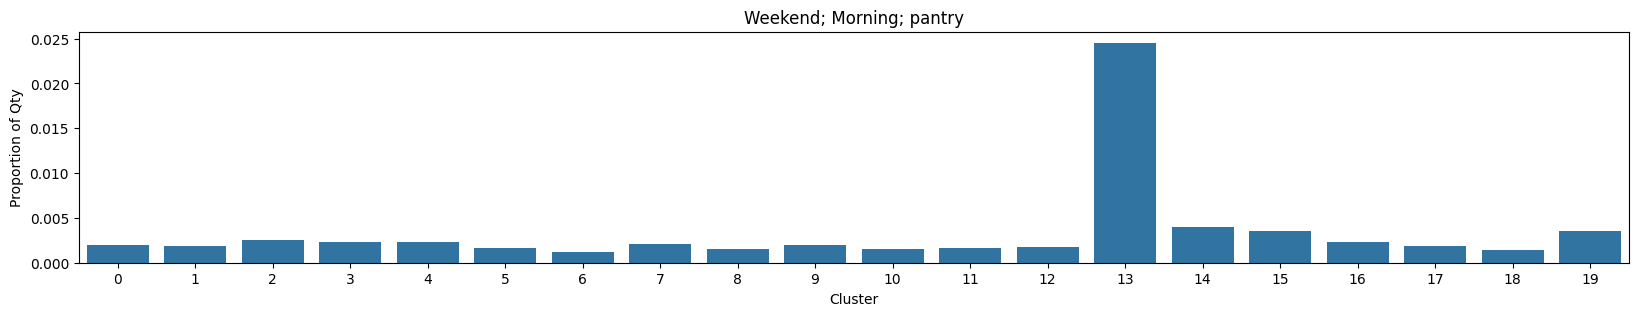

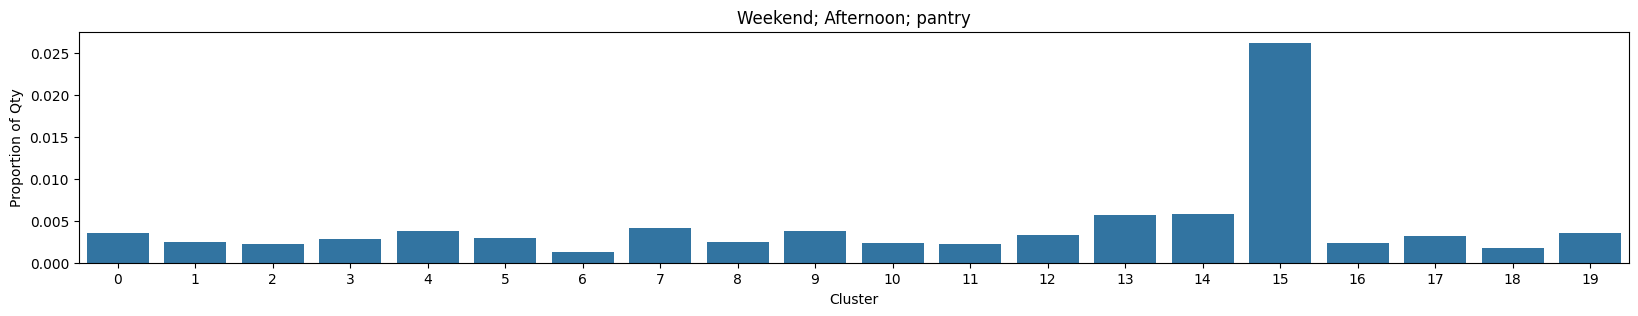

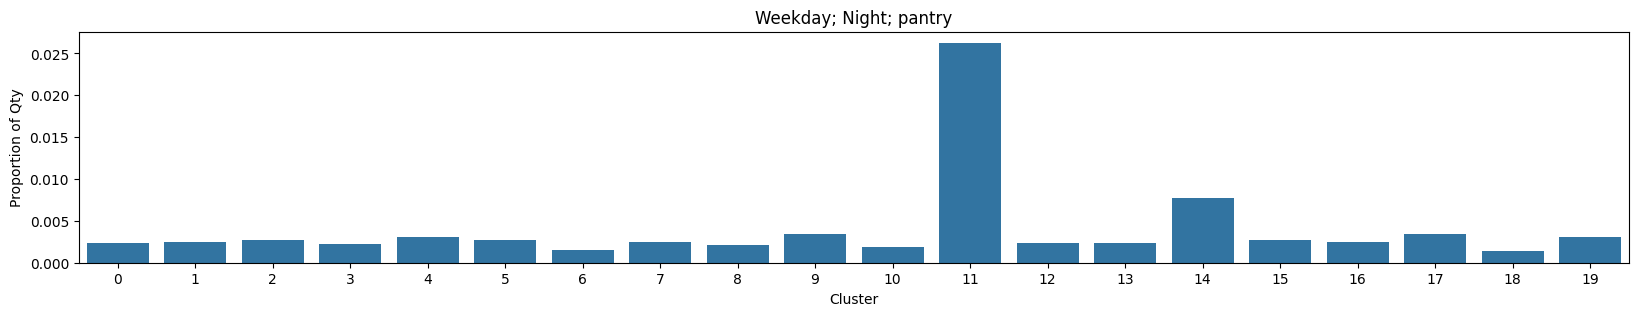

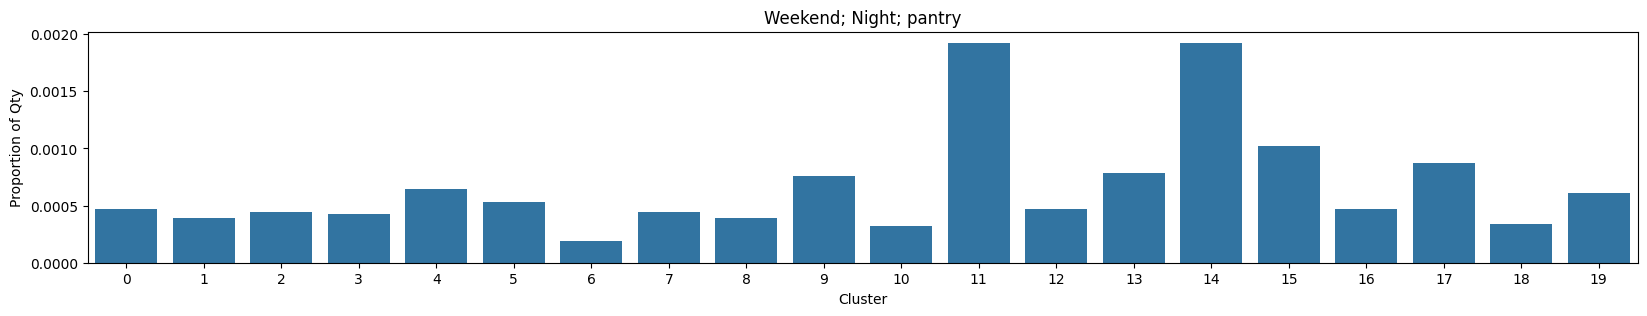

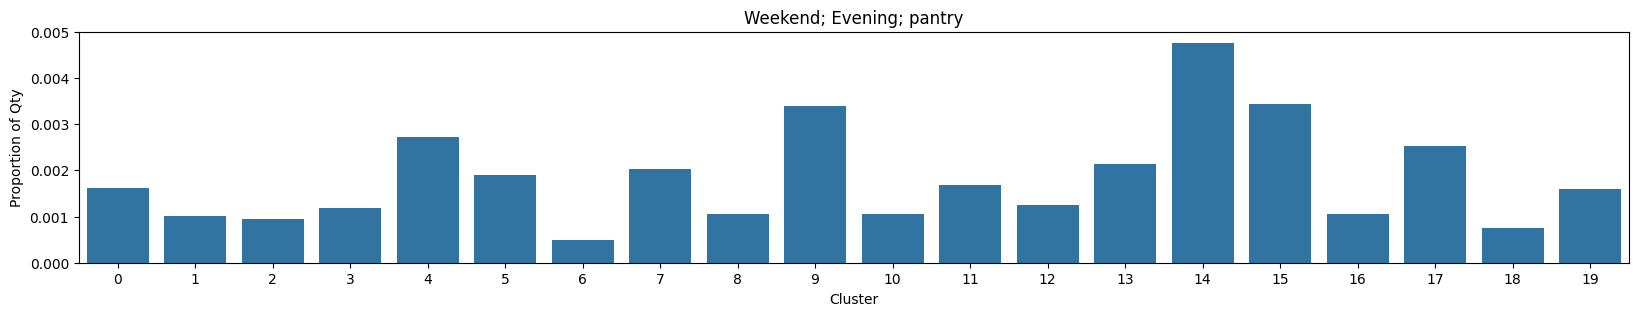

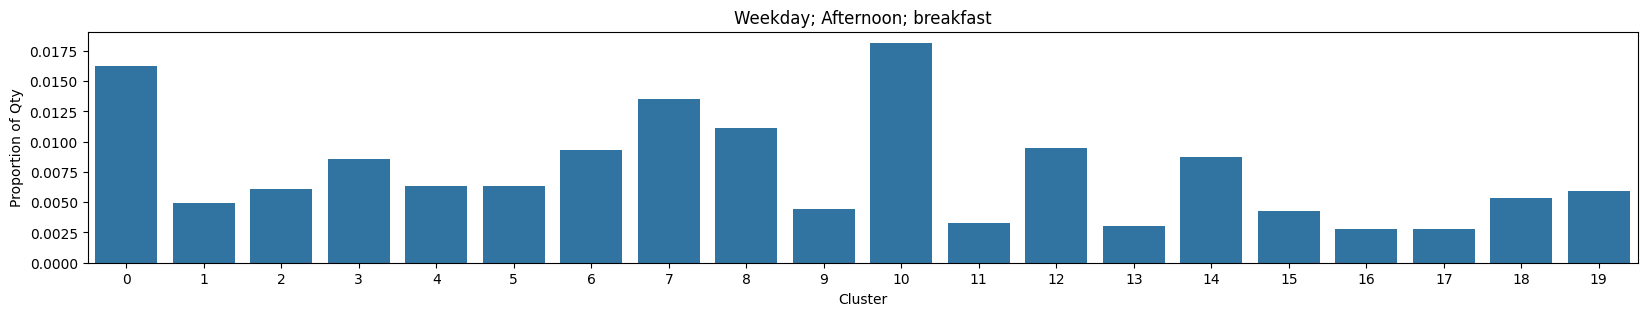

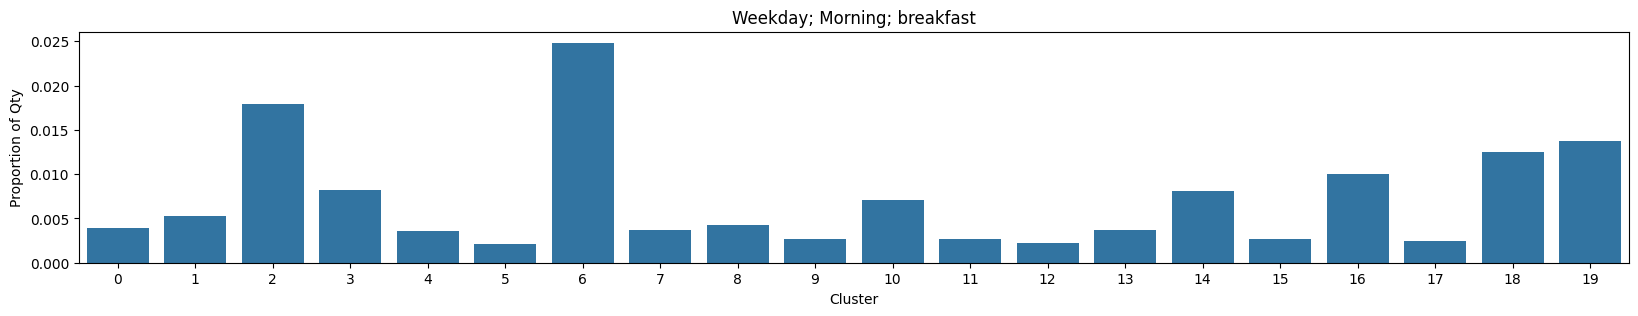

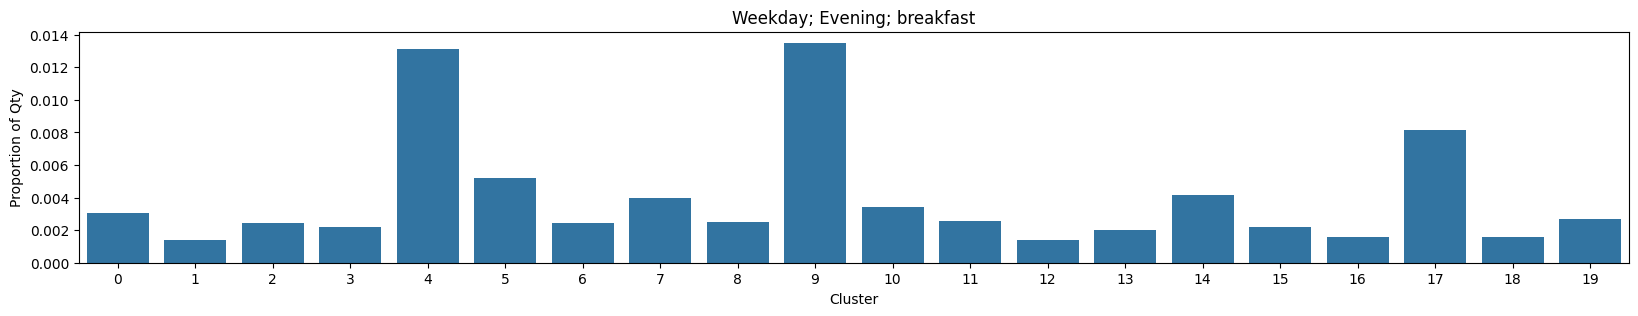

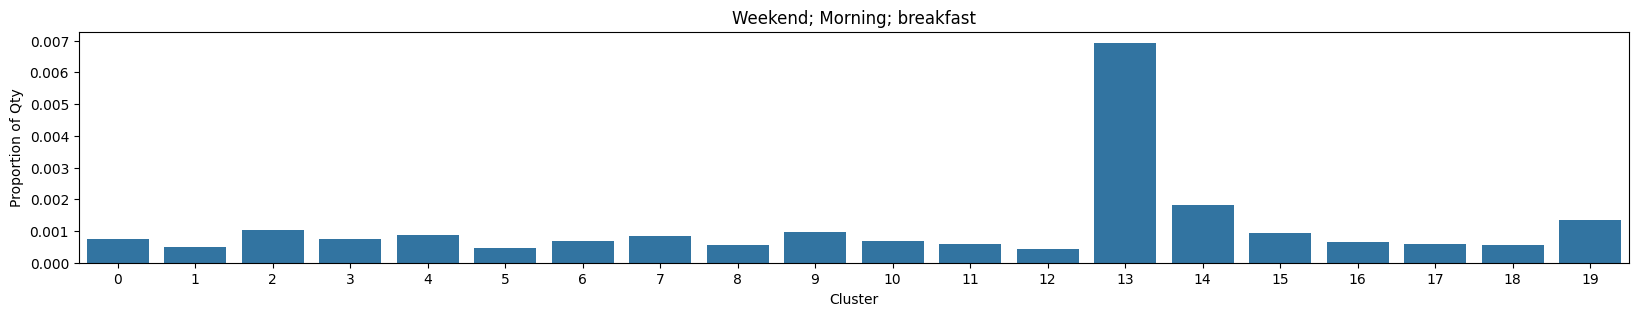

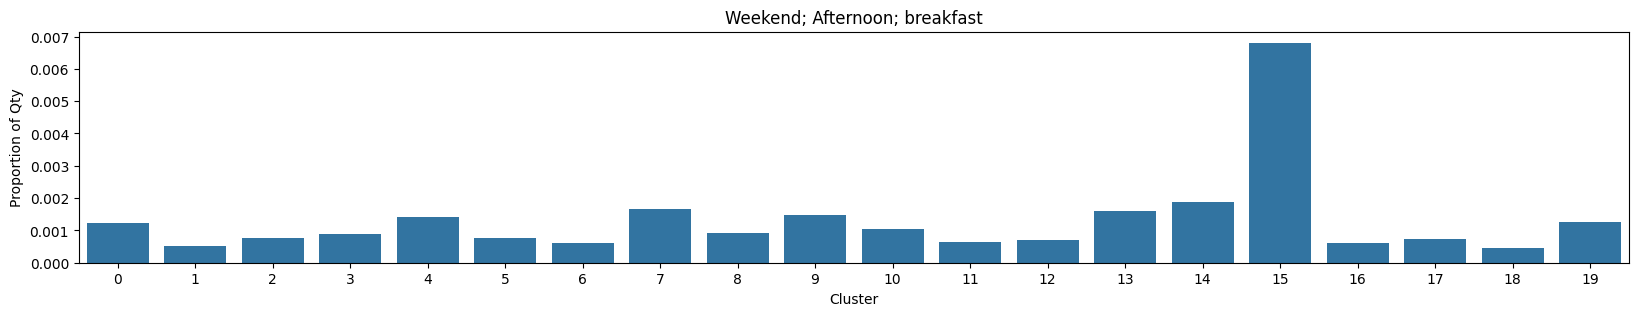

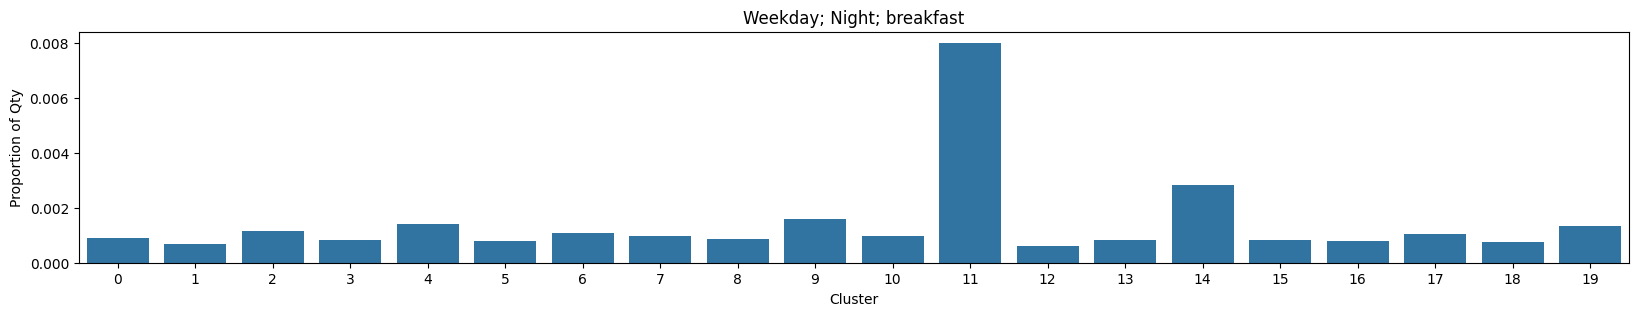

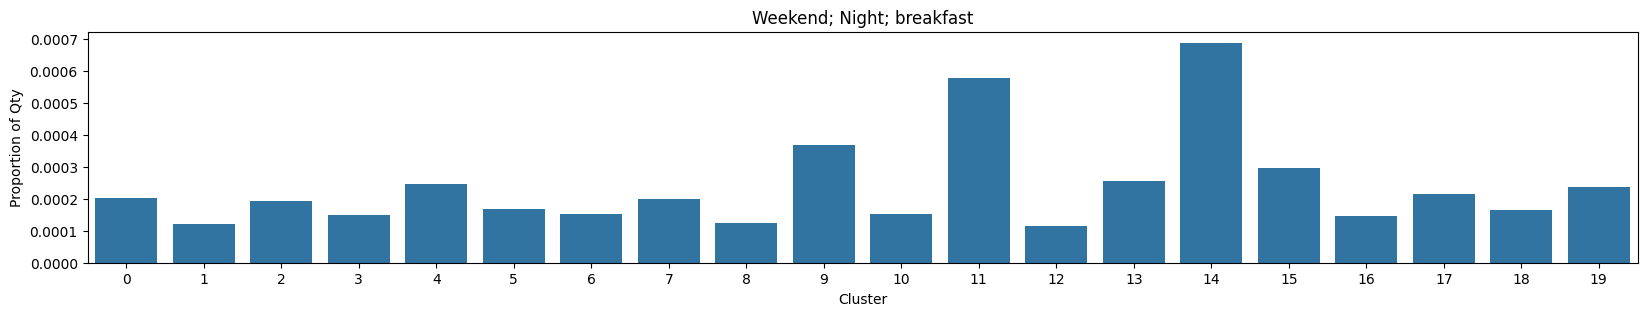

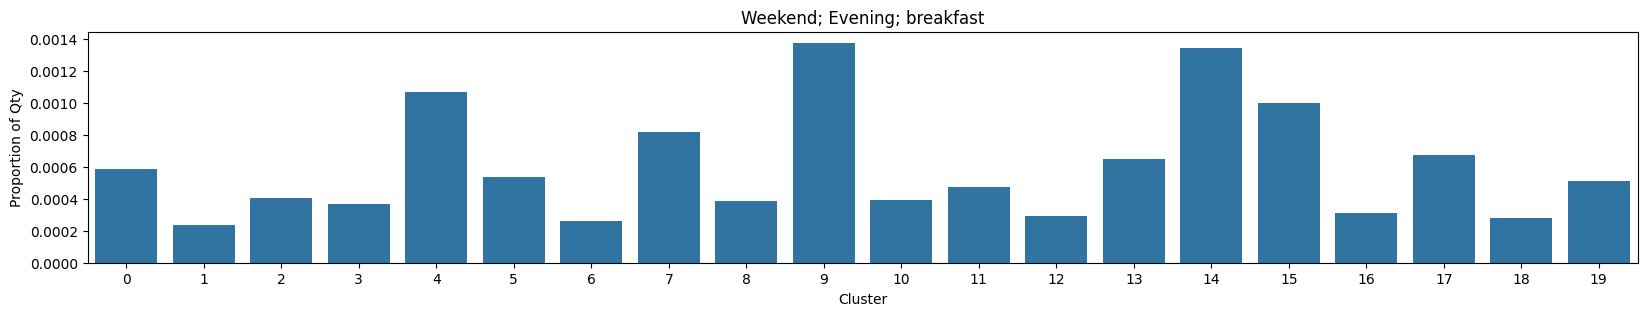

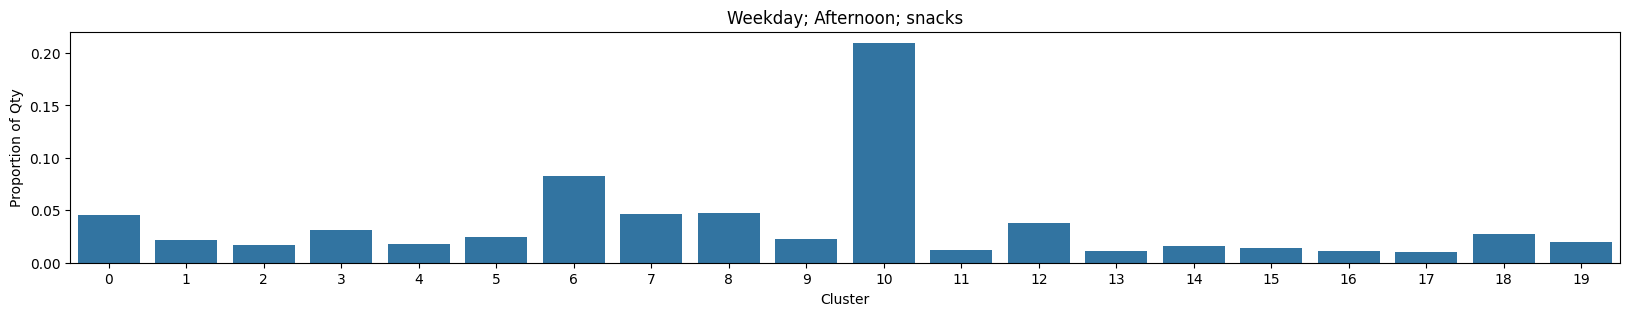

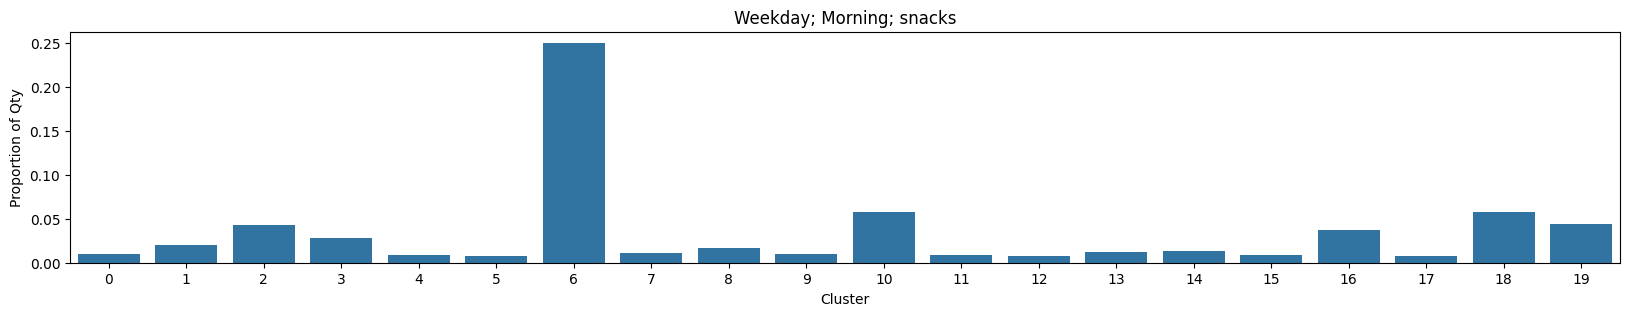

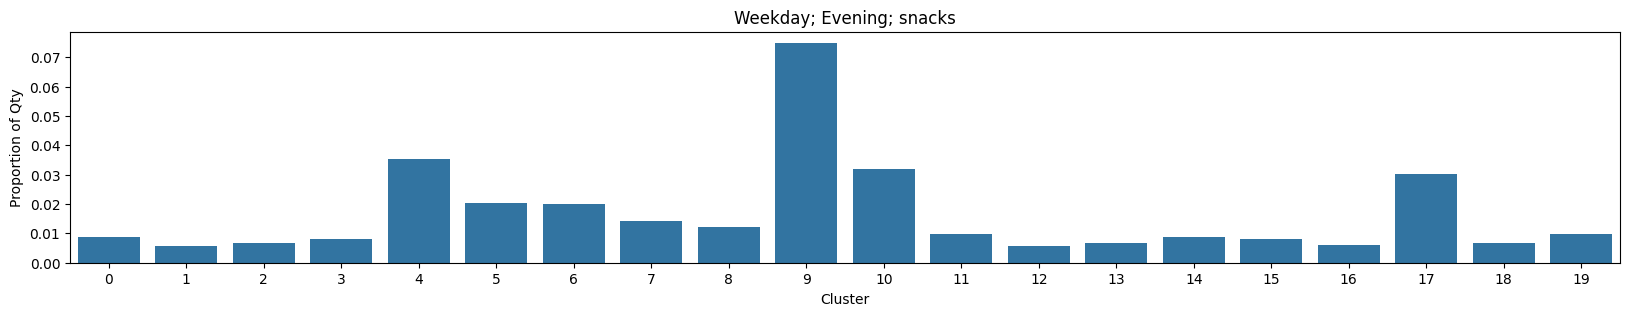

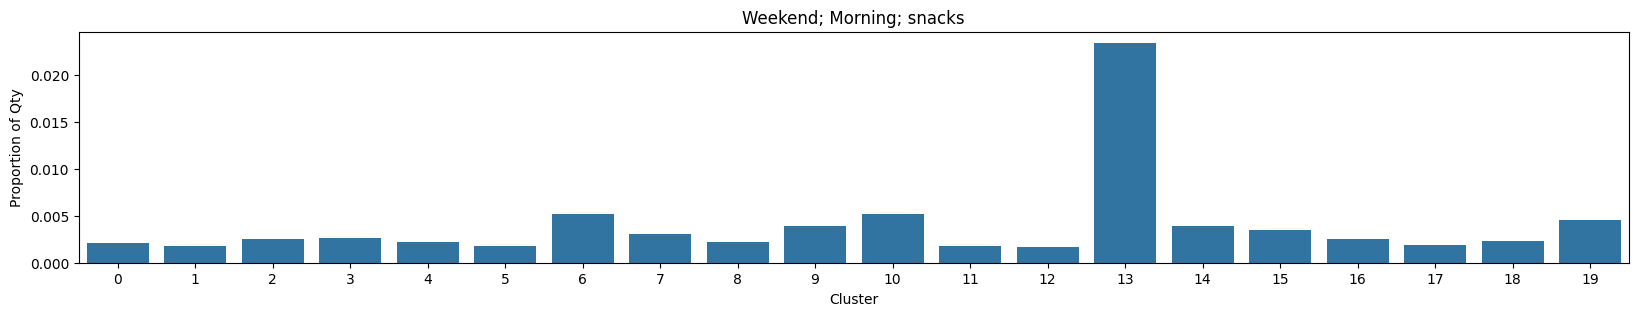

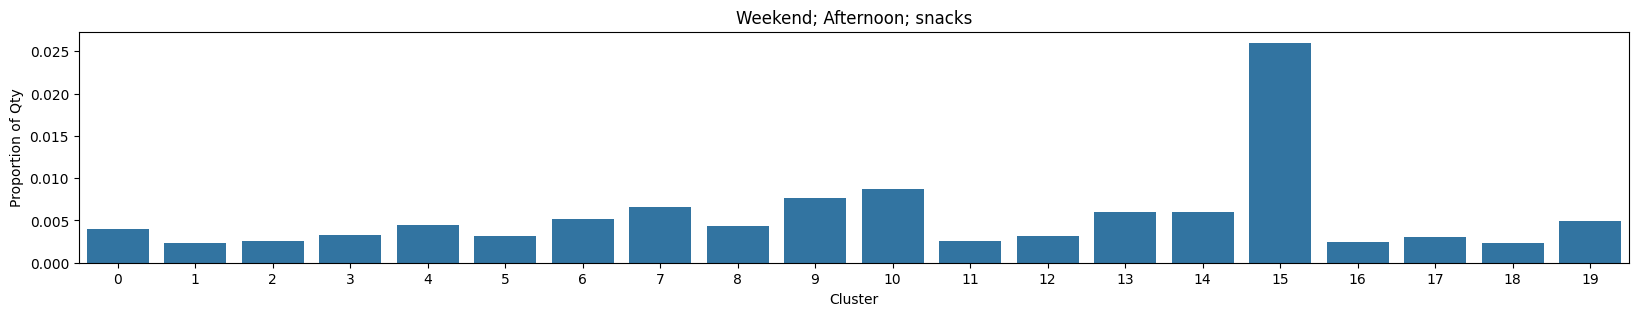

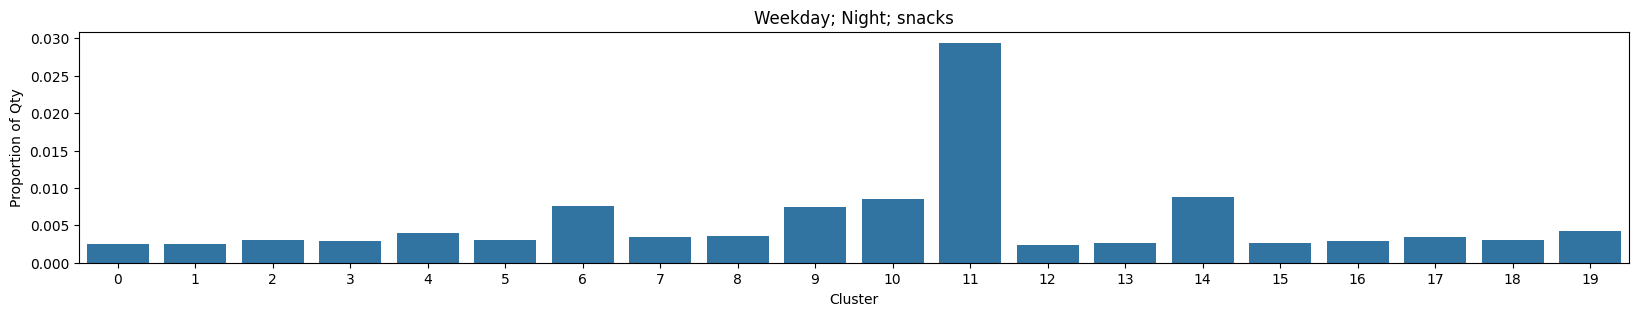

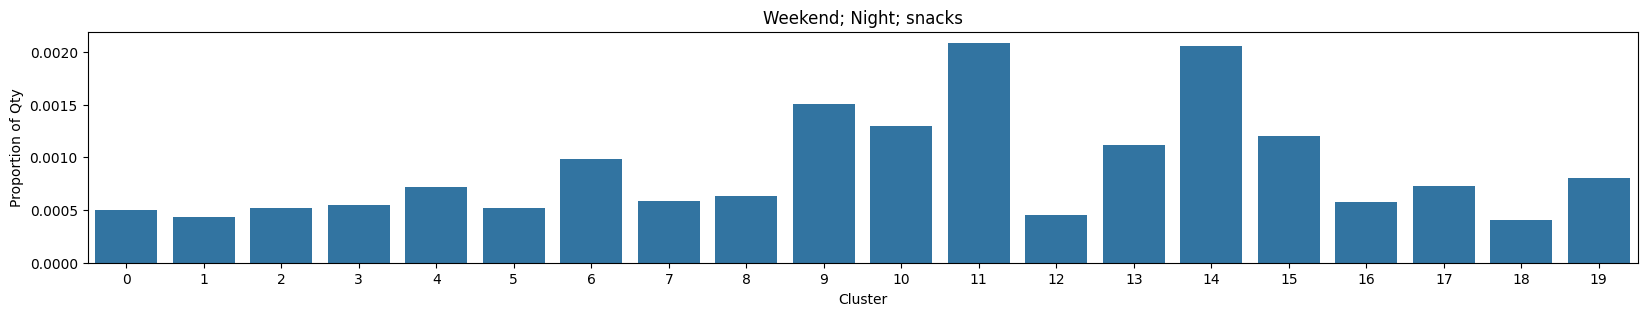

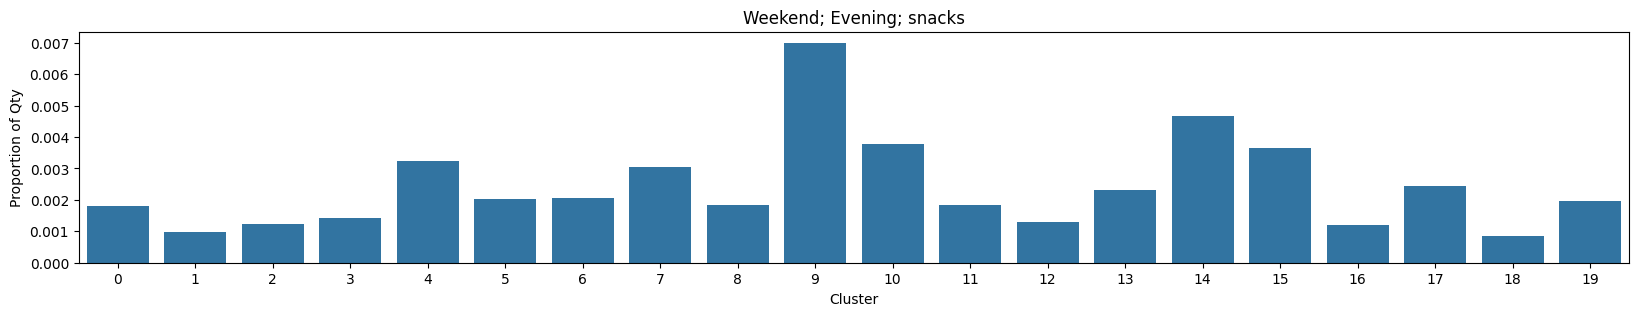

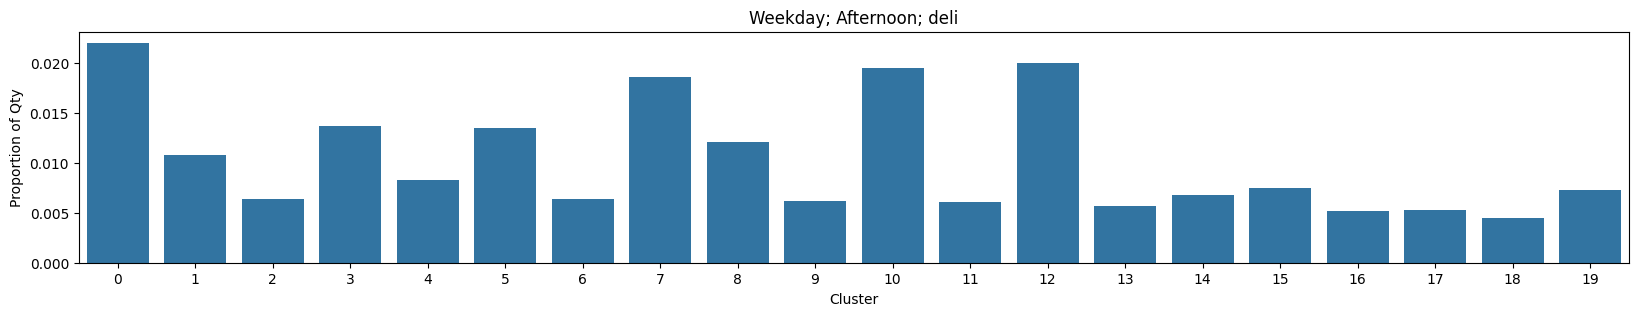

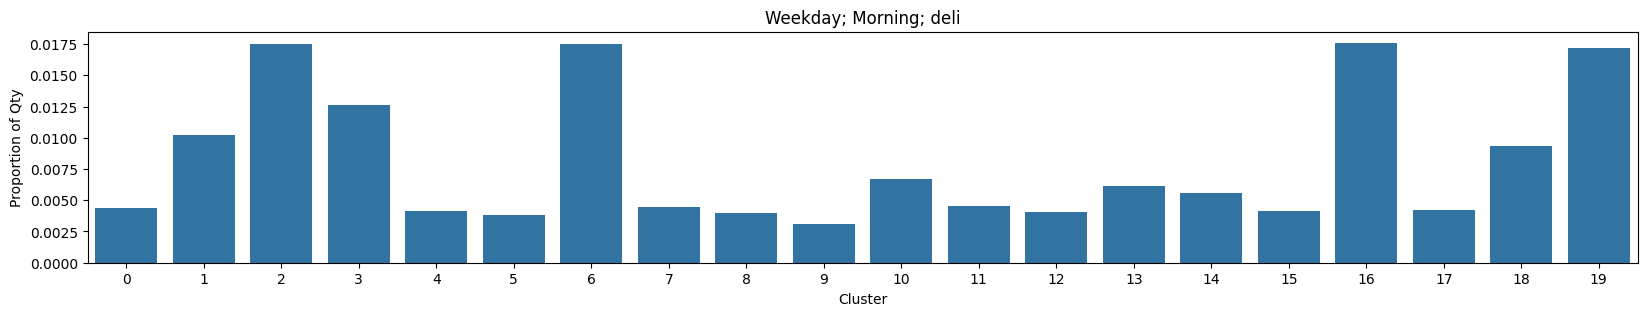

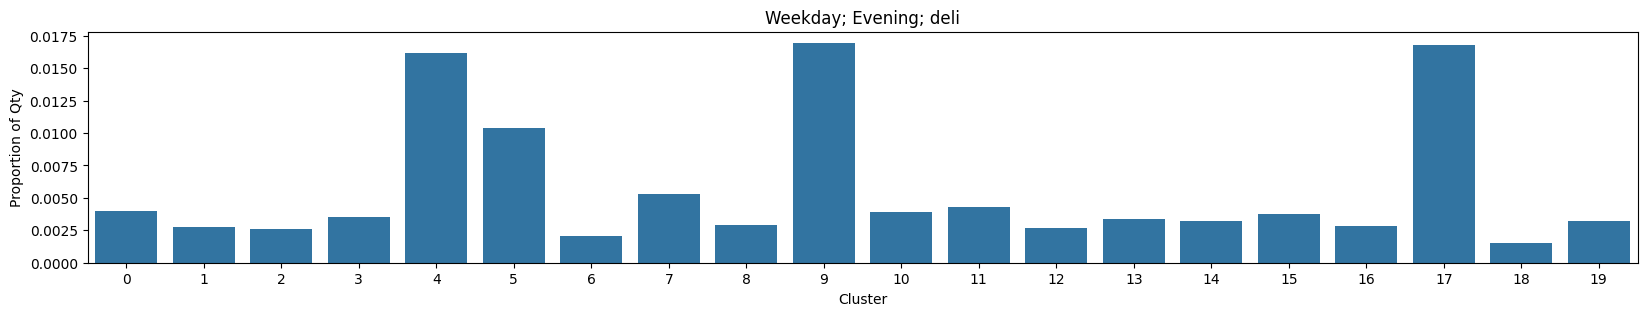

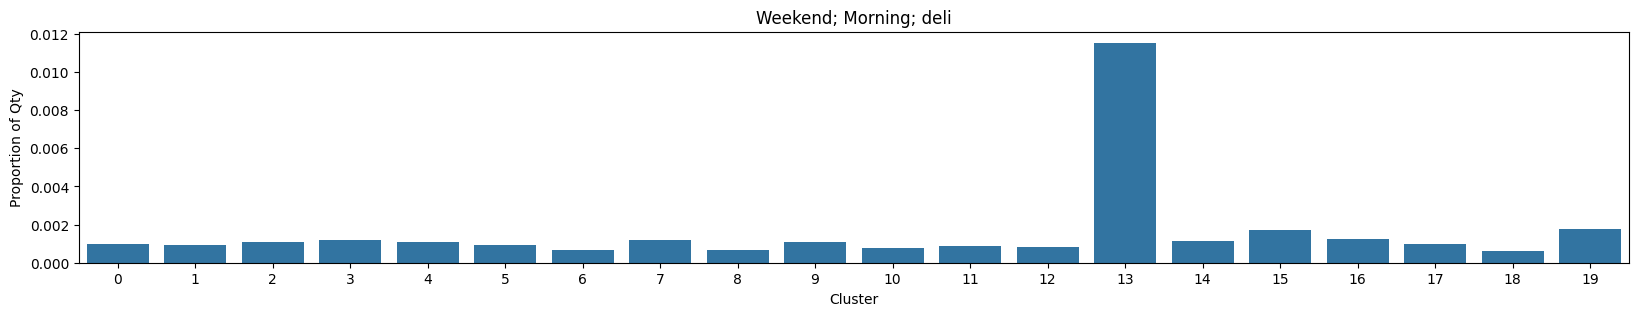

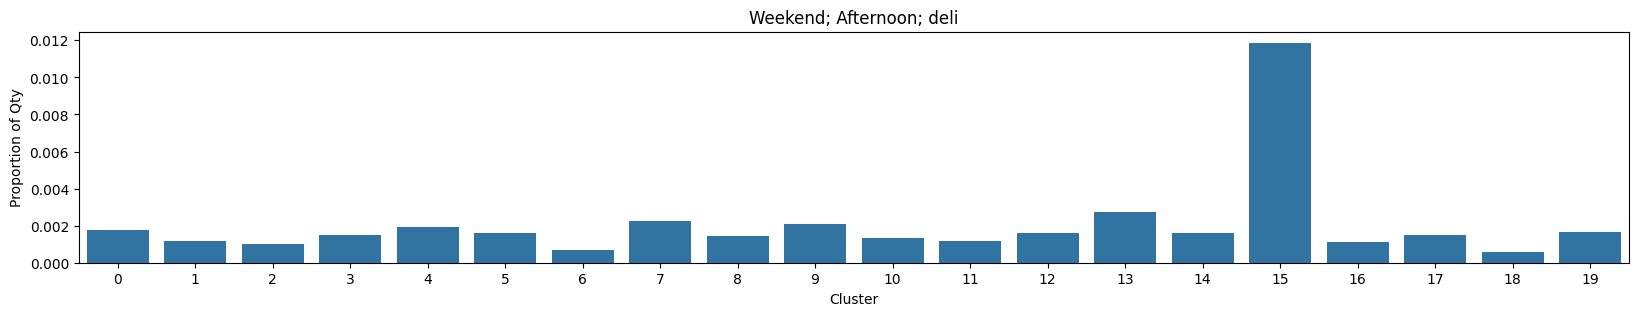

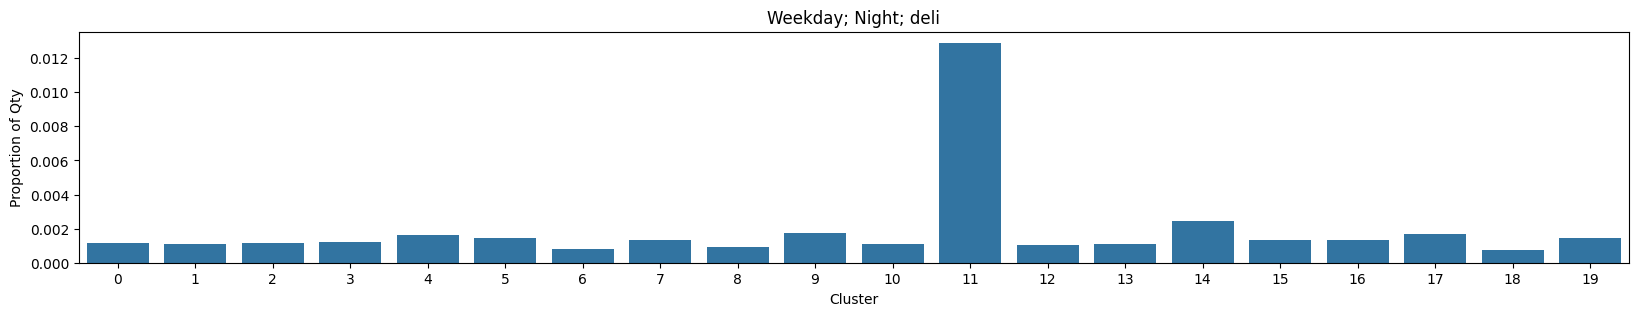

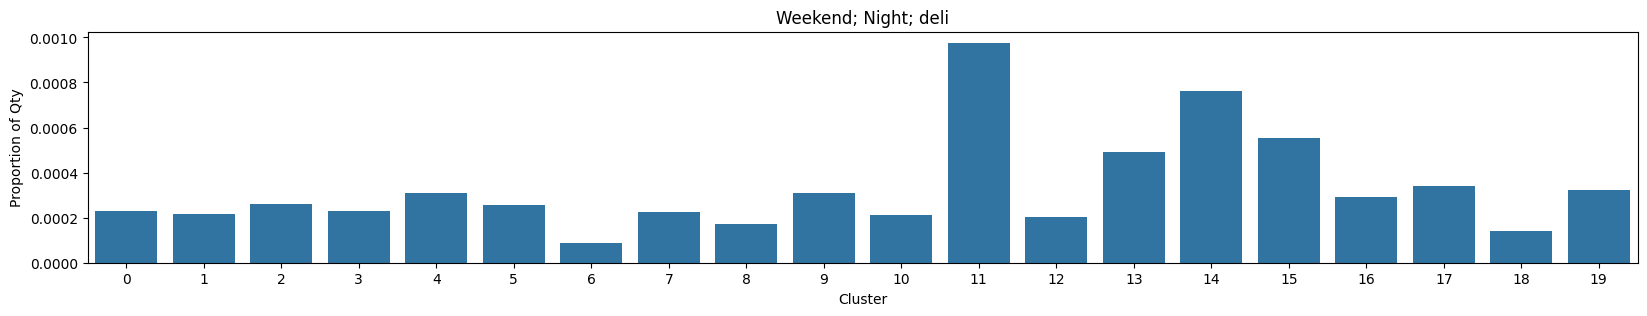

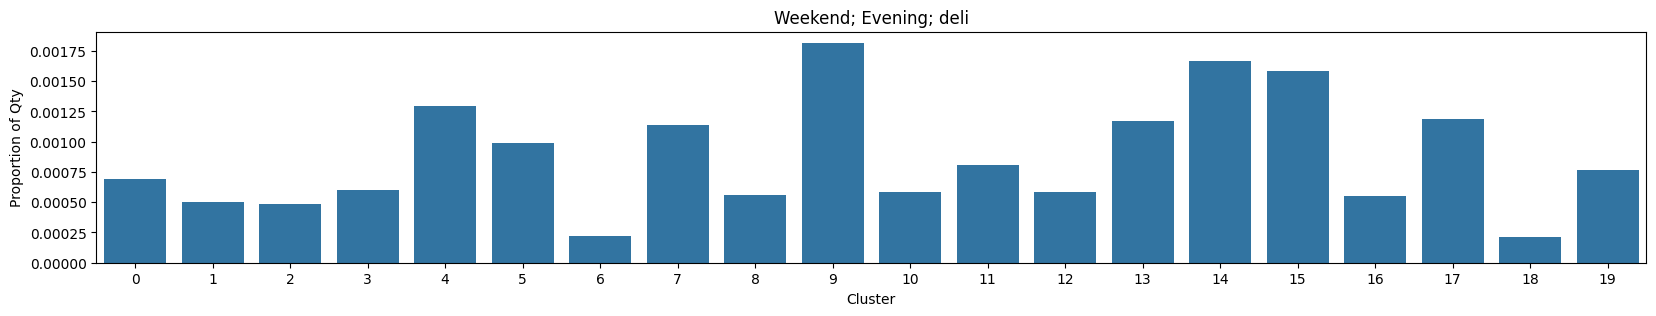

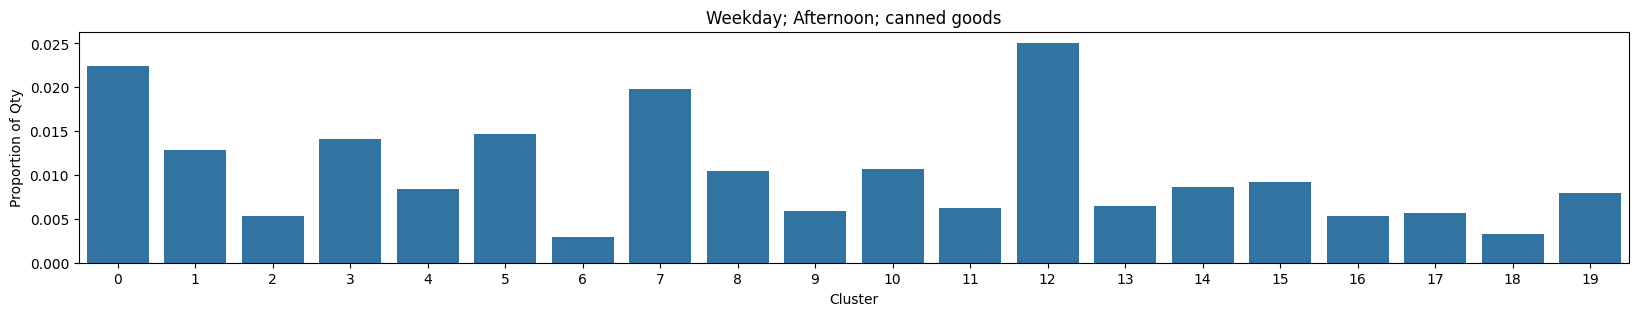

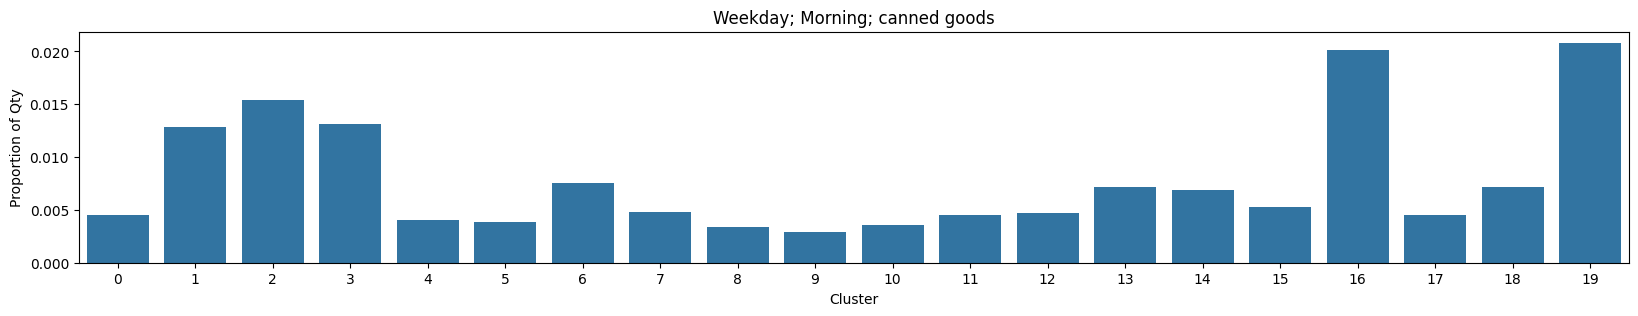

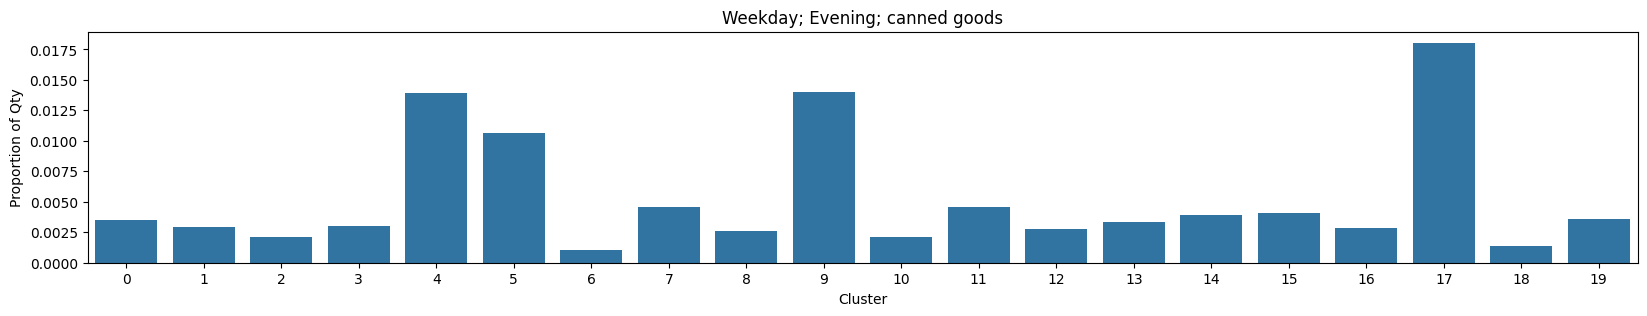

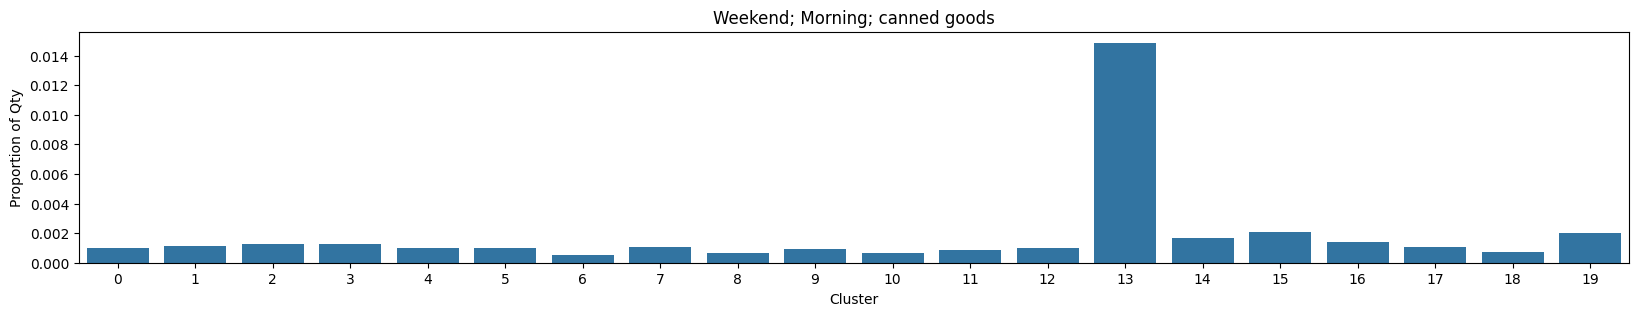

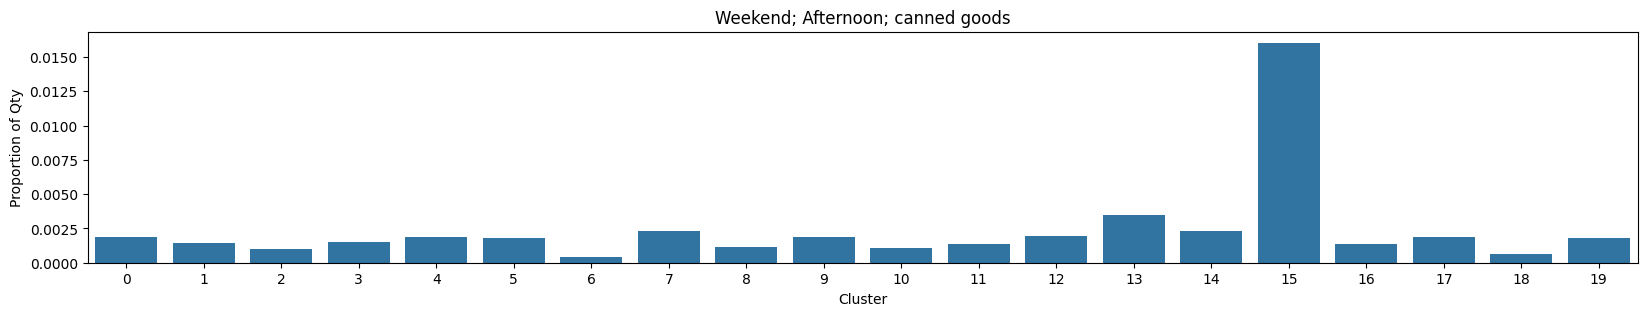

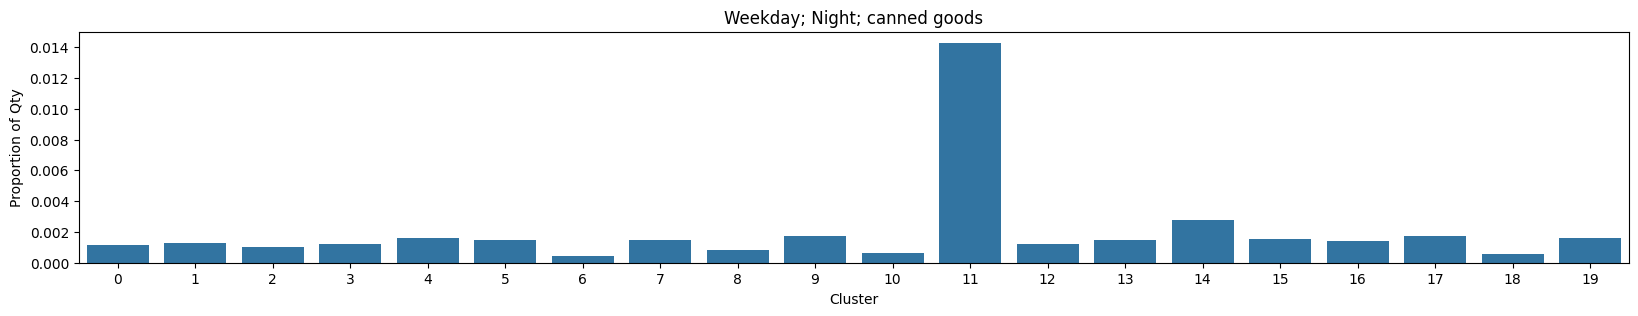

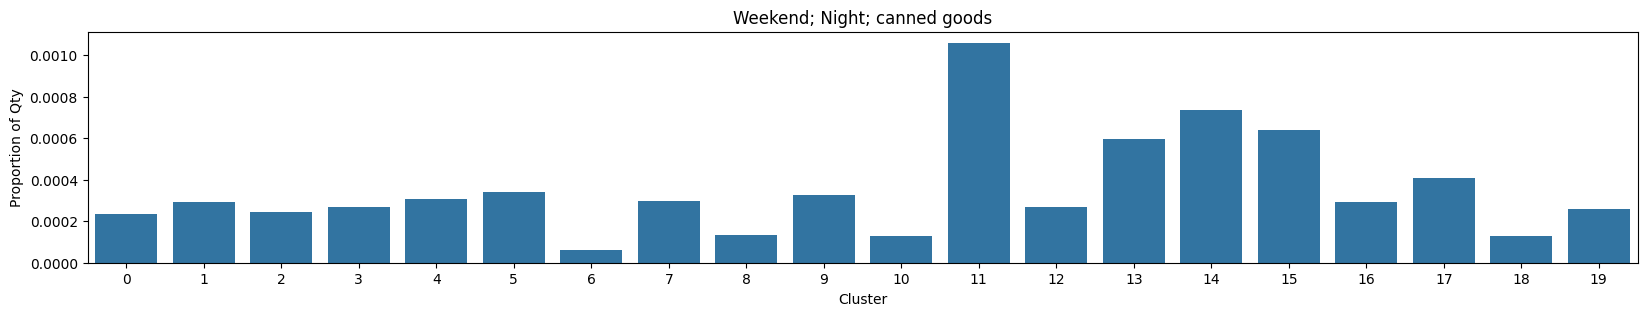

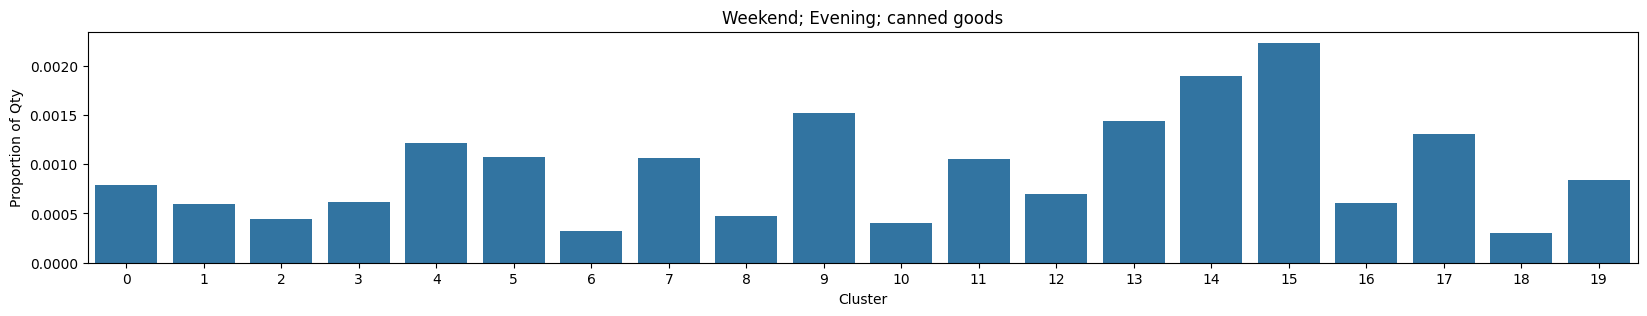

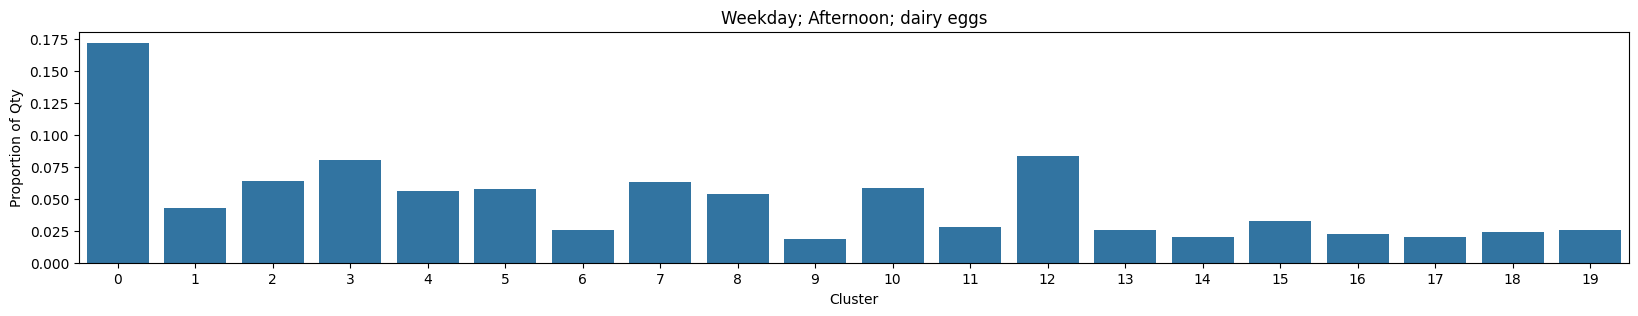

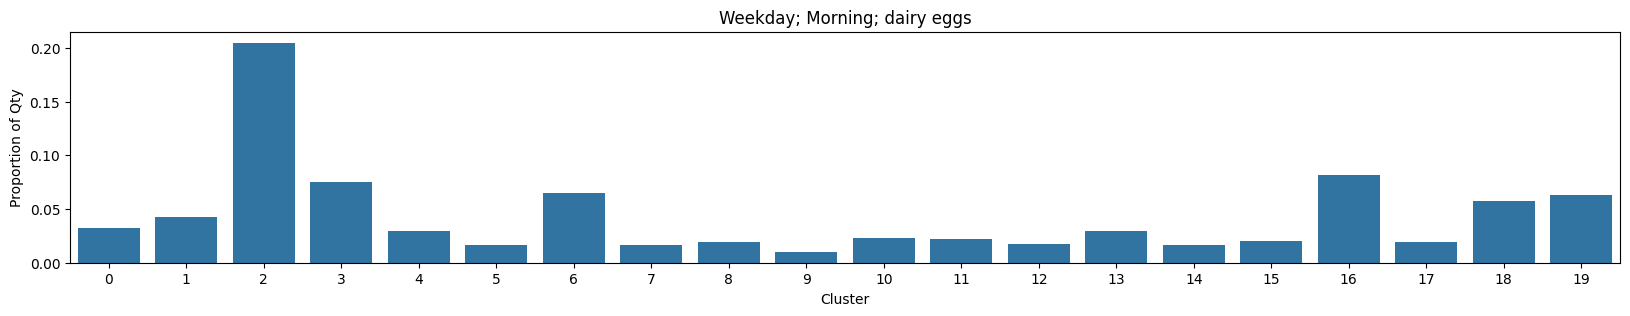

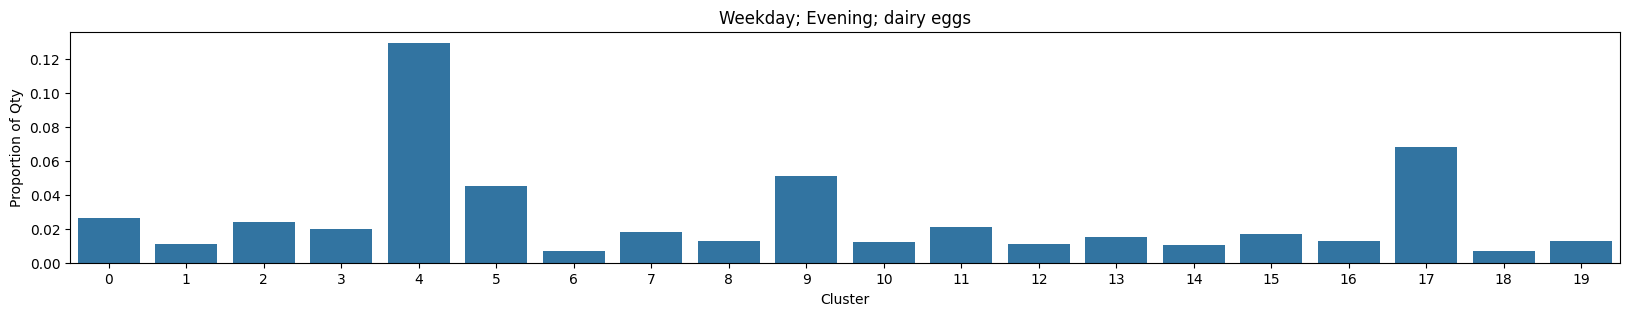

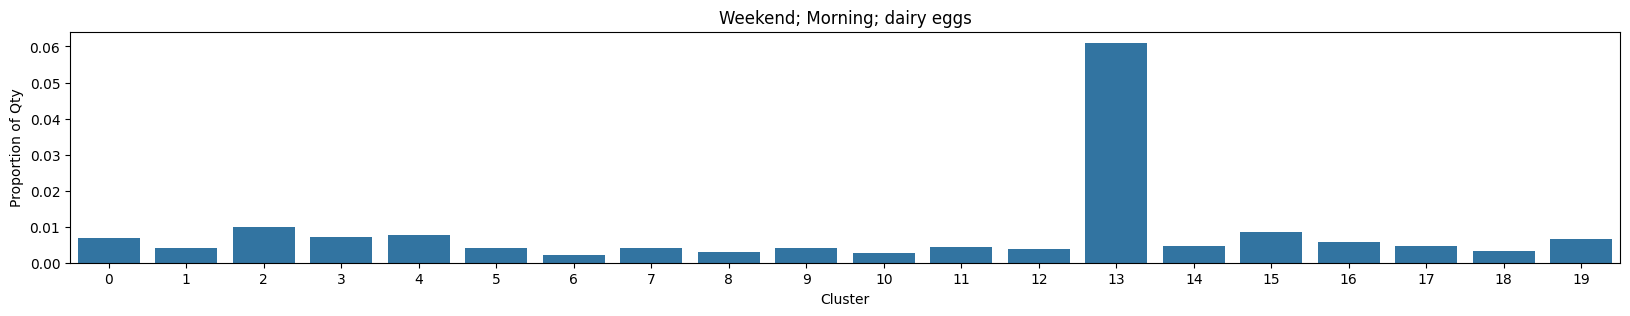

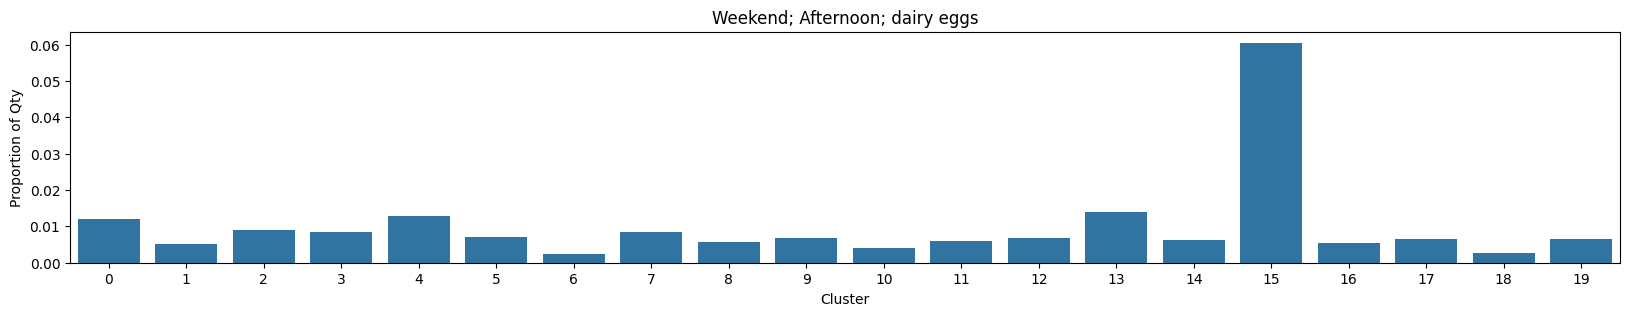

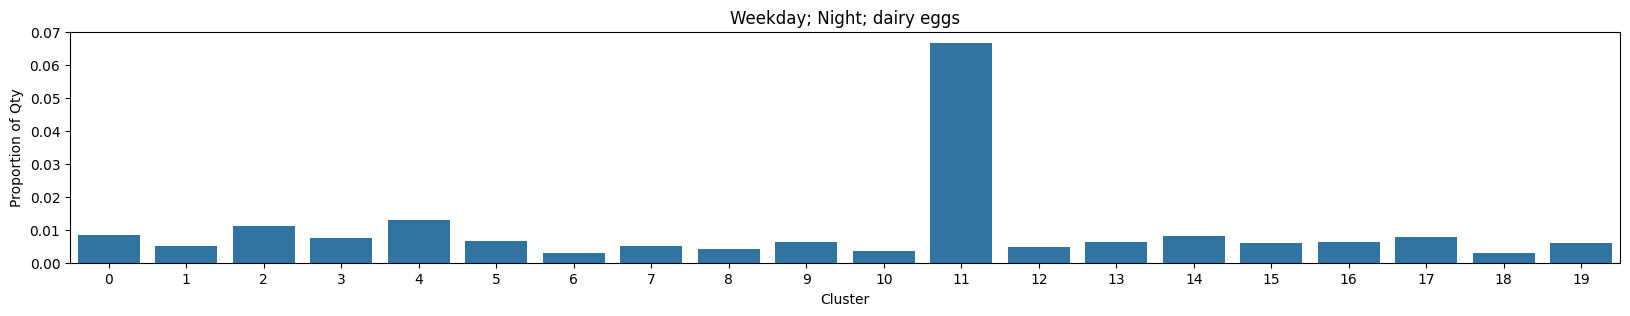

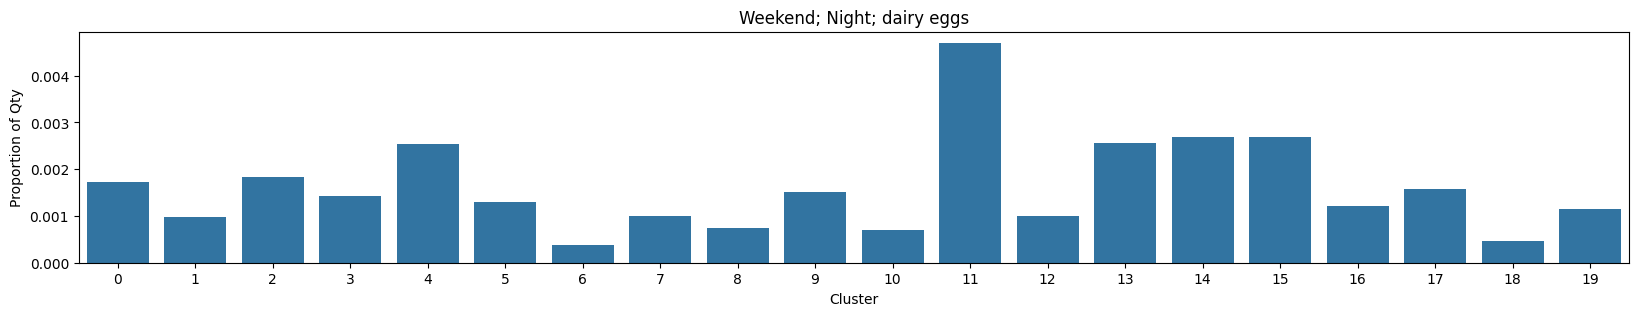

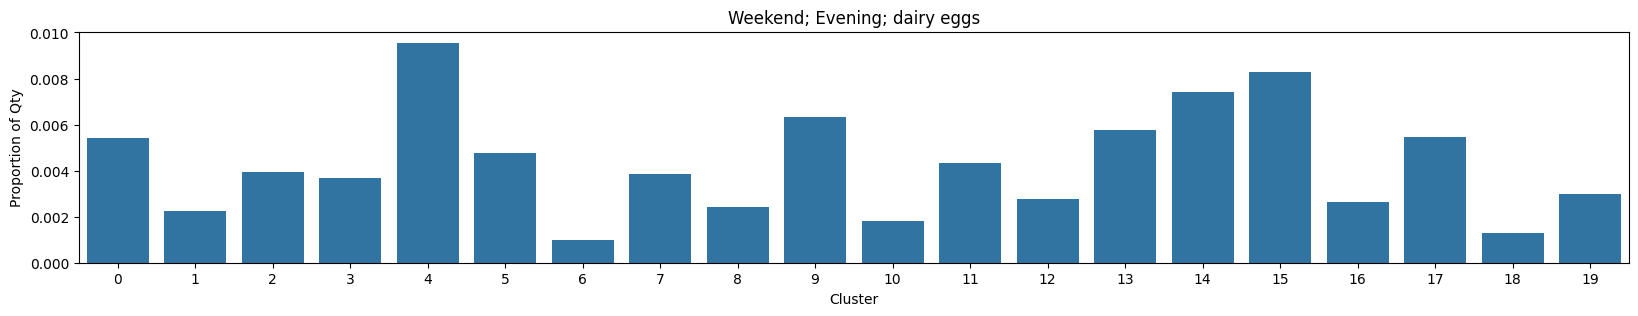

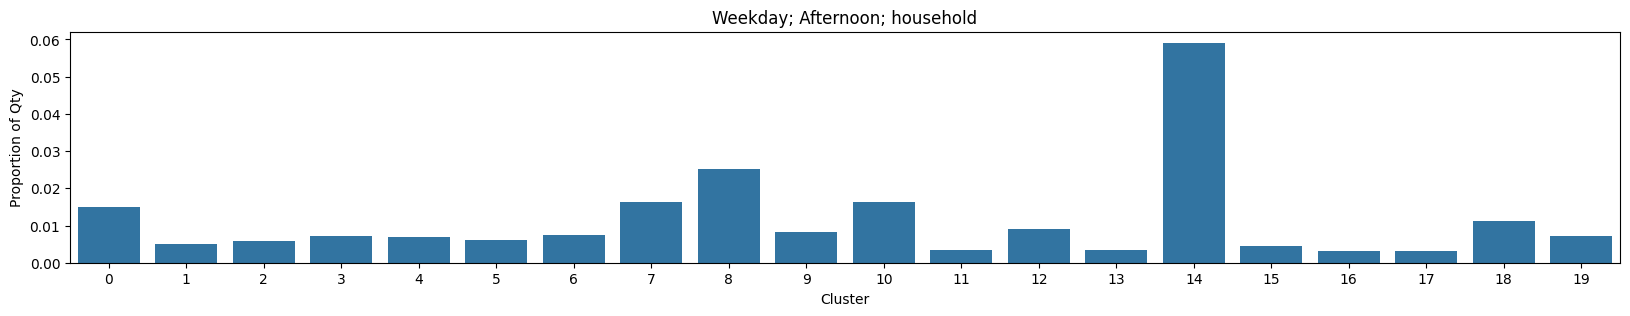

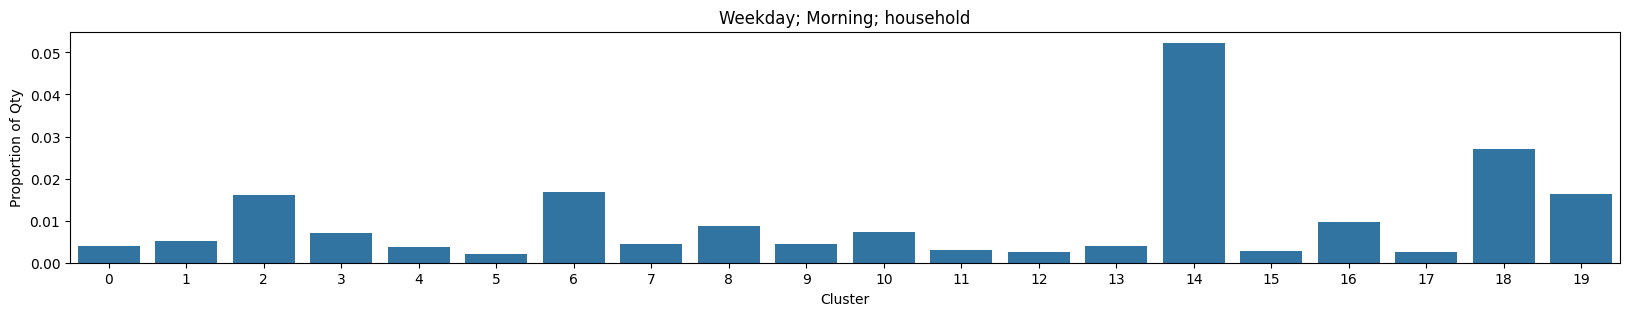

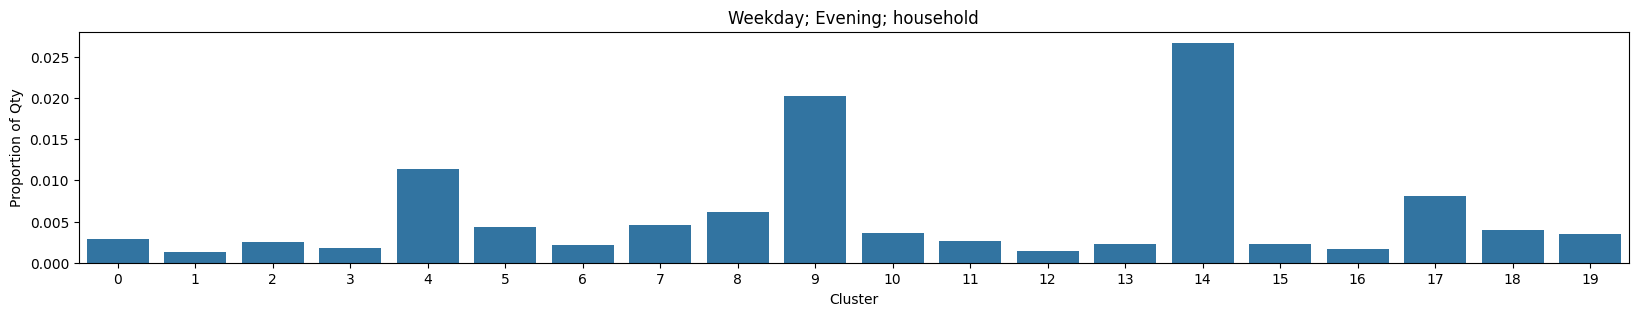

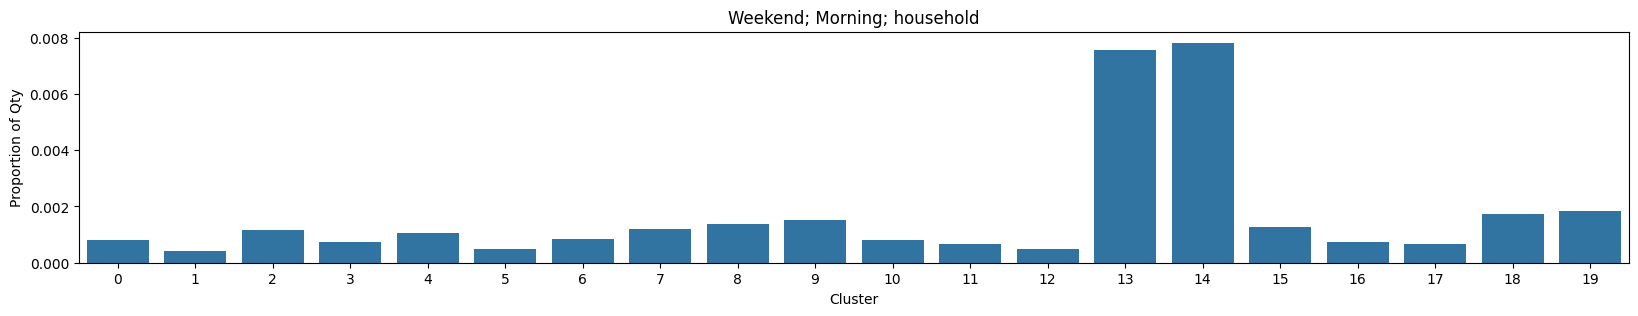

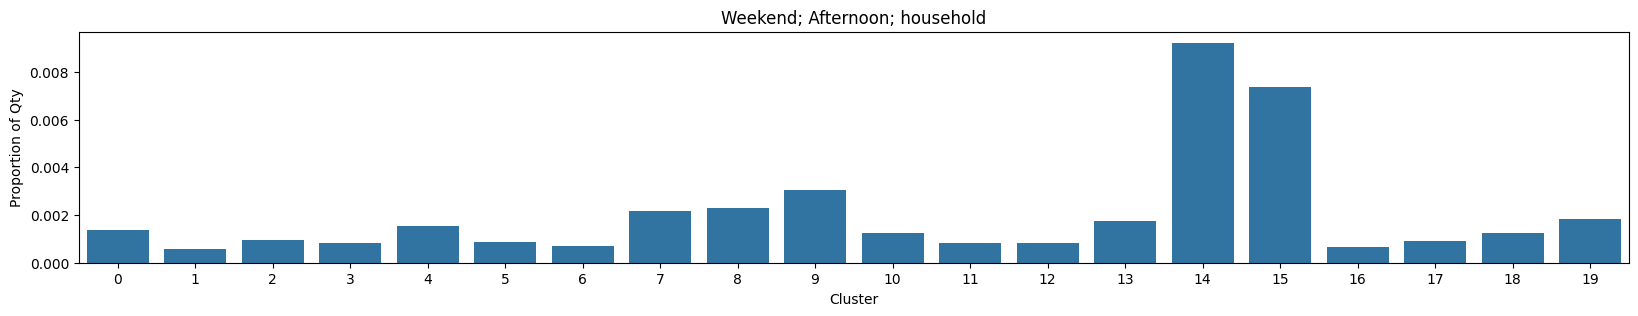

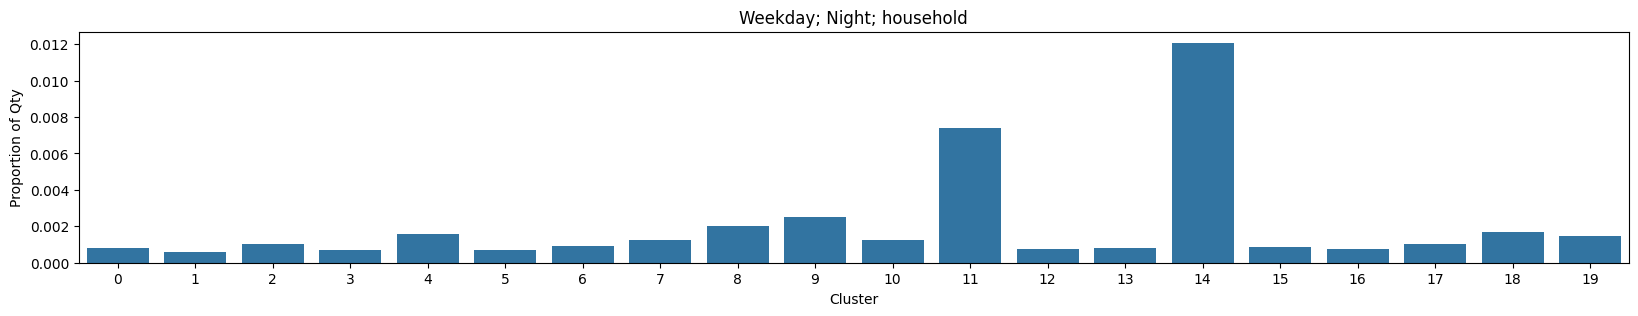

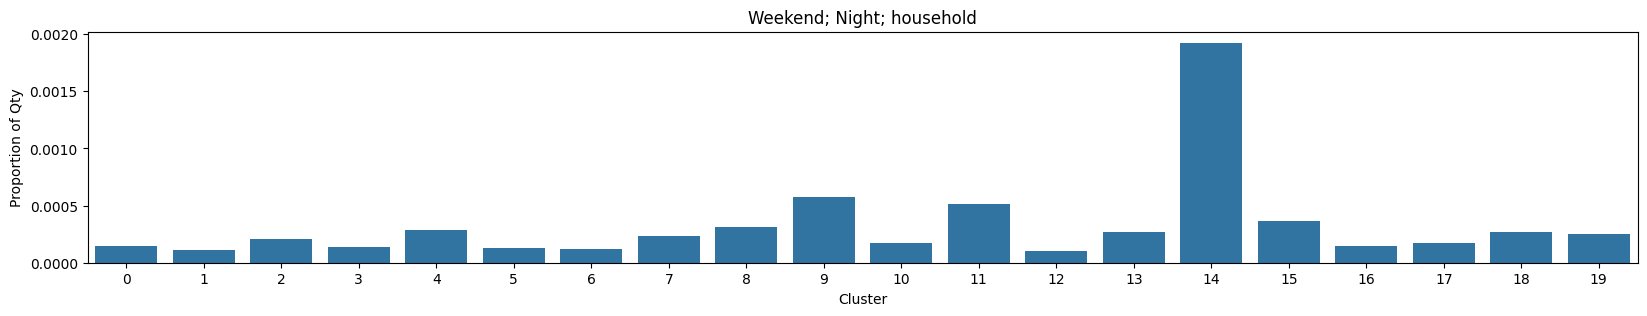

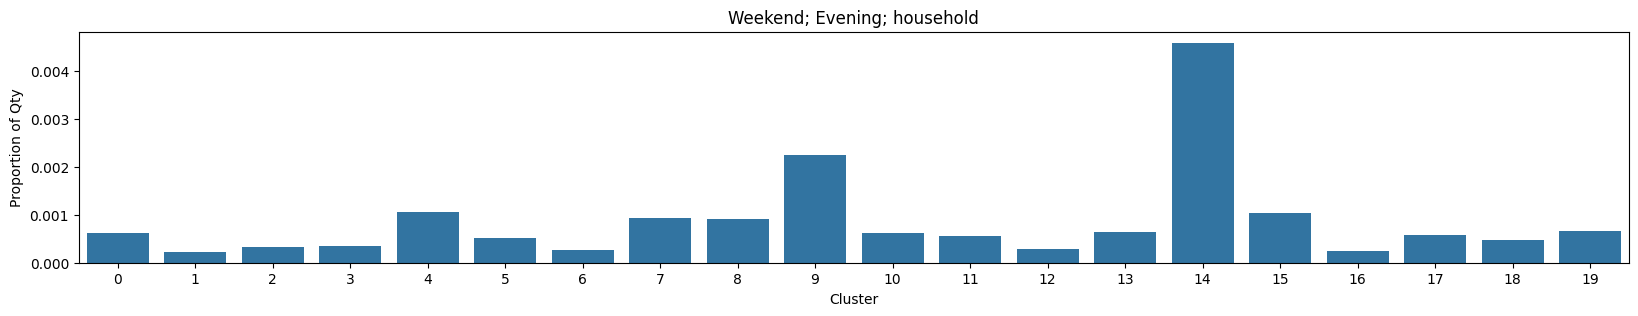

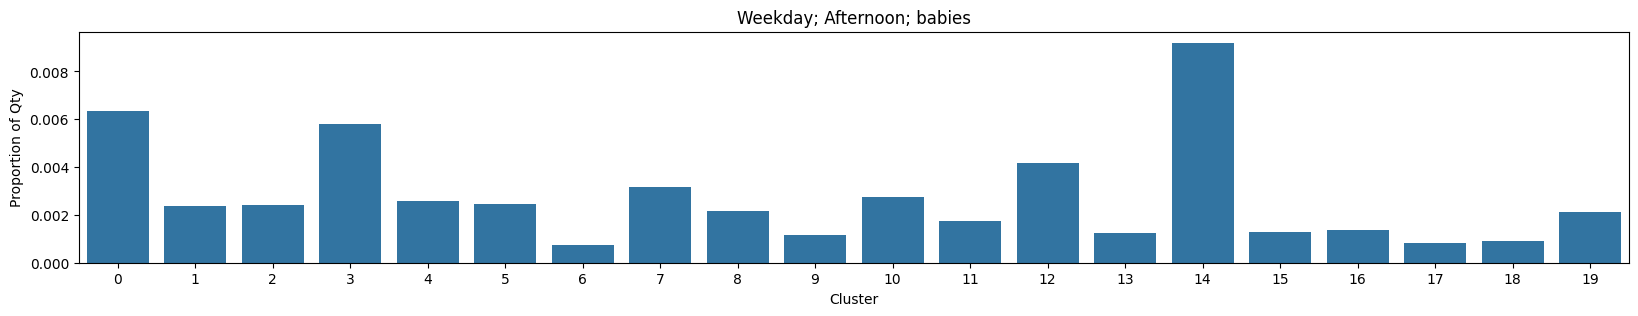

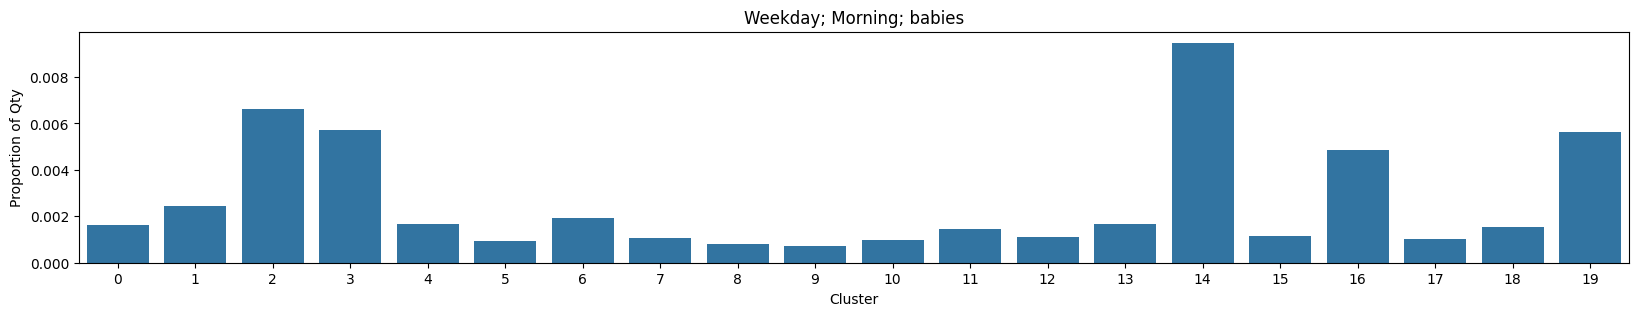

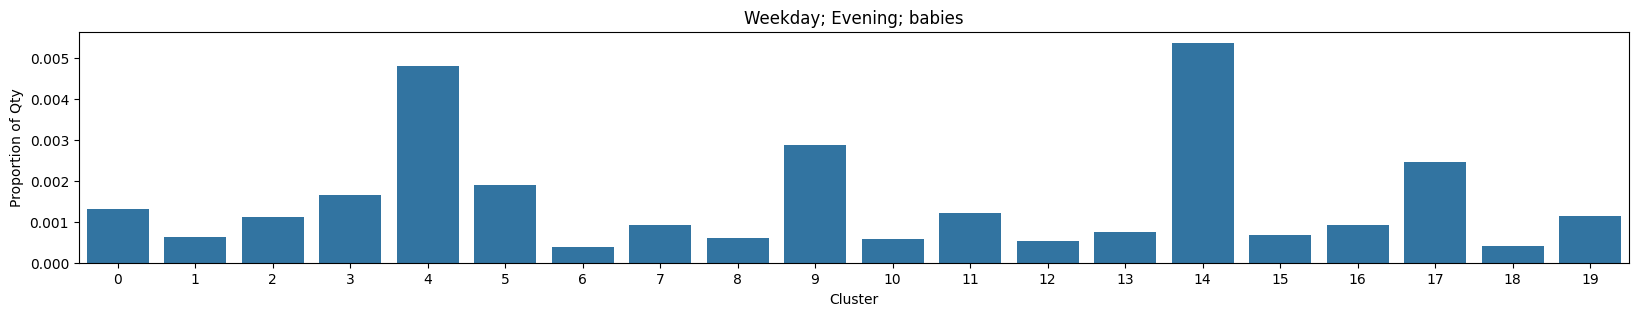

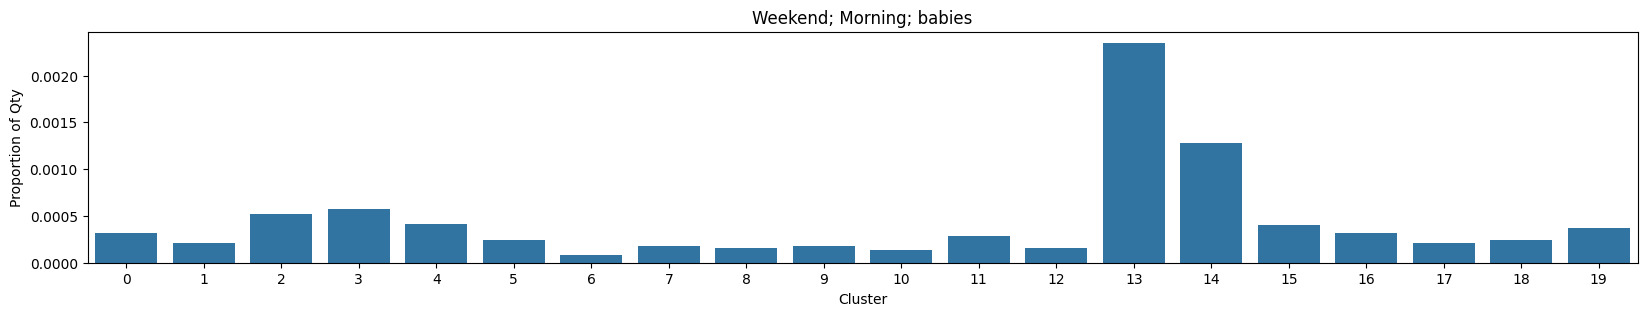

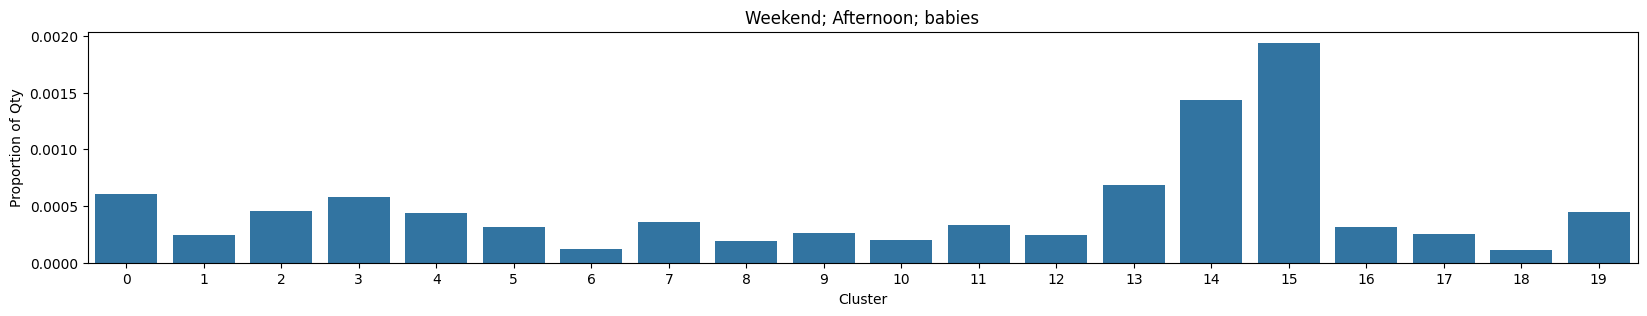

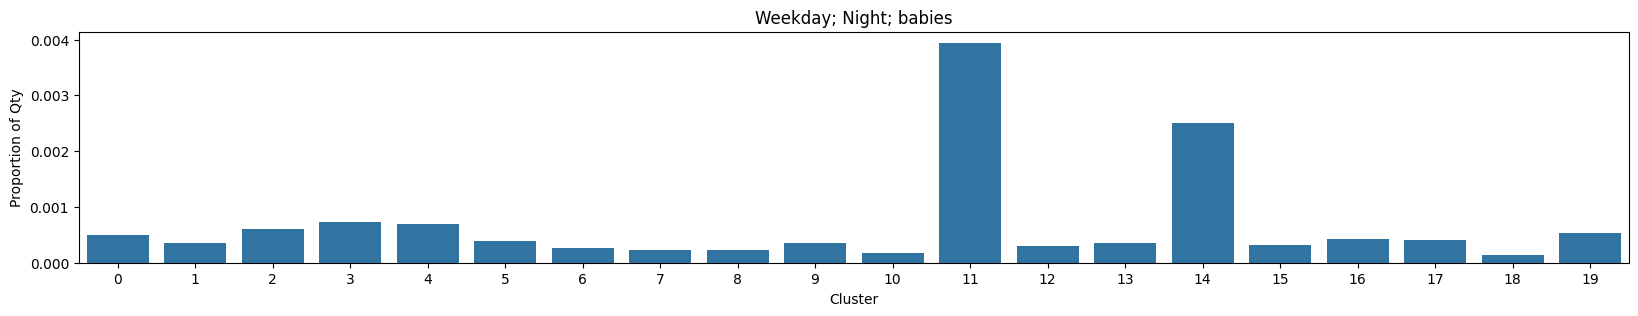

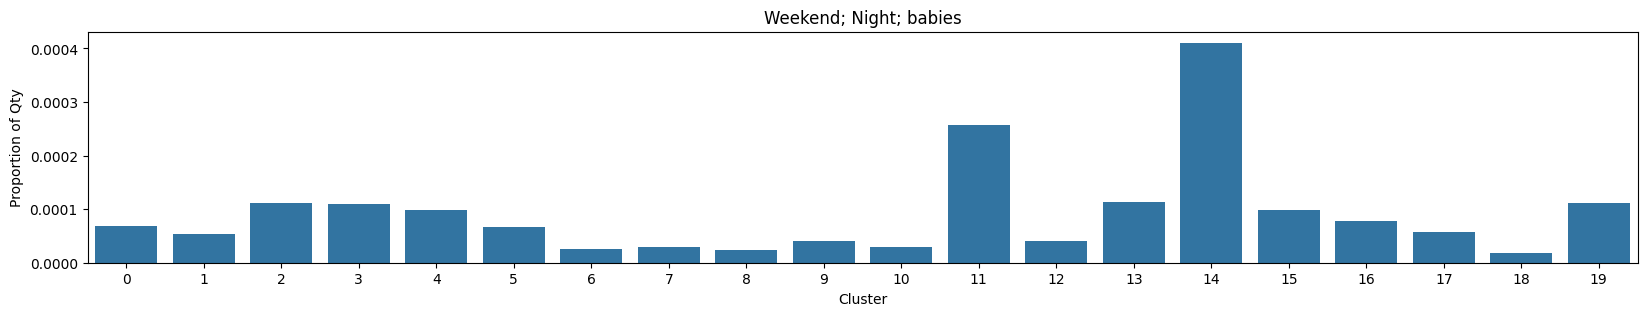

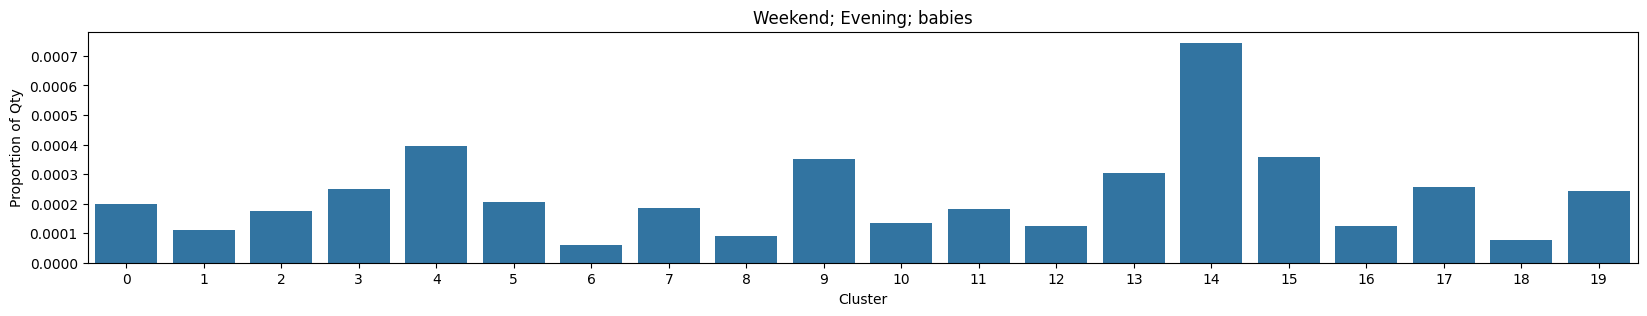

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

for i in user_tow_deptname_mix_df['department'].unique():
  if i not in ['missing', 'other']:
    for j in user_tow_deptname_mix_df['time_of_purchase'].unique():
      plt.figure(figsize=(20,3))
      cat = j + "; " + i
      sns.barplot(x='cluster_kmeans', y=cat, data=avg_mix_tow_deptname)
      plt.title(cat)
      plt.xlabel("Cluster")
      plt.ylabel("Proportion of Qty")
      plt.show()